## [Dacon] AI프렌즈 시즌1 온도 추정 경진대회
## 박꾸디 (팀명)
## 2020년 4월 14일 (제출날짜)

# 모델링 코드 작성방법

A 코드 관련

1) 입상자는 코드 제출 필수. 제출 코드는 예측 결과를 리더보드 점수로 복원할 수 있어야 함

2) 코드 제출시 확장자가 R user는 .R or .rmd. Python user는 .py or .ipynb

3) 코드에 ‘/data’ 데이터 입/출력 경로 포함 제출 or R의 경우 setwd(" "), python의 경우 os.chdir을 활용하여 경로 통일

4) 전체 프로세스를 일목요연하게 정리하여 주석을 포함하여 하나의 파일로 제출

5) 모든 코드는 오류 없이 실행되어야 함(라이브러리 로딩 코드 포함되어야 함).

6) 코드와 주석의 인코딩은 모두 UTF-8을 사용하여야 함

B 외부 데이터

1) 본 대회에는 어떠한 외부데이터 사용이 불가합니다.

# --------------------------------------------대략적인 논리 --------------------------------------------


1. 우선 각각의 Y들을 예측할 것입니다.
2. 각각의 Y들을, 주어진 3일치의 Y18을 이용하여 여러 방법을 이용해서 조합을 짤 것입니다. 
3. 각각의 Y들을 예측하는데 MAE가 2이하인 Y들만 이용하여 조합을 짜보고, 모든 Y를 이용하여 조합을 짜되, 나름 MAE가 낮은 Y들로 예측한 경우는 구간을 잘게잘게(하루144구간)으로 나누어 조합을 짜고 모든 Y를 이용한 경우는 Y자체를 쉽게 믿을 수 없기에 하루를 8, 12구간으로 나누어 조합을 짤 것입니다.
4. 각 구간의 조합을 만들시에는 모든 경우의 수를 고려할 수 없기에 3일치 Y18과 Y예측값의 MAE가 1이하인 Y끼리 sum해서 성능을 보고, 그 다음 2이하인 것들끼리.. 3, 4, 5 이렇게 수를 늘려가며 최종적으로 sum과 Y18의 MAE가 가장 작은 경우로 조합을 구성합니다.
5. 그 이후에, 전반적으로 Y18의 모양을 만들었다면, random forest를 이용해 잔차를 학습시켜 잔차를 더해줌으로서 마무리 합니다. regression의 경우, 변수들의 단위문제때문에 사용하기가 어려웠습니다. 
6. 아무래도 구간을 너무 잘게 나눈 점, 마지막까지 잔차를 이용하여 3일치에 더욱 적합시킨점이 패착인것 같습니다. 3일치로 80일치를 예측 한다는 것이 아무래도 쉽지 않기에 단순히 예측한 Y들로 조합을 짜는 것이 오히려 overfitting에 유리할 것이라고 생각했습니다만, 아니였나봅니다...그리고 일별 변수들의 편차, 최대 최소 값등을 사용할 수가 없었고 다양한 Smoothing방법들을 시도할 수가 없었습니다.. 모두 Data Leakage와 관련이 있어 어려웠습니다.

## 1. 라이브러리 및 데이터
## Library & Data

In [51]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
import random
random.seed(777)
np.random.seed(1)
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

import os
os.getcwd()
os.chdir('C:\\Users\\ParkGiChan\\Desktop\\AIFrenz')
from tqdm import tqdm

import lightgbm as lgbm
import re
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import RandomForestRegressor 

## 2. 데이터 전처리
## Data Cleansing & Pre-Processing  

In [52]:
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)

In [53]:
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)

X = train.iloc[:,np.where(train.columns.str.find('Y') != 0)[0]]
y = train.iloc[:,np.where(train.columns.str.find('Y') == 0)[0]]

select_index_train = [i for i in range(0, len(train.columns)) if len(set(train.iloc[:,i])) != 1]
select_index_test = [i for i in range(0, len(test.columns)) if len(set(test.iloc[:,i])) != 1]

## 변수이름 변경

In [54]:
description = ['temp', 'a_pre', 'wind_speed', 'wind_speed', 'cul_rain', 'b_pre',
       'a_pre', 'temp', 'b_pre', 'b_pre', 'cul_rain', 'cul_sun', 'humid',
       'wind_direct', 'cul_sun', 'wind_direct', 'cul_sun', 'wind_direct',
       'wind_speed', 'cul_rain', 'humid', 'cul_rain', 'a_pre', 'b_pre',
       'wind_speed', 'wind_direct', 'wind_speed', 'a_pre', 'temp',
       'b_pre', 'humid', 'temp', 'temp', 'b_pre', 'cul_sun',
       'wind_direct', 'cul_rain', 'humid', 'humid', 'cul_rain']

variable = train.columns[0:40]

col_name = pd.DataFrame({'description':description, 'variable':variable})

In [55]:
col = col_name['description'] + "_" + col_name['variable']
test.columns = col
a = list(col)
a.extend(train.columns[40:])
train.columns = a

train = train.iloc[:,select_index_train]
test = test.iloc[:,select_index_test]

## 구간을 나누는 변수 생성하기

In [56]:
interval = 12
value = int(144/interval)
a = np.array([[i]*value for i in range(0, interval)]).reshape(-1)

test['date'] = np.array([[i]*144 for i in range(0,80)]).reshape(-1)
test['day'] = np.array([a for i in np.arange(0,80)]).reshape(-1)

train['date'] = np.array([[i]*144 for i in range(0,33)]).reshape(-1)
train['day'] = np.array([a for i in np.arange(0,33)]).reshape(-1)

In [57]:
a = np.array([[i]*24 for i in range(0, 6)]).reshape(-1)
test['day2'] = np.array([a for i in np.arange(0,80)]).reshape(-1)
train['day2'] = np.array([a for i in np.arange(0,33)]).reshape(-1)

## 토론에 따라 sin, cos 함수를 이용하여 파생변수를 만들어 보았습니다.

In [58]:
min_in_day = 24*6
hour_in_day = 24

minute = np.array([[i]*1 for i in range(0, 144)]).reshape(-1)
train_minute = np.array([minute for i in np.arange(0,33)]).reshape(-1)
train_sin_minute = np.sin(np.pi*train_minute/min_in_day) 
train_cos_minute = np.cos(np.pi*train_minute/min_in_day) 

test_minute = np.array([minute for i in np.arange(0,80)]).reshape(-1)
test_sin_minute = np.sin(np.pi*test_minute/min_in_day) 
test_cos_minute = np.cos(np.pi*test_minute/min_in_day) 

hour = np.array([[i]*6 for i in range(0, 24)]).reshape(-1)
train_hour = np.array([hour for i in np.arange(0,33)]).reshape(-1)
train_sin_hour = np.sin(np.pi*train_hour/hour_in_day) 
train_cos_hour = np.cos(np.pi*train_hour/hour_in_day) 

test_hour = np.array([hour for i in np.arange(0,80)]).reshape(-1)
test_sin_hour = np.sin(np.pi*test_hour/hour_in_day) 
test_cos_hour = np.cos(np.pi*test_hour/hour_in_day) 

train['sin_minute'] = train_sin_minute
train['cos_minute'] = train_cos_minute

test['sin_minute'] = test_sin_minute
test['cos_minute'] = test_cos_minute

## 누적일조량을 단순일조량으로 바꾸었습니다.

In [59]:
def my_sun(train):
    temp = train.iloc[:,np.where(train.columns.str.find('cul_sun') == 0)[0]]
    temp2 = temp.copy()
    for i in range(1, len(temp)):
        temp2.iloc[i,:] = temp.iloc[i,:] - temp.iloc[i-1,:]
    temp2.iloc[np.where(temp2.sum(axis=1) < 0)[0],:] = 0
    
    train['sun_X11'] = temp2['cul_sun_X11']
    train['sun_X34'] = temp2['cul_sun_X34']
    
    return train

train = my_sun(train)
test = my_sun(test)

## 기온과 습도의 차이를 파생변수로 만들었습니다.

In [60]:
X = train.iloc[:,np.where(train.columns.str.find('Y') != 0)[0]]
y = train.iloc[:,np.where(train.columns.str.find('Y') == 0)[0]]

def my_diff(train, A,B):
    A = train.iloc[:,np.where(train.columns.str.find(A) == 0)[0]]
    B = train.iloc[:,np.where(train.columns.str.find(B) == 0)[0]]

    for i in A.columns:
        for j in B.columns:
            train[i + "-" + j] = A[i] - B[j]
    return train

X = my_diff(X, 'temp','humid')
test = my_diff(test,'temp', 'humid')

## 풍향변수는 사용하지 않았습니다.

In [61]:
drop_wind = train.iloc[:,np.where(train.columns.str.find('wind_direct') == 0)[0]].columns
X.drop(drop_wind, axis=1, inplace=True)
test.drop(drop_wind, axis=1, inplace=True)

## 3. 탐색적 자료분석
## Exploratory Data Analysis


In [62]:
# 입력하세요.

## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling  

In [63]:
# 입력하세요.

## 5. 모델 학습 및 검증
## Model Tuning & Evaluation

#### 우선, 각각의 Y00~Y17을 예측합니다. 
#### 5 fold crossvalidation 앙상블 및, train 모두를 사용하여 예측을 합니다. 아래 함수에서 (fold, 'no')로 나뉩니다 
#### 위 2개의 방법을 3개의 Seed로 valid set, test set에 대해서 시행합니다

In [64]:
X_train = X[:4320]
X_val = X[4320:]

y_val = y['Y18'].dropna()
y_train = y.drop('Y18', axis=1).dropna()

In [65]:
def rae(y_true, y_pred):
    residual = abs(y_true - y_pred)
    residual[residual < 1] = 0
    residual = residual**2
    return 'MAE', np.sum(residual)/len(residual), False

In [66]:
def my_lgb(X_train, X_val, y_train, y_val,fold_or_not, n_fold, param):

    val_answer = np.zeros((y_val.shape[0],18))
    val_answer = pd.DataFrame(val_answer)
    val_answer.columns = y_train.columns

    test_answer = np.zeros((test.shape[0],18))
    test_answer = pd.DataFrame(test_answer)
    test_answer.columns = y_train.columns

    score_train = np.zeros((n_fold,18))
    score_train = pd.DataFrame(score_train)
    score_train.columns = y_train.columns
    
    if fold_or_not == 'fold':
        kf = KFold(n_splits=n_fold, shuffle=True, random_state=42)

        for col in tqdm(y_train.columns):
            score = []
            y_train_temp = y_train[col]


            preds = np.zeros((X_val.shape[0],))
            final_preds = np.zeros((test.shape[0],))

            # train, test split
            for n_fold, (trn_idx, val_idx) in enumerate(kf.split(X_train)):
                trn_x, trn_y = X_train.iloc[trn_idx], y_train_temp.iloc[trn_idx]
                val_x, val_y = X_train.iloc[val_idx], y_train_temp.iloc[val_idx]
        
                trn_x.drop(['date','day'], axis=1, inplace=True) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                val_x.drop(['date','day'], axis=1, inplace=True) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
                reg = lgbm.LGBMRegressor(**param)

    
                reg.fit(trn_x, trn_y,
                    eval_set=[(trn_x, trn_y), (val_x, val_y)],
                    early_stopping_rounds=50, verbose=100,
                    eval_metric=lambda y_true, y_pred: [rae(y_true, y_pred)])
            
                score.append(reg.best_score_['valid_1']['l2'])
        
                # oof, pres
                #t_p = reg.predict(trn_x) ; t_p[t_p <0] = 0
                v_p = reg.predict(X_val.drop(['date','day'],axis=1)) ; v_p[v_p <0] = 0 #!!!!!!!!!!!!!!!!!!!!!!
                #oof[val_idx] = v_p # 서로 다른 index, kfold로 인해서 결국 다채워지는거임
                preds += v_p / kf.n_splits
    
                p2 = reg.predict(test.drop(['date','day'], axis=1)) ; p2[p2<0] = 0 #!!!!!!!!!!!!!!!!!!!!!!!
                final_preds += p2/kf.n_splits

                #print('%s fold rmse : %.4f'%(n_fold, np.sqrt(mean_squared_error(train2['18~20_ride'].iloc[val_idx], v_p))))
                print('%s fold 완료'%n_fold)
            
            val_answer[col] = preds
            test_answer[col] = final_preds
            score_train[col] = score
        
    elif fold_or_not == 'no':
        kf = KFold(n_splits=n_fold, shuffle=False, random_state=42)
        
        fold=kf.split(X_train)
        trn_idx = [trn_idx for trn_idx,val_idx in fold][9]
        fold=kf.split(X_train)
        val_idx = [val_idx for trn_idx,val_idx in fold][9]
        
        for col in tqdm(y_train.columns):
            
            y_train_temp = y_train[col]
            
            X_train_subset, y_train_subset = X_train.iloc[trn_idx], y_train_temp.iloc[trn_idx] 
            X_val_subset, y_val_subset = X_train.iloc[val_idx], y_train_temp.iloc[val_idx]
            
            X_train_subset.drop(['date','day'], axis=1, inplace=True)
            X_val_subset.drop(['date','day'], axis=1, inplace=True)
            
            clf = lgbm.LGBMRegressor(**param)
            
            clf.fit(X_train_subset, y_train_subset, eval_set=[(X_val_subset, y_val_subset)],
                    eval_metric=lambda y_true, y_pred: [rae(y_true, y_pred)], early_stopping_rounds=100)
            
            score_train[col] = [clf.best_score_['valid_0']['MAE'] for i in range(0,n_fold)]
            ###full
            ###full
            param2 = param.copy()
            param2['n_estimators'] = clf.best_iteration_
            
            clf2 = lgbm.LGBMRegressor(**param2)
            clf2.fit(X_train.drop(['date','day'],axis=1), y_train_temp, 
                     eval_set=[(X_val.drop(['date','day'],axis=1), y_val)],
                     eval_metric=lambda y_true, y_pred: [rae(y_true, y_pred)], early_stopping_rounds=100)    
            
            preds = clf2.predict(X_val.drop(['date','day'], axis=1))
            final_preds = clf2.predict(test.drop(['date','day'], axis=1))
            
    
            val_answer[col] = preds
            test_answer[col] = final_preds
    
    
    return val_answer, test_answer, score_train

In [67]:
param1 = {'objective':'regression','n_estimators':10000, 'learning_rate':0.005, 'random_state':42,
        'early_stopping_rounds':50,'colsample_bytree':0.3}

param2 = {'objective':'regression','n_estimators':10000, 'learning_rate':0.005, 'random_state':42**2,
        'early_stopping_rounds':50,'colsample_bytree':0.3}

param3 = {'objective':'regression','n_estimators':10000, 'learning_rate':0.005, 'random_state':42**4,
        'early_stopping_rounds':50,'colsample_bytree':0.3}

param = {}
param[0] = param1
param[1] = param2
param[2] = param3

In [68]:
val_answer_nocv1, test_answer_nocv1, score_train_nocv1 = my_lgb(X_train, X_val, y_train, y_val, 'no', 10, param[0])
val_answer_cv1, test_answer_cv1, score_train_cv1 = my_lgb(X_train, X_val, y_train, y_val, 'fold', 5, param[0])
    
val_answer_nocv2, test_answer_nocv2, score_train_nocv2 = my_lgb(X_train, X_val, y_train, y_val, 'no', 10, param[1])
val_answer_cv2, test_answer_cv2, score_train_cv2 = my_lgb(X_train, X_val, y_train, y_val, 'fold', 5, param[1])
    
val_answer_nocv3, test_answer_nocv3, score_train_nocv3 = my_lgb(X_train, X_val, y_train, y_val, 'no', 10, param[2])
val_answer_cv3, test_answer_cv3, score_train_cv3 = my_lgb(X_train, X_val, y_train, y_val, 'fold', 5, param[2])

  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

[1]	valid_0's l2: 7.6332	valid_0's MAE: 7.57382
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 7.56692	valid_0's MAE: 7.50789
[3]	valid_0's l2: 7.4904	valid_0's MAE: 7.43208
[4]	valid_0's l2: 7.41583	valid_0's MAE: 7.3582
[5]	valid_0's l2: 7.33148	valid_0's MAE: 7.27406
[6]	valid_0's l2: 7.26969	valid_0's MAE: 7.21264
[7]	valid_0's l2: 7.20863	valid_0's MAE: 7.15201
[8]	valid_0's l2: 7.13994	valid_0's MAE: 7.08384
[9]	valid_0's l2: 7.0753	valid_0's MAE: 7.02012
[10]	valid_0's l2: 7.00629	valid_0's MAE: 6.95172
[11]	valid_0's l2: 6.94004	valid_0's MAE: 6.88637
[12]	valid_0's l2: 6.86947	valid_0's MAE: 6.8164
[13]	valid_0's l2: 6.79451	valid_0's MAE: 6.74168
[14]	valid_0's l2: 6.7458	valid_0's MAE: 6.69358
[15]	valid_0's l2: 6.67998	valid_0's MAE: 6.62827
[16]	valid_0's l2: 6.61751	valid_0's MAE: 6.56645
[17]	valid_0's l2: 6.56267	valid_0's MAE: 6.51186
[18]	valid_0's l2: 6.49631	valid_0's MAE: 6.44618
[19]	valid_0's l2: 6.43738	valid_0's MAE: 6.38773
[20]

[320]	valid_0's l2: 0.604007	valid_0's MAE: 0.386404
[321]	valid_0's l2: 0.602493	valid_0's MAE: 0.385967
[322]	valid_0's l2: 0.5993	valid_0's MAE: 0.383909
[323]	valid_0's l2: 0.596248	valid_0's MAE: 0.382279
[324]	valid_0's l2: 0.592918	valid_0's MAE: 0.380217
[325]	valid_0's l2: 0.589603	valid_0's MAE: 0.375729
[326]	valid_0's l2: 0.587084	valid_0's MAE: 0.374354
[327]	valid_0's l2: 0.583531	valid_0's MAE: 0.370022
[328]	valid_0's l2: 0.580217	valid_0's MAE: 0.365866
[329]	valid_0's l2: 0.578364	valid_0's MAE: 0.367026
[330]	valid_0's l2: 0.574486	valid_0's MAE: 0.360152
[331]	valid_0's l2: 0.572188	valid_0's MAE: 0.3566
[332]	valid_0's l2: 0.569586	valid_0's MAE: 0.354948
[333]	valid_0's l2: 0.566022	valid_0's MAE: 0.352769
[334]	valid_0's l2: 0.563252	valid_0's MAE: 0.351281
[335]	valid_0's l2: 0.56068	valid_0's MAE: 0.34979
[336]	valid_0's l2: 0.559752	valid_0's MAE: 0.349311
[337]	valid_0's l2: 0.556596	valid_0's MAE: 0.347512
[338]	valid_0's l2: 0.553465	valid_0's MAE: 0.341055

[628]	valid_0's l2: 0.260216	valid_0's MAE: 0.0808008
[629]	valid_0's l2: 0.260019	valid_0's MAE: 0.0807675
[630]	valid_0's l2: 0.259896	valid_0's MAE: 0.0807693
[631]	valid_0's l2: 0.259639	valid_0's MAE: 0.0806608
[632]	valid_0's l2: 0.259794	valid_0's MAE: 0.080693
[633]	valid_0's l2: 0.259681	valid_0's MAE: 0.0806426
[634]	valid_0's l2: 0.259311	valid_0's MAE: 0.080518
[635]	valid_0's l2: 0.25895	valid_0's MAE: 0.0803664
[636]	valid_0's l2: 0.258777	valid_0's MAE: 0.0803355
[637]	valid_0's l2: 0.258408	valid_0's MAE: 0.0801962
[638]	valid_0's l2: 0.258052	valid_0's MAE: 0.0800945
[639]	valid_0's l2: 0.257777	valid_0's MAE: 0.0799925
[640]	valid_0's l2: 0.257536	valid_0's MAE: 0.0799461
[641]	valid_0's l2: 0.257366	valid_0's MAE: 0.0775973
[642]	valid_0's l2: 0.257051	valid_0's MAE: 0.0775164
[643]	valid_0's l2: 0.256838	valid_0's MAE: 0.0774489
[644]	valid_0's l2: 0.256564	valid_0's MAE: 0.077339
[645]	valid_0's l2: 0.256224	valid_0's MAE: 0.0772431
[646]	valid_0's l2: 0.25609	vali

[198]	valid_0's l2: 43.8659	valid_0's MAE: 43.7889
[199]	valid_0's l2: 43.8032	valid_0's MAE: 43.7268
[200]	valid_0's l2: 43.7427	valid_0's MAE: 43.6669
[201]	valid_0's l2: 43.6842	valid_0's MAE: 43.6068
[202]	valid_0's l2: 43.6504	valid_0's MAE: 43.5734
[203]	valid_0's l2: 43.622	valid_0's MAE: 43.5454
[204]	valid_0's l2: 43.5551	valid_0's MAE: 43.4792
[205]	valid_0's l2: 43.5203	valid_0's MAE: 43.4447
[206]	valid_0's l2: 43.4543	valid_0's MAE: 43.3793
[207]	valid_0's l2: 43.3887	valid_0's MAE: 43.3143
[208]	valid_0's l2: 43.3245	valid_0's MAE: 43.2484
[209]	valid_0's l2: 43.2618	valid_0's MAE: 43.1864
[210]	valid_0's l2: 43.1978	valid_0's MAE: 43.123
[211]	valid_0's l2: 43.1377	valid_0's MAE: 43.0634
[212]	valid_0's l2: 43.0811	valid_0's MAE: 43.0073
[213]	valid_0's l2: 43.0125	valid_0's MAE: 42.9392
[214]	valid_0's l2: 42.9465	valid_0's MAE: 42.8737
[215]	valid_0's l2: 42.8925	valid_0's MAE: 42.8202
[216]	valid_0's l2: 42.8358	valid_0's MAE: 42.7663
[217]	valid_0's l2: 42.7739	valid

[520]	valid_0's l2: 35.0253	valid_0's MAE: 34.9205
[521]	valid_0's l2: 35.0117	valid_0's MAE: 34.9067
[522]	valid_0's l2: 35.0019	valid_0's MAE: 34.8968
[523]	valid_0's l2: 34.9936	valid_0's MAE: 34.8883
[524]	valid_0's l2: 34.9817	valid_0's MAE: 34.8763
[525]	valid_0's l2: 34.9695	valid_0's MAE: 34.8641
[526]	valid_0's l2: 34.9564	valid_0's MAE: 34.8507
[527]	valid_0's l2: 34.952	valid_0's MAE: 34.8465
[528]	valid_0's l2: 34.9433	valid_0's MAE: 34.8375
[529]	valid_0's l2: 34.9353	valid_0's MAE: 34.8294
[530]	valid_0's l2: 34.9245	valid_0's MAE: 34.8185
[531]	valid_0's l2: 34.912	valid_0's MAE: 34.8082
[532]	valid_0's l2: 34.9031	valid_0's MAE: 34.7991
[533]	valid_0's l2: 34.8944	valid_0's MAE: 34.7903
[534]	valid_0's l2: 34.8848	valid_0's MAE: 34.7806
[535]	valid_0's l2: 34.8732	valid_0's MAE: 34.7688
[536]	valid_0's l2: 34.8633	valid_0's MAE: 34.7587
[537]	valid_0's l2: 34.8516	valid_0's MAE: 34.7467
[538]	valid_0's l2: 34.8462	valid_0's MAE: 34.7413
[539]	valid_0's l2: 34.8378	valid

  6%|████▌                                                                              | 1/18 [00:07<02:03,  7.24s/it]

[1]	valid_0's l2: 30.4906	valid_0's MAE: 30.4588
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 30.2096	valid_0's MAE: 30.178
[3]	valid_0's l2: 29.9432	valid_0's MAE: 29.9119
[4]	valid_0's l2: 29.6913	valid_0's MAE: 29.6603
[5]	valid_0's l2: 29.4068	valid_0's MAE: 29.3762
[6]	valid_0's l2: 29.1355	valid_0's MAE: 29.1029
[7]	valid_0's l2: 28.8685	valid_0's MAE: 28.8362
[8]	valid_0's l2: 28.5966	valid_0's MAE: 28.5644
[9]	valid_0's l2: 28.3268	valid_0's MAE: 28.2947
[10]	valid_0's l2: 28.094	valid_0's MAE: 28.0621
[11]	valid_0's l2: 27.8325	valid_0's MAE: 27.801
[12]	valid_0's l2: 27.6087	valid_0's MAE: 27.5751
[13]	valid_0's l2: 27.359	valid_0's MAE: 27.3211
[14]	valid_0's l2: 27.1525	valid_0's MAE: 27.1054
[15]	valid_0's l2: 26.9028	valid_0's MAE: 26.8538
[16]	valid_0's l2: 26.6692	valid_0's MAE: 26.621
[17]	valid_0's l2: 26.4325	valid_0's MAE: 26.3824
[18]	valid_0's l2: 26.2054	valid_0's MAE: 26.1561
[19]	valid_0's l2: 25.9643	valid_0's MAE: 25.9154
[20

[324]	valid_0's l2: 2.59172	valid_0's MAE: 2.39615
[325]	valid_0's l2: 2.57653	valid_0's MAE: 2.38213
[326]	valid_0's l2: 2.56026	valid_0's MAE: 2.36356
[327]	valid_0's l2: 2.5439	valid_0's MAE: 2.34642
[328]	valid_0's l2: 2.52825	valid_0's MAE: 2.33282
[329]	valid_0's l2: 2.51635	valid_0's MAE: 2.31607
[330]	valid_0's l2: 2.50297	valid_0's MAE: 2.30175
[331]	valid_0's l2: 2.49014	valid_0's MAE: 2.28748
[332]	valid_0's l2: 2.47634	valid_0's MAE: 2.27472
[333]	valid_0's l2: 2.46422	valid_0's MAE: 2.2638
[334]	valid_0's l2: 2.44931	valid_0's MAE: 2.24813
[335]	valid_0's l2: 2.43664	valid_0's MAE: 2.23706
[336]	valid_0's l2: 2.42471	valid_0's MAE: 2.22254
[337]	valid_0's l2: 2.41154	valid_0's MAE: 2.20839
[338]	valid_0's l2: 2.39852	valid_0's MAE: 2.1965
[339]	valid_0's l2: 2.38588	valid_0's MAE: 2.18528
[340]	valid_0's l2: 2.37383	valid_0's MAE: 2.17208
[341]	valid_0's l2: 2.36155	valid_0's MAE: 2.15879
[342]	valid_0's l2: 2.3501	valid_0's MAE: 2.1443
[343]	valid_0's l2: 2.33886	valid_0'

[643]	valid_0's l2: 0.97171	valid_0's MAE: 0.748506
[644]	valid_0's l2: 0.971176	valid_0's MAE: 0.748069
[645]	valid_0's l2: 0.969832	valid_0's MAE: 0.74457
[646]	valid_0's l2: 0.968393	valid_0's MAE: 0.745798
[647]	valid_0's l2: 0.967519	valid_0's MAE: 0.745158
[648]	valid_0's l2: 0.966056	valid_0's MAE: 0.74406
[649]	valid_0's l2: 0.964301	valid_0's MAE: 0.742795
[650]	valid_0's l2: 0.963066	valid_0's MAE: 0.744275
[651]	valid_0's l2: 0.962096	valid_0's MAE: 0.741422
[652]	valid_0's l2: 0.960305	valid_0's MAE: 0.742428
[653]	valid_0's l2: 0.958553	valid_0's MAE: 0.736876
[654]	valid_0's l2: 0.957623	valid_0's MAE: 0.736215
[655]	valid_0's l2: 0.95655	valid_0's MAE: 0.735465
[656]	valid_0's l2: 0.955031	valid_0's MAE: 0.736655
[657]	valid_0's l2: 0.954209	valid_0's MAE: 0.736056
[658]	valid_0's l2: 0.952968	valid_0's MAE: 0.735105
[659]	valid_0's l2: 0.951121	valid_0's MAE: 0.733617
[660]	valid_0's l2: 0.950858	valid_0's MAE: 0.735708
[661]	valid_0's l2: 0.950238	valid_0's MAE: 0.7329

[953]	valid_0's l2: 0.809082	valid_0's MAE: 0.602522
[954]	valid_0's l2: 0.808776	valid_0's MAE: 0.602361
[955]	valid_0's l2: 0.808721	valid_0's MAE: 0.60235
[956]	valid_0's l2: 0.808568	valid_0's MAE: 0.602227
[957]	valid_0's l2: 0.808263	valid_0's MAE: 0.601967
[958]	valid_0's l2: 0.807884	valid_0's MAE: 0.601657
[959]	valid_0's l2: 0.807923	valid_0's MAE: 0.601706
[960]	valid_0's l2: 0.807779	valid_0's MAE: 0.601648
[961]	valid_0's l2: 0.807475	valid_0's MAE: 0.601453
[962]	valid_0's l2: 0.807332	valid_0's MAE: 0.6014
[963]	valid_0's l2: 0.807225	valid_0's MAE: 0.601258
[964]	valid_0's l2: 0.807231	valid_0's MAE: 0.601235
[965]	valid_0's l2: 0.807402	valid_0's MAE: 0.601463
[966]	valid_0's l2: 0.80737	valid_0's MAE: 0.601383
[967]	valid_0's l2: 0.807226	valid_0's MAE: 0.601212
[968]	valid_0's l2: 0.806818	valid_0's MAE: 0.600813
[969]	valid_0's l2: 0.806552	valid_0's MAE: 0.600674
[970]	valid_0's l2: 0.806312	valid_0's MAE: 0.600576
[971]	valid_0's l2: 0.806418	valid_0's MAE: 0.6006

[105]	valid_0's l2: 22.7595	valid_0's MAE: 22.6753
[106]	valid_0's l2: 22.6274	valid_0's MAE: 22.539
[107]	valid_0's l2: 22.5151	valid_0's MAE: 22.423
[108]	valid_0's l2: 22.3774	valid_0's MAE: 22.2886
[109]	valid_0's l2: 22.2438	valid_0's MAE: 22.1556
[110]	valid_0's l2: 22.0983	valid_0's MAE: 22.0133
[111]	valid_0's l2: 21.9951	valid_0's MAE: 21.9069
[112]	valid_0's l2: 21.8668	valid_0's MAE: 21.7795
[113]	valid_0's l2: 21.7307	valid_0's MAE: 21.6438
[114]	valid_0's l2: 21.6093	valid_0's MAE: 21.5253
[115]	valid_0's l2: 21.4803	valid_0's MAE: 21.3966
[116]	valid_0's l2: 21.3478	valid_0's MAE: 21.2669
[117]	valid_0's l2: 21.2223	valid_0's MAE: 21.1422
[118]	valid_0's l2: 21.0902	valid_0's MAE: 21.0059
[119]	valid_0's l2: 20.9638	valid_0's MAE: 20.8825
[120]	valid_0's l2: 20.8366	valid_0's MAE: 20.7538
[121]	valid_0's l2: 20.7098	valid_0's MAE: 20.6251
[122]	valid_0's l2: 20.6162	valid_0's MAE: 20.533
[123]	valid_0's l2: 20.5011	valid_0's MAE: 20.4118
[124]	valid_0's l2: 20.3816	valid_

[427]	valid_0's l2: 10.7508	valid_0's MAE: 10.6688
[428]	valid_0's l2: 10.7481	valid_0's MAE: 10.6657
[429]	valid_0's l2: 10.7472	valid_0's MAE: 10.6621
[430]	valid_0's l2: 10.7443	valid_0's MAE: 10.6588
[431]	valid_0's l2: 10.7438	valid_0's MAE: 10.6534
[432]	valid_0's l2: 10.7448	valid_0's MAE: 10.6518
[433]	valid_0's l2: 10.7434	valid_0's MAE: 10.65
[434]	valid_0's l2: 10.7408	valid_0's MAE: 10.6471
[435]	valid_0's l2: 10.7401	valid_0's MAE: 10.6483
[436]	valid_0's l2: 10.7429	valid_0's MAE: 10.6508
[437]	valid_0's l2: 10.7403	valid_0's MAE: 10.648
[438]	valid_0's l2: 10.7429	valid_0's MAE: 10.6478
[439]	valid_0's l2: 10.7428	valid_0's MAE: 10.6474
[440]	valid_0's l2: 10.7429	valid_0's MAE: 10.6495
[441]	valid_0's l2: 10.7422	valid_0's MAE: 10.6485
[442]	valid_0's l2: 10.74	valid_0's MAE: 10.6484
[443]	valid_0's l2: 10.7416	valid_0's MAE: 10.6496
[444]	valid_0's l2: 10.739	valid_0's MAE: 10.6468
[445]	valid_0's l2: 10.737	valid_0's MAE: 10.6468
[446]	valid_0's l2: 10.7375	valid_0's 

 11%|█████████▏                                                                         | 2/18 [00:14<01:58,  7.40s/it]

[1]	valid_0's l2: 29.2449	valid_0's MAE: 29.2128
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 28.9726	valid_0's MAE: 28.9408
[3]	valid_0's l2: 28.7165	valid_0's MAE: 28.685
[4]	valid_0's l2: 28.4501	valid_0's MAE: 28.4189
[5]	valid_0's l2: 28.1815	valid_0's MAE: 28.1479
[6]	valid_0's l2: 27.9211	valid_0's MAE: 27.8809
[7]	valid_0's l2: 27.6482	valid_0's MAE: 27.6151
[8]	valid_0's l2: 27.4085	valid_0's MAE: 27.3662
[9]	valid_0's l2: 27.1558	valid_0's MAE: 27.1208
[10]	valid_0's l2: 26.9067	valid_0's MAE: 26.8718
[11]	valid_0's l2: 26.6401	valid_0's MAE: 26.6055
[12]	valid_0's l2: 26.4167	valid_0's MAE: 26.3712
[13]	valid_0's l2: 26.1765	valid_0's MAE: 26.1315
[14]	valid_0's l2: 25.9951	valid_0's MAE: 25.9525
[15]	valid_0's l2: 25.7586	valid_0's MAE: 25.7164
[16]	valid_0's l2: 25.5273	valid_0's MAE: 25.4855
[17]	valid_0's l2: 25.2849	valid_0's MAE: 25.241
[18]	valid_0's l2: 25.0525	valid_0's MAE: 25.0091
[19]	valid_0's l2: 24.8152	valid_0's MAE: 24.772
[

[324]	valid_0's l2: 2.36024	valid_0's MAE: 2.16439
[325]	valid_0's l2: 2.3477	valid_0's MAE: 2.14652
[326]	valid_0's l2: 2.33428	valid_0's MAE: 2.12839
[327]	valid_0's l2: 2.31762	valid_0's MAE: 2.11314
[328]	valid_0's l2: 2.301	valid_0's MAE: 2.09595
[329]	valid_0's l2: 2.28931	valid_0's MAE: 2.0841
[330]	valid_0's l2: 2.27743	valid_0's MAE: 2.07135
[331]	valid_0's l2: 2.26484	valid_0's MAE: 2.05991
[332]	valid_0's l2: 2.25136	valid_0's MAE: 2.04538
[333]	valid_0's l2: 2.23837	valid_0's MAE: 2.03378
[334]	valid_0's l2: 2.22581	valid_0's MAE: 2.02232
[335]	valid_0's l2: 2.21417	valid_0's MAE: 2.00728
[336]	valid_0's l2: 2.2066	valid_0's MAE: 2.00135
[337]	valid_0's l2: 2.19512	valid_0's MAE: 1.98885
[338]	valid_0's l2: 2.18282	valid_0's MAE: 1.9775
[339]	valid_0's l2: 2.1708	valid_0's MAE: 1.96931
[340]	valid_0's l2: 2.15673	valid_0's MAE: 1.9543
[341]	valid_0's l2: 2.14727	valid_0's MAE: 1.94378
[342]	valid_0's l2: 2.13363	valid_0's MAE: 1.92946
[343]	valid_0's l2: 2.12399	valid_0's M

[642]	valid_0's l2: 0.937865	valid_0's MAE: 0.717271
[643]	valid_0's l2: 0.937003	valid_0's MAE: 0.71439
[644]	valid_0's l2: 0.936095	valid_0's MAE: 0.711287
[645]	valid_0's l2: 0.935208	valid_0's MAE: 0.710568
[646]	valid_0's l2: 0.934334	valid_0's MAE: 0.709823
[647]	valid_0's l2: 0.933764	valid_0's MAE: 0.709332
[648]	valid_0's l2: 0.932262	valid_0's MAE: 0.70811
[649]	valid_0's l2: 0.931492	valid_0's MAE: 0.705252
[650]	valid_0's l2: 0.931021	valid_0's MAE: 0.704787
[651]	valid_0's l2: 0.930058	valid_0's MAE: 0.706441
[652]	valid_0's l2: 0.929059	valid_0's MAE: 0.705627
[653]	valid_0's l2: 0.927854	valid_0's MAE: 0.702573
[654]	valid_0's l2: 0.927119	valid_0's MAE: 0.701991
[655]	valid_0's l2: 0.926068	valid_0's MAE: 0.701116
[656]	valid_0's l2: 0.924507	valid_0's MAE: 0.699928
[657]	valid_0's l2: 0.923082	valid_0's MAE: 0.698787
[658]	valid_0's l2: 0.922361	valid_0's MAE: 0.695953
[659]	valid_0's l2: 0.921715	valid_0's MAE: 0.697741
[660]	valid_0's l2: 0.921133	valid_0's MAE: 0.69

[27]	valid_0's l2: 39.6346	valid_0's MAE: 39.5941
[28]	valid_0's l2: 39.3223	valid_0's MAE: 39.282
[29]	valid_0's l2: 39.016	valid_0's MAE: 38.9753
[30]	valid_0's l2: 38.6979	valid_0's MAE: 38.6571
[31]	valid_0's l2: 38.383	valid_0's MAE: 38.3425
[32]	valid_0's l2: 38.0919	valid_0's MAE: 38.0495
[33]	valid_0's l2: 37.8019	valid_0's MAE: 37.7597
[34]	valid_0's l2: 37.5103	valid_0's MAE: 37.468
[35]	valid_0's l2: 37.1972	valid_0's MAE: 37.1526
[36]	valid_0's l2: 36.9174	valid_0's MAE: 36.8728
[37]	valid_0's l2: 36.6302	valid_0's MAE: 36.5855
[38]	valid_0's l2: 36.3459	valid_0's MAE: 36.2989
[39]	valid_0's l2: 36.0821	valid_0's MAE: 36.0352
[40]	valid_0's l2: 35.8118	valid_0's MAE: 35.7609
[41]	valid_0's l2: 35.6061	valid_0's MAE: 35.5534
[42]	valid_0's l2: 35.4176	valid_0's MAE: 35.3657
[43]	valid_0's l2: 35.1605	valid_0's MAE: 35.1087
[44]	valid_0's l2: 34.9451	valid_0's MAE: 34.8921
[45]	valid_0's l2: 34.6972	valid_0's MAE: 34.6425
[46]	valid_0's l2: 34.4373	valid_0's MAE: 34.3824
[47]

[350]	valid_0's l2: 11.0042	valid_0's MAE: 10.9278
[351]	valid_0's l2: 10.9926	valid_0's MAE: 10.9165
[352]	valid_0's l2: 10.9899	valid_0's MAE: 10.9167
[353]	valid_0's l2: 10.9835	valid_0's MAE: 10.9107
[354]	valid_0's l2: 10.9679	valid_0's MAE: 10.8955
[355]	valid_0's l2: 10.9595	valid_0's MAE: 10.8875
[356]	valid_0's l2: 10.9458	valid_0's MAE: 10.8742
[357]	valid_0's l2: 10.9449	valid_0's MAE: 10.876
[358]	valid_0's l2: 10.9391	valid_0's MAE: 10.8681
[359]	valid_0's l2: 10.9284	valid_0's MAE: 10.8577
[360]	valid_0's l2: 10.9168	valid_0's MAE: 10.8464
[361]	valid_0's l2: 10.9084	valid_0's MAE: 10.8385
[362]	valid_0's l2: 10.8957	valid_0's MAE: 10.8263
[363]	valid_0's l2: 10.8899	valid_0's MAE: 10.8186
[364]	valid_0's l2: 10.8785	valid_0's MAE: 10.8075
[365]	valid_0's l2: 10.87	valid_0's MAE: 10.7993
[366]	valid_0's l2: 10.8618	valid_0's MAE: 10.7915
[367]	valid_0's l2: 10.852	valid_0's MAE: 10.7797
[368]	valid_0's l2: 10.8464	valid_0's MAE: 10.7768
[369]	valid_0's l2: 10.8387	valid_0

 17%|█████████████▊                                                                     | 3/18 [00:22<01:49,  7.32s/it]

[1]	valid_0's l2: 4.61916	valid_0's MAE: 4.53034
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 4.57603	valid_0's MAE: 4.48775
[3]	valid_0's l2: 4.53126	valid_0's MAE: 4.44311
[4]	valid_0's l2: 4.48334	valid_0's MAE: 4.3955
[5]	valid_0's l2: 4.43411	valid_0's MAE: 4.34744
[6]	valid_0's l2: 4.39235	valid_0's MAE: 4.30412
[7]	valid_0's l2: 4.35539	valid_0's MAE: 4.2676
[8]	valid_0's l2: 4.31312	valid_0's MAE: 4.22155
[9]	valid_0's l2: 4.27101	valid_0's MAE: 4.17831
[10]	valid_0's l2: 4.23561	valid_0's MAE: 4.12964
[11]	valid_0's l2: 4.19463	valid_0's MAE: 4.09208
[12]	valid_0's l2: 4.15871	valid_0's MAE: 4.04996
[13]	valid_0's l2: 4.12567	valid_0's MAE: 4.00866
[14]	valid_0's l2: 4.10885	valid_0's MAE: 3.9968
[15]	valid_0's l2: 4.0724	valid_0's MAE: 3.96072
[16]	valid_0's l2: 4.03567	valid_0's MAE: 3.91944
[17]	valid_0's l2: 3.99677	valid_0's MAE: 3.87712
[18]	valid_0's l2: 3.9606	valid_0's MAE: 3.84579
[19]	valid_0's l2: 3.92202	valid_0's MAE: 3.80145
[20

[318]	valid_0's l2: 0.556363	valid_0's MAE: 0.305274
[319]	valid_0's l2: 0.555016	valid_0's MAE: 0.304698
[320]	valid_0's l2: 0.553669	valid_0's MAE: 0.304022
[321]	valid_0's l2: 0.55232	valid_0's MAE: 0.303711
[322]	valid_0's l2: 0.55097	valid_0's MAE: 0.302875
[323]	valid_0's l2: 0.550047	valid_0's MAE: 0.302416
[324]	valid_0's l2: 0.548344	valid_0's MAE: 0.299214
[325]	valid_0's l2: 0.547143	valid_0's MAE: 0.2938
[326]	valid_0's l2: 0.545026	valid_0's MAE: 0.293071
[327]	valid_0's l2: 0.544062	valid_0's MAE: 0.292873
[328]	valid_0's l2: 0.54245	valid_0's MAE: 0.289757
[329]	valid_0's l2: 0.541501	valid_0's MAE: 0.291873
[330]	valid_0's l2: 0.539855	valid_0's MAE: 0.288712
[331]	valid_0's l2: 0.53795	valid_0's MAE: 0.290288
[332]	valid_0's l2: 0.536701	valid_0's MAE: 0.287466
[333]	valid_0's l2: 0.535071	valid_0's MAE: 0.284344
[334]	valid_0's l2: 0.533672	valid_0's MAE: 0.281456
[335]	valid_0's l2: 0.530928	valid_0's MAE: 0.280149
[336]	valid_0's l2: 0.530656	valid_0's MAE: 0.280239

[173]	valid_0's l2: 37.0275	valid_0's MAE: 37.0016
[174]	valid_0's l2: 37.0068	valid_0's MAE: 36.9808
[175]	valid_0's l2: 36.9953	valid_0's MAE: 36.9693
[176]	valid_0's l2: 36.9842	valid_0's MAE: 36.9581
[177]	valid_0's l2: 36.9595	valid_0's MAE: 36.9333
[178]	valid_0's l2: 36.9376	valid_0's MAE: 36.916
[179]	valid_0's l2: 36.9195	valid_0's MAE: 36.8978
[180]	valid_0's l2: 36.9011	valid_0's MAE: 36.8795
[181]	valid_0's l2: 36.8827	valid_0's MAE: 36.8611
[182]	valid_0's l2: 36.8645	valid_0's MAE: 36.8431
[183]	valid_0's l2: 36.8422	valid_0's MAE: 36.8208
[184]	valid_0's l2: 36.8191	valid_0's MAE: 36.7954
[185]	valid_0's l2: 36.8109	valid_0's MAE: 36.7873
[186]	valid_0's l2: 36.8032	valid_0's MAE: 36.7797
[187]	valid_0's l2: 36.7794	valid_0's MAE: 36.7558
[188]	valid_0's l2: 36.7338	valid_0's MAE: 36.7103
[189]	valid_0's l2: 36.7164	valid_0's MAE: 36.693
[190]	valid_0's l2: 36.6967	valid_0's MAE: 36.6733
[191]	valid_0's l2: 36.6791	valid_0's MAE: 36.6557
[192]	valid_0's l2: 36.6444	valid

 22%|██████████████████▍                                                                | 4/18 [00:26<01:29,  6.42s/it]

[1]	valid_0's l2: 4.9181	valid_0's MAE: 4.82454
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 4.86965	valid_0's MAE: 4.77713
[3]	valid_0's l2: 4.82795	valid_0's MAE: 4.73558
[4]	valid_0's l2: 4.77841	valid_0's MAE: 4.68662
[5]	valid_0's l2: 4.72876	valid_0's MAE: 4.62446
[6]	valid_0's l2: 4.68186	valid_0's MAE: 4.56683
[7]	valid_0's l2: 4.64153	valid_0's MAE: 4.51823
[8]	valid_0's l2: 4.59828	valid_0's MAE: 4.47629
[9]	valid_0's l2: 4.55582	valid_0's MAE: 4.43311
[10]	valid_0's l2: 4.51595	valid_0's MAE: 4.39423
[11]	valid_0's l2: 4.47203	valid_0's MAE: 4.34021
[12]	valid_0's l2: 4.43312	valid_0's MAE: 4.29947
[13]	valid_0's l2: 4.39717	valid_0's MAE: 4.26021
[14]	valid_0's l2: 4.37877	valid_0's MAE: 4.24413
[15]	valid_0's l2: 4.33936	valid_0's MAE: 4.20514
[16]	valid_0's l2: 4.29978	valid_0's MAE: 4.16611
[17]	valid_0's l2: 4.25887	valid_0's MAE: 4.1265
[18]	valid_0's l2: 4.21765	valid_0's MAE: 4.08335
[19]	valid_0's l2: 4.17784	valid_0's MAE: 4.04504


[318]	valid_0's l2: 0.603126	valid_0's MAE: 0.373345
[319]	valid_0's l2: 0.601257	valid_0's MAE: 0.371989
[320]	valid_0's l2: 0.599186	valid_0's MAE: 0.368543
[321]	valid_0's l2: 0.597189	valid_0's MAE: 0.367614
[322]	valid_0's l2: 0.594966	valid_0's MAE: 0.366443
[323]	valid_0's l2: 0.593803	valid_0's MAE: 0.365893
[324]	valid_0's l2: 0.592256	valid_0's MAE: 0.362632
[325]	valid_0's l2: 0.590679	valid_0's MAE: 0.361598
[326]	valid_0's l2: 0.588886	valid_0's MAE: 0.360548
[327]	valid_0's l2: 0.587652	valid_0's MAE: 0.359964
[328]	valid_0's l2: 0.585738	valid_0's MAE: 0.358761
[329]	valid_0's l2: 0.58437	valid_0's MAE: 0.358041
[330]	valid_0's l2: 0.582563	valid_0's MAE: 0.354564
[331]	valid_0's l2: 0.581311	valid_0's MAE: 0.353938
[332]	valid_0's l2: 0.580291	valid_0's MAE: 0.353187
[333]	valid_0's l2: 0.578774	valid_0's MAE: 0.349788
[334]	valid_0's l2: 0.577393	valid_0's MAE: 0.349281
[335]	valid_0's l2: 0.57415	valid_0's MAE: 0.347319
[336]	valid_0's l2: 0.573978	valid_0's MAE: 0.34

[33]	valid_0's l2: 41.776	valid_0's MAE: 41.7496
[34]	valid_0's l2: 41.6966	valid_0's MAE: 41.6704
[35]	valid_0's l2: 41.6292	valid_0's MAE: 41.603
[36]	valid_0's l2: 41.5545	valid_0's MAE: 41.5283
[37]	valid_0's l2: 41.4927	valid_0's MAE: 41.4665
[38]	valid_0's l2: 41.4159	valid_0's MAE: 41.3895
[39]	valid_0's l2: 41.3527	valid_0's MAE: 41.3261
[40]	valid_0's l2: 41.2627	valid_0's MAE: 41.2384
[41]	valid_0's l2: 41.2196	valid_0's MAE: 41.1952
[42]	valid_0's l2: 41.1781	valid_0's MAE: 41.1536
[43]	valid_0's l2: 41.121	valid_0's MAE: 41.0964
[44]	valid_0's l2: 41.0768	valid_0's MAE: 41.0521
[45]	valid_0's l2: 41.0272	valid_0's MAE: 41.0046
[46]	valid_0's l2: 40.938	valid_0's MAE: 40.9154
[47]	valid_0's l2: 40.8808	valid_0's MAE: 40.8582
[48]	valid_0's l2: 40.8384	valid_0's MAE: 40.8154
[49]	valid_0's l2: 40.7851	valid_0's MAE: 40.7596
[50]	valid_0's l2: 40.7398	valid_0's MAE: 40.7141
[51]	valid_0's l2: 40.674	valid_0's MAE: 40.6504
[52]	valid_0's l2: 40.61	valid_0's MAE: 40.584
[53]	val

[356]	valid_0's l2: 34.7601	valid_0's MAE: 34.7316
[357]	valid_0's l2: 34.7638	valid_0's MAE: 34.7353
[358]	valid_0's l2: 34.763	valid_0's MAE: 34.7344
[359]	valid_0's l2: 34.7522	valid_0's MAE: 34.7236
[360]	valid_0's l2: 34.748	valid_0's MAE: 34.7194
[361]	valid_0's l2: 34.7437	valid_0's MAE: 34.715
[362]	valid_0's l2: 34.7365	valid_0's MAE: 34.7079
[363]	valid_0's l2: 34.7408	valid_0's MAE: 34.7122
[364]	valid_0's l2: 34.7384	valid_0's MAE: 34.7074
[365]	valid_0's l2: 34.7215	valid_0's MAE: 34.6905
[366]	valid_0's l2: 34.7212	valid_0's MAE: 34.6901
[367]	valid_0's l2: 34.7161	valid_0's MAE: 34.6851
[368]	valid_0's l2: 34.705	valid_0's MAE: 34.674
[369]	valid_0's l2: 34.7001	valid_0's MAE: 34.6691
[370]	valid_0's l2: 34.6954	valid_0's MAE: 34.6668
[371]	valid_0's l2: 34.6794	valid_0's MAE: 34.6508
[372]	valid_0's l2: 34.6759	valid_0's MAE: 34.6473
[373]	valid_0's l2: 34.6731	valid_0's MAE: 34.6467
[374]	valid_0's l2: 34.6721	valid_0's MAE: 34.6458
[375]	valid_0's l2: 34.6683	valid_0'

 28%|███████████████████████                                                            | 5/18 [00:31<01:19,  6.13s/it]

[1]	valid_0's l2: 39.8088	valid_0's MAE: 39.7824
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 39.4491	valid_0's MAE: 39.4233
[3]	valid_0's l2: 39.088	valid_0's MAE: 39.0626
[4]	valid_0's l2: 38.7516	valid_0's MAE: 38.7267
[5]	valid_0's l2: 38.3802	valid_0's MAE: 38.3563
[6]	valid_0's l2: 38.0212	valid_0's MAE: 37.9955
[7]	valid_0's l2: 37.656	valid_0's MAE: 37.6306
[8]	valid_0's l2: 37.3135	valid_0's MAE: 37.2885
[9]	valid_0's l2: 36.9638	valid_0's MAE: 36.9393
[10]	valid_0's l2: 36.6644	valid_0's MAE: 36.6402
[11]	valid_0's l2: 36.3074	valid_0's MAE: 36.2815
[12]	valid_0's l2: 35.9896	valid_0's MAE: 35.9641
[13]	valid_0's l2: 35.6705	valid_0's MAE: 35.6454
[14]	valid_0's l2: 35.4089	valid_0's MAE: 35.3819
[15]	valid_0's l2: 35.0774	valid_0's MAE: 35.0507
[16]	valid_0's l2: 34.7659	valid_0's MAE: 34.7395
[17]	valid_0's l2: 34.4541	valid_0's MAE: 34.4279
[18]	valid_0's l2: 34.1562	valid_0's MAE: 34.13
[19]	valid_0's l2: 33.858	valid_0's MAE: 33.8255
[20

[324]	valid_0's l2: 3.78623	valid_0's MAE: 3.64369
[325]	valid_0's l2: 3.76947	valid_0's MAE: 3.62503
[326]	valid_0's l2: 3.74672	valid_0's MAE: 3.60133
[327]	valid_0's l2: 3.73091	valid_0's MAE: 3.58587
[328]	valid_0's l2: 3.71297	valid_0's MAE: 3.56868
[329]	valid_0's l2: 3.69456	valid_0's MAE: 3.5515
[330]	valid_0's l2: 3.67444	valid_0's MAE: 3.53208
[331]	valid_0's l2: 3.6609	valid_0's MAE: 3.51673
[332]	valid_0's l2: 3.64554	valid_0's MAE: 3.49943
[333]	valid_0's l2: 3.62775	valid_0's MAE: 3.48201
[334]	valid_0's l2: 3.61259	valid_0's MAE: 3.46522
[335]	valid_0's l2: 3.59134	valid_0's MAE: 3.44453
[336]	valid_0's l2: 3.57702	valid_0's MAE: 3.43139
[337]	valid_0's l2: 3.56176	valid_0's MAE: 3.41688
[338]	valid_0's l2: 3.54442	valid_0's MAE: 3.39802
[339]	valid_0's l2: 3.52917	valid_0's MAE: 3.38099
[340]	valid_0's l2: 3.51642	valid_0's MAE: 3.36886
[341]	valid_0's l2: 3.50125	valid_0's MAE: 3.35413
[342]	valid_0's l2: 3.48781	valid_0's MAE: 3.33896
[343]	valid_0's l2: 3.47457	valid

[646]	valid_0's l2: 1.92472	valid_0's MAE: 1.74396
[647]	valid_0's l2: 1.92285	valid_0's MAE: 1.74011
[648]	valid_0's l2: 1.92142	valid_0's MAE: 1.73914
[649]	valid_0's l2: 1.92101	valid_0's MAE: 1.73907
[650]	valid_0's l2: 1.91842	valid_0's MAE: 1.73676
[651]	valid_0's l2: 1.9171	valid_0's MAE: 1.7356
[652]	valid_0's l2: 1.91524	valid_0's MAE: 1.73395
[653]	valid_0's l2: 1.91386	valid_0's MAE: 1.73303
[654]	valid_0's l2: 1.91405	valid_0's MAE: 1.73322
[655]	valid_0's l2: 1.91254	valid_0's MAE: 1.73198
[656]	valid_0's l2: 1.91152	valid_0's MAE: 1.73126
[657]	valid_0's l2: 1.91048	valid_0's MAE: 1.73043
[658]	valid_0's l2: 1.9094	valid_0's MAE: 1.72962
[659]	valid_0's l2: 1.90893	valid_0's MAE: 1.7294
[660]	valid_0's l2: 1.90862	valid_0's MAE: 1.72927
[661]	valid_0's l2: 1.90837	valid_0's MAE: 1.72917
[662]	valid_0's l2: 1.90712	valid_0's MAE: 1.72837
[663]	valid_0's l2: 1.90754	valid_0's MAE: 1.72897
[664]	valid_0's l2: 1.90415	valid_0's MAE: 1.72592
[665]	valid_0's l2: 1.90386	valid_0

[968]	valid_0's l2: 1.7817	valid_0's MAE: 1.61444
[969]	valid_0's l2: 1.78067	valid_0's MAE: 1.61362
[970]	valid_0's l2: 1.78049	valid_0's MAE: 1.6135
[971]	valid_0's l2: 1.78037	valid_0's MAE: 1.61339
[972]	valid_0's l2: 1.78	valid_0's MAE: 1.613
[973]	valid_0's l2: 1.77925	valid_0's MAE: 1.61233
[974]	valid_0's l2: 1.77982	valid_0's MAE: 1.61299
[975]	valid_0's l2: 1.77972	valid_0's MAE: 1.61277
[976]	valid_0's l2: 1.77962	valid_0's MAE: 1.61277
[977]	valid_0's l2: 1.77971	valid_0's MAE: 1.61288
[978]	valid_0's l2: 1.77925	valid_0's MAE: 1.61252
[979]	valid_0's l2: 1.77915	valid_0's MAE: 1.61248
[980]	valid_0's l2: 1.77876	valid_0's MAE: 1.61204
[981]	valid_0's l2: 1.77873	valid_0's MAE: 1.612
[982]	valid_0's l2: 1.77807	valid_0's MAE: 1.61147
[983]	valid_0's l2: 1.77787	valid_0's MAE: 1.61128
[984]	valid_0's l2: 1.77755	valid_0's MAE: 1.61098
[985]	valid_0's l2: 1.77717	valid_0's MAE: 1.61068
[986]	valid_0's l2: 1.77593	valid_0's MAE: 1.60951
[987]	valid_0's l2: 1.77538	valid_0's MA

[63]	valid_0's l2: 26.1569	valid_0's MAE: 26.1172
[64]	valid_0's l2: 25.9872	valid_0's MAE: 25.9486
[65]	valid_0's l2: 25.7591	valid_0's MAE: 25.7206
[66]	valid_0's l2: 25.5594	valid_0's MAE: 25.5213
[67]	valid_0's l2: 25.3788	valid_0's MAE: 25.3395
[68]	valid_0's l2: 25.1396	valid_0's MAE: 25.0986
[69]	valid_0's l2: 24.9491	valid_0's MAE: 24.9112
[70]	valid_0's l2: 24.7558	valid_0's MAE: 24.7165
[71]	valid_0's l2: 24.5259	valid_0's MAE: 24.4874
[72]	valid_0's l2: 24.2972	valid_0's MAE: 24.2594
[73]	valid_0's l2: 24.1147	valid_0's MAE: 24.0774
[74]	valid_0's l2: 23.9222	valid_0's MAE: 23.8834
[75]	valid_0's l2: 23.7126	valid_0's MAE: 23.672
[76]	valid_0's l2: 23.55	valid_0's MAE: 23.5061
[77]	valid_0's l2: 23.3674	valid_0's MAE: 23.3229
[78]	valid_0's l2: 23.1871	valid_0's MAE: 23.1353
[79]	valid_0's l2: 23.0335	valid_0's MAE: 22.9795
[80]	valid_0's l2: 22.8343	valid_0's MAE: 22.782
[81]	valid_0's l2: 22.6844	valid_0's MAE: 22.6321
[82]	valid_0's l2: 22.5176	valid_0's MAE: 22.4669
[83]

[225]	valid_0's l2: 11.1506	valid_0's MAE: 10.9838
[226]	valid_0's l2: 11.1301	valid_0's MAE: 10.9669
[227]	valid_0's l2: 11.0963	valid_0's MAE: 10.9311
[228]	valid_0's l2: 11.082	valid_0's MAE: 10.9165
[229]	valid_0's l2: 11.055	valid_0's MAE: 10.8884
[230]	valid_0's l2: 11.0302	valid_0's MAE: 10.8651
[231]	valid_0's l2: 11.0087	valid_0's MAE: 10.842
[232]	valid_0's l2: 10.9948	valid_0's MAE: 10.8339
[233]	valid_0's l2: 10.975	valid_0's MAE: 10.8138
[234]	valid_0's l2: 10.9559	valid_0's MAE: 10.7956
[235]	valid_0's l2: 10.938	valid_0's MAE: 10.774
[236]	valid_0's l2: 10.9068	valid_0's MAE: 10.7433
[237]	valid_0's l2: 10.8873	valid_0's MAE: 10.7224
[238]	valid_0's l2: 10.8678	valid_0's MAE: 10.6987
[239]	valid_0's l2: 10.844	valid_0's MAE: 10.6736
[240]	valid_0's l2: 10.8269	valid_0's MAE: 10.6554
[241]	valid_0's l2: 10.802	valid_0's MAE: 10.6386
[242]	valid_0's l2: 10.7814	valid_0's MAE: 10.6188
[243]	valid_0's l2: 10.7663	valid_0's MAE: 10.6013
[244]	valid_0's l2: 10.7488	valid_0's M

 33%|███████████████████████████▋                                                       | 6/18 [00:39<01:17,  6.47s/it]

[1]	valid_0's l2: 37.7624	valid_0's MAE: 37.7328
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 37.4308	valid_0's MAE: 37.4016
[3]	valid_0's l2: 37.0993	valid_0's MAE: 37.0705
[4]	valid_0's l2: 36.771	valid_0's MAE: 36.7428
[5]	valid_0's l2: 36.46	valid_0's MAE: 36.4315
[6]	valid_0's l2: 36.1252	valid_0's MAE: 36.097
[7]	valid_0's l2: 35.8137	valid_0's MAE: 35.7859
[8]	valid_0's l2: 35.5044	valid_0's MAE: 35.477
[9]	valid_0's l2: 35.1942	valid_0's MAE: 35.1669
[10]	valid_0's l2: 34.8587	valid_0's MAE: 34.8318
[11]	valid_0's l2: 34.5328	valid_0's MAE: 34.5034
[12]	valid_0's l2: 34.2168	valid_0's MAE: 34.1878
[13]	valid_0's l2: 33.8767	valid_0's MAE: 33.8477
[14]	valid_0's l2: 33.607	valid_0's MAE: 33.5764
[15]	valid_0's l2: 33.3103	valid_0's MAE: 33.2802
[16]	valid_0's l2: 33.0152	valid_0's MAE: 32.9851
[17]	valid_0's l2: 32.7266	valid_0's MAE: 32.6965
[18]	valid_0's l2: 32.4353	valid_0's MAE: 32.4057
[19]	valid_0's l2: 32.1093	valid_0's MAE: 32.0799
[20]

[324]	valid_0's l2: 3.34151	valid_0's MAE: 3.17291
[325]	valid_0's l2: 3.32306	valid_0's MAE: 3.1531
[326]	valid_0's l2: 3.30654	valid_0's MAE: 3.13556
[327]	valid_0's l2: 3.29274	valid_0's MAE: 3.12069
[328]	valid_0's l2: 3.27704	valid_0's MAE: 3.10611
[329]	valid_0's l2: 3.26282	valid_0's MAE: 3.08861
[330]	valid_0's l2: 3.24801	valid_0's MAE: 3.07467
[331]	valid_0's l2: 3.2306	valid_0's MAE: 3.05566
[332]	valid_0's l2: 3.2118	valid_0's MAE: 3.0381
[333]	valid_0's l2: 3.19515	valid_0's MAE: 3.02221
[334]	valid_0's l2: 3.18022	valid_0's MAE: 3.00847
[335]	valid_0's l2: 3.16617	valid_0's MAE: 2.99549
[336]	valid_0's l2: 3.15428	valid_0's MAE: 2.98471
[337]	valid_0's l2: 3.14303	valid_0's MAE: 2.97191
[338]	valid_0's l2: 3.12592	valid_0's MAE: 2.95334
[339]	valid_0's l2: 3.11101	valid_0's MAE: 2.93934
[340]	valid_0's l2: 3.09325	valid_0's MAE: 2.92482
[341]	valid_0's l2: 3.07833	valid_0's MAE: 2.91058
[342]	valid_0's l2: 3.06358	valid_0's MAE: 2.89682
[343]	valid_0's l2: 3.04739	valid_0

[646]	valid_0's l2: 1.43941	valid_0's MAE: 1.23404
[647]	valid_0's l2: 1.4381	valid_0's MAE: 1.23273
[648]	valid_0's l2: 1.4364	valid_0's MAE: 1.23123
[649]	valid_0's l2: 1.43349	valid_0's MAE: 1.22864
[650]	valid_0's l2: 1.43317	valid_0's MAE: 1.22811
[651]	valid_0's l2: 1.43107	valid_0's MAE: 1.22617
[652]	valid_0's l2: 1.43022	valid_0's MAE: 1.22767
[653]	valid_0's l2: 1.42993	valid_0's MAE: 1.22718
[654]	valid_0's l2: 1.42911	valid_0's MAE: 1.22618
[655]	valid_0's l2: 1.42711	valid_0's MAE: 1.22198
[656]	valid_0's l2: 1.42626	valid_0's MAE: 1.22141
[657]	valid_0's l2: 1.42436	valid_0's MAE: 1.21994
[658]	valid_0's l2: 1.42318	valid_0's MAE: 1.21647
[659]	valid_0's l2: 1.42195	valid_0's MAE: 1.21313
[660]	valid_0's l2: 1.42089	valid_0's MAE: 1.21229
[661]	valid_0's l2: 1.41953	valid_0's MAE: 1.21107
[662]	valid_0's l2: 1.41841	valid_0's MAE: 1.21031
[663]	valid_0's l2: 1.41696	valid_0's MAE: 1.20893
[664]	valid_0's l2: 1.41564	valid_0's MAE: 1.20784
[665]	valid_0's l2: 1.41452	valid

[968]	valid_0's l2: 1.23395	valid_0's MAE: 1.02581
[969]	valid_0's l2: 1.23412	valid_0's MAE: 1.02598
[970]	valid_0's l2: 1.23357	valid_0's MAE: 1.02555
[971]	valid_0's l2: 1.2334	valid_0's MAE: 1.0231
[972]	valid_0's l2: 1.23307	valid_0's MAE: 1.02283
[973]	valid_0's l2: 1.23336	valid_0's MAE: 1.02315
[974]	valid_0's l2: 1.23325	valid_0's MAE: 1.02534
[975]	valid_0's l2: 1.23304	valid_0's MAE: 1.02511
[976]	valid_0's l2: 1.23292	valid_0's MAE: 1.02507
[977]	valid_0's l2: 1.23253	valid_0's MAE: 1.02491
[978]	valid_0's l2: 1.2325	valid_0's MAE: 1.02475
[979]	valid_0's l2: 1.2326	valid_0's MAE: 1.02254
[980]	valid_0's l2: 1.23223	valid_0's MAE: 1.02214
[981]	valid_0's l2: 1.23167	valid_0's MAE: 1.02156
[982]	valid_0's l2: 1.23172	valid_0's MAE: 1.01935
[983]	valid_0's l2: 1.23166	valid_0's MAE: 1.01925
[984]	valid_0's l2: 1.23143	valid_0's MAE: 1.01913
[985]	valid_0's l2: 1.23061	valid_0's MAE: 1.01844
[986]	valid_0's l2: 1.23032	valid_0's MAE: 1.01824
[987]	valid_0's l2: 1.23016	valid_0

[1280]	valid_0's l2: 1.17256	valid_0's MAE: 0.966025
[1281]	valid_0's l2: 1.17204	valid_0's MAE: 0.965504
[1282]	valid_0's l2: 1.17206	valid_0's MAE: 0.965532
[1283]	valid_0's l2: 1.17171	valid_0's MAE: 0.965266
[1284]	valid_0's l2: 1.17158	valid_0's MAE: 0.965139
[1285]	valid_0's l2: 1.17157	valid_0's MAE: 0.965139
[1286]	valid_0's l2: 1.17161	valid_0's MAE: 0.965178
[1287]	valid_0's l2: 1.17132	valid_0's MAE: 0.964997
[1288]	valid_0's l2: 1.17126	valid_0's MAE: 0.964951
[1289]	valid_0's l2: 1.17076	valid_0's MAE: 0.964551
[1290]	valid_0's l2: 1.17076	valid_0's MAE: 0.964566
[1291]	valid_0's l2: 1.17056	valid_0's MAE: 0.964415
[1292]	valid_0's l2: 1.17031	valid_0's MAE: 0.964187
[1293]	valid_0's l2: 1.17024	valid_0's MAE: 0.964147
[1294]	valid_0's l2: 1.17005	valid_0's MAE: 0.964005
[1295]	valid_0's l2: 1.16981	valid_0's MAE: 0.963853
[1296]	valid_0's l2: 1.16961	valid_0's MAE: 0.963682
[1297]	valid_0's l2: 1.16955	valid_0's MAE: 0.963627
[1298]	valid_0's l2: 1.16946	valid_0's MAE: 0.

[64]	valid_0's l2: 37.8284	valid_0's MAE: 37.7026
[65]	valid_0's l2: 37.5935	valid_0's MAE: 37.4635
[66]	valid_0's l2: 37.3338	valid_0's MAE: 37.2055
[67]	valid_0's l2: 37.1015	valid_0's MAE: 36.9695
[68]	valid_0's l2: 36.9044	valid_0's MAE: 36.775
[69]	valid_0's l2: 36.7276	valid_0's MAE: 36.5983
[70]	valid_0's l2: 36.5358	valid_0's MAE: 36.41
[71]	valid_0's l2: 36.3412	valid_0's MAE: 36.2177
[72]	valid_0's l2: 36.1476	valid_0's MAE: 36.0241
[73]	valid_0's l2: 35.9266	valid_0's MAE: 35.7998
[74]	valid_0's l2: 35.7328	valid_0's MAE: 35.6081
[75]	valid_0's l2: 35.5323	valid_0's MAE: 35.4054
[76]	valid_0's l2: 35.3475	valid_0's MAE: 35.2289
[77]	valid_0's l2: 35.1877	valid_0's MAE: 35.072
[78]	valid_0's l2: 34.979	valid_0's MAE: 34.866
[79]	valid_0's l2: 34.7787	valid_0's MAE: 34.6674
[80]	valid_0's l2: 34.5757	valid_0's MAE: 34.4642
[81]	valid_0's l2: 34.4025	valid_0's MAE: 34.297
[82]	valid_0's l2: 34.2014	valid_0's MAE: 34.1023
[83]	valid_0's l2: 34.0037	valid_0's MAE: 33.9019
[84]	va

[387]	valid_0's l2: 13.048	valid_0's MAE: 12.9724
[388]	valid_0's l2: 13.0297	valid_0's MAE: 12.9559
[389]	valid_0's l2: 13.0141	valid_0's MAE: 12.94
[390]	valid_0's l2: 12.992	valid_0's MAE: 12.9175
[391]	valid_0's l2: 12.9643	valid_0's MAE: 12.8873
[392]	valid_0's l2: 12.9452	valid_0's MAE: 12.868
[393]	valid_0's l2: 12.9279	valid_0's MAE: 12.8504
[394]	valid_0's l2: 12.91	valid_0's MAE: 12.8323
[395]	valid_0's l2: 12.8956	valid_0's MAE: 12.8199
[396]	valid_0's l2: 12.8687	valid_0's MAE: 12.7926
[397]	valid_0's l2: 12.8575	valid_0's MAE: 12.7787
[398]	valid_0's l2: 12.8401	valid_0's MAE: 12.7608
[399]	valid_0's l2: 12.8208	valid_0's MAE: 12.7412
[400]	valid_0's l2: 12.7949	valid_0's MAE: 12.7174
[401]	valid_0's l2: 12.7781	valid_0's MAE: 12.7001
[402]	valid_0's l2: 12.7602	valid_0's MAE: 12.6818
[403]	valid_0's l2: 12.7414	valid_0's MAE: 12.6628
[404]	valid_0's l2: 12.7192	valid_0's MAE: 12.6405
[405]	valid_0's l2: 12.6977	valid_0's MAE: 12.6187
[406]	valid_0's l2: 12.6735	valid_0's 

[709]	valid_0's l2: 10.1163	valid_0's MAE: 10.0633
[710]	valid_0's l2: 10.1131	valid_0's MAE: 10.0601
[711]	valid_0's l2: 10.1083	valid_0's MAE: 10.0553
[712]	valid_0's l2: 10.1056	valid_0's MAE: 10.0527
[713]	valid_0's l2: 10.1012	valid_0's MAE: 10.0483
[714]	valid_0's l2: 10.0963	valid_0's MAE: 10.0434
[715]	valid_0's l2: 10.0911	valid_0's MAE: 10.0382
[716]	valid_0's l2: 10.0889	valid_0's MAE: 10.036
[717]	valid_0's l2: 10.0873	valid_0's MAE: 10.0343
[718]	valid_0's l2: 10.0833	valid_0's MAE: 10.0303
[719]	valid_0's l2: 10.0808	valid_0's MAE: 10.0278
[720]	valid_0's l2: 10.0788	valid_0's MAE: 10.0257
[721]	valid_0's l2: 10.0763	valid_0's MAE: 10.0233
[722]	valid_0's l2: 10.0763	valid_0's MAE: 10.0233
[723]	valid_0's l2: 10.0722	valid_0's MAE: 10.0191
[724]	valid_0's l2: 10.0686	valid_0's MAE: 10.0154
[725]	valid_0's l2: 10.0669	valid_0's MAE: 10.0138
[726]	valid_0's l2: 10.0609	valid_0's MAE: 10.0078
[727]	valid_0's l2: 10.0582	valid_0's MAE: 10.0051
[728]	valid_0's l2: 10.055	valid

[1030]	valid_0's l2: 9.46472	valid_0's MAE: 9.40928
[1031]	valid_0's l2: 9.46209	valid_0's MAE: 9.40668
[1032]	valid_0's l2: 9.46243	valid_0's MAE: 9.40698
[1033]	valid_0's l2: 9.46132	valid_0's MAE: 9.4059
[1034]	valid_0's l2: 9.45988	valid_0's MAE: 9.40451
[1035]	valid_0's l2: 9.45971	valid_0's MAE: 9.40433
[1036]	valid_0's l2: 9.45799	valid_0's MAE: 9.40261
[1037]	valid_0's l2: 9.45666	valid_0's MAE: 9.40128
[1038]	valid_0's l2: 9.45704	valid_0's MAE: 9.40163
[1039]	valid_0's l2: 9.45645	valid_0's MAE: 9.40102
[1040]	valid_0's l2: 9.45856	valid_0's MAE: 9.40307
[1041]	valid_0's l2: 9.4562	valid_0's MAE: 9.40074
[1042]	valid_0's l2: 9.45497	valid_0's MAE: 9.39952
[1043]	valid_0's l2: 9.4522	valid_0's MAE: 9.39672
[1044]	valid_0's l2: 9.45413	valid_0's MAE: 9.39864
[1045]	valid_0's l2: 9.45237	valid_0's MAE: 9.39688
[1046]	valid_0's l2: 9.45049	valid_0's MAE: 9.39503
[1047]	valid_0's l2: 9.44935	valid_0's MAE: 9.39391
[1048]	valid_0's l2: 9.44911	valid_0's MAE: 9.39369
[1049]	valid_0'

[1346]	valid_0's l2: 9.24817	valid_0's MAE: 9.1899
[1347]	valid_0's l2: 9.24819	valid_0's MAE: 9.18994
[1348]	valid_0's l2: 9.24744	valid_0's MAE: 9.18921
[1349]	valid_0's l2: 9.24786	valid_0's MAE: 9.18962
[1350]	valid_0's l2: 9.24716	valid_0's MAE: 9.18893
[1351]	valid_0's l2: 9.24756	valid_0's MAE: 9.18931
[1352]	valid_0's l2: 9.24746	valid_0's MAE: 9.18925
[1353]	valid_0's l2: 9.24749	valid_0's MAE: 9.1893
[1354]	valid_0's l2: 9.24683	valid_0's MAE: 9.18869
[1355]	valid_0's l2: 9.24665	valid_0's MAE: 9.18857
[1356]	valid_0's l2: 9.2465	valid_0's MAE: 9.18842
[1357]	valid_0's l2: 9.24607	valid_0's MAE: 9.18795
[1358]	valid_0's l2: 9.24732	valid_0's MAE: 9.18919
[1359]	valid_0's l2: 9.24853	valid_0's MAE: 9.19044
[1360]	valid_0's l2: 9.24827	valid_0's MAE: 9.19014
[1361]	valid_0's l2: 9.24814	valid_0's MAE: 9.19004
[1362]	valid_0's l2: 9.24776	valid_0's MAE: 9.1897
[1363]	valid_0's l2: 9.24796	valid_0's MAE: 9.18992
[1364]	valid_0's l2: 9.24842	valid_0's MAE: 9.19039
[1365]	valid_0's

 39%|████████████████████████████████▎                                                  | 7/18 [00:53<01:35,  8.68s/it]

[1]	valid_0's l2: 40.9839	valid_0's MAE: 40.961
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 40.5713	valid_0's MAE: 40.5486
[3]	valid_0's l2: 40.1748	valid_0's MAE: 40.152
[4]	valid_0's l2: 39.8204	valid_0's MAE: 39.7978
[5]	valid_0's l2: 39.4402	valid_0's MAE: 39.4181
[6]	valid_0's l2: 39.0644	valid_0's MAE: 39.0427
[7]	valid_0's l2: 38.7019	valid_0's MAE: 38.6804
[8]	valid_0's l2: 38.3188	valid_0's MAE: 38.2977
[9]	valid_0's l2: 37.9763	valid_0's MAE: 37.9555
[10]	valid_0's l2: 37.5803	valid_0's MAE: 37.5598
[11]	valid_0's l2: 37.2502	valid_0's MAE: 37.2298
[12]	valid_0's l2: 36.88	valid_0's MAE: 36.8597
[13]	valid_0's l2: 36.4827	valid_0's MAE: 36.4626
[14]	valid_0's l2: 36.1804	valid_0's MAE: 36.1596
[15]	valid_0's l2: 35.7988	valid_0's MAE: 35.7781
[16]	valid_0's l2: 35.4442	valid_0's MAE: 35.4237
[17]	valid_0's l2: 35.0849	valid_0's MAE: 35.0645
[18]	valid_0's l2: 34.7166	valid_0's MAE: 34.6961
[19]	valid_0's l2: 34.3556	valid_0's MAE: 34.3355
[2

[324]	valid_0's l2: 2.96797	valid_0's MAE: 2.77667
[325]	valid_0's l2: 2.9527	valid_0's MAE: 2.76001
[326]	valid_0's l2: 2.9377	valid_0's MAE: 2.74646
[327]	valid_0's l2: 2.93551	valid_0's MAE: 2.7434
[328]	valid_0's l2: 2.92741	valid_0's MAE: 2.73634
[329]	valid_0's l2: 2.91284	valid_0's MAE: 2.72101
[330]	valid_0's l2: 2.90305	valid_0's MAE: 2.71196
[331]	valid_0's l2: 2.90277	valid_0's MAE: 2.71215
[332]	valid_0's l2: 2.88927	valid_0's MAE: 2.69744
[333]	valid_0's l2: 2.87556	valid_0's MAE: 2.68481
[334]	valid_0's l2: 2.8612	valid_0's MAE: 2.66966
[335]	valid_0's l2: 2.84878	valid_0's MAE: 2.65785
[336]	valid_0's l2: 2.83453	valid_0's MAE: 2.64251
[337]	valid_0's l2: 2.82669	valid_0's MAE: 2.63551
[338]	valid_0's l2: 2.81458	valid_0's MAE: 2.6245
[339]	valid_0's l2: 2.80115	valid_0's MAE: 2.60929
[340]	valid_0's l2: 2.78575	valid_0's MAE: 2.59243
[341]	valid_0's l2: 2.77315	valid_0's MAE: 2.58027
[342]	valid_0's l2: 2.76236	valid_0's MAE: 2.56585
[343]	valid_0's l2: 2.75228	valid_0'

[646]	valid_0's l2: 1.8841	valid_0's MAE: 1.69987
[647]	valid_0's l2: 1.88437	valid_0's MAE: 1.70254
[648]	valid_0's l2: 1.88346	valid_0's MAE: 1.70175
[649]	valid_0's l2: 1.88141	valid_0's MAE: 1.70015
[650]	valid_0's l2: 1.88163	valid_0's MAE: 1.70054
[651]	valid_0's l2: 1.87945	valid_0's MAE: 1.69846
[652]	valid_0's l2: 1.87805	valid_0's MAE: 1.69727
[653]	valid_0's l2: 1.87685	valid_0's MAE: 1.69878
[654]	valid_0's l2: 1.87752	valid_0's MAE: 1.69927
[655]	valid_0's l2: 1.87739	valid_0's MAE: 1.69928
[656]	valid_0's l2: 1.87564	valid_0's MAE: 1.69775
[657]	valid_0's l2: 1.87588	valid_0's MAE: 1.6982
[658]	valid_0's l2: 1.87634	valid_0's MAE: 1.69846
[659]	valid_0's l2: 1.87492	valid_0's MAE: 1.69725
[660]	valid_0's l2: 1.87438	valid_0's MAE: 1.69682
[661]	valid_0's l2: 1.87436	valid_0's MAE: 1.69662
[662]	valid_0's l2: 1.87219	valid_0's MAE: 1.69468
[663]	valid_0's l2: 1.87132	valid_0's MAE: 1.69393
[664]	valid_0's l2: 1.8686	valid_0's MAE: 1.6914
[665]	valid_0's l2: 1.86886	valid_0

[227]	valid_0's l2: 13.6297	valid_0's MAE: 13.5077
[228]	valid_0's l2: 13.5973	valid_0's MAE: 13.4746
[229]	valid_0's l2: 13.5493	valid_0's MAE: 13.4261
[230]	valid_0's l2: 13.5009	valid_0's MAE: 13.3733
[231]	valid_0's l2: 13.4613	valid_0's MAE: 13.336
[232]	valid_0's l2: 13.4224	valid_0's MAE: 13.2968
[233]	valid_0's l2: 13.4008	valid_0's MAE: 13.2747
[234]	valid_0's l2: 13.3687	valid_0's MAE: 13.2421
[235]	valid_0's l2: 13.3243	valid_0's MAE: 13.1948
[236]	valid_0's l2: 13.301	valid_0's MAE: 13.1714
[237]	valid_0's l2: 13.2556	valid_0's MAE: 13.1257
[238]	valid_0's l2: 13.2112	valid_0's MAE: 13.0809
[239]	valid_0's l2: 13.1695	valid_0's MAE: 13.0363
[240]	valid_0's l2: 13.1257	valid_0's MAE: 12.9921
[241]	valid_0's l2: 13.0891	valid_0's MAE: 12.955
[242]	valid_0's l2: 13.0553	valid_0's MAE: 12.9207
[243]	valid_0's l2: 13.0241	valid_0's MAE: 12.8885
[244]	valid_0's l2: 12.9902	valid_0's MAE: 12.854
[245]	valid_0's l2: 12.9475	valid_0's MAE: 12.811
[246]	valid_0's l2: 12.9264	valid_0'

[549]	valid_0's l2: 9.28412	valid_0's MAE: 9.16848
[550]	valid_0's l2: 9.28145	valid_0's MAE: 9.16794
[551]	valid_0's l2: 9.27715	valid_0's MAE: 9.16358
[552]	valid_0's l2: 9.27722	valid_0's MAE: 9.16114
[553]	valid_0's l2: 9.2733	valid_0's MAE: 9.15937
[554]	valid_0's l2: 9.2694	valid_0's MAE: 9.1532
[555]	valid_0's l2: 9.26891	valid_0's MAE: 9.15251
[556]	valid_0's l2: 9.26155	valid_0's MAE: 9.14751
[557]	valid_0's l2: 9.2589	valid_0's MAE: 9.14251
[558]	valid_0's l2: 9.25625	valid_0's MAE: 9.14194
[559]	valid_0's l2: 9.25714	valid_0's MAE: 9.14256
[560]	valid_0's l2: 9.25278	valid_0's MAE: 9.13806
[561]	valid_0's l2: 9.25264	valid_0's MAE: 9.14005
[562]	valid_0's l2: 9.24683	valid_0's MAE: 9.13644
[563]	valid_0's l2: 9.24146	valid_0's MAE: 9.13091
[564]	valid_0's l2: 9.23809	valid_0's MAE: 9.12741
[565]	valid_0's l2: 9.23467	valid_0's MAE: 9.12401
[566]	valid_0's l2: 9.23761	valid_0's MAE: 9.13138
[567]	valid_0's l2: 9.23738	valid_0's MAE: 9.13066
[568]	valid_0's l2: 9.23532	valid_0

 44%|████████████████████████████████████▉                                              | 8/18 [00:59<01:20,  8.06s/it]

[1]	valid_0's l2: 47.0501	valid_0's MAE: 47.01
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 46.6575	valid_0's MAE: 46.6201
[3]	valid_0's l2: 46.2513	valid_0's MAE: 46.2035
[4]	valid_0's l2: 45.9609	valid_0's MAE: 45.9115
[5]	valid_0's l2: 45.5518	valid_0's MAE: 45.503
[6]	valid_0's l2: 45.1606	valid_0's MAE: 45.1127
[7]	valid_0's l2: 44.7575	valid_0's MAE: 44.7103
[8]	valid_0's l2: 44.3597	valid_0's MAE: 44.3129
[9]	valid_0's l2: 44.0209	valid_0's MAE: 43.9745
[10]	valid_0's l2: 43.6752	valid_0's MAE: 43.6294
[11]	valid_0's l2: 43.2972	valid_0's MAE: 43.2518
[12]	valid_0's l2: 42.9588	valid_0's MAE: 42.9136
[13]	valid_0's l2: 42.6116	valid_0's MAE: 42.5667
[14]	valid_0's l2: 42.3187	valid_0's MAE: 42.2744
[15]	valid_0's l2: 41.9376	valid_0's MAE: 41.8939
[16]	valid_0's l2: 41.5982	valid_0's MAE: 41.5548
[17]	valid_0's l2: 41.2783	valid_0's MAE: 41.2351
[18]	valid_0's l2: 40.9203	valid_0's MAE: 40.8776
[19]	valid_0's l2: 40.58	valid_0's MAE: 40.5375
[20

[324]	valid_0's l2: 6.87899	valid_0's MAE: 6.72999
[325]	valid_0's l2: 6.85925	valid_0's MAE: 6.71146
[326]	valid_0's l2: 6.83239	valid_0's MAE: 6.68399
[327]	valid_0's l2: 6.81262	valid_0's MAE: 6.66537
[328]	valid_0's l2: 6.78997	valid_0's MAE: 6.644
[329]	valid_0's l2: 6.77068	valid_0's MAE: 6.62842
[330]	valid_0's l2: 6.74919	valid_0's MAE: 6.60804
[331]	valid_0's l2: 6.73135	valid_0's MAE: 6.59126
[332]	valid_0's l2: 6.71422	valid_0's MAE: 6.57516
[333]	valid_0's l2: 6.69051	valid_0's MAE: 6.55265
[334]	valid_0's l2: 6.66762	valid_0's MAE: 6.52875
[335]	valid_0's l2: 6.64874	valid_0's MAE: 6.50859
[336]	valid_0's l2: 6.63542	valid_0's MAE: 6.49665
[337]	valid_0's l2: 6.61936	valid_0's MAE: 6.48191
[338]	valid_0's l2: 6.59583	valid_0's MAE: 6.46177
[339]	valid_0's l2: 6.5795	valid_0's MAE: 6.44435
[340]	valid_0's l2: 6.56092	valid_0's MAE: 6.42689
[341]	valid_0's l2: 6.5457	valid_0's MAE: 6.41504
[342]	valid_0's l2: 6.52202	valid_0's MAE: 6.39002
[343]	valid_0's l2: 6.5085	valid_0'

[646]	valid_0's l2: 4.48876	valid_0's MAE: 4.31931
[647]	valid_0's l2: 4.48485	valid_0's MAE: 4.31569
[648]	valid_0's l2: 4.48304	valid_0's MAE: 4.31394
[649]	valid_0's l2: 4.48289	valid_0's MAE: 4.31383
[650]	valid_0's l2: 4.48111	valid_0's MAE: 4.31231
[651]	valid_0's l2: 4.47838	valid_0's MAE: 4.30976
[652]	valid_0's l2: 4.47714	valid_0's MAE: 4.30864
[653]	valid_0's l2: 4.47389	valid_0's MAE: 4.30555
[654]	valid_0's l2: 4.47297	valid_0's MAE: 4.30471
[655]	valid_0's l2: 4.47036	valid_0's MAE: 4.30232
[656]	valid_0's l2: 4.46984	valid_0's MAE: 4.30189
[657]	valid_0's l2: 4.46715	valid_0's MAE: 4.29944
[658]	valid_0's l2: 4.46514	valid_0's MAE: 4.29747
[659]	valid_0's l2: 4.46347	valid_0's MAE: 4.2961
[660]	valid_0's l2: 4.45955	valid_0's MAE: 4.29464
[661]	valid_0's l2: 4.45906	valid_0's MAE: 4.29428
[662]	valid_0's l2: 4.45844	valid_0's MAE: 4.29378
[663]	valid_0's l2: 4.45767	valid_0's MAE: 4.29316
[664]	valid_0's l2: 4.45491	valid_0's MAE: 4.29043
[665]	valid_0's l2: 4.45387	vali

[968]	valid_0's l2: 4.2319	valid_0's MAE: 4.05732
[969]	valid_0's l2: 4.23035	valid_0's MAE: 4.05576
[970]	valid_0's l2: 4.22912	valid_0's MAE: 4.05456
[971]	valid_0's l2: 4.22921	valid_0's MAE: 4.05473
[972]	valid_0's l2: 4.22945	valid_0's MAE: 4.055
[973]	valid_0's l2: 4.22959	valid_0's MAE: 4.05511
[974]	valid_0's l2: 4.22876	valid_0's MAE: 4.0545
[975]	valid_0's l2: 4.22868	valid_0's MAE: 4.05443
[976]	valid_0's l2: 4.22926	valid_0's MAE: 4.05497
[977]	valid_0's l2: 4.22875	valid_0's MAE: 4.05458
[978]	valid_0's l2: 4.22904	valid_0's MAE: 4.05491
[979]	valid_0's l2: 4.22658	valid_0's MAE: 4.05247
[980]	valid_0's l2: 4.22564	valid_0's MAE: 4.0515
[981]	valid_0's l2: 4.22647	valid_0's MAE: 4.05001
[982]	valid_0's l2: 4.22459	valid_0's MAE: 4.04824
[983]	valid_0's l2: 4.22312	valid_0's MAE: 4.04685
[984]	valid_0's l2: 4.22343	valid_0's MAE: 4.04713
[985]	valid_0's l2: 4.22428	valid_0's MAE: 4.04793
[986]	valid_0's l2: 4.2211	valid_0's MAE: 4.04482
[987]	valid_0's l2: 4.2202	valid_0's 

[1284]	valid_0's l2: 4.15031	valid_0's MAE: 3.97485
[1285]	valid_0's l2: 4.15019	valid_0's MAE: 3.97475
[1286]	valid_0's l2: 4.14966	valid_0's MAE: 3.97432
[1287]	valid_0's l2: 4.14946	valid_0's MAE: 3.9741
[1288]	valid_0's l2: 4.14891	valid_0's MAE: 3.97362
[1289]	valid_0's l2: 4.14894	valid_0's MAE: 3.97361
[1290]	valid_0's l2: 4.14835	valid_0's MAE: 3.97312
[1291]	valid_0's l2: 4.14799	valid_0's MAE: 3.97285
[1292]	valid_0's l2: 4.14908	valid_0's MAE: 3.97392
[1293]	valid_0's l2: 4.14897	valid_0's MAE: 3.97385
[1294]	valid_0's l2: 4.14883	valid_0's MAE: 3.97371
[1295]	valid_0's l2: 4.1486	valid_0's MAE: 3.97347
[1296]	valid_0's l2: 4.14887	valid_0's MAE: 3.97375
[1297]	valid_0's l2: 4.14911	valid_0's MAE: 3.974
[1298]	valid_0's l2: 4.14898	valid_0's MAE: 3.97386
[1299]	valid_0's l2: 4.14926	valid_0's MAE: 3.97417
[1300]	valid_0's l2: 4.1491	valid_0's MAE: 3.97406
[1301]	valid_0's l2: 4.14852	valid_0's MAE: 3.97346
[1302]	valid_0's l2: 4.1497	valid_0's MAE: 3.97462
[1303]	valid_0's l

[124]	valid_0's l2: 16.6405	valid_0's MAE: 16.5211
[125]	valid_0's l2: 16.5579	valid_0's MAE: 16.442
[126]	valid_0's l2: 16.4716	valid_0's MAE: 16.3538
[127]	valid_0's l2: 16.385	valid_0's MAE: 16.2659
[128]	valid_0's l2: 16.3121	valid_0's MAE: 16.194
[129]	valid_0's l2: 16.2073	valid_0's MAE: 16.0902
[130]	valid_0's l2: 16.1421	valid_0's MAE: 16.0234
[131]	valid_0's l2: 16.0442	valid_0's MAE: 15.9217
[132]	valid_0's l2: 15.9568	valid_0's MAE: 15.835
[133]	valid_0's l2: 15.8679	valid_0's MAE: 15.7448
[134]	valid_0's l2: 15.7832	valid_0's MAE: 15.6608
[135]	valid_0's l2: 15.7068	valid_0's MAE: 15.5857
[136]	valid_0's l2: 15.6193	valid_0's MAE: 15.4994
[137]	valid_0's l2: 15.5415	valid_0's MAE: 15.4212
[138]	valid_0's l2: 15.4697	valid_0's MAE: 15.3479
[139]	valid_0's l2: 15.3714	valid_0's MAE: 15.249
[140]	valid_0's l2: 15.3036	valid_0's MAE: 15.1805
[141]	valid_0's l2: 15.247	valid_0's MAE: 15.1258
[142]	valid_0's l2: 15.1832	valid_0's MAE: 15.0636
[143]	valid_0's l2: 15.1185	valid_0's

 50%|█████████████████████████████████████████▌                                         | 9/18 [01:08<01:13,  8.16s/it]

[1]	valid_0's l2: 52.9912	valid_0's MAE: 52.9675
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 52.544	valid_0's MAE: 52.5208
[3]	valid_0's l2: 52.0676	valid_0's MAE: 52.0451
[4]	valid_0's l2: 51.6242	valid_0's MAE: 51.6019
[5]	valid_0's l2: 51.1814	valid_0's MAE: 51.1595
[6]	valid_0's l2: 50.7391	valid_0's MAE: 50.7157
[7]	valid_0's l2: 50.2702	valid_0's MAE: 50.2475
[8]	valid_0's l2: 49.8132	valid_0's MAE: 49.7863
[9]	valid_0's l2: 49.3795	valid_0's MAE: 49.3533
[10]	valid_0's l2: 48.959	valid_0's MAE: 48.9332
[11]	valid_0's l2: 48.515	valid_0's MAE: 48.4895
[12]	valid_0's l2: 48.0826	valid_0's MAE: 48.0575
[13]	valid_0's l2: 47.6602	valid_0's MAE: 47.6354
[14]	valid_0's l2: 47.322	valid_0's MAE: 47.3
[15]	valid_0's l2: 46.9016	valid_0's MAE: 46.8803
[16]	valid_0's l2: 46.4815	valid_0's MAE: 46.4607
[17]	valid_0's l2: 46.0677	valid_0's MAE: 46.0449
[18]	valid_0's l2: 45.6649	valid_0's MAE: 45.6423
[19]	valid_0's l2: 45.2616	valid_0's MAE: 45.2393
[20]	

[324]	valid_0's l2: 5.44978	valid_0's MAE: 5.32195
[325]	valid_0's l2: 5.42371	valid_0's MAE: 5.28946
[326]	valid_0's l2: 5.40116	valid_0's MAE: 5.26529
[327]	valid_0's l2: 5.3801	valid_0's MAE: 5.24272
[328]	valid_0's l2: 5.35296	valid_0's MAE: 5.214
[329]	valid_0's l2: 5.32911	valid_0's MAE: 5.19361
[330]	valid_0's l2: 5.30157	valid_0's MAE: 5.16199
[331]	valid_0's l2: 5.27493	valid_0's MAE: 5.13376
[332]	valid_0's l2: 5.24677	valid_0's MAE: 5.10625
[333]	valid_0's l2: 5.2193	valid_0's MAE: 5.07949
[334]	valid_0's l2: 5.19526	valid_0's MAE: 5.05398
[335]	valid_0's l2: 5.17399	valid_0's MAE: 5.03097
[336]	valid_0's l2: 5.15583	valid_0's MAE: 5.00885
[337]	valid_0's l2: 5.13506	valid_0's MAE: 4.98448
[338]	valid_0's l2: 5.1115	valid_0's MAE: 4.96164
[339]	valid_0's l2: 5.08727	valid_0's MAE: 4.93564
[340]	valid_0's l2: 5.06859	valid_0's MAE: 4.91739
[341]	valid_0's l2: 5.04365	valid_0's MAE: 4.89311
[342]	valid_0's l2: 5.0212	valid_0's MAE: 4.87147
[343]	valid_0's l2: 4.99695	valid_0's

[646]	valid_0's l2: 2.32704	valid_0's MAE: 2.14776
[647]	valid_0's l2: 2.32507	valid_0's MAE: 2.14371
[648]	valid_0's l2: 2.32286	valid_0's MAE: 2.13731
[649]	valid_0's l2: 2.31926	valid_0's MAE: 2.13406
[650]	valid_0's l2: 2.31656	valid_0's MAE: 2.1317
[651]	valid_0's l2: 2.31546	valid_0's MAE: 2.13313
[652]	valid_0's l2: 2.31306	valid_0's MAE: 2.13094
[653]	valid_0's l2: 2.31077	valid_0's MAE: 2.12924
[654]	valid_0's l2: 2.30778	valid_0's MAE: 2.1289
[655]	valid_0's l2: 2.30619	valid_0's MAE: 2.12741
[656]	valid_0's l2: 2.30355	valid_0's MAE: 2.12503
[657]	valid_0's l2: 2.30145	valid_0's MAE: 2.12105
[658]	valid_0's l2: 2.30058	valid_0's MAE: 2.12272
[659]	valid_0's l2: 2.29763	valid_0's MAE: 2.12011
[660]	valid_0's l2: 2.29517	valid_0's MAE: 2.11794
[661]	valid_0's l2: 2.29226	valid_0's MAE: 2.11299
[662]	valid_0's l2: 2.29018	valid_0's MAE: 2.11127
[663]	valid_0's l2: 2.28784	valid_0's MAE: 2.10928
[664]	valid_0's l2: 2.28491	valid_0's MAE: 2.10681
[665]	valid_0's l2: 2.28341	valid

[968]	valid_0's l2: 2.00744	valid_0's MAE: 1.83668
[969]	valid_0's l2: 2.00676	valid_0's MAE: 1.83616
[970]	valid_0's l2: 2.00688	valid_0's MAE: 1.83628
[971]	valid_0's l2: 2.00579	valid_0's MAE: 1.83523
[972]	valid_0's l2: 2.00521	valid_0's MAE: 1.83472
[973]	valid_0's l2: 2.00478	valid_0's MAE: 1.83451
[974]	valid_0's l2: 2.00404	valid_0's MAE: 1.83382
[975]	valid_0's l2: 2.00419	valid_0's MAE: 1.83404
[976]	valid_0's l2: 2.00384	valid_0's MAE: 1.83392
[977]	valid_0's l2: 2.00327	valid_0's MAE: 1.83337
[978]	valid_0's l2: 2.00328	valid_0's MAE: 1.83332
[979]	valid_0's l2: 2.00265	valid_0's MAE: 1.83273
[980]	valid_0's l2: 2.00245	valid_0's MAE: 1.83259
[981]	valid_0's l2: 2.00179	valid_0's MAE: 1.83198
[982]	valid_0's l2: 2.00021	valid_0's MAE: 1.83056
[983]	valid_0's l2: 2.00018	valid_0's MAE: 1.83051
[984]	valid_0's l2: 2.00008	valid_0's MAE: 1.83039
[985]	valid_0's l2: 1.99941	valid_0's MAE: 1.8298
[986]	valid_0's l2: 1.99896	valid_0's MAE: 1.82946
[987]	valid_0's l2: 1.99939	vali

[1284]	valid_0's l2: 1.95483	valid_0's MAE: 1.78027
[1285]	valid_0's l2: 1.9551	valid_0's MAE: 1.78052
[1286]	valid_0's l2: 1.95532	valid_0's MAE: 1.78078
[1287]	valid_0's l2: 1.95505	valid_0's MAE: 1.78052
[1288]	valid_0's l2: 1.95469	valid_0's MAE: 1.78014
[1289]	valid_0's l2: 1.95459	valid_0's MAE: 1.78007
[1290]	valid_0's l2: 1.95472	valid_0's MAE: 1.78021
[1291]	valid_0's l2: 1.95454	valid_0's MAE: 1.78
[1292]	valid_0's l2: 1.95437	valid_0's MAE: 1.77978
[1293]	valid_0's l2: 1.95394	valid_0's MAE: 1.77939
[1294]	valid_0's l2: 1.95378	valid_0's MAE: 1.77924
[1295]	valid_0's l2: 1.95398	valid_0's MAE: 1.77945
[1296]	valid_0's l2: 1.95354	valid_0's MAE: 1.77888
[1297]	valid_0's l2: 1.95344	valid_0's MAE: 1.77876
[1298]	valid_0's l2: 1.95378	valid_0's MAE: 1.7791
[1299]	valid_0's l2: 1.95406	valid_0's MAE: 1.77936
[1300]	valid_0's l2: 1.95392	valid_0's MAE: 1.77923
[1301]	valid_0's l2: 1.95404	valid_0's MAE: 1.77938
[1302]	valid_0's l2: 1.95352	valid_0's MAE: 1.7789
[1303]	valid_0's l

[203]	valid_0's l2: 12.8036	valid_0's MAE: 12.6562
[204]	valid_0's l2: 12.7291	valid_0's MAE: 12.5836
[205]	valid_0's l2: 12.6921	valid_0's MAE: 12.5515
[206]	valid_0's l2: 12.6143	valid_0's MAE: 12.4735
[207]	valid_0's l2: 12.5448	valid_0's MAE: 12.4085
[208]	valid_0's l2: 12.4676	valid_0's MAE: 12.3332
[209]	valid_0's l2: 12.3918	valid_0's MAE: 12.2597
[210]	valid_0's l2: 12.3235	valid_0's MAE: 12.1914
[211]	valid_0's l2: 12.2537	valid_0's MAE: 12.1185
[212]	valid_0's l2: 12.2022	valid_0's MAE: 12.0654
[213]	valid_0's l2: 12.1389	valid_0's MAE: 12.0015
[214]	valid_0's l2: 12.0673	valid_0's MAE: 11.932
[215]	valid_0's l2: 12.0161	valid_0's MAE: 11.8838
[216]	valid_0's l2: 11.9611	valid_0's MAE: 11.8271
[217]	valid_0's l2: 11.8924	valid_0's MAE: 11.7617
[218]	valid_0's l2: 11.8278	valid_0's MAE: 11.6938
[219]	valid_0's l2: 11.7621	valid_0's MAE: 11.6292
[220]	valid_0's l2: 11.6997	valid_0's MAE: 11.5638
[221]	valid_0's l2: 11.6673	valid_0's MAE: 11.5292
[222]	valid_0's l2: 11.6039	vali

[525]	valid_0's l2: 7.28864	valid_0's MAE: 7.25135
[526]	valid_0's l2: 7.28687	valid_0's MAE: 7.24957
[527]	valid_0's l2: 7.29029	valid_0's MAE: 7.25297
[528]	valid_0's l2: 7.29254	valid_0's MAE: 7.2552
[529]	valid_0's l2: 7.28874	valid_0's MAE: 7.25147
[530]	valid_0's l2: 7.28663	valid_0's MAE: 7.24712
[531]	valid_0's l2: 7.28639	valid_0's MAE: 7.24687
[532]	valid_0's l2: 7.28596	valid_0's MAE: 7.24643
[533]	valid_0's l2: 7.28692	valid_0's MAE: 7.24747
[534]	valid_0's l2: 7.28654	valid_0's MAE: 7.2471
[535]	valid_0's l2: 7.28943	valid_0's MAE: 7.24999
[536]	valid_0's l2: 7.28649	valid_0's MAE: 7.24707
[537]	valid_0's l2: 7.28748	valid_0's MAE: 7.24811
[538]	valid_0's l2: 7.29045	valid_0's MAE: 7.25104
[539]	valid_0's l2: 7.29098	valid_0's MAE: 7.2516
[540]	valid_0's l2: 7.29139	valid_0's MAE: 7.25201
[541]	valid_0's l2: 7.29367	valid_0's MAE: 7.25425
[542]	valid_0's l2: 7.29354	valid_0's MAE: 7.25647
[543]	valid_0's l2: 7.29692	valid_0's MAE: 7.2599
[544]	valid_0's l2: 7.29572	valid_0

 56%|█████████████████████████████████████████████▌                                    | 10/18 [01:17<01:07,  8.46s/it]

[1]	valid_0's l2: 75.9511	valid_0's MAE: 75.9342
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 75.3298	valid_0's MAE: 75.3131
[3]	valid_0's l2: 74.643	valid_0's MAE: 74.6266
[4]	valid_0's l2: 74.0745	valid_0's MAE: 74.0583
[5]	valid_0's l2: 73.4067	valid_0's MAE: 73.3884
[6]	valid_0's l2: 72.7881	valid_0's MAE: 72.7656
[7]	valid_0's l2: 72.1657	valid_0's MAE: 72.1414
[8]	valid_0's l2: 71.55	valid_0's MAE: 71.5262
[9]	valid_0's l2: 70.9289	valid_0's MAE: 70.8987
[10]	valid_0's l2: 70.3618	valid_0's MAE: 70.3325
[11]	valid_0's l2: 69.7597	valid_0's MAE: 69.7309
[12]	valid_0's l2: 69.1598	valid_0's MAE: 69.134
[13]	valid_0's l2: 68.5522	valid_0's MAE: 68.5246
[14]	valid_0's l2: 68.092	valid_0's MAE: 68.0673
[15]	valid_0's l2: 67.5172	valid_0's MAE: 67.4935
[16]	valid_0's l2: 66.9689	valid_0's MAE: 66.9459
[17]	valid_0's l2: 66.4043	valid_0's MAE: 66.3813
[18]	valid_0's l2: 65.8568	valid_0's MAE: 65.8341
[19]	valid_0's l2: 65.3103	valid_0's MAE: 65.2877
[20

[324]	valid_0's l2: 8.2435	valid_0's MAE: 8.13606
[325]	valid_0's l2: 8.20973	valid_0's MAE: 8.10291
[326]	valid_0's l2: 8.1737	valid_0's MAE: 8.06808
[327]	valid_0's l2: 8.12929	valid_0's MAE: 8.02406
[328]	valid_0's l2: 8.08376	valid_0's MAE: 7.97922
[329]	valid_0's l2: 8.05104	valid_0's MAE: 7.94532
[330]	valid_0's l2: 8.01182	valid_0's MAE: 7.90435
[331]	valid_0's l2: 7.96954	valid_0's MAE: 7.86272
[332]	valid_0's l2: 7.92228	valid_0's MAE: 7.81386
[333]	valid_0's l2: 7.8817	valid_0's MAE: 7.77371
[334]	valid_0's l2: 7.85052	valid_0's MAE: 7.74106
[335]	valid_0's l2: 7.8072	valid_0's MAE: 7.69612
[336]	valid_0's l2: 7.7812	valid_0's MAE: 7.6691
[337]	valid_0's l2: 7.75281	valid_0's MAE: 7.64169
[338]	valid_0's l2: 7.71657	valid_0's MAE: 7.6014
[339]	valid_0's l2: 7.68049	valid_0's MAE: 7.56389
[340]	valid_0's l2: 7.64258	valid_0's MAE: 7.52679
[341]	valid_0's l2: 7.60354	valid_0's MAE: 7.4886
[342]	valid_0's l2: 7.57109	valid_0's MAE: 7.45689
[343]	valid_0's l2: 7.53756	valid_0's M

[646]	valid_0's l2: 3.26613	valid_0's MAE: 3.1042
[647]	valid_0's l2: 3.26147	valid_0's MAE: 3.10009
[648]	valid_0's l2: 3.25646	valid_0's MAE: 3.09551
[649]	valid_0's l2: 3.2521	valid_0's MAE: 3.0916
[650]	valid_0's l2: 3.2493	valid_0's MAE: 3.08903
[651]	valid_0's l2: 3.24581	valid_0's MAE: 3.08591
[652]	valid_0's l2: 3.24091	valid_0's MAE: 3.08127
[653]	valid_0's l2: 3.23409	valid_0's MAE: 3.07508
[654]	valid_0's l2: 3.22787	valid_0's MAE: 3.06928
[655]	valid_0's l2: 3.22359	valid_0's MAE: 3.06548
[656]	valid_0's l2: 3.21847	valid_0's MAE: 3.06076
[657]	valid_0's l2: 3.21434	valid_0's MAE: 3.05708
[658]	valid_0's l2: 3.20708	valid_0's MAE: 3.05014
[659]	valid_0's l2: 3.20338	valid_0's MAE: 3.04703
[660]	valid_0's l2: 3.20006	valid_0's MAE: 3.04395
[661]	valid_0's l2: 3.19489	valid_0's MAE: 3.03876
[662]	valid_0's l2: 3.18693	valid_0's MAE: 3.02883
[663]	valid_0's l2: 3.18051	valid_0's MAE: 3.02273
[664]	valid_0's l2: 3.17684	valid_0's MAE: 3.01936
[665]	valid_0's l2: 3.17367	valid_0

[968]	valid_0's l2: 2.51378	valid_0's MAE: 2.33635
[969]	valid_0's l2: 2.51307	valid_0's MAE: 2.33579
[970]	valid_0's l2: 2.51241	valid_0's MAE: 2.33519
[971]	valid_0's l2: 2.51163	valid_0's MAE: 2.33237
[972]	valid_0's l2: 2.51101	valid_0's MAE: 2.33186
[973]	valid_0's l2: 2.5098	valid_0's MAE: 2.33083
[974]	valid_0's l2: 2.50936	valid_0's MAE: 2.33052
[975]	valid_0's l2: 2.50874	valid_0's MAE: 2.32998
[976]	valid_0's l2: 2.50745	valid_0's MAE: 2.32894
[977]	valid_0's l2: 2.50665	valid_0's MAE: 2.32838
[978]	valid_0's l2: 2.50727	valid_0's MAE: 2.32904
[979]	valid_0's l2: 2.50624	valid_0's MAE: 2.32805
[980]	valid_0's l2: 2.50512	valid_0's MAE: 2.32726
[981]	valid_0's l2: 2.50429	valid_0's MAE: 2.32667
[982]	valid_0's l2: 2.50313	valid_0's MAE: 2.32565
[983]	valid_0's l2: 2.50316	valid_0's MAE: 2.32576
[984]	valid_0's l2: 2.50289	valid_0's MAE: 2.3255
[985]	valid_0's l2: 2.50224	valid_0's MAE: 2.32493
[986]	valid_0's l2: 2.50055	valid_0's MAE: 2.3257
[987]	valid_0's l2: 2.49933	valid_

[1284]	valid_0's l2: 2.34331	valid_0's MAE: 2.1691
[1285]	valid_0's l2: 2.34298	valid_0's MAE: 2.16888
[1286]	valid_0's l2: 2.34289	valid_0's MAE: 2.16883
[1287]	valid_0's l2: 2.34267	valid_0's MAE: 2.16868
[1288]	valid_0's l2: 2.34261	valid_0's MAE: 2.16869
[1289]	valid_0's l2: 2.34247	valid_0's MAE: 2.16855
[1290]	valid_0's l2: 2.34156	valid_0's MAE: 2.16772
[1291]	valid_0's l2: 2.34107	valid_0's MAE: 2.16728
[1292]	valid_0's l2: 2.34105	valid_0's MAE: 2.16715
[1293]	valid_0's l2: 2.34074	valid_0's MAE: 2.16677
[1294]	valid_0's l2: 2.34041	valid_0's MAE: 2.16648
[1295]	valid_0's l2: 2.3402	valid_0's MAE: 2.16645
[1296]	valid_0's l2: 2.33992	valid_0's MAE: 2.16621
[1297]	valid_0's l2: 2.34027	valid_0's MAE: 2.16654
[1298]	valid_0's l2: 2.33893	valid_0's MAE: 2.16525
[1299]	valid_0's l2: 2.33912	valid_0's MAE: 2.16543
[1300]	valid_0's l2: 2.33889	valid_0's MAE: 2.16527
[1301]	valid_0's l2: 2.33923	valid_0's MAE: 2.16563
[1302]	valid_0's l2: 2.33909	valid_0's MAE: 2.16556
[1303]	valid_0

[113]	valid_0's l2: 12.4737	valid_0's MAE: 12.312
[114]	valid_0's l2: 12.3427	valid_0's MAE: 12.179
[115]	valid_0's l2: 12.2039	valid_0's MAE: 12.0315
[116]	valid_0's l2: 12.0598	valid_0's MAE: 11.8825
[117]	valid_0's l2: 11.933	valid_0's MAE: 11.753
[118]	valid_0's l2: 11.8071	valid_0's MAE: 11.628
[119]	valid_0's l2: 11.6802	valid_0's MAE: 11.4963
[120]	valid_0's l2: 11.5617	valid_0's MAE: 11.3659
[121]	valid_0's l2: 11.4292	valid_0's MAE: 11.2331
[122]	valid_0's l2: 11.3422	valid_0's MAE: 11.1468
[123]	valid_0's l2: 11.2351	valid_0's MAE: 11.0392
[124]	valid_0's l2: 11.1045	valid_0's MAE: 10.9181
[125]	valid_0's l2: 11.0009	valid_0's MAE: 10.8201
[126]	valid_0's l2: 10.8915	valid_0's MAE: 10.7062
[127]	valid_0's l2: 10.7786	valid_0's MAE: 10.5906
[128]	valid_0's l2: 10.703	valid_0's MAE: 10.5127
[129]	valid_0's l2: 10.5978	valid_0's MAE: 10.411
[130]	valid_0's l2: 10.5215	valid_0's MAE: 10.334
[131]	valid_0's l2: 10.4216	valid_0's MAE: 10.2401
[132]	valid_0's l2: 10.3164	valid_0's M

 61%|██████████████████████████████████████████████████                                | 11/18 [01:25<00:58,  8.33s/it]

[1]	valid_0's l2: 95.615	valid_0's MAE: 95.5776
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 94.8293	valid_0's MAE: 94.7928
[3]	valid_0's l2: 93.9688	valid_0's MAE: 93.9332
[4]	valid_0's l2: 93.2724	valid_0's MAE: 93.2355
[5]	valid_0's l2: 92.4673	valid_0's MAE: 92.4289
[6]	valid_0's l2: 91.6022	valid_0's MAE: 91.5657
[7]	valid_0's l2: 90.7531	valid_0's MAE: 90.718
[8]	valid_0's l2: 89.9063	valid_0's MAE: 89.8723
[9]	valid_0's l2: 89.1437	valid_0's MAE: 89.1133
[10]	valid_0's l2: 88.3956	valid_0's MAE: 88.366
[11]	valid_0's l2: 87.6129	valid_0's MAE: 87.5842
[12]	valid_0's l2: 86.8942	valid_0's MAE: 86.8643
[13]	valid_0's l2: 86.1193	valid_0's MAE: 86.0905
[14]	valid_0's l2: 85.4785	valid_0's MAE: 85.4501
[15]	valid_0's l2: 84.6744	valid_0's MAE: 84.6468
[16]	valid_0's l2: 83.9586	valid_0's MAE: 83.9298
[17]	valid_0's l2: 83.1989	valid_0's MAE: 83.1702
[18]	valid_0's l2: 82.4281	valid_0's MAE: 82.3995
[19]	valid_0's l2: 81.7539	valid_0's MAE: 81.7281
[

[324]	valid_0's l2: 9.48924	valid_0's MAE: 9.41487
[325]	valid_0's l2: 9.4415	valid_0's MAE: 9.3657
[326]	valid_0's l2: 9.39273	valid_0's MAE: 9.3138
[327]	valid_0's l2: 9.34105	valid_0's MAE: 9.25844
[328]	valid_0's l2: 9.29654	valid_0's MAE: 9.21493
[329]	valid_0's l2: 9.25234	valid_0's MAE: 9.16543
[330]	valid_0's l2: 9.21142	valid_0's MAE: 9.12509
[331]	valid_0's l2: 9.16857	valid_0's MAE: 9.08319
[332]	valid_0's l2: 9.12427	valid_0's MAE: 9.03968
[333]	valid_0's l2: 9.07658	valid_0's MAE: 8.99297
[334]	valid_0's l2: 9.0307	valid_0's MAE: 8.94629
[335]	valid_0's l2: 8.98988	valid_0's MAE: 8.90661
[336]	valid_0's l2: 8.95142	valid_0's MAE: 8.86748
[337]	valid_0's l2: 8.9074	valid_0's MAE: 8.82469
[338]	valid_0's l2: 8.86877	valid_0's MAE: 8.78696
[339]	valid_0's l2: 8.82995	valid_0's MAE: 8.74916
[340]	valid_0's l2: 8.79026	valid_0's MAE: 8.71021
[341]	valid_0's l2: 8.74927	valid_0's MAE: 8.66996
[342]	valid_0's l2: 8.71041	valid_0's MAE: 8.62739
[343]	valid_0's l2: 8.67007	valid_0'

[646]	valid_0's l2: 3.98238	valid_0's MAE: 3.82313
[647]	valid_0's l2: 3.97761	valid_0's MAE: 3.81863
[648]	valid_0's l2: 3.97213	valid_0's MAE: 3.81344
[649]	valid_0's l2: 3.96801	valid_0's MAE: 3.80976
[650]	valid_0's l2: 3.96382	valid_0's MAE: 3.80575
[651]	valid_0's l2: 3.95867	valid_0's MAE: 3.80104
[652]	valid_0's l2: 3.95506	valid_0's MAE: 3.79558
[653]	valid_0's l2: 3.94865	valid_0's MAE: 3.78968
[654]	valid_0's l2: 3.9457	valid_0's MAE: 3.787
[655]	valid_0's l2: 3.94281	valid_0's MAE: 3.78431
[656]	valid_0's l2: 3.93862	valid_0's MAE: 3.78054
[657]	valid_0's l2: 3.93568	valid_0's MAE: 3.77764
[658]	valid_0's l2: 3.93124	valid_0's MAE: 3.77372
[659]	valid_0's l2: 3.92525	valid_0's MAE: 3.76583
[660]	valid_0's l2: 3.92143	valid_0's MAE: 3.76219
[661]	valid_0's l2: 3.91645	valid_0's MAE: 3.75519
[662]	valid_0's l2: 3.91016	valid_0's MAE: 3.74728
[663]	valid_0's l2: 3.90562	valid_0's MAE: 3.74305
[664]	valid_0's l2: 3.89993	valid_0's MAE: 3.73769
[665]	valid_0's l2: 3.89542	valid_

[968]	valid_0's l2: 3.3166	valid_0's MAE: 3.12842
[969]	valid_0's l2: 3.31565	valid_0's MAE: 3.12785
[970]	valid_0's l2: 3.3148	valid_0's MAE: 3.12711
[971]	valid_0's l2: 3.31348	valid_0's MAE: 3.12604
[972]	valid_0's l2: 3.31279	valid_0's MAE: 3.12546
[973]	valid_0's l2: 3.31125	valid_0's MAE: 3.12395
[974]	valid_0's l2: 3.31052	valid_0's MAE: 3.12325
[975]	valid_0's l2: 3.30972	valid_0's MAE: 3.12247
[976]	valid_0's l2: 3.30906	valid_0's MAE: 3.12167
[977]	valid_0's l2: 3.30821	valid_0's MAE: 3.12099
[978]	valid_0's l2: 3.30662	valid_0's MAE: 3.11955
[979]	valid_0's l2: 3.30471	valid_0's MAE: 3.11563
[980]	valid_0's l2: 3.3046	valid_0's MAE: 3.11566
[981]	valid_0's l2: 3.30447	valid_0's MAE: 3.11564
[982]	valid_0's l2: 3.30507	valid_0's MAE: 3.11616
[983]	valid_0's l2: 3.30545	valid_0's MAE: 3.11657
[984]	valid_0's l2: 3.30565	valid_0's MAE: 3.11676
[985]	valid_0's l2: 3.30578	valid_0's MAE: 3.11687
[986]	valid_0's l2: 3.30374	valid_0's MAE: 3.11486
[987]	valid_0's l2: 3.30367	valid_

[1284]	valid_0's l2: 3.15171	valid_0's MAE: 2.96154
[1285]	valid_0's l2: 3.15061	valid_0's MAE: 2.96051
[1286]	valid_0's l2: 3.15018	valid_0's MAE: 2.96012
[1287]	valid_0's l2: 3.15009	valid_0's MAE: 2.96018
[1288]	valid_0's l2: 3.15018	valid_0's MAE: 2.96017
[1289]	valid_0's l2: 3.15021	valid_0's MAE: 2.96263
[1290]	valid_0's l2: 3.14989	valid_0's MAE: 2.96241
[1291]	valid_0's l2: 3.14909	valid_0's MAE: 2.9618
[1292]	valid_0's l2: 3.14871	valid_0's MAE: 2.96147
[1293]	valid_0's l2: 3.14855	valid_0's MAE: 2.96136
[1294]	valid_0's l2: 3.14863	valid_0's MAE: 2.95901
[1295]	valid_0's l2: 3.14884	valid_0's MAE: 2.95917
[1296]	valid_0's l2: 3.14885	valid_0's MAE: 2.95921
[1297]	valid_0's l2: 3.14941	valid_0's MAE: 2.95977
[1298]	valid_0's l2: 3.14908	valid_0's MAE: 2.95954
[1299]	valid_0's l2: 3.14897	valid_0's MAE: 2.9595
[1300]	valid_0's l2: 3.14922	valid_0's MAE: 2.95978
[1301]	valid_0's l2: 3.14888	valid_0's MAE: 2.95947
[1302]	valid_0's l2: 3.1485	valid_0's MAE: 2.95929
[1303]	valid_0'

[1600]	valid_0's l2: 3.11115	valid_0's MAE: 2.92188
[1601]	valid_0's l2: 3.11105	valid_0's MAE: 2.92176
[1602]	valid_0's l2: 3.11073	valid_0's MAE: 2.92155
[1603]	valid_0's l2: 3.11041	valid_0's MAE: 2.92139
[1604]	valid_0's l2: 3.11035	valid_0's MAE: 2.92124
[1605]	valid_0's l2: 3.11037	valid_0's MAE: 2.92125
[1606]	valid_0's l2: 3.11068	valid_0's MAE: 2.9215
[1607]	valid_0's l2: 3.11101	valid_0's MAE: 2.92422
[1608]	valid_0's l2: 3.11105	valid_0's MAE: 2.92189
[1609]	valid_0's l2: 3.11145	valid_0's MAE: 2.9245
[1610]	valid_0's l2: 3.11086	valid_0's MAE: 2.92155
[1611]	valid_0's l2: 3.11106	valid_0's MAE: 2.92184
[1612]	valid_0's l2: 3.11099	valid_0's MAE: 2.9218
[1613]	valid_0's l2: 3.11064	valid_0's MAE: 2.92141
[1614]	valid_0's l2: 3.11036	valid_0's MAE: 2.92123
[1615]	valid_0's l2: 3.11053	valid_0's MAE: 2.92142
[1616]	valid_0's l2: 3.11023	valid_0's MAE: 2.92114
[1617]	valid_0's l2: 3.1096	valid_0's MAE: 2.92052
[1618]	valid_0's l2: 3.10898	valid_0's MAE: 2.92224
[1619]	valid_0's

 67%|██████████████████████████████████████████████████████▋                           | 12/18 [01:33<00:50,  8.38s/it]

[1]	valid_0's l2: 37.7731	valid_0's MAE: 37.7503
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 37.3638	valid_0's MAE: 37.3412
[3]	valid_0's l2: 36.9701	valid_0's MAE: 36.9475
[4]	valid_0's l2: 36.62	valid_0's MAE: 36.5972
[5]	valid_0's l2: 36.2218	valid_0's MAE: 36.1995
[6]	valid_0's l2: 35.8499	valid_0's MAE: 35.8278
[7]	valid_0's l2: 35.4771	valid_0's MAE: 35.4529
[8]	valid_0's l2: 35.0955	valid_0's MAE: 35.0717
[9]	valid_0's l2: 34.7192	valid_0's MAE: 34.6955
[10]	valid_0's l2: 34.3655	valid_0's MAE: 34.3426
[11]	valid_0's l2: 34.0132	valid_0's MAE: 33.9906
[12]	valid_0's l2: 33.6589	valid_0's MAE: 33.6341
[13]	valid_0's l2: 33.2978	valid_0's MAE: 33.2734
[14]	valid_0's l2: 32.9919	valid_0's MAE: 32.9683
[15]	valid_0's l2: 32.6295	valid_0's MAE: 32.6065
[16]	valid_0's l2: 32.2834	valid_0's MAE: 32.2582
[17]	valid_0's l2: 31.9605	valid_0's MAE: 31.9355
[18]	valid_0's l2: 31.625	valid_0's MAE: 31.5978
[19]	valid_0's l2: 31.2629	valid_0's MAE: 31.2357
[

[324]	valid_0's l2: 2.50091	valid_0's MAE: 2.33307
[325]	valid_0's l2: 2.49361	valid_0's MAE: 2.32879
[326]	valid_0's l2: 2.48584	valid_0's MAE: 2.32215
[327]	valid_0's l2: 2.48191	valid_0's MAE: 2.31891
[328]	valid_0's l2: 2.47468	valid_0's MAE: 2.3099
[329]	valid_0's l2: 2.46821	valid_0's MAE: 2.3045
[330]	valid_0's l2: 2.46377	valid_0's MAE: 2.29835
[331]	valid_0's l2: 2.46053	valid_0's MAE: 2.29525
[332]	valid_0's l2: 2.45224	valid_0's MAE: 2.28985
[333]	valid_0's l2: 2.44566	valid_0's MAE: 2.28377
[334]	valid_0's l2: 2.4414	valid_0's MAE: 2.28012
[335]	valid_0's l2: 2.43823	valid_0's MAE: 2.27513
[336]	valid_0's l2: 2.43178	valid_0's MAE: 2.26753
[337]	valid_0's l2: 2.42636	valid_0's MAE: 2.26061
[338]	valid_0's l2: 2.41985	valid_0's MAE: 2.2548
[339]	valid_0's l2: 2.41473	valid_0's MAE: 2.25265
[340]	valid_0's l2: 2.40881	valid_0's MAE: 2.2474
[341]	valid_0's l2: 2.4035	valid_0's MAE: 2.24228
[342]	valid_0's l2: 2.3976	valid_0's MAE: 2.23243
[343]	valid_0's l2: 2.394	valid_0's MA

[166]	valid_0's l2: 13.7175	valid_0's MAE: 13.6056
[167]	valid_0's l2: 13.6486	valid_0's MAE: 13.5381
[168]	valid_0's l2: 13.5825	valid_0's MAE: 13.4756
[169]	valid_0's l2: 13.4992	valid_0's MAE: 13.3933
[170]	valid_0's l2: 13.4299	valid_0's MAE: 13.318
[171]	valid_0's l2: 13.3603	valid_0's MAE: 13.2515
[172]	valid_0's l2: 13.2781	valid_0's MAE: 13.1698
[173]	valid_0's l2: 13.2047	valid_0's MAE: 13.095
[174]	valid_0's l2: 13.1146	valid_0's MAE: 13.006
[175]	valid_0's l2: 13.0263	valid_0's MAE: 12.9162
[176]	valid_0's l2: 12.9319	valid_0's MAE: 12.8227
[177]	valid_0's l2: 12.8693	valid_0's MAE: 12.7609
[178]	valid_0's l2: 12.7825	valid_0's MAE: 12.6766
[179]	valid_0's l2: 12.7074	valid_0's MAE: 12.5972
[180]	valid_0's l2: 12.6413	valid_0's MAE: 12.5291
[181]	valid_0's l2: 12.5618	valid_0's MAE: 12.4482
[182]	valid_0's l2: 12.4823	valid_0's MAE: 12.3693
[183]	valid_0's l2: 12.4055	valid_0's MAE: 12.2928
[184]	valid_0's l2: 12.3434	valid_0's MAE: 12.2286
[185]	valid_0's l2: 12.2924	valid_

 72%|███████████████████████████████████████████████████████████▏                      | 13/18 [01:38<00:35,  7.16s/it]

[1]	valid_0's l2: 18.1607	valid_0's MAE: 18.1123
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 18.0132	valid_0's MAE: 17.9654
[3]	valid_0's l2: 17.8579	valid_0's MAE: 17.8107
[4]	valid_0's l2: 17.7228	valid_0's MAE: 17.6758
[5]	valid_0's l2: 17.5603	valid_0's MAE: 17.514
[6]	valid_0's l2: 17.419	valid_0's MAE: 17.3733
[7]	valid_0's l2: 17.2722	valid_0's MAE: 17.2268
[8]	valid_0's l2: 17.1288	valid_0's MAE: 17.084
[9]	valid_0's l2: 17.0064	valid_0's MAE: 16.9618
[10]	valid_0's l2: 16.8606	valid_0's MAE: 16.8167
[11]	valid_0's l2: 16.7012	valid_0's MAE: 16.6574
[12]	valid_0's l2: 16.5706	valid_0's MAE: 16.5273
[13]	valid_0's l2: 16.4269	valid_0's MAE: 16.368
[14]	valid_0's l2: 16.3073	valid_0's MAE: 16.266
[15]	valid_0's l2: 16.17	valid_0's MAE: 16.12
[16]	valid_0's l2: 16.0389	valid_0's MAE: 15.9826
[17]	valid_0's l2: 15.9042	valid_0's MAE: 15.8453
[18]	valid_0's l2: 15.769	valid_0's MAE: 15.7037
[19]	valid_0's l2: 15.6309	valid_0's MAE: 15.5665
[20]	val

[324]	valid_0's l2: 2.39043	valid_0's MAE: 2.25951
[325]	valid_0's l2: 2.38054	valid_0's MAE: 2.24984
[326]	valid_0's l2: 2.37112	valid_0's MAE: 2.24101
[327]	valid_0's l2: 2.36251	valid_0's MAE: 2.23044
[328]	valid_0's l2: 2.35199	valid_0's MAE: 2.22055
[329]	valid_0's l2: 2.34471	valid_0's MAE: 2.21132
[330]	valid_0's l2: 2.33236	valid_0's MAE: 2.19955
[331]	valid_0's l2: 2.32518	valid_0's MAE: 2.19035
[332]	valid_0's l2: 2.31694	valid_0's MAE: 2.18241
[333]	valid_0's l2: 2.30702	valid_0's MAE: 2.17068
[334]	valid_0's l2: 2.29774	valid_0's MAE: 2.1596
[335]	valid_0's l2: 2.29006	valid_0's MAE: 2.14993
[336]	valid_0's l2: 2.28457	valid_0's MAE: 2.14019
[337]	valid_0's l2: 2.27713	valid_0's MAE: 2.12856
[338]	valid_0's l2: 2.26799	valid_0's MAE: 2.11987
[339]	valid_0's l2: 2.26166	valid_0's MAE: 2.11168
[340]	valid_0's l2: 2.25057	valid_0's MAE: 2.10108
[341]	valid_0's l2: 2.24138	valid_0's MAE: 2.09199
[342]	valid_0's l2: 2.23239	valid_0's MAE: 2.0836
[343]	valid_0's l2: 2.22615	valid

[646]	valid_0's l2: 1.26862	valid_0's MAE: 1.04633
[647]	valid_0's l2: 1.26783	valid_0's MAE: 1.04574
[648]	valid_0's l2: 1.26681	valid_0's MAE: 1.04504
[649]	valid_0's l2: 1.26618	valid_0's MAE: 1.04221
[650]	valid_0's l2: 1.26499	valid_0's MAE: 1.04125
[651]	valid_0's l2: 1.26427	valid_0's MAE: 1.04078
[652]	valid_0's l2: 1.26319	valid_0's MAE: 1.03997
[653]	valid_0's l2: 1.26293	valid_0's MAE: 1.03978
[654]	valid_0's l2: 1.26226	valid_0's MAE: 1.03909
[655]	valid_0's l2: 1.26124	valid_0's MAE: 1.03828
[656]	valid_0's l2: 1.25978	valid_0's MAE: 1.03935
[657]	valid_0's l2: 1.25829	valid_0's MAE: 1.03822
[658]	valid_0's l2: 1.25747	valid_0's MAE: 1.03753
[659]	valid_0's l2: 1.25641	valid_0's MAE: 1.03673
[660]	valid_0's l2: 1.25548	valid_0's MAE: 1.03602
[661]	valid_0's l2: 1.25366	valid_0's MAE: 1.03433
[662]	valid_0's l2: 1.25272	valid_0's MAE: 1.03374
[663]	valid_0's l2: 1.25256	valid_0's MAE: 1.03376
[664]	valid_0's l2: 1.25139	valid_0's MAE: 1.03284
[665]	valid_0's l2: 1.25095	val

[963]	valid_0's l2: 1.10658	valid_0's MAE: 0.887561
[964]	valid_0's l2: 1.10648	valid_0's MAE: 0.887514
[965]	valid_0's l2: 1.10657	valid_0's MAE: 0.887571
[966]	valid_0's l2: 1.10649	valid_0's MAE: 0.887489
[967]	valid_0's l2: 1.10615	valid_0's MAE: 0.887347
[968]	valid_0's l2: 1.10563	valid_0's MAE: 0.887044
[969]	valid_0's l2: 1.1052	valid_0's MAE: 0.886745
[970]	valid_0's l2: 1.10485	valid_0's MAE: 0.886462
[971]	valid_0's l2: 1.1045	valid_0's MAE: 0.886273
[972]	valid_0's l2: 1.10393	valid_0's MAE: 0.885829
[973]	valid_0's l2: 1.10364	valid_0's MAE: 0.885624
[974]	valid_0's l2: 1.1034	valid_0's MAE: 0.88547
[975]	valid_0's l2: 1.10349	valid_0's MAE: 0.885517
[976]	valid_0's l2: 1.10299	valid_0's MAE: 0.885111
[977]	valid_0's l2: 1.10245	valid_0's MAE: 0.884629
[978]	valid_0's l2: 1.10238	valid_0's MAE: 0.884537
[979]	valid_0's l2: 1.10181	valid_0's MAE: 0.884064
[980]	valid_0's l2: 1.10157	valid_0's MAE: 0.883889
[981]	valid_0's l2: 1.10107	valid_0's MAE: 0.883496
[982]	valid_0's 

[1221]	valid_0's l2: 1.06375	valid_0's MAE: 0.844376
[1]	valid_0's l2: 72.3994	valid_0's MAE: 72.3417
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 72.0639	valid_0's MAE: 72.007
[3]	valid_0's l2: 71.7178	valid_0's MAE: 71.6624
[4]	valid_0's l2: 71.3286	valid_0's MAE: 71.2746
[5]	valid_0's l2: 70.9644	valid_0's MAE: 70.9114
[6]	valid_0's l2: 70.6451	valid_0's MAE: 70.5931
[7]	valid_0's l2: 70.3261	valid_0's MAE: 70.2747
[8]	valid_0's l2: 70.0055	valid_0's MAE: 69.9547
[9]	valid_0's l2: 69.6812	valid_0's MAE: 69.6312
[10]	valid_0's l2: 69.3236	valid_0's MAE: 69.2745
[11]	valid_0's l2: 68.9562	valid_0's MAE: 68.9076
[12]	valid_0's l2: 68.6052	valid_0's MAE: 68.557
[13]	valid_0's l2: 68.2608	valid_0's MAE: 68.2133
[14]	valid_0's l2: 68.0741	valid_0's MAE: 68.0274
[15]	valid_0's l2: 67.7482	valid_0's MAE: 67.7022
[16]	valid_0's l2: 67.4371	valid_0's MAE: 67.3914
[17]	valid_0's l2: 67.1134	valid_0's MAE: 67.0683
[18]	valid_0's l2: 66.7709	valid_0's MAE: 66.72

[323]	valid_0's l2: 29.8159	valid_0's MAE: 29.7885
[324]	valid_0's l2: 29.7789	valid_0's MAE: 29.7512
[325]	valid_0's l2: 29.7459	valid_0's MAE: 29.7181
[326]	valid_0's l2: 29.7281	valid_0's MAE: 29.7
[327]	valid_0's l2: 29.6848	valid_0's MAE: 29.6564
[328]	valid_0's l2: 29.642	valid_0's MAE: 29.6134
[329]	valid_0's l2: 29.6255	valid_0's MAE: 29.5966
[330]	valid_0's l2: 29.5746	valid_0's MAE: 29.5456
[331]	valid_0's l2: 29.5411	valid_0's MAE: 29.5119
[332]	valid_0's l2: 29.5018	valid_0's MAE: 29.4724
[333]	valid_0's l2: 29.4599	valid_0's MAE: 29.4303
[334]	valid_0's l2: 29.4243	valid_0's MAE: 29.3944
[335]	valid_0's l2: 29.3896	valid_0's MAE: 29.3595
[336]	valid_0's l2: 29.3749	valid_0's MAE: 29.3445
[337]	valid_0's l2: 29.3396	valid_0's MAE: 29.309
[338]	valid_0's l2: 29.2925	valid_0's MAE: 29.2641
[339]	valid_0's l2: 29.2564	valid_0's MAE: 29.2279
[340]	valid_0's l2: 29.2157	valid_0's MAE: 29.1871
[341]	valid_0's l2: 29.1901	valid_0's MAE: 29.1613
[342]	valid_0's l2: 29.1515	valid_0'

[645]	valid_0's l2: 24.0903	valid_0's MAE: 24.0519
[646]	valid_0's l2: 24.0831	valid_0's MAE: 24.0449
[647]	valid_0's l2: 24.0744	valid_0's MAE: 24.0363
[648]	valid_0's l2: 24.066	valid_0's MAE: 24.028
[649]	valid_0's l2: 24.0595	valid_0's MAE: 24.0216
[650]	valid_0's l2: 24.0498	valid_0's MAE: 24.0121
[651]	valid_0's l2: 24.044	valid_0's MAE: 24.0065
[652]	valid_0's l2: 24.0366	valid_0's MAE: 23.9992
[653]	valid_0's l2: 24.0351	valid_0's MAE: 23.9979
[654]	valid_0's l2: 24.0279	valid_0's MAE: 23.9908
[655]	valid_0's l2: 24.0205	valid_0's MAE: 23.9834
[656]	valid_0's l2: 24.0147	valid_0's MAE: 23.9776
[657]	valid_0's l2: 24.0045	valid_0's MAE: 23.9676
[658]	valid_0's l2: 24.0045	valid_0's MAE: 23.9675
[659]	valid_0's l2: 23.9964	valid_0's MAE: 23.9596
[660]	valid_0's l2: 23.9935	valid_0's MAE: 23.9568
[661]	valid_0's l2: 23.987	valid_0's MAE: 23.9503
[662]	valid_0's l2: 23.9849	valid_0's MAE: 23.9482
[663]	valid_0's l2: 23.9835	valid_0's MAE: 23.9492
[664]	valid_0's l2: 23.9731	valid_0

[967]	valid_0's l2: 22.9105	valid_0's MAE: 22.8727
[968]	valid_0's l2: 22.9065	valid_0's MAE: 22.8687
[969]	valid_0's l2: 22.9041	valid_0's MAE: 22.8664
[970]	valid_0's l2: 22.9019	valid_0's MAE: 22.8642
[971]	valid_0's l2: 22.8989	valid_0's MAE: 22.8613
[972]	valid_0's l2: 22.8973	valid_0's MAE: 22.8596
[973]	valid_0's l2: 22.8975	valid_0's MAE: 22.8599
[974]	valid_0's l2: 22.8925	valid_0's MAE: 22.8549
[975]	valid_0's l2: 22.8888	valid_0's MAE: 22.8514
[976]	valid_0's l2: 22.8882	valid_0's MAE: 22.8508
[977]	valid_0's l2: 22.8825	valid_0's MAE: 22.8451
[978]	valid_0's l2: 22.8829	valid_0's MAE: 22.8455
[979]	valid_0's l2: 22.882	valid_0's MAE: 22.8446
[980]	valid_0's l2: 22.8805	valid_0's MAE: 22.8431
[981]	valid_0's l2: 22.8782	valid_0's MAE: 22.8409
[982]	valid_0's l2: 22.8761	valid_0's MAE: 22.8388
[983]	valid_0's l2: 22.8723	valid_0's MAE: 22.835
[984]	valid_0's l2: 22.8674	valid_0's MAE: 22.8302
[985]	valid_0's l2: 22.8635	valid_0's MAE: 22.824
[986]	valid_0's l2: 22.8634	valid_

 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [01:49<00:33,  8.31s/it]

[1]	valid_0's l2: 23.2538	valid_0's MAE: 23.215
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 23.1236	valid_0's MAE: 23.0855
[3]	valid_0's l2: 22.9628	valid_0's MAE: 22.9249
[4]	valid_0's l2: 22.8106	valid_0's MAE: 22.7731
[5]	valid_0's l2: 22.6441	valid_0's MAE: 22.6071
[6]	valid_0's l2: 22.464	valid_0's MAE: 22.4276
[7]	valid_0's l2: 22.2829	valid_0's MAE: 22.2469
[8]	valid_0's l2: 22.1242	valid_0's MAE: 22.0888
[9]	valid_0's l2: 21.9323	valid_0's MAE: 21.8973
[10]	valid_0's l2: 21.7875	valid_0's MAE: 21.7529
[11]	valid_0's l2: 21.616	valid_0's MAE: 21.5817
[12]	valid_0's l2: 21.4667	valid_0's MAE: 21.4328
[13]	valid_0's l2: 21.3228	valid_0's MAE: 21.2895
[14]	valid_0's l2: 21.1815	valid_0's MAE: 21.1489
[15]	valid_0's l2: 21.0093	valid_0's MAE: 20.9772
[16]	valid_0's l2: 20.8618	valid_0's MAE: 20.8301
[17]	valid_0's l2: 20.6882	valid_0's MAE: 20.6571
[18]	valid_0's l2: 20.5274	valid_0's MAE: 20.4967
[19]	valid_0's l2: 20.3517	valid_0's MAE: 20.3213
[

[324]	valid_0's l2: 4.17234	valid_0's MAE: 4.05159
[325]	valid_0's l2: 4.15921	valid_0's MAE: 4.03865
[326]	valid_0's l2: 4.14487	valid_0's MAE: 4.02246
[327]	valid_0's l2: 4.13328	valid_0's MAE: 4.01126
[328]	valid_0's l2: 4.11889	valid_0's MAE: 3.99499
[329]	valid_0's l2: 4.10568	valid_0's MAE: 3.98223
[330]	valid_0's l2: 4.09427	valid_0's MAE: 3.96661
[331]	valid_0's l2: 4.08393	valid_0's MAE: 3.95416
[332]	valid_0's l2: 4.07174	valid_0's MAE: 3.93761
[333]	valid_0's l2: 4.05641	valid_0's MAE: 3.92268
[334]	valid_0's l2: 4.0423	valid_0's MAE: 3.90424
[335]	valid_0's l2: 4.02646	valid_0's MAE: 3.88656
[336]	valid_0's l2: 4.01711	valid_0's MAE: 3.87749
[337]	valid_0's l2: 4.00432	valid_0's MAE: 3.8605
[338]	valid_0's l2: 3.99197	valid_0's MAE: 3.84859
[339]	valid_0's l2: 3.98148	valid_0's MAE: 3.83844
[340]	valid_0's l2: 3.9655	valid_0's MAE: 3.81846
[341]	valid_0's l2: 3.95716	valid_0's MAE: 3.81029
[342]	valid_0's l2: 3.9446	valid_0's MAE: 3.7983
[343]	valid_0's l2: 3.93504	valid_0'

[646]	valid_0's l2: 2.36197	valid_0's MAE: 2.17408
[647]	valid_0's l2: 2.36045	valid_0's MAE: 2.17265
[648]	valid_0's l2: 2.35965	valid_0's MAE: 2.17208
[649]	valid_0's l2: 2.35837	valid_0's MAE: 2.17094
[650]	valid_0's l2: 2.35516	valid_0's MAE: 2.16791
[651]	valid_0's l2: 2.35283	valid_0's MAE: 2.16565
[652]	valid_0's l2: 2.35092	valid_0's MAE: 2.16388
[653]	valid_0's l2: 2.34826	valid_0's MAE: 2.16129
[654]	valid_0's l2: 2.34729	valid_0's MAE: 2.16046
[655]	valid_0's l2: 2.3444	valid_0's MAE: 2.15761
[656]	valid_0's l2: 2.34209	valid_0's MAE: 2.1554
[657]	valid_0's l2: 2.33951	valid_0's MAE: 2.15299
[658]	valid_0's l2: 2.33647	valid_0's MAE: 2.14994
[659]	valid_0's l2: 2.33408	valid_0's MAE: 2.14778
[660]	valid_0's l2: 2.33289	valid_0's MAE: 2.1468
[661]	valid_0's l2: 2.33109	valid_0's MAE: 2.14521
[662]	valid_0's l2: 2.32895	valid_0's MAE: 2.14324
[663]	valid_0's l2: 2.32559	valid_0's MAE: 2.13986
[664]	valid_0's l2: 2.3216	valid_0's MAE: 2.13595
[665]	valid_0's l2: 2.32013	valid_0

[968]	valid_0's l2: 1.99235	valid_0's MAE: 1.79859
[969]	valid_0's l2: 1.99245	valid_0's MAE: 1.80103
[970]	valid_0's l2: 1.99153	valid_0's MAE: 1.80019
[971]	valid_0's l2: 1.99158	valid_0's MAE: 1.80026
[972]	valid_0's l2: 1.9912	valid_0's MAE: 1.79995
[973]	valid_0's l2: 1.98971	valid_0's MAE: 1.79859
[974]	valid_0's l2: 1.98911	valid_0's MAE: 1.79572
[975]	valid_0's l2: 1.989	valid_0's MAE: 1.798
[976]	valid_0's l2: 1.98904	valid_0's MAE: 1.79584
[977]	valid_0's l2: 1.98868	valid_0's MAE: 1.79558
[978]	valid_0's l2: 1.98775	valid_0's MAE: 1.79483
[979]	valid_0's l2: 1.98672	valid_0's MAE: 1.79387
[980]	valid_0's l2: 1.98625	valid_0's MAE: 1.79128
[981]	valid_0's l2: 1.98577	valid_0's MAE: 1.79082
[982]	valid_0's l2: 1.98533	valid_0's MAE: 1.79047
[983]	valid_0's l2: 1.98478	valid_0's MAE: 1.78756
[984]	valid_0's l2: 1.98439	valid_0's MAE: 1.78484
[985]	valid_0's l2: 1.98364	valid_0's MAE: 1.78417
[986]	valid_0's l2: 1.98331	valid_0's MAE: 1.78393
[987]	valid_0's l2: 1.98251	valid_0'

[1284]	valid_0's l2: 1.88535	valid_0's MAE: 1.68141
[1285]	valid_0's l2: 1.88524	valid_0's MAE: 1.68132
[1286]	valid_0's l2: 1.88481	valid_0's MAE: 1.68098
[1287]	valid_0's l2: 1.88464	valid_0's MAE: 1.68076
[1288]	valid_0's l2: 1.8848	valid_0's MAE: 1.68097
[1289]	valid_0's l2: 1.88482	valid_0's MAE: 1.68335
[1290]	valid_0's l2: 1.88401	valid_0's MAE: 1.68273
[1291]	valid_0's l2: 1.88343	valid_0's MAE: 1.68228
[1292]	valid_0's l2: 1.88359	valid_0's MAE: 1.68235
[1293]	valid_0's l2: 1.8834	valid_0's MAE: 1.67986
[1294]	valid_0's l2: 1.88318	valid_0's MAE: 1.68194
[1295]	valid_0's l2: 1.88265	valid_0's MAE: 1.67914
[1296]	valid_0's l2: 1.88243	valid_0's MAE: 1.67895
[1297]	valid_0's l2: 1.88219	valid_0's MAE: 1.67868
[1298]	valid_0's l2: 1.88221	valid_0's MAE: 1.67866
[1299]	valid_0's l2: 1.88227	valid_0's MAE: 1.67873
[1300]	valid_0's l2: 1.88205	valid_0's MAE: 1.67854
[1301]	valid_0's l2: 1.88176	valid_0's MAE: 1.67825
[1302]	valid_0's l2: 1.88169	valid_0's MAE: 1.67818
[1303]	valid_0

[93]	valid_0's l2: 46.82	valid_0's MAE: 46.7315
[94]	valid_0's l2: 46.6253	valid_0's MAE: 46.5344
[95]	valid_0's l2: 46.4601	valid_0's MAE: 46.3712
[96]	valid_0's l2: 46.3703	valid_0's MAE: 46.28
[97]	valid_0's l2: 46.2398	valid_0's MAE: 46.1463
[98]	valid_0's l2: 46.1552	valid_0's MAE: 46.0626
[99]	valid_0's l2: 45.9906	valid_0's MAE: 45.8999
[100]	valid_0's l2: 45.8092	valid_0's MAE: 45.7202
[101]	valid_0's l2: 45.6479	valid_0's MAE: 45.5611
[102]	valid_0's l2: 45.4662	valid_0's MAE: 45.379
[103]	valid_0's l2: 45.3466	valid_0's MAE: 45.2587
[104]	valid_0's l2: 45.1841	valid_0's MAE: 45.098
[105]	valid_0's l2: 45.0408	valid_0's MAE: 44.9567
[106]	valid_0's l2: 44.8846	valid_0's MAE: 44.7999
[107]	valid_0's l2: 44.7976	valid_0's MAE: 44.7114
[108]	valid_0's l2: 44.6732	valid_0's MAE: 44.5886
[109]	valid_0's l2: 44.5134	valid_0's MAE: 44.4305
[110]	valid_0's l2: 44.3716	valid_0's MAE: 44.2883
[111]	valid_0's l2: 44.2963	valid_0's MAE: 44.2112
[112]	valid_0's l2: 44.1423	valid_0's MAE: 4

[415]	valid_0's l2: 28.107	valid_0's MAE: 28.0751
[416]	valid_0's l2: 28.0891	valid_0's MAE: 28.0572
[417]	valid_0's l2: 28.0663	valid_0's MAE: 28.0343
[418]	valid_0's l2: 28.0476	valid_0's MAE: 28.0155
[419]	valid_0's l2: 28.027	valid_0's MAE: 27.9949
[420]	valid_0's l2: 28.0176	valid_0's MAE: 27.9853
[421]	valid_0's l2: 28.0006	valid_0's MAE: 27.9706
[422]	valid_0's l2: 27.9863	valid_0's MAE: 27.9562
[423]	valid_0's l2: 27.9764	valid_0's MAE: 27.946
[424]	valid_0's l2: 27.9603	valid_0's MAE: 27.9299
[425]	valid_0's l2: 27.9495	valid_0's MAE: 27.9189
[426]	valid_0's l2: 27.9335	valid_0's MAE: 27.9029
[427]	valid_0's l2: 27.9186	valid_0's MAE: 27.8879
[428]	valid_0's l2: 27.9004	valid_0's MAE: 27.8696
[429]	valid_0's l2: 27.8866	valid_0's MAE: 27.8511
[430]	valid_0's l2: 27.8692	valid_0's MAE: 27.836
[431]	valid_0's l2: 27.8601	valid_0's MAE: 27.8269
[432]	valid_0's l2: 27.8466	valid_0's MAE: 27.8133
[433]	valid_0's l2: 27.8293	valid_0's MAE: 27.796
[434]	valid_0's l2: 27.8143	valid_0'

[737]	valid_0's l2: 25.804	valid_0's MAE: 25.7737
[738]	valid_0's l2: 25.7999	valid_0's MAE: 25.7696
[739]	valid_0's l2: 25.7945	valid_0's MAE: 25.7642
[740]	valid_0's l2: 25.7912	valid_0's MAE: 25.7609
[741]	valid_0's l2: 25.7912	valid_0's MAE: 25.7609
[742]	valid_0's l2: 25.7833	valid_0's MAE: 25.7529
[743]	valid_0's l2: 25.7808	valid_0's MAE: 25.7505
[744]	valid_0's l2: 25.7741	valid_0's MAE: 25.7438
[745]	valid_0's l2: 25.7765	valid_0's MAE: 25.7463
[746]	valid_0's l2: 25.776	valid_0's MAE: 25.7458
[747]	valid_0's l2: 25.7731	valid_0's MAE: 25.7428
[748]	valid_0's l2: 25.7764	valid_0's MAE: 25.7462
[749]	valid_0's l2: 25.7748	valid_0's MAE: 25.7446
[750]	valid_0's l2: 25.7747	valid_0's MAE: 25.7444
[751]	valid_0's l2: 25.7741	valid_0's MAE: 25.7438
[752]	valid_0's l2: 25.7712	valid_0's MAE: 25.7409
[753]	valid_0's l2: 25.7659	valid_0's MAE: 25.7357
[754]	valid_0's l2: 25.7637	valid_0's MAE: 25.7335
[755]	valid_0's l2: 25.7614	valid_0's MAE: 25.7312
[756]	valid_0's l2: 25.7584	valid

[1058]	valid_0's l2: 25.3646	valid_0's MAE: 25.3278
[1059]	valid_0's l2: 25.3621	valid_0's MAE: 25.3253
[1060]	valid_0's l2: 25.3611	valid_0's MAE: 25.3242
[1061]	valid_0's l2: 25.3579	valid_0's MAE: 25.3211
[1062]	valid_0's l2: 25.3565	valid_0's MAE: 25.3197
[1063]	valid_0's l2: 25.3565	valid_0's MAE: 25.3197
[1064]	valid_0's l2: 25.357	valid_0's MAE: 25.3203
[1065]	valid_0's l2: 25.3542	valid_0's MAE: 25.3151
[1066]	valid_0's l2: 25.3531	valid_0's MAE: 25.314
[1067]	valid_0's l2: 25.3515	valid_0's MAE: 25.3124
[1068]	valid_0's l2: 25.3503	valid_0's MAE: 25.3114
[1069]	valid_0's l2: 25.3498	valid_0's MAE: 25.3108
[1070]	valid_0's l2: 25.3462	valid_0's MAE: 25.3072
[1071]	valid_0's l2: 25.3456	valid_0's MAE: 25.3067
[1072]	valid_0's l2: 25.3418	valid_0's MAE: 25.3028
[1073]	valid_0's l2: 25.3424	valid_0's MAE: 25.3034
[1074]	valid_0's l2: 25.3422	valid_0's MAE: 25.3056
[1075]	valid_0's l2: 25.3419	valid_0's MAE: 25.3029
[1076]	valid_0's l2: 25.3395	valid_0's MAE: 25.3005
[1077]	valid_0

 83%|████████████████████████████████████████████████████████████████████▎             | 15/18 [02:01<00:28,  9.55s/it]

[1]	valid_0's l2: 26.1947	valid_0's MAE: 26.1336
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 25.9554	valid_0's MAE: 25.8951
[3]	valid_0's l2: 25.7212	valid_0's MAE: 25.6664
[4]	valid_0's l2: 25.488	valid_0's MAE: 25.4314
[5]	valid_0's l2: 25.242	valid_0's MAE: 25.186
[6]	valid_0's l2: 25.0179	valid_0's MAE: 24.9598
[7]	valid_0's l2: 24.7883	valid_0's MAE: 24.7246
[8]	valid_0's l2: 24.5606	valid_0's MAE: 24.498
[9]	valid_0's l2: 24.3385	valid_0's MAE: 24.2719
[10]	valid_0's l2: 24.1344	valid_0's MAE: 24.0732
[11]	valid_0's l2: 23.9133	valid_0's MAE: 23.844
[12]	valid_0's l2: 23.6986	valid_0's MAE: 23.6276
[13]	valid_0's l2: 23.4884	valid_0's MAE: 23.4179
[14]	valid_0's l2: 23.3041	valid_0's MAE: 23.2347
[15]	valid_0's l2: 23.1002	valid_0's MAE: 23.0321
[16]	valid_0's l2: 22.8867	valid_0's MAE: 22.817
[17]	valid_0's l2: 22.6922	valid_0's MAE: 22.6229
[18]	valid_0's l2: 22.4896	valid_0's MAE: 22.4228
[19]	valid_0's l2: 22.2819	valid_0's MAE: 22.216
[20]	

[324]	valid_0's l2: 2.59762	valid_0's MAE: 2.47571
[325]	valid_0's l2: 2.58727	valid_0's MAE: 2.46097
[326]	valid_0's l2: 2.57652	valid_0's MAE: 2.44847
[327]	valid_0's l2: 2.56477	valid_0's MAE: 2.43498
[328]	valid_0's l2: 2.55148	valid_0's MAE: 2.42238
[329]	valid_0's l2: 2.54047	valid_0's MAE: 2.41191
[330]	valid_0's l2: 2.53069	valid_0's MAE: 2.40266
[331]	valid_0's l2: 2.5213	valid_0's MAE: 2.39139
[332]	valid_0's l2: 2.51006	valid_0's MAE: 2.38055
[333]	valid_0's l2: 2.49904	valid_0's MAE: 2.36773
[334]	valid_0's l2: 2.48862	valid_0's MAE: 2.35559
[335]	valid_0's l2: 2.47687	valid_0's MAE: 2.34442
[336]	valid_0's l2: 2.46719	valid_0's MAE: 2.33527
[337]	valid_0's l2: 2.46032	valid_0's MAE: 2.32884
[338]	valid_0's l2: 2.4504	valid_0's MAE: 2.31711
[339]	valid_0's l2: 2.43942	valid_0's MAE: 2.3065
[340]	valid_0's l2: 2.42896	valid_0's MAE: 2.29413
[341]	valid_0's l2: 2.41754	valid_0's MAE: 2.28091
[342]	valid_0's l2: 2.40666	valid_0's MAE: 2.26817
[343]	valid_0's l2: 2.39559	valid_

[646]	valid_0's l2: 1.3221	valid_0's MAE: 1.09298
[647]	valid_0's l2: 1.32101	valid_0's MAE: 1.09217
[648]	valid_0's l2: 1.32065	valid_0's MAE: 1.09188
[649]	valid_0's l2: 1.32011	valid_0's MAE: 1.09148
[650]	valid_0's l2: 1.31935	valid_0's MAE: 1.09095
[651]	valid_0's l2: 1.31928	valid_0's MAE: 1.09112
[652]	valid_0's l2: 1.31837	valid_0's MAE: 1.09056
[653]	valid_0's l2: 1.31732	valid_0's MAE: 1.08967
[654]	valid_0's l2: 1.31687	valid_0's MAE: 1.08931
[655]	valid_0's l2: 1.31565	valid_0's MAE: 1.08591
[656]	valid_0's l2: 1.3148	valid_0's MAE: 1.08521
[657]	valid_0's l2: 1.3144	valid_0's MAE: 1.08509
[658]	valid_0's l2: 1.31343	valid_0's MAE: 1.08456
[659]	valid_0's l2: 1.31283	valid_0's MAE: 1.08635
[660]	valid_0's l2: 1.31184	valid_0's MAE: 1.08555
[661]	valid_0's l2: 1.31171	valid_0's MAE: 1.08559
[662]	valid_0's l2: 1.31113	valid_0's MAE: 1.08542
[663]	valid_0's l2: 1.31007	valid_0's MAE: 1.08463
[664]	valid_0's l2: 1.30877	valid_0's MAE: 1.08351
[665]	valid_0's l2: 1.30786	valid_

[965]	valid_0's l2: 1.20133	valid_0's MAE: 0.97048
[966]	valid_0's l2: 1.20108	valid_0's MAE: 0.970385
[967]	valid_0's l2: 1.20086	valid_0's MAE: 0.970218
[968]	valid_0's l2: 1.2006	valid_0's MAE: 0.970049
[969]	valid_0's l2: 1.20057	valid_0's MAE: 0.970141
[970]	valid_0's l2: 1.20119	valid_0's MAE: 0.970777
[971]	valid_0's l2: 1.20146	valid_0's MAE: 0.97115
[972]	valid_0's l2: 1.20143	valid_0's MAE: 0.97126
[973]	valid_0's l2: 1.20144	valid_0's MAE: 0.971342
[974]	valid_0's l2: 1.20137	valid_0's MAE: 0.9714
[975]	valid_0's l2: 1.20103	valid_0's MAE: 0.971137
[976]	valid_0's l2: 1.20105	valid_0's MAE: 0.971324
[977]	valid_0's l2: 1.20063	valid_0's MAE: 0.971064
[978]	valid_0's l2: 1.20052	valid_0's MAE: 0.970979
[979]	valid_0's l2: 1.20064	valid_0's MAE: 0.971122
[980]	valid_0's l2: 1.20098	valid_0's MAE: 0.971539
[981]	valid_0's l2: 1.20099	valid_0's MAE: 0.97157
[982]	valid_0's l2: 1.2012	valid_0's MAE: 0.971843
[983]	valid_0's l2: 1.20105	valid_0's MAE: 0.971737
[984]	valid_0's l2: 

[141]	valid_0's l2: 32.2565	valid_0's MAE: 32.1646
[142]	valid_0's l2: 32.1099	valid_0's MAE: 32.0218
[143]	valid_0's l2: 31.9678	valid_0's MAE: 31.8788
[144]	valid_0's l2: 31.8281	valid_0's MAE: 31.7357
[145]	valid_0's l2: 31.7555	valid_0's MAE: 31.6635
[146]	valid_0's l2: 31.6227	valid_0's MAE: 31.5299
[147]	valid_0's l2: 31.5033	valid_0's MAE: 31.4165
[148]	valid_0's l2: 31.4238	valid_0's MAE: 31.3354
[149]	valid_0's l2: 31.2963	valid_0's MAE: 31.2073
[150]	valid_0's l2: 31.1572	valid_0's MAE: 31.065
[151]	valid_0's l2: 31.0283	valid_0's MAE: 30.9355
[152]	valid_0's l2: 30.895	valid_0's MAE: 30.801
[153]	valid_0's l2: 30.8064	valid_0's MAE: 30.7103
[154]	valid_0's l2: 30.6796	valid_0's MAE: 30.5849
[155]	valid_0's l2: 30.5713	valid_0's MAE: 30.4756
[156]	valid_0's l2: 30.433	valid_0's MAE: 30.3364
[157]	valid_0's l2: 30.3312	valid_0's MAE: 30.2337
[158]	valid_0's l2: 30.2526	valid_0's MAE: 30.1575
[159]	valid_0's l2: 30.1495	valid_0's MAE: 30.0527
[160]	valid_0's l2: 30.0276	valid_0

[463]	valid_0's l2: 15.79	valid_0's MAE: 15.7572
[464]	valid_0's l2: 15.7761	valid_0's MAE: 15.7432
[465]	valid_0's l2: 15.7632	valid_0's MAE: 15.7303
[466]	valid_0's l2: 15.7553	valid_0's MAE: 15.7223
[467]	valid_0's l2: 15.7454	valid_0's MAE: 15.7124
[468]	valid_0's l2: 15.7263	valid_0's MAE: 15.6933
[469]	valid_0's l2: 15.7139	valid_0's MAE: 15.6808
[470]	valid_0's l2: 15.7085	valid_0's MAE: 15.6752
[471]	valid_0's l2: 15.6939	valid_0's MAE: 15.6607
[472]	valid_0's l2: 15.6793	valid_0's MAE: 15.6461
[473]	valid_0's l2: 15.6658	valid_0's MAE: 15.6326
[474]	valid_0's l2: 15.6503	valid_0's MAE: 15.617
[475]	valid_0's l2: 15.6358	valid_0's MAE: 15.6025
[476]	valid_0's l2: 15.6268	valid_0's MAE: 15.5934
[477]	valid_0's l2: 15.6173	valid_0's MAE: 15.5861
[478]	valid_0's l2: 15.6092	valid_0's MAE: 15.5779
[479]	valid_0's l2: 15.5934	valid_0's MAE: 15.5621
[480]	valid_0's l2: 15.5783	valid_0's MAE: 15.547
[481]	valid_0's l2: 15.5656	valid_0's MAE: 15.5343
[482]	valid_0's l2: 15.5532	valid_0

[785]	valid_0's l2: 13.4242	valid_0's MAE: 13.3903
[786]	valid_0's l2: 13.4196	valid_0's MAE: 13.3857
[787]	valid_0's l2: 13.4162	valid_0's MAE: 13.3823
[788]	valid_0's l2: 13.4097	valid_0's MAE: 13.3758
[789]	valid_0's l2: 13.4041	valid_0's MAE: 13.3702
[790]	valid_0's l2: 13.4036	valid_0's MAE: 13.3696
[791]	valid_0's l2: 13.4025	valid_0's MAE: 13.3685
[792]	valid_0's l2: 13.3985	valid_0's MAE: 13.3623
[793]	valid_0's l2: 13.3941	valid_0's MAE: 13.3579
[794]	valid_0's l2: 13.3885	valid_0's MAE: 13.3523
[795]	valid_0's l2: 13.3857	valid_0's MAE: 13.3495
[796]	valid_0's l2: 13.3842	valid_0's MAE: 13.348
[797]	valid_0's l2: 13.381	valid_0's MAE: 13.3448
[798]	valid_0's l2: 13.3785	valid_0's MAE: 13.3423
[799]	valid_0's l2: 13.3769	valid_0's MAE: 13.3406
[800]	valid_0's l2: 13.3752	valid_0's MAE: 13.339
[801]	valid_0's l2: 13.3718	valid_0's MAE: 13.3355
[802]	valid_0's l2: 13.3685	valid_0's MAE: 13.3322
[803]	valid_0's l2: 13.3652	valid_0's MAE: 13.3289
[804]	valid_0's l2: 13.3622	valid_

 89%|████████████████████████████████████████████████████████████████████████▉         | 16/18 [02:11<00:19,  9.71s/it]

[1]	valid_0's l2: 37.7698	valid_0's MAE: 37.747
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 37.4242	valid_0's MAE: 37.4015
[3]	valid_0's l2: 37.0666	valid_0's MAE: 37.0442
[4]	valid_0's l2: 36.736	valid_0's MAE: 36.7116
[5]	valid_0's l2: 36.3658	valid_0's MAE: 36.3414
[6]	valid_0's l2: 36.0319	valid_0's MAE: 36.0077
[7]	valid_0's l2: 35.6783	valid_0's MAE: 35.6521
[8]	valid_0's l2: 35.3367	valid_0's MAE: 35.3111
[9]	valid_0's l2: 34.9908	valid_0's MAE: 34.963
[10]	valid_0's l2: 34.6552	valid_0's MAE: 34.628
[11]	valid_0's l2: 34.3207	valid_0's MAE: 34.2941
[12]	valid_0's l2: 33.991	valid_0's MAE: 33.9648
[13]	valid_0's l2: 33.6482	valid_0's MAE: 33.6221
[14]	valid_0's l2: 33.3728	valid_0's MAE: 33.3468
[15]	valid_0's l2: 33.0533	valid_0's MAE: 33.0278
[16]	valid_0's l2: 32.7463	valid_0's MAE: 32.7213
[17]	valid_0's l2: 32.4322	valid_0's MAE: 32.4079
[18]	valid_0's l2: 32.1123	valid_0's MAE: 32.0861
[19]	valid_0's l2: 31.8086	valid_0's MAE: 31.7827
[20

[324]	valid_0's l2: 2.95438	valid_0's MAE: 2.81161
[325]	valid_0's l2: 2.93994	valid_0's MAE: 2.80036
[326]	valid_0's l2: 2.92792	valid_0's MAE: 2.78687
[327]	valid_0's l2: 2.91141	valid_0's MAE: 2.7689
[328]	valid_0's l2: 2.89643	valid_0's MAE: 2.75454
[329]	valid_0's l2: 2.88452	valid_0's MAE: 2.74366
[330]	valid_0's l2: 2.87086	valid_0's MAE: 2.73283
[331]	valid_0's l2: 2.85945	valid_0's MAE: 2.7174
[332]	valid_0's l2: 2.84534	valid_0's MAE: 2.70415
[333]	valid_0's l2: 2.83066	valid_0's MAE: 2.68788
[334]	valid_0's l2: 2.81615	valid_0's MAE: 2.67183
[335]	valid_0's l2: 2.80226	valid_0's MAE: 2.66091
[336]	valid_0's l2: 2.79029	valid_0's MAE: 2.65004
[337]	valid_0's l2: 2.77972	valid_0's MAE: 2.64022
[338]	valid_0's l2: 2.76587	valid_0's MAE: 2.62706
[339]	valid_0's l2: 2.75309	valid_0's MAE: 2.61273
[340]	valid_0's l2: 2.74068	valid_0's MAE: 2.60105
[341]	valid_0's l2: 2.72801	valid_0's MAE: 2.58889
[342]	valid_0's l2: 2.71335	valid_0's MAE: 2.57255
[343]	valid_0's l2: 2.69913	valid

[646]	valid_0's l2: 1.57001	valid_0's MAE: 1.40631
[647]	valid_0's l2: 1.57012	valid_0's MAE: 1.40418
[648]	valid_0's l2: 1.56991	valid_0's MAE: 1.40413
[649]	valid_0's l2: 1.56845	valid_0's MAE: 1.40301
[650]	valid_0's l2: 1.56788	valid_0's MAE: 1.40262
[651]	valid_0's l2: 1.56779	valid_0's MAE: 1.40257
[652]	valid_0's l2: 1.56693	valid_0's MAE: 1.39956
[653]	valid_0's l2: 1.56607	valid_0's MAE: 1.40359
[654]	valid_0's l2: 1.56607	valid_0's MAE: 1.4059
[655]	valid_0's l2: 1.56588	valid_0's MAE: 1.40371
[656]	valid_0's l2: 1.56563	valid_0's MAE: 1.40347
[657]	valid_0's l2: 1.56541	valid_0's MAE: 1.40335
[658]	valid_0's l2: 1.56517	valid_0's MAE: 1.40079
[659]	valid_0's l2: 1.56566	valid_0's MAE: 1.4015
[660]	valid_0's l2: 1.56562	valid_0's MAE: 1.40153
[661]	valid_0's l2: 1.56554	valid_0's MAE: 1.40163
[662]	valid_0's l2: 1.56474	valid_0's MAE: 1.40108
[663]	valid_0's l2: 1.5651	valid_0's MAE: 1.40167
[664]	valid_0's l2: 1.56422	valid_0's MAE: 1.40107
[665]	valid_0's l2: 1.56363	valid_

[126]	valid_0's l2: 19.1663	valid_0's MAE: 19.0743
[127]	valid_0's l2: 19.0267	valid_0's MAE: 18.934
[128]	valid_0's l2: 18.9421	valid_0's MAE: 18.851
[129]	valid_0's l2: 18.7992	valid_0's MAE: 18.7071
[130]	valid_0's l2: 18.6965	valid_0's MAE: 18.604
[131]	valid_0's l2: 18.5671	valid_0's MAE: 18.4761
[132]	valid_0's l2: 18.4391	valid_0's MAE: 18.3493
[133]	valid_0's l2: 18.3109	valid_0's MAE: 18.2223
[134]	valid_0's l2: 18.1821	valid_0's MAE: 18.0898
[135]	valid_0's l2: 18.0435	valid_0's MAE: 17.9524
[136]	valid_0's l2: 17.9063	valid_0's MAE: 17.8141
[137]	valid_0's l2: 17.8113	valid_0's MAE: 17.7199
[138]	valid_0's l2: 17.6895	valid_0's MAE: 17.5991
[139]	valid_0's l2: 17.5708	valid_0's MAE: 17.479
[140]	valid_0's l2: 17.4357	valid_0's MAE: 17.3451
[141]	valid_0's l2: 17.3453	valid_0's MAE: 17.2558
[142]	valid_0's l2: 17.2187	valid_0's MAE: 17.1281
[143]	valid_0's l2: 17.0985	valid_0's MAE: 17.0063
[144]	valid_0's l2: 16.9717	valid_0's MAE: 16.8783
[145]	valid_0's l2: 16.9023	valid_0

[448]	valid_0's l2: 5.95166	valid_0's MAE: 5.81983
[449]	valid_0's l2: 5.94522	valid_0's MAE: 5.81538
[450]	valid_0's l2: 5.93741	valid_0's MAE: 5.80951
[451]	valid_0's l2: 5.93236	valid_0's MAE: 5.80168
[452]	valid_0's l2: 5.92611	valid_0's MAE: 5.79498
[453]	valid_0's l2: 5.92192	valid_0's MAE: 5.79259
[454]	valid_0's l2: 5.91559	valid_0's MAE: 5.78578
[455]	valid_0's l2: 5.91072	valid_0's MAE: 5.78249
[456]	valid_0's l2: 5.90557	valid_0's MAE: 5.77238
[457]	valid_0's l2: 5.90137	valid_0's MAE: 5.77009
[458]	valid_0's l2: 5.89686	valid_0's MAE: 5.76508
[459]	valid_0's l2: 5.89437	valid_0's MAE: 5.76671
[460]	valid_0's l2: 5.89264	valid_0's MAE: 5.76449
[461]	valid_0's l2: 5.88663	valid_0's MAE: 5.75815
[462]	valid_0's l2: 5.88057	valid_0's MAE: 5.75156
[463]	valid_0's l2: 5.8807	valid_0's MAE: 5.75115
[464]	valid_0's l2: 5.87655	valid_0's MAE: 5.74884
[465]	valid_0's l2: 5.86968	valid_0's MAE: 5.7417
[466]	valid_0's l2: 5.87006	valid_0's MAE: 5.74377
[467]	valid_0's l2: 5.86924	valid

 94%|█████████████████████████████████████████████████████████████████████████████▍    | 17/18 [02:18<00:08,  8.96s/it]

[1]	valid_0's l2: 50.4573	valid_0's MAE: 50.4346
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 50.0323	valid_0's MAE: 50.0094
[3]	valid_0's l2: 49.5778	valid_0's MAE: 49.555
[4]	valid_0's l2: 49.2064	valid_0's MAE: 49.1836
[5]	valid_0's l2: 48.8057	valid_0's MAE: 48.7828
[6]	valid_0's l2: 48.3525	valid_0's MAE: 48.3297
[7]	valid_0's l2: 47.8713	valid_0's MAE: 47.8485
[8]	valid_0's l2: 47.4136	valid_0's MAE: 47.3861
[9]	valid_0's l2: 47.0199	valid_0's MAE: 46.9924
[10]	valid_0's l2: 46.6135	valid_0's MAE: 46.5883
[11]	valid_0's l2: 46.24	valid_0's MAE: 46.2151
[12]	valid_0's l2: 45.8002	valid_0's MAE: 45.7751
[13]	valid_0's l2: 45.3879	valid_0's MAE: 45.3627
[14]	valid_0's l2: 45.0004	valid_0's MAE: 44.975
[15]	valid_0's l2: 44.572	valid_0's MAE: 44.5466
[16]	valid_0's l2: 44.1482	valid_0's MAE: 44.1227
[17]	valid_0's l2: 43.7374	valid_0's MAE: 43.712
[18]	valid_0's l2: 43.3328	valid_0's MAE: 43.3076
[19]	valid_0's l2: 42.9426	valid_0's MAE: 42.9171
[20]

[324]	valid_0's l2: 4.71226	valid_0's MAE: 4.59989
[325]	valid_0's l2: 4.6936	valid_0's MAE: 4.58427
[326]	valid_0's l2: 4.67437	valid_0's MAE: 4.56135
[327]	valid_0's l2: 4.659	valid_0's MAE: 4.54438
[328]	valid_0's l2: 4.63912	valid_0's MAE: 4.52523
[329]	valid_0's l2: 4.61852	valid_0's MAE: 4.50568
[330]	valid_0's l2: 4.60306	valid_0's MAE: 4.49077
[331]	valid_0's l2: 4.5852	valid_0's MAE: 4.47314
[332]	valid_0's l2: 4.56432	valid_0's MAE: 4.44822
[333]	valid_0's l2: 4.53946	valid_0's MAE: 4.42643
[334]	valid_0's l2: 4.51362	valid_0's MAE: 4.39901
[335]	valid_0's l2: 4.49747	valid_0's MAE: 4.38348
[336]	valid_0's l2: 4.48029	valid_0's MAE: 4.36748
[337]	valid_0's l2: 4.4643	valid_0's MAE: 4.3523
[338]	valid_0's l2: 4.44584	valid_0's MAE: 4.33681
[339]	valid_0's l2: 4.42437	valid_0's MAE: 4.31613
[340]	valid_0's l2: 4.40806	valid_0's MAE: 4.29793
[341]	valid_0's l2: 4.39264	valid_0's MAE: 4.28311
[342]	valid_0's l2: 4.37616	valid_0's MAE: 4.26501
[343]	valid_0's l2: 4.35668	valid_0's

[646]	valid_0's l2: 2.48787	valid_0's MAE: 2.29913
[647]	valid_0's l2: 2.48699	valid_0's MAE: 2.30078
[648]	valid_0's l2: 2.4844	valid_0's MAE: 2.29857
[649]	valid_0's l2: 2.48257	valid_0's MAE: 2.29702
[650]	valid_0's l2: 2.4815	valid_0's MAE: 2.2959
[651]	valid_0's l2: 2.48026	valid_0's MAE: 2.29499
[652]	valid_0's l2: 2.47815	valid_0's MAE: 2.29318
[653]	valid_0's l2: 2.47685	valid_0's MAE: 2.29207
[654]	valid_0's l2: 2.47592	valid_0's MAE: 2.29119
[655]	valid_0's l2: 2.47413	valid_0's MAE: 2.28966
[656]	valid_0's l2: 2.47286	valid_0's MAE: 2.28871
[657]	valid_0's l2: 2.47209	valid_0's MAE: 2.28832
[658]	valid_0's l2: 2.47043	valid_0's MAE: 2.28693
[659]	valid_0's l2: 2.47071	valid_0's MAE: 2.28502
[660]	valid_0's l2: 2.4696	valid_0's MAE: 2.28182
[661]	valid_0's l2: 2.46839	valid_0's MAE: 2.28315
[662]	valid_0's l2: 2.46727	valid_0's MAE: 2.28002
[663]	valid_0's l2: 2.46557	valid_0's MAE: 2.27865
[664]	valid_0's l2: 2.46454	valid_0's MAE: 2.27786
[665]	valid_0's l2: 2.46452	valid_0

[91]	valid_0's l2: 20.4653	valid_0's MAE: 20.3273
[92]	valid_0's l2: 20.2807	valid_0's MAE: 20.1431
[93]	valid_0's l2: 20.0859	valid_0's MAE: 19.9489
[94]	valid_0's l2: 19.8853	valid_0's MAE: 19.7516
[95]	valid_0's l2: 19.6921	valid_0's MAE: 19.5456
[96]	valid_0's l2: 19.543	valid_0's MAE: 19.4008
[97]	valid_0's l2: 19.3713	valid_0's MAE: 19.2401
[98]	valid_0's l2: 19.2354	valid_0's MAE: 19.1031
[99]	valid_0's l2: 19.051	valid_0's MAE: 18.9174
[100]	valid_0's l2: 18.8542	valid_0's MAE: 18.7195
[101]	valid_0's l2: 18.6684	valid_0's MAE: 18.5376
[102]	valid_0's l2: 18.4996	valid_0's MAE: 18.3674
[103]	valid_0's l2: 18.3725	valid_0's MAE: 18.2436
[104]	valid_0's l2: 18.2057	valid_0's MAE: 18.0802
[105]	valid_0's l2: 18.0382	valid_0's MAE: 17.9166
[106]	valid_0's l2: 17.8733	valid_0's MAE: 17.755
[107]	valid_0's l2: 17.7468	valid_0's MAE: 17.6301
[108]	valid_0's l2: 17.6335	valid_0's MAE: 17.5195
[109]	valid_0's l2: 17.455	valid_0's MAE: 17.3347
[110]	valid_0's l2: 17.2911	valid_0's MAE: 1

  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 7.16439	training's MAE: 7.07723	valid_1's l2: 8.02094	valid_1's MAE: 7.93065
[200]	training's l2: 2.89926	training's MAE: 2.7628	valid_1's l2: 3.27841	valid_1's MAE: 3.13517
[300]	training's l2: 1.21744	training's MAE: 1.01879	valid_1's l2: 1.41287	valid_1's MAE: 1.21883
[400]	training's l2: 0.552145	training's MAE: 0.331648	valid_1's l2: 0.674435	valid_1's MAE: 0.4542
[500]	training's l2: 0.274999	training's MAE: 0.0859604	valid_1's l2: 0.361866	valid_1's MAE: 0.161853
[600]	training's l2: 0.157162	training's MAE: 0.0175487	valid_1's l2: 0.227605	valid_1's MAE: 0.0637406
[700]	training's l2: 0.102689	training's MAE: 0.00397085	valid_1's l2: 0.163306	valid_1's MAE: 0.0259245
[800]	training's l2: 0.0756476	training's MAE: 0.00132206	valid_1's l2: 0.130596	valid_1's MAE: 0.0127003
[900]	training's l2: 0.0604541	training's MAE: 0.000289406	valid_1's l2: 0.111572	valid_1's MAE: 0.00673496
[1000]	training's l2

  6%|████▌                                                                              | 1/18 [00:26<07:29, 26.45s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 21.7489	training's MAE: 21.7091	valid_1's l2: 24.0267	valid_1's MAE: 23.9984
[200]	training's l2: 8.62151	training's MAE: 8.5573	valid_1's l2: 9.67192	valid_1's MAE: 9.61338
[300]	training's l2: 3.56096	training's MAE: 3.43703	valid_1's l2: 4.09167	valid_1's MAE: 3.97192
[400]	training's l2: 1.58855	training's MAE: 1.41018	valid_1's l2: 1.90566	valid_1's MAE: 1.7395
[500]	training's l2: 0.793677	training's MAE: 0.583278	valid_1's l2: 1.01653	valid_1's MAE: 0.811805
[600]	training's l2: 0.459001	training's MAE: 0.257136	valid_1's l2: 0.64133	valid_1's MAE: 0.436977
[700]	training's l2: 0.306972	training's MAE: 0.130877	valid_1's l2: 0.468283	valid_1's MAE: 0.284765
[800]	training's l2: 0.229415	training's MAE: 0.0738427	valid_1's l2: 0.378708	valid_1's MAE: 0.194805
[900]	training's l2: 0.184412	training's MAE: 0.0437211	valid_1's l2: 0.32644	valid_1's MAE: 0.152469
[1000]	training's l2: 0.154928	training'

 11%|█████████▏                                                                         | 2/18 [01:04<07:58, 29.89s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 20.8961	training's MAE: 20.8551	valid_1's l2: 23.379	valid_1's MAE: 23.3443
[200]	training's l2: 8.29556	training's MAE: 8.22143	valid_1's l2: 9.43755	valid_1's MAE: 9.37772
[300]	training's l2: 3.43697	training's MAE: 3.30887	valid_1's l2: 4.02736	valid_1's MAE: 3.90477
[400]	training's l2: 1.54184	training's MAE: 1.35702	valid_1's l2: 1.90058	valid_1's MAE: 1.73109
[500]	training's l2: 0.775887	training's MAE: 0.564045	valid_1's l2: 1.02646	valid_1's MAE: 0.820035
[600]	training's l2: 0.452884	training's MAE: 0.259877	valid_1's l2: 0.655552	valid_1's MAE: 0.470503
[700]	training's l2: 0.305934	training's MAE: 0.139166	valid_1's l2: 0.483811	valid_1's MAE: 0.309783
[800]	training's l2: 0.229553	training's MAE: 0.077281	valid_1's l2: 0.39383	valid_1's MAE: 0.217101
[900]	training's l2: 0.185416	training's MAE: 0.0472931	valid_1's l2: 0.341582	valid_1's MAE: 0.170849
[1000]	training's l2: 0.156095	training

[3100]	training's l2: 0.0359028	training's MAE: 0	valid_1's l2: 0.201611	valid_1's MAE: 0.0685958
[3200]	training's l2: 0.0344982	training's MAE: 0	valid_1's l2: 0.200504	valid_1's MAE: 0.0670992
[3300]	training's l2: 0.0331497	training's MAE: 0	valid_1's l2: 0.199541	valid_1's MAE: 0.0668651
[3400]	training's l2: 0.0318184	training's MAE: 0	valid_1's l2: 0.198475	valid_1's MAE: 0.0665167
Early stopping, best iteration is:
[3388]	training's l2: 0.0319622	training's MAE: 0	valid_1's l2: 0.198583	valid_1's MAE: 0.0653845
4 fold 완료


 17%|█████████████▊                                                                     | 3/18 [01:46<08:23, 33.58s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 4.63446	training's MAE: 4.52206	valid_1's l2: 5.07195	valid_1's MAE: 4.96277
[200]	training's l2: 2.06772	training's MAE: 1.90036	valid_1's l2: 2.32279	valid_1's MAE: 2.16082
[300]	training's l2: 0.997073	training's MAE: 0.800979	valid_1's l2: 1.17199	valid_1's MAE: 0.957691
[400]	training's l2: 0.531747	training's MAE: 0.322063	valid_1's l2: 0.667525	valid_1's MAE: 0.439259
[500]	training's l2: 0.316375	training's MAE: 0.125902	valid_1's l2: 0.430528	valid_1's MAE: 0.216228
[600]	training's l2: 0.21062	training's MAE: 0.0512048	valid_1's l2: 0.31233	valid_1's MAE: 0.109019
[700]	training's l2: 0.15343	training's MAE: 0.0245623	valid_1's l2: 0.246384	valid_1's MAE: 0.0663174
[800]	training's l2: 0.119155	training's MAE: 0.011305	valid_1's l2: 0.206697	valid_1's MAE: 0.046515
[900]	training's l2: 0.0970795	training's MAE: 0.00630952	valid_1's l2: 0.180109	valid_1's MAE: 0.0346516
[1000]	training's l2: 0.08

[2200]	training's l2: 0.027888	training's MAE: 0	valid_1's l2: 0.0991021	valid_1's MAE: 0.015883
[2300]	training's l2: 0.0264536	training's MAE: 0	valid_1's l2: 0.097596	valid_1's MAE: 0.015663
[2400]	training's l2: 0.025179	training's MAE: 0	valid_1's l2: 0.0962524	valid_1's MAE: 0.0154866
[2500]	training's l2: 0.0239773	training's MAE: 0	valid_1's l2: 0.0949667	valid_1's MAE: 0.0152897
[2600]	training's l2: 0.0228633	training's MAE: 0	valid_1's l2: 0.0939302	valid_1's MAE: 0.0151189
[2700]	training's l2: 0.0217912	training's MAE: 0	valid_1's l2: 0.0928618	valid_1's MAE: 0.0149301
[2800]	training's l2: 0.0208328	training's MAE: 0	valid_1's l2: 0.0919418	valid_1's MAE: 0.0136472
[2900]	training's l2: 0.0199371	training's MAE: 0	valid_1's l2: 0.0911201	valid_1's MAE: 0.013524
[3000]	training's l2: 0.0190868	training's MAE: 0	valid_1's l2: 0.0904425	valid_1's MAE: 0.0111218
[3100]	training's l2: 0.0183302	training's MAE: 0	valid_1's l2: 0.0897507	valid_1's MAE: 0.0110235
[3200]	training'

 22%|██████████████████▍                                                                | 4/18 [02:33<08:45, 37.56s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 4.90761	training's MAE: 4.80151	valid_1's l2: 5.35575	valid_1's MAE: 5.24245
[200]	training's l2: 2.19241	training's MAE: 2.05252	valid_1's l2: 2.45454	valid_1's MAE: 2.31689
[300]	training's l2: 1.05822	training's MAE: 0.861729	valid_1's l2: 1.23454	valid_1's MAE: 1.04395
[400]	training's l2: 0.565312	training's MAE: 0.35367	valid_1's l2: 0.698191	valid_1's MAE: 0.456179
[500]	training's l2: 0.336909	training's MAE: 0.142023	valid_1's l2: 0.44744	valid_1's MAE: 0.218097
[600]	training's l2: 0.22453	training's MAE: 0.0582294	valid_1's l2: 0.323479	valid_1's MAE: 0.125195
[700]	training's l2: 0.163288	training's MAE: 0.0268218	valid_1's l2: 0.254081	valid_1's MAE: 0.0684731
[800]	training's l2: 0.126085	training's MAE: 0.0129341	valid_1's l2: 0.211437	valid_1's MAE: 0.0482511
[900]	training's l2: 0.10215	training's MAE: 0.00692675	valid_1's l2: 0.183524	valid_1's MAE: 0.0356541
[1000]	training's l2: 0.0851

[700]	training's l2: 0.160063	training's MAE: 0.0222743	valid_1's l2: 0.242955	valid_1's MAE: 0.0792407
[800]	training's l2: 0.123326	training's MAE: 0.0109239	valid_1's l2: 0.205585	valid_1's MAE: 0.0603723
[900]	training's l2: 0.0997446	training's MAE: 0.00582323	valid_1's l2: 0.180901	valid_1's MAE: 0.0488422
[1000]	training's l2: 0.0831876	training's MAE: 0.00301882	valid_1's l2: 0.162735	valid_1's MAE: 0.0370156
[1100]	training's l2: 0.071272	training's MAE: 0.00179713	valid_1's l2: 0.149219	valid_1's MAE: 0.0332444
[1200]	training's l2: 0.0624247	training's MAE: 0.00102519	valid_1's l2: 0.138857	valid_1's MAE: 0.0290266
[1300]	training's l2: 0.0555498	training's MAE: 0.000917124	valid_1's l2: 0.13073	valid_1's MAE: 0.0229201
[1400]	training's l2: 0.0501549	training's MAE: 0.000824729	valid_1's l2: 0.124262	valid_1's MAE: 0.0219381
[1500]	training's l2: 0.0457086	training's MAE: 0.000481709	valid_1's l2: 0.118714	valid_1's MAE: 0.0210449
[1600]	training's l2: 0.0420284	training's 

 28%|███████████████████████                                                            | 5/18 [03:30<09:24, 43.44s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 28.8107	training's MAE: 28.7717	valid_1's l2: 30.6569	valid_1's MAE: 30.617
[200]	training's l2: 11.7747	training's MAE: 11.7025	valid_1's l2: 12.8141	valid_1's MAE: 12.7457
[300]	training's l2: 5.08448	training's MAE: 4.9597	valid_1's l2: 5.78859	valid_1's MAE: 5.69645
[400]	training's l2: 2.39557	training's MAE: 2.2133	valid_1's l2: 2.94753	valid_1's MAE: 2.78061
[500]	training's l2: 1.28092	training's MAE: 1.0712	valid_1's l2: 1.7588	valid_1's MAE: 1.56139
[600]	training's l2: 0.792812	training's MAE: 0.586774	valid_1's l2: 1.23216	valid_1's MAE: 1.03947
[700]	training's l2: 0.561883	training's MAE: 0.374073	valid_1's l2: 0.9788	valid_1's MAE: 0.798438
[800]	training's l2: 0.440307	training's MAE: 0.259729	valid_1's l2: 0.846164	valid_1's MAE: 0.663232
[900]	training's l2: 0.367474	training's MAE: 0.195186	valid_1's l2: 0.76975	valid_1's MAE: 0.598248
[1000]	training's l2: 0.318108	training's MAE: 0.15

 33%|███████████████████████████▋                                                       | 6/18 [04:08<08:19, 41.67s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 21.8003	training's MAE: 21.7612	valid_1's l2: 24.5293	valid_1's MAE: 24.4926
[200]	training's l2: 9.08817	training's MAE: 9.01552	valid_1's l2: 10.4979	valid_1's MAE: 10.4361
[300]	training's l2: 4.038	training's MAE: 3.91319	valid_1's l2: 4.90017	valid_1's MAE: 4.79609
[400]	training's l2: 1.98925	training's MAE: 1.80395	valid_1's l2: 2.60961	valid_1's MAE: 2.43044
[500]	training's l2: 1.11639	training's MAE: 0.907765	valid_1's l2: 1.6163	valid_1's MAE: 1.41141
[600]	training's l2: 0.721227	training's MAE: 0.519649	valid_1's l2: 1.16055	valid_1's MAE: 0.961948
[700]	training's l2: 0.525301	training's MAE: 0.342072	valid_1's l2: 0.934218	valid_1's MAE: 0.740034
[800]	training's l2: 0.414473	training's MAE: 0.240424	valid_1's l2: 0.803782	valid_1's MAE: 0.614789
[900]	training's l2: 0.345583	training's MAE: 0.183845	valid_1's l2: 0.723531	valid_1's MAE: 0.542572
[1000]	training's l2: 0.29765	training's MAE

[3100]	training's l2: 0.0686741	training's MAE: 0.0102358	valid_1's l2: 0.477259	valid_1's MAE: 0.34859
[3200]	training's l2: 0.0655976	training's MAE: 0.00950088	valid_1's l2: 0.473716	valid_1's MAE: 0.346579
[3300]	training's l2: 0.062701	training's MAE: 0.00910397	valid_1's l2: 0.470405	valid_1's MAE: 0.344705
[3400]	training's l2: 0.0599719	training's MAE: 0.00840396	valid_1's l2: 0.467291	valid_1's MAE: 0.341605
[3500]	training's l2: 0.0573152	training's MAE: 0.00773518	valid_1's l2: 0.463978	valid_1's MAE: 0.338346
Early stopping, best iteration is:
[3467]	training's l2: 0.0581814	training's MAE: 0.00786376	valid_1's l2: 0.465103	valid_1's MAE: 0.337927
3 fold 완료
Training until validation scores don't improve for 50 rounds
[100]	training's l2: 22.3994	training's MAE: 22.3601	valid_1's l2: 22.0138	valid_1's MAE: 21.9714
[200]	training's l2: 9.32038	training's MAE: 9.24544	valid_1's l2: 9.53667	valid_1's MAE: 9.4582
[300]	training's l2: 4.13435	training's MAE: 4.00778	valid_1's l2:

 39%|████████████████████████████████▎                                                  | 7/18 [04:59<08:10, 44.57s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 30.4152	training's MAE: 30.3768	valid_1's l2: 33.5918	valid_1's MAE: 33.5599
[200]	training's l2: 12.955	training's MAE: 12.8846	valid_1's l2: 14.7556	valid_1's MAE: 14.6897
[300]	training's l2: 5.90443	training's MAE: 5.79851	valid_1's l2: 7.13604	valid_1's MAE: 7.04128
[400]	training's l2: 2.97225	training's MAE: 2.80459	valid_1's l2: 3.95536	valid_1's MAE: 3.79412
[500]	training's l2: 1.68727	training's MAE: 1.48435	valid_1's l2: 2.55047	valid_1's MAE: 2.36517
[600]	training's l2: 1.08617	training's MAE: 0.886114	valid_1's l2: 1.89463	valid_1's MAE: 1.70181
[700]	training's l2: 0.782399	training's MAE: 0.59696	valid_1's l2: 1.54356	valid_1's MAE: 1.36438
[800]	training's l2: 0.607553	training's MAE: 0.432032	valid_1's l2: 1.3415	valid_1's MAE: 1.1705
[900]	training's l2: 0.496864	training's MAE: 0.333384	valid_1's l2: 1.21262	valid_1's MAE: 1.05008
[1000]	training's l2: 0.419524	training's MAE: 0.26120

[800]	training's l2: 0.596404	training's MAE: 0.420931	valid_1's l2: 1.46413	valid_1's MAE: 1.2882
[900]	training's l2: 0.484082	training's MAE: 0.320235	valid_1's l2: 1.3217	valid_1's MAE: 1.14768
[1000]	training's l2: 0.406381	training's MAE: 0.251616	valid_1's l2: 1.22406	valid_1's MAE: 1.05262
[1100]	training's l2: 0.350622	training's MAE: 0.200394	valid_1's l2: 1.14976	valid_1's MAE: 0.979104
[1200]	training's l2: 0.309534	training's MAE: 0.165837	valid_1's l2: 1.09752	valid_1's MAE: 0.93432
[1300]	training's l2: 0.277253	training's MAE: 0.139648	valid_1's l2: 1.055	valid_1's MAE: 0.898228
[1400]	training's l2: 0.250959	training's MAE: 0.120921	valid_1's l2: 1.02243	valid_1's MAE: 0.871976
[1500]	training's l2: 0.229242	training's MAE: 0.1061	valid_1's l2: 0.995747	valid_1's MAE: 0.845411
[1600]	training's l2: 0.211216	training's MAE: 0.0930417	valid_1's l2: 0.975003	valid_1's MAE: 0.821494
[1700]	training's l2: 0.195887	training's MAE: 0.0846443	valid_1's l2: 0.955655	valid_1's M

 44%|████████████████████████████████████▉                                              | 8/18 [05:46<07:34, 45.42s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 37.9154	training's MAE: 37.8752	valid_1's l2: 40.824	valid_1's MAE: 40.7898
[200]	training's l2: 15.6656	training's MAE: 15.6018	valid_1's l2: 17.5756	valid_1's MAE: 17.5124
[300]	training's l2: 6.9329	training's MAE: 6.8279	valid_1's l2: 8.38931	valid_1's MAE: 8.27953
[400]	training's l2: 3.43197	training's MAE: 3.27054	valid_1's l2: 4.64365	valid_1's MAE: 4.50201
[500]	training's l2: 1.96709	training's MAE: 1.76786	valid_1's l2: 3.04989	valid_1's MAE: 2.86666
[600]	training's l2: 1.30482	training's MAE: 1.09498	valid_1's l2: 2.31938	valid_1's MAE: 2.12107
[700]	training's l2: 0.972903	training's MAE: 0.769972	valid_1's l2: 1.94701	valid_1's MAE: 1.75373
[800]	training's l2: 0.784911	training's MAE: 0.592962	valid_1's l2: 1.73712	valid_1's MAE: 1.55365
[900]	training's l2: 0.663507	training's MAE: 0.473195	valid_1's l2: 1.61042	valid_1's MAE: 1.42511
[1000]	training's l2: 0.576683	training's MAE: 0.39365

[1100]	training's l2: 0.491847	training's MAE: 0.314547	valid_1's l2: 1.44974	valid_1's MAE: 1.27635
[1200]	training's l2: 0.442838	training's MAE: 0.273371	valid_1's l2: 1.4125	valid_1's MAE: 1.24186
[1300]	training's l2: 0.401372	training's MAE: 0.240745	valid_1's l2: 1.38324	valid_1's MAE: 1.21785
[1400]	training's l2: 0.36907	training's MAE: 0.210554	valid_1's l2: 1.35816	valid_1's MAE: 1.19117
[1500]	training's l2: 0.341007	training's MAE: 0.188725	valid_1's l2: 1.33933	valid_1's MAE: 1.17339
[1600]	training's l2: 0.315673	training's MAE: 0.166324	valid_1's l2: 1.3216	valid_1's MAE: 1.16009
[1700]	training's l2: 0.292401	training's MAE: 0.145305	valid_1's l2: 1.3053	valid_1's MAE: 1.1454
[1800]	training's l2: 0.272039	training's MAE: 0.129216	valid_1's l2: 1.29037	valid_1's MAE: 1.13011
[1900]	training's l2: 0.253227	training's MAE: 0.116038	valid_1's l2: 1.27642	valid_1's MAE: 1.11595
[2000]	training's l2: 0.237152	training's MAE: 0.103496	valid_1's l2: 1.26477	valid_1's MAE: 1.1

 50%|█████████████████████████████████████████▌                                         | 9/18 [06:31<06:47, 45.33s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 31.6495	training's MAE: 31.6187	valid_1's l2: 35.0431	valid_1's MAE: 35.0173
[200]	training's l2: 12.6968	training's MAE: 12.6414	valid_1's l2: 14.3468	valid_1's MAE: 14.2926
[300]	training's l2: 5.37919	training's MAE: 5.28503	valid_1's l2: 6.29135	valid_1's MAE: 6.19722
[400]	training's l2: 2.50961	training's MAE: 2.35429	valid_1's l2: 3.10686	valid_1's MAE: 2.94631
[500]	training's l2: 1.34372	training's MAE: 1.14711	valid_1's l2: 1.80577	valid_1's MAE: 1.62607
[600]	training's l2: 0.843968	training's MAE: 0.639364	valid_1's l2: 1.24681	valid_1's MAE: 1.05348
[700]	training's l2: 0.608301	training's MAE: 0.398494	valid_1's l2: 0.983178	valid_1's MAE: 0.794915
[800]	training's l2: 0.481427	training's MAE: 0.28247	valid_1's l2: 0.843759	valid_1's MAE: 0.639242
[900]	training's l2: 0.40456	training's MAE: 0.21597	valid_1's l2: 0.76063	valid_1's MAE: 0.560997
[1000]	training's l2: 0.351389	training's MAE: 

[800]	training's l2: 0.477287	training's MAE: 0.275589	valid_1's l2: 0.828411	valid_1's MAE: 0.630822
[900]	training's l2: 0.39801	training's MAE: 0.207233	valid_1's l2: 0.75227	valid_1's MAE: 0.558599
[1000]	training's l2: 0.343579	training's MAE: 0.160148	valid_1's l2: 0.700239	valid_1's MAE: 0.510945
[1100]	training's l2: 0.303899	training's MAE: 0.130393	valid_1's l2: 0.664099	valid_1's MAE: 0.470322
[1200]	training's l2: 0.27261	training's MAE: 0.104471	valid_1's l2: 0.635434	valid_1's MAE: 0.445548
[1300]	training's l2: 0.247807	training's MAE: 0.0870486	valid_1's l2: 0.611979	valid_1's MAE: 0.422507
[1400]	training's l2: 0.227856	training's MAE: 0.0734247	valid_1's l2: 0.593916	valid_1's MAE: 0.408925
[1500]	training's l2: 0.210927	training's MAE: 0.0634375	valid_1's l2: 0.578849	valid_1's MAE: 0.395841
[1600]	training's l2: 0.195898	training's MAE: 0.0552457	valid_1's l2: 0.565872	valid_1's MAE: 0.386899
[1700]	training's l2: 0.182673	training's MAE: 0.0475957	valid_1's l2: 0.5

 56%|█████████████████████████████████████████████▌                                    | 10/18 [07:17<06:02, 45.32s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 42.9348	training's MAE: 42.9124	valid_1's l2: 47.1462	valid_1's MAE: 47.1253
[200]	training's l2: 17.2087	training's MAE: 17.1571	valid_1's l2: 19.2555	valid_1's MAE: 19.2139
[300]	training's l2: 7.23666	training's MAE: 7.15365	valid_1's l2: 8.36688	valid_1's MAE: 8.29187
[400]	training's l2: 3.31206	training's MAE: 3.17852	valid_1's l2: 4.06122	valid_1's MAE: 3.92687
[500]	training's l2: 1.70808	training's MAE: 1.53824	valid_1's l2: 2.29775	valid_1's MAE: 2.11737
[600]	training's l2: 1.01923	training's MAE: 0.826436	valid_1's l2: 1.53389	valid_1's MAE: 1.33056
[700]	training's l2: 0.698078	training's MAE: 0.487778	valid_1's l2: 1.17044	valid_1's MAE: 0.979267
[800]	training's l2: 0.531093	training's MAE: 0.322185	valid_1's l2: 0.980467	valid_1's MAE: 0.792254
[900]	training's l2: 0.431602	training's MAE: 0.230347	valid_1's l2: 0.866228	valid_1's MAE: 0.683714
[1000]	training's l2: 0.363029	training's MAE

[2600]	training's l2: 0.0934188	training's MAE: 0.00936659	valid_1's l2: 0.539556	valid_1's MAE: 0.379023
[2700]	training's l2: 0.0884167	training's MAE: 0.00747296	valid_1's l2: 0.533687	valid_1's MAE: 0.374729
[2800]	training's l2: 0.0838749	training's MAE: 0.00621993	valid_1's l2: 0.528166	valid_1's MAE: 0.36935
[2900]	training's l2: 0.0794646	training's MAE: 0.00501472	valid_1's l2: 0.522938	valid_1's MAE: 0.365324
[3000]	training's l2: 0.075506	training's MAE: 0.00360182	valid_1's l2: 0.518033	valid_1's MAE: 0.360361
Early stopping, best iteration is:
[3046]	training's l2: 0.0737984	training's MAE: 0.00351782	valid_1's l2: 0.515937	valid_1's MAE: 0.355746
4 fold 완료


 61%|██████████████████████████████████████████████████                                | 11/18 [07:56<05:04, 43.47s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 56.7627	training's MAE: 56.7411	valid_1's l2: 61.5134	valid_1's MAE: 61.4985
[200]	training's l2: 22.4665	training's MAE: 22.4266	valid_1's l2: 24.784	valid_1's MAE: 24.7467
[300]	training's l2: 9.25336	training's MAE: 9.18925	valid_1's l2: 10.5284	valid_1's MAE: 10.4652
[400]	training's l2: 4.09795	training's MAE: 3.98465	valid_1's l2: 4.93549	valid_1's MAE: 4.83153
[500]	training's l2: 2.02351	training's MAE: 1.85652	valid_1's l2: 2.66297	valid_1's MAE: 2.52022
[600]	training's l2: 1.15422	training's MAE: 0.956593	valid_1's l2: 1.69225	valid_1's MAE: 1.51142
[700]	training's l2: 0.760248	training's MAE: 0.541448	valid_1's l2: 1.24544	valid_1's MAE: 1.05328
[800]	training's l2: 0.561221	training's MAE: 0.345826	valid_1's l2: 1.01963	valid_1's MAE: 0.830255
[900]	training's l2: 0.447331	training's MAE: 0.241804	valid_1's l2: 0.887669	valid_1's MAE: 0.706968
[1000]	training's l2: 0.373836	training's MAE: 0

[5300]	training's l2: 0.0298368	training's MAE: 0	valid_1's l2: 0.348413	valid_1's MAE: 0.19117
[5400]	training's l2: 0.0287195	training's MAE: 0	valid_1's l2: 0.346927	valid_1's MAE: 0.188081
[5500]	training's l2: 0.0277162	training's MAE: 0	valid_1's l2: 0.345653	valid_1's MAE: 0.187492
[5600]	training's l2: 0.0267752	training's MAE: 0	valid_1's l2: 0.344368	valid_1's MAE: 0.184591
[5700]	training's l2: 0.0258161	training's MAE: 0	valid_1's l2: 0.342885	valid_1's MAE: 0.182743
[5800]	training's l2: 0.0249179	training's MAE: 0	valid_1's l2: 0.341659	valid_1's MAE: 0.181066
[5900]	training's l2: 0.0241183	training's MAE: 0	valid_1's l2: 0.340692	valid_1's MAE: 0.180635
[6000]	training's l2: 0.0233316	training's MAE: 0	valid_1's l2: 0.339614	valid_1's MAE: 0.180105
[6100]	training's l2: 0.0225813	training's MAE: 0	valid_1's l2: 0.338687	valid_1's MAE: 0.179728
[6200]	training's l2: 0.021859	training's MAE: 0	valid_1's l2: 0.337726	valid_1's MAE: 0.179283
[6300]	training's l2: 0.0211614	

 67%|██████████████████████████████████████████████████████▋                           | 12/18 [09:09<05:14, 52.44s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 27.7754	training's MAE: 27.7373	valid_1's l2: 30.7874	valid_1's MAE: 30.7444
[200]	training's l2: 11.7437	training's MAE: 11.6793	valid_1's l2: 13.2811	valid_1's MAE: 13.2277
[300]	training's l2: 5.34479	training's MAE: 5.23647	valid_1's l2: 6.31343	valid_1's MAE: 6.21722
[400]	training's l2: 2.7204	training's MAE: 2.56166	valid_1's l2: 3.45621	valid_1's MAE: 3.30582
[500]	training's l2: 1.59008	training's MAE: 1.40603	valid_1's l2: 2.22584	valid_1's MAE: 2.04807
[600]	training's l2: 1.06798	training's MAE: 0.865206	valid_1's l2: 1.66223	valid_1's MAE: 1.47719
[700]	training's l2: 0.799778	training's MAE: 0.59717	valid_1's l2: 1.37253	valid_1's MAE: 1.18609
[800]	training's l2: 0.643478	training's MAE: 0.451643	valid_1's l2: 1.20899	valid_1's MAE: 1.02562
[900]	training's l2: 0.542385	training's MAE: 0.351306	valid_1's l2: 1.1038	valid_1's MAE: 0.926842
[1000]	training's l2: 0.471103	training's MAE: 0.288

 72%|███████████████████████████████████████████████████████████▏                      | 13/18 [09:46<03:59, 47.81s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 14.2931	training's MAE: 14.2245	valid_1's l2: 16.1569	valid_1's MAE: 16.0906
[200]	training's l2: 5.81773	training's MAE: 5.70104	valid_1's l2: 6.75928	valid_1's MAE: 6.6571
[300]	training's l2: 2.51931	training's MAE: 2.36894	valid_1's l2: 3.05374	valid_1's MAE: 2.90705
[400]	training's l2: 1.21861	training's MAE: 1.02375	valid_1's l2: 1.57814	valid_1's MAE: 1.39846
[500]	training's l2: 0.678635	training's MAE: 0.478712	valid_1's l2: 0.96718	valid_1's MAE: 0.757578
[600]	training's l2: 0.442169	training's MAE: 0.257055	valid_1's l2: 0.696026	valid_1's MAE: 0.504934
[700]	training's l2: 0.32636	training's MAE: 0.162036	valid_1's l2: 0.564401	valid_1's MAE: 0.393831
[800]	training's l2: 0.262517	training's MAE: 0.112728	valid_1's l2: 0.491642	valid_1's MAE: 0.332263
[900]	training's l2: 0.222193	training's MAE: 0.0826973	valid_1's l2: 0.447669	valid_1's MAE: 0.293871
[1000]	training's l2: 0.193587	training

 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [10:19<02:52, 43.23s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 19.4364	training's MAE: 19.3791	valid_1's l2: 21.6541	valid_1's MAE: 21.6064
[200]	training's l2: 8.0116	training's MAE: 7.90502	valid_1's l2: 9.36923	valid_1's MAE: 9.27239
[300]	training's l2: 3.53519	training's MAE: 3.39753	valid_1's l2: 4.49576	valid_1's MAE: 4.35971
[400]	training's l2: 1.73726	training's MAE: 1.55568	valid_1's l2: 2.48819	valid_1's MAE: 2.32207
[500]	training's l2: 0.974816	training's MAE: 0.782175	valid_1's l2: 1.61522	valid_1's MAE: 1.4467
[600]	training's l2: 0.631718	training's MAE: 0.443433	valid_1's l2: 1.2027	valid_1's MAE: 1.03368
[700]	training's l2: 0.460559	training's MAE: 0.283185	valid_1's l2: 0.991909	valid_1's MAE: 0.8296
[800]	training's l2: 0.365615	training's MAE: 0.201086	valid_1's l2: 0.868867	valid_1's MAE: 0.709168
[900]	training's l2: 0.305061	training's MAE: 0.151009	valid_1's l2: 0.79438	valid_1's MAE: 0.634514
[1000]	training's l2: 0.262508	training's MAE: 

[3249]	training's l2: 0.0560249	training's MAE: 0.00602365	valid_1's l2: 0.419243	valid_1's MAE: 0.285113
4 fold 완료


 83%|████████████████████████████████████████████████████████████████████▎             | 15/18 [10:57<02:05, 41.68s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 17.8094	training's MAE: 17.7587	valid_1's l2: 19.8595	valid_1's MAE: 19.8153
[200]	training's l2: 7.25009	training's MAE: 7.16474	valid_1's l2: 8.14225	valid_1's MAE: 8.06825
[300]	training's l2: 3.12322	training's MAE: 2.97614	valid_1's l2: 3.57299	valid_1's MAE: 3.42787
[400]	training's l2: 1.4827	training's MAE: 1.30692	valid_1's l2: 1.77016	valid_1's MAE: 1.59479
[500]	training's l2: 0.804735	training's MAE: 0.600303	valid_1's l2: 1.02576	valid_1's MAE: 0.824787
[600]	training's l2: 0.510235	training's MAE: 0.315839	valid_1's l2: 0.706199	valid_1's MAE: 0.514299
[700]	training's l2: 0.368894	training's MAE: 0.193087	valid_1's l2: 0.557494	valid_1's MAE: 0.390773
[800]	training's l2: 0.292001	training's MAE: 0.13531	valid_1's l2: 0.477716	valid_1's MAE: 0.314926
[900]	training's l2: 0.245085	training's MAE: 0.0978362	valid_1's l2: 0.430774	valid_1's MAE: 0.270706
[1000]	training's l2: 0.211891	training

 89%|████████████████████████████████████████████████████████████████████████▉         | 16/18 [11:28<01:17, 38.56s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 24.7904	training's MAE: 24.7546	valid_1's l2: 27.7348	valid_1's MAE: 27.6998
[200]	training's l2: 10.0444	training's MAE: 9.97395	valid_1's l2: 11.4191	valid_1's MAE: 11.3556
[300]	training's l2: 4.32354	training's MAE: 4.21998	valid_1's l2: 5.06346	valid_1's MAE: 4.95427
[400]	training's l2: 2.06529	training's MAE: 1.90465	valid_1's l2: 2.54922	valid_1's MAE: 2.38134
[500]	training's l2: 1.14421	training's MAE: 0.936439	valid_1's l2: 1.52347	valid_1's MAE: 1.32583
[600]	training's l2: 0.744198	training's MAE: 0.536216	valid_1's l2: 1.08036	valid_1's MAE: 0.877108
[700]	training's l2: 0.551932	training's MAE: 0.351778	valid_1's l2: 0.874496	valid_1's MAE: 0.687216
[800]	training's l2: 0.448222	training's MAE: 0.261525	valid_1's l2: 0.769023	valid_1's MAE: 0.589972
[900]	training's l2: 0.383284	training's MAE: 0.211637	valid_1's l2: 0.708616	valid_1's MAE: 0.528107
[1000]	training's l2: 0.33818	training's 

 94%|█████████████████████████████████████████████████████████████████████████████▍    | 17/18 [12:01<00:36, 36.94s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 33.0115	training's MAE: 32.9889	valid_1's l2: 37.21	valid_1's MAE: 37.1852
[200]	training's l2: 13.4533	training's MAE: 13.4066	valid_1's l2: 15.8062	valid_1's MAE: 15.7663
[300]	training's l2: 5.84599	training's MAE: 5.74511	valid_1's l2: 7.35491	valid_1's MAE: 7.27105
[400]	training's l2: 2.82142	training's MAE: 2.65723	valid_1's l2: 3.90475	valid_1's MAE: 3.74605
[500]	training's l2: 1.57594	training's MAE: 1.38028	valid_1's l2: 2.44032	valid_1's MAE: 2.24808
[600]	training's l2: 1.02606	training's MAE: 0.835361	valid_1's l2: 1.76777	valid_1's MAE: 1.58953
[700]	training's l2: 0.751993	training's MAE: 0.57273	valid_1's l2: 1.4245	valid_1's MAE: 1.25517
[800]	training's l2: 0.602268	training's MAE: 0.433285	valid_1's l2: 1.23423	valid_1's MAE: 1.07389
[900]	training's l2: 0.509219	training's MAE: 0.343298	valid_1's l2: 1.11851	valid_1's MAE: 0.954662
[1000]	training's l2: 0.443246	training's MAE: 0.2789

[1400]	training's l2: 0.284199	training's MAE: 0.144629	valid_1's l2: 0.971228	valid_1's MAE: 0.824745
[1500]	training's l2: 0.263625	training's MAE: 0.129123	valid_1's l2: 0.957217	valid_1's MAE: 0.81433
[1600]	training's l2: 0.245326	training's MAE: 0.114821	valid_1's l2: 0.946653	valid_1's MAE: 0.801695
[1700]	training's l2: 0.22968	training's MAE: 0.103349	valid_1's l2: 0.936104	valid_1's MAE: 0.793039
[1800]	training's l2: 0.215384	training's MAE: 0.093618	valid_1's l2: 0.925982	valid_1's MAE: 0.784517
[1900]	training's l2: 0.202609	training's MAE: 0.0858208	valid_1's l2: 0.917622	valid_1's MAE: 0.777139
[2000]	training's l2: 0.190841	training's MAE: 0.0784155	valid_1's l2: 0.909736	valid_1's MAE: 0.769232
[2100]	training's l2: 0.180688	training's MAE: 0.0723984	valid_1's l2: 0.903105	valid_1's MAE: 0.766481
[2200]	training's l2: 0.171063	training's MAE: 0.065407	valid_1's l2: 0.896462	valid_1's MAE: 0.759044
[2300]	training's l2: 0.161804	training's MAE: 0.0583194	valid_1's l2: 0

  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

[1]	valid_0's l2: 7.62623	valid_0's MAE: 7.56648
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 7.55092	valid_0's MAE: 7.49175
[3]	valid_0's l2: 7.48492	valid_0's MAE: 7.42723
[4]	valid_0's l2: 7.40705	valid_0's MAE: 7.35051
[5]	valid_0's l2: 7.33484	valid_0's MAE: 7.2788
[6]	valid_0's l2: 7.27489	valid_0's MAE: 7.22006
[7]	valid_0's l2: 7.20407	valid_0's MAE: 7.14978
[8]	valid_0's l2: 7.13434	valid_0's MAE: 7.08111
[9]	valid_0's l2: 7.06679	valid_0's MAE: 7.01454
[10]	valid_0's l2: 7.00578	valid_0's MAE: 6.95386
[11]	valid_0's l2: 6.9439	valid_0's MAE: 6.89259
[12]	valid_0's l2: 6.88383	valid_0's MAE: 6.83315
[13]	valid_0's l2: 6.80739	valid_0's MAE: 6.75687
[14]	valid_0's l2: 6.74051	valid_0's MAE: 6.69062
[15]	valid_0's l2: 6.67873	valid_0's MAE: 6.62935
[16]	valid_0's l2: 6.61809	valid_0's MAE: 6.56961
[17]	valid_0's l2: 6.55493	valid_0's MAE: 6.50696
[18]	valid_0's l2: 6.4933	valid_0's MAE: 6.44582
[19]	valid_0's l2: 6.43867	valid_0's MAE: 6.39149
[

[320]	valid_0's l2: 0.587177	valid_0's MAE: 0.363862
[321]	valid_0's l2: 0.583524	valid_0's MAE: 0.361757
[322]	valid_0's l2: 0.580787	valid_0's MAE: 0.360171
[323]	valid_0's l2: 0.576843	valid_0's MAE: 0.355686
[324]	valid_0's l2: 0.573154	valid_0's MAE: 0.353545
[325]	valid_0's l2: 0.570167	valid_0's MAE: 0.351821
[326]	valid_0's l2: 0.566238	valid_0's MAE: 0.347464
[327]	valid_0's l2: 0.56265	valid_0's MAE: 0.345458
[328]	valid_0's l2: 0.559338	valid_0's MAE: 0.343492
[329]	valid_0's l2: 0.555964	valid_0's MAE: 0.339129
[330]	valid_0's l2: 0.553339	valid_0's MAE: 0.337607
[331]	valid_0's l2: 0.550437	valid_0's MAE: 0.336006
[332]	valid_0's l2: 0.54714	valid_0's MAE: 0.334076
[333]	valid_0's l2: 0.543835	valid_0's MAE: 0.33237
[334]	valid_0's l2: 0.541569	valid_0's MAE: 0.331273
[335]	valid_0's l2: 0.538054	valid_0's MAE: 0.326965
[336]	valid_0's l2: 0.535138	valid_0's MAE: 0.320809
[337]	valid_0's l2: 0.531847	valid_0's MAE: 0.314302
[338]	valid_0's l2: 0.528772	valid_0's MAE: 0.310

[627]	valid_0's l2: 0.234756	valid_0's MAE: 0.0688433
[628]	valid_0's l2: 0.234333	valid_0's MAE: 0.0687848
[629]	valid_0's l2: 0.234039	valid_0's MAE: 0.0686615
[630]	valid_0's l2: 0.233834	valid_0's MAE: 0.0686262
[631]	valid_0's l2: 0.233504	valid_0's MAE: 0.068564
[632]	valid_0's l2: 0.233261	valid_0's MAE: 0.0685109
[633]	valid_0's l2: 0.23311	valid_0's MAE: 0.0684838
[634]	valid_0's l2: 0.232961	valid_0's MAE: 0.0684445
[635]	valid_0's l2: 0.232802	valid_0's MAE: 0.0684097
[636]	valid_0's l2: 0.232673	valid_0's MAE: 0.0683457
[637]	valid_0's l2: 0.232325	valid_0's MAE: 0.068264
[638]	valid_0's l2: 0.231965	valid_0's MAE: 0.0681817
[639]	valid_0's l2: 0.231978	valid_0's MAE: 0.0681862
[640]	valid_0's l2: 0.231729	valid_0's MAE: 0.0680983
[641]	valid_0's l2: 0.231731	valid_0's MAE: 0.0681046
[642]	valid_0's l2: 0.231743	valid_0's MAE: 0.0680816
[643]	valid_0's l2: 0.231702	valid_0's MAE: 0.0680971
[644]	valid_0's l2: 0.231852	valid_0's MAE: 0.0681334
[645]	valid_0's l2: 0.231574	va

[61]	valid_0's l2: 56.7101	valid_0's MAE: 56.6222
[62]	valid_0's l2: 56.5481	valid_0's MAE: 56.4565
[63]	valid_0's l2: 56.3668	valid_0's MAE: 56.2742
[64]	valid_0's l2: 56.214	valid_0's MAE: 56.1201
[65]	valid_0's l2: 56.0779	valid_0's MAE: 55.9846
[66]	valid_0's l2: 55.9893	valid_0's MAE: 55.8974
[67]	valid_0's l2: 55.8387	valid_0's MAE: 55.748
[68]	valid_0's l2: 55.752	valid_0's MAE: 55.6623
[69]	valid_0's l2: 55.6051	valid_0's MAE: 55.5143
[70]	valid_0's l2: 55.4466	valid_0's MAE: 55.3544
[71]	valid_0's l2: 55.3089	valid_0's MAE: 55.2154
[72]	valid_0's l2: 55.1653	valid_0's MAE: 55.0732
[73]	valid_0's l2: 55.0234	valid_0's MAE: 54.9324
[74]	valid_0's l2: 54.8736	valid_0's MAE: 54.7823
[75]	valid_0's l2: 54.7435	valid_0's MAE: 54.6557
[76]	valid_0's l2: 54.6107	valid_0's MAE: 54.5193
[77]	valid_0's l2: 54.4668	valid_0's MAE: 54.3767
[78]	valid_0's l2: 54.3814	valid_0's MAE: 54.2922
[79]	valid_0's l2: 54.2263	valid_0's MAE: 54.1381
[80]	valid_0's l2: 54.0894	valid_0's MAE: 54.0003
[81

[223]	valid_0's l2: 42.3112	valid_0's MAE: 42.2376
[224]	valid_0's l2: 42.2556	valid_0's MAE: 42.1851
[225]	valid_0's l2: 42.2065	valid_0's MAE: 42.1343
[226]	valid_0's l2: 42.1573	valid_0's MAE: 42.0855
[227]	valid_0's l2: 42.113	valid_0's MAE: 42.0415
[228]	valid_0's l2: 42.0627	valid_0's MAE: 41.9916
[229]	valid_0's l2: 42.0133	valid_0's MAE: 41.9427
[230]	valid_0's l2: 41.9672	valid_0's MAE: 41.8969
[231]	valid_0's l2: 41.9111	valid_0's MAE: 41.8413
[232]	valid_0's l2: 41.853	valid_0's MAE: 41.7836
[233]	valid_0's l2: 41.8001	valid_0's MAE: 41.7309
[234]	valid_0's l2: 41.7496	valid_0's MAE: 41.6808
[235]	valid_0's l2: 41.7012	valid_0's MAE: 41.6304
[236]	valid_0's l2: 41.6458	valid_0's MAE: 41.5755
[237]	valid_0's l2: 41.5987	valid_0's MAE: 41.5288
[238]	valid_0's l2: 41.5406	valid_0's MAE: 41.4712
[239]	valid_0's l2: 41.4887	valid_0's MAE: 41.4196
[240]	valid_0's l2: 41.4359	valid_0's MAE: 41.3673
[241]	valid_0's l2: 41.3957	valid_0's MAE: 41.3251
[242]	valid_0's l2: 41.3436	valid

[545]	valid_0's l2: 34.5386	valid_0's MAE: 34.4288
[546]	valid_0's l2: 34.5271	valid_0's MAE: 34.4171
[547]	valid_0's l2: 34.5165	valid_0's MAE: 34.4062
[548]	valid_0's l2: 34.5089	valid_0's MAE: 34.3983
[549]	valid_0's l2: 34.4997	valid_0's MAE: 34.3887
[550]	valid_0's l2: 34.4914	valid_0's MAE: 34.3802
[551]	valid_0's l2: 34.4825	valid_0's MAE: 34.3712
[552]	valid_0's l2: 34.4804	valid_0's MAE: 34.369
[553]	valid_0's l2: 34.4692	valid_0's MAE: 34.3576
[554]	valid_0's l2: 34.4598	valid_0's MAE: 34.3481
[555]	valid_0's l2: 34.451	valid_0's MAE: 34.3392
[556]	valid_0's l2: 34.4413	valid_0's MAE: 34.3293
[557]	valid_0's l2: 34.4382	valid_0's MAE: 34.3263
[558]	valid_0's l2: 34.4296	valid_0's MAE: 34.3174
[559]	valid_0's l2: 34.419	valid_0's MAE: 34.309
[560]	valid_0's l2: 34.4088	valid_0's MAE: 34.2986
[561]	valid_0's l2: 34.399	valid_0's MAE: 34.2885
[562]	valid_0's l2: 34.3981	valid_0's MAE: 34.2876
[563]	valid_0's l2: 34.3911	valid_0's MAE: 34.2806
[564]	valid_0's l2: 34.3812	valid_0'

  6%|████▌                                                                              | 1/18 [00:07<02:14,  7.93s/it]

[1]	valid_0's l2: 30.4673	valid_0's MAE: 30.4357
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 30.1982	valid_0's MAE: 30.1672
[3]	valid_0's l2: 29.9365	valid_0's MAE: 29.9052
[4]	valid_0's l2: 29.6256	valid_0's MAE: 29.5947
[5]	valid_0's l2: 29.3596	valid_0's MAE: 29.3289
[6]	valid_0's l2: 29.1431	valid_0's MAE: 29.1098
[7]	valid_0's l2: 28.876	valid_0's MAE: 28.8387
[8]	valid_0's l2: 28.5813	valid_0's MAE: 28.5423
[9]	valid_0's l2: 28.2849	valid_0's MAE: 28.2397
[10]	valid_0's l2: 28.0286	valid_0's MAE: 27.9794
[11]	valid_0's l2: 27.7721	valid_0's MAE: 27.7282
[12]	valid_0's l2: 27.5308	valid_0's MAE: 27.4873
[13]	valid_0's l2: 27.2906	valid_0's MAE: 27.243
[14]	valid_0's l2: 27.0568	valid_0's MAE: 27.0098
[15]	valid_0's l2: 26.8398	valid_0's MAE: 26.7931
[16]	valid_0's l2: 26.5726	valid_0's MAE: 26.5264
[17]	valid_0's l2: 26.3152	valid_0's MAE: 26.27
[18]	valid_0's l2: 26.084	valid_0's MAE: 26.0393
[19]	valid_0's l2: 25.8572	valid_0's MAE: 25.8127
[20

[324]	valid_0's l2: 2.54345	valid_0's MAE: 2.36247
[325]	valid_0's l2: 2.53018	valid_0's MAE: 2.34791
[326]	valid_0's l2: 2.51501	valid_0's MAE: 2.33165
[327]	valid_0's l2: 2.5026	valid_0's MAE: 2.3135
[328]	valid_0's l2: 2.48996	valid_0's MAE: 2.30213
[329]	valid_0's l2: 2.47663	valid_0's MAE: 2.28323
[330]	valid_0's l2: 2.46092	valid_0's MAE: 2.26966
[331]	valid_0's l2: 2.44583	valid_0's MAE: 2.25631
[332]	valid_0's l2: 2.43105	valid_0's MAE: 2.24073
[333]	valid_0's l2: 2.41764	valid_0's MAE: 2.22655
[334]	valid_0's l2: 2.40389	valid_0's MAE: 2.20501
[335]	valid_0's l2: 2.39181	valid_0's MAE: 2.18978
[336]	valid_0's l2: 2.38055	valid_0's MAE: 2.17996
[337]	valid_0's l2: 2.36806	valid_0's MAE: 2.16901
[338]	valid_0's l2: 2.35524	valid_0's MAE: 2.15784
[339]	valid_0's l2: 2.34144	valid_0's MAE: 2.14541
[340]	valid_0's l2: 2.32769	valid_0's MAE: 2.13346
[341]	valid_0's l2: 2.31493	valid_0's MAE: 2.12212
[342]	valid_0's l2: 2.30115	valid_0's MAE: 2.10843
[343]	valid_0's l2: 2.28696	valid

[643]	valid_0's l2: 0.961462	valid_0's MAE: 0.759724
[644]	valid_0's l2: 0.960234	valid_0's MAE: 0.758673
[645]	valid_0's l2: 0.958988	valid_0's MAE: 0.757689
[646]	valid_0's l2: 0.958034	valid_0's MAE: 0.757019
[647]	valid_0's l2: 0.957092	valid_0's MAE: 0.756415
[648]	valid_0's l2: 0.956358	valid_0's MAE: 0.755787
[649]	valid_0's l2: 0.955897	valid_0's MAE: 0.755376
[650]	valid_0's l2: 0.954875	valid_0's MAE: 0.754638
[651]	valid_0's l2: 0.954095	valid_0's MAE: 0.753951
[652]	valid_0's l2: 0.952424	valid_0's MAE: 0.752544
[653]	valid_0's l2: 0.951675	valid_0's MAE: 0.751945
[654]	valid_0's l2: 0.951212	valid_0's MAE: 0.751739
[655]	valid_0's l2: 0.9495	valid_0's MAE: 0.750411
[656]	valid_0's l2: 0.948864	valid_0's MAE: 0.747707
[657]	valid_0's l2: 0.948181	valid_0's MAE: 0.747198
[658]	valid_0's l2: 0.94717	valid_0's MAE: 0.744098
[659]	valid_0's l2: 0.945775	valid_0's MAE: 0.743079
[660]	valid_0's l2: 0.944869	valid_0's MAE: 0.742321
[661]	valid_0's l2: 0.943593	valid_0's MAE: 0.741

[953]	valid_0's l2: 0.822074	valid_0's MAE: 0.606725
[954]	valid_0's l2: 0.821711	valid_0's MAE: 0.606492
[955]	valid_0's l2: 0.821511	valid_0's MAE: 0.60636
[956]	valid_0's l2: 0.821012	valid_0's MAE: 0.60818
[957]	valid_0's l2: 0.820946	valid_0's MAE: 0.608074
[958]	valid_0's l2: 0.820901	valid_0's MAE: 0.60805
[959]	valid_0's l2: 0.820628	valid_0's MAE: 0.610186
[960]	valid_0's l2: 0.820439	valid_0's MAE: 0.610008
[961]	valid_0's l2: 0.82032	valid_0's MAE: 0.609878
[962]	valid_0's l2: 0.820219	valid_0's MAE: 0.609765
[963]	valid_0's l2: 0.820094	valid_0's MAE: 0.607441
[964]	valid_0's l2: 0.820616	valid_0's MAE: 0.607801
[965]	valid_0's l2: 0.820214	valid_0's MAE: 0.607538
[966]	valid_0's l2: 0.820174	valid_0's MAE: 0.607469
[967]	valid_0's l2: 0.820015	valid_0's MAE: 0.607318
[968]	valid_0's l2: 0.819573	valid_0's MAE: 0.607009
[969]	valid_0's l2: 0.819396	valid_0's MAE: 0.606897
[970]	valid_0's l2: 0.818817	valid_0's MAE: 0.604164
[971]	valid_0's l2: 0.818655	valid_0's MAE: 0.6040

[231]	valid_0's l2: 13.1772	valid_0's MAE: 13.0515
[232]	valid_0's l2: 13.1416	valid_0's MAE: 13.0184
[233]	valid_0's l2: 13.1081	valid_0's MAE: 12.9855
[234]	valid_0's l2: 13.0745	valid_0's MAE: 12.9551
[235]	valid_0's l2: 13.0414	valid_0's MAE: 12.9224
[236]	valid_0's l2: 13.0039	valid_0's MAE: 12.885
[237]	valid_0's l2: 12.9694	valid_0's MAE: 12.851
[238]	valid_0's l2: 12.9352	valid_0's MAE: 12.8173
[239]	valid_0's l2: 12.8985	valid_0's MAE: 12.7879
[240]	valid_0's l2: 12.8622	valid_0's MAE: 12.7521
[241]	valid_0's l2: 12.8348	valid_0's MAE: 12.7277
[242]	valid_0's l2: 12.8019	valid_0's MAE: 12.6952
[243]	valid_0's l2: 12.7712	valid_0's MAE: 12.6631
[244]	valid_0's l2: 12.7496	valid_0's MAE: 12.6421
[245]	valid_0's l2: 12.7154	valid_0's MAE: 12.6083
[246]	valid_0's l2: 12.6846	valid_0's MAE: 12.5759
[247]	valid_0's l2: 12.6498	valid_0's MAE: 12.5466
[248]	valid_0's l2: 12.6276	valid_0's MAE: 12.5254
[249]	valid_0's l2: 12.5944	valid_0's MAE: 12.4906
[250]	valid_0's l2: 12.564	valid_

 11%|█████████▏                                                                         | 2/18 [00:14<02:02,  7.66s/it]

[1]	valid_0's l2: 29.2063	valid_0's MAE: 29.1743
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 28.9211	valid_0's MAE: 28.8895
[3]	valid_0's l2: 28.6778	valid_0's MAE: 28.6438
[4]	valid_0's l2: 28.3974	valid_0's MAE: 28.3568
[5]	valid_0's l2: 28.1402	valid_0's MAE: 28.0929
[6]	valid_0's l2: 27.9345	valid_0's MAE: 27.8898
[7]	valid_0's l2: 27.6664	valid_0's MAE: 27.6177
[8]	valid_0's l2: 27.4046	valid_0's MAE: 27.3615
[9]	valid_0's l2: 27.1351	valid_0's MAE: 27.093
[10]	valid_0's l2: 26.8842	valid_0's MAE: 26.8425
[11]	valid_0's l2: 26.6127	valid_0's MAE: 26.5714
[12]	valid_0's l2: 26.4022	valid_0's MAE: 26.3638
[13]	valid_0's l2: 26.1695	valid_0's MAE: 26.1315
[14]	valid_0's l2: 25.9153	valid_0's MAE: 25.8779
[15]	valid_0's l2: 25.6968	valid_0's MAE: 25.6597
[16]	valid_0's l2: 25.4435	valid_0's MAE: 25.4068
[17]	valid_0's l2: 25.2026	valid_0's MAE: 25.1667
[18]	valid_0's l2: 24.9793	valid_0's MAE: 24.9439
[19]	valid_0's l2: 24.7428	valid_0's MAE: 24.7056

[324]	valid_0's l2: 2.38387	valid_0's MAE: 2.19959
[325]	valid_0's l2: 2.37083	valid_0's MAE: 2.18795
[326]	valid_0's l2: 2.35743	valid_0's MAE: 2.17615
[327]	valid_0's l2: 2.34622	valid_0's MAE: 2.16403
[328]	valid_0's l2: 2.33271	valid_0's MAE: 2.14516
[329]	valid_0's l2: 2.32039	valid_0's MAE: 2.12953
[330]	valid_0's l2: 2.30617	valid_0's MAE: 2.11986
[331]	valid_0's l2: 2.29475	valid_0's MAE: 2.10764
[332]	valid_0's l2: 2.28276	valid_0's MAE: 2.09247
[333]	valid_0's l2: 2.267	valid_0's MAE: 2.07607
[334]	valid_0's l2: 2.25428	valid_0's MAE: 2.06005
[335]	valid_0's l2: 2.24393	valid_0's MAE: 2.05112
[336]	valid_0's l2: 2.2318	valid_0's MAE: 2.03801
[337]	valid_0's l2: 2.21966	valid_0's MAE: 2.02522
[338]	valid_0's l2: 2.20816	valid_0's MAE: 2.013
[339]	valid_0's l2: 2.19795	valid_0's MAE: 2.00199
[340]	valid_0's l2: 2.18545	valid_0's MAE: 1.98689
[341]	valid_0's l2: 2.17503	valid_0's MAE: 1.97348
[342]	valid_0's l2: 2.16367	valid_0's MAE: 1.95515
[343]	valid_0's l2: 2.15177	valid_0'

[643]	valid_0's l2: 0.977646	valid_0's MAE: 0.744705
[644]	valid_0's l2: 0.97711	valid_0's MAE: 0.744251
[645]	valid_0's l2: 0.97628	valid_0's MAE: 0.743553
[646]	valid_0's l2: 0.975117	valid_0's MAE: 0.742747
[647]	valid_0's l2: 0.974527	valid_0's MAE: 0.739936
[648]	valid_0's l2: 0.973688	valid_0's MAE: 0.739206
[649]	valid_0's l2: 0.973039	valid_0's MAE: 0.738768
[650]	valid_0's l2: 0.971536	valid_0's MAE: 0.737816
[651]	valid_0's l2: 0.971159	valid_0's MAE: 0.737484
[652]	valid_0's l2: 0.970816	valid_0's MAE: 0.737142
[653]	valid_0's l2: 0.970107	valid_0's MAE: 0.736592
[654]	valid_0's l2: 0.969219	valid_0's MAE: 0.735936
[655]	valid_0's l2: 0.968567	valid_0's MAE: 0.735363
[656]	valid_0's l2: 0.967562	valid_0's MAE: 0.734614
[657]	valid_0's l2: 0.966592	valid_0's MAE: 0.733842
[658]	valid_0's l2: 0.965655	valid_0's MAE: 0.733034
[659]	valid_0's l2: 0.965366	valid_0's MAE: 0.732879
[660]	valid_0's l2: 0.964365	valid_0's MAE: 0.732066
[661]	valid_0's l2: 0.963656	valid_0's MAE: 0.72

[952]	valid_0's l2: 0.869534	valid_0's MAE: 0.642548
[953]	valid_0's l2: 0.869192	valid_0's MAE: 0.642369
[954]	valid_0's l2: 0.869149	valid_0's MAE: 0.642238
[955]	valid_0's l2: 0.869005	valid_0's MAE: 0.642138
[956]	valid_0's l2: 0.868573	valid_0's MAE: 0.641793
[957]	valid_0's l2: 0.86844	valid_0's MAE: 0.641673
[958]	valid_0's l2: 0.868304	valid_0's MAE: 0.641584
[959]	valid_0's l2: 0.867979	valid_0's MAE: 0.641323
[960]	valid_0's l2: 0.867634	valid_0's MAE: 0.640992
[961]	valid_0's l2: 0.867368	valid_0's MAE: 0.640709
[962]	valid_0's l2: 0.867708	valid_0's MAE: 0.64094
[963]	valid_0's l2: 0.867508	valid_0's MAE: 0.640892
[964]	valid_0's l2: 0.867395	valid_0's MAE: 0.640833
[965]	valid_0's l2: 0.86703	valid_0's MAE: 0.640618
[966]	valid_0's l2: 0.866661	valid_0's MAE: 0.640297
[967]	valid_0's l2: 0.866588	valid_0's MAE: 0.640212
[968]	valid_0's l2: 0.866355	valid_0's MAE: 0.642351
[969]	valid_0's l2: 0.866164	valid_0's MAE: 0.64218
[970]	valid_0's l2: 0.866489	valid_0's MAE: 0.6424

[253]	valid_0's l2: 12.6111	valid_0's MAE: 12.5062
[254]	valid_0's l2: 12.5804	valid_0's MAE: 12.4756
[255]	valid_0's l2: 12.5524	valid_0's MAE: 12.4524
[256]	valid_0's l2: 12.5293	valid_0's MAE: 12.4277
[257]	valid_0's l2: 12.5013	valid_0's MAE: 12.3979
[258]	valid_0's l2: 12.4726	valid_0's MAE: 12.3739
[259]	valid_0's l2: 12.4435	valid_0's MAE: 12.3498
[260]	valid_0's l2: 12.4132	valid_0's MAE: 12.318
[261]	valid_0's l2: 12.3892	valid_0's MAE: 12.2969
[262]	valid_0's l2: 12.3602	valid_0's MAE: 12.2687
[263]	valid_0's l2: 12.3362	valid_0's MAE: 12.2408
[264]	valid_0's l2: 12.3021	valid_0's MAE: 12.2069
[265]	valid_0's l2: 12.2759	valid_0's MAE: 12.1811
[266]	valid_0's l2: 12.2531	valid_0's MAE: 12.1567
[267]	valid_0's l2: 12.2273	valid_0's MAE: 12.1314
[268]	valid_0's l2: 12.2022	valid_0's MAE: 12.1046
[269]	valid_0's l2: 12.1678	valid_0's MAE: 12.0683
[270]	valid_0's l2: 12.1437	valid_0's MAE: 12.0472
[271]	valid_0's l2: 12.1159	valid_0's MAE: 12.0199
[272]	valid_0's l2: 12.0871	vali

 17%|█████████████▊                                                                     | 3/18 [00:22<01:52,  7.53s/it]

[1]	valid_0's l2: 4.62481	valid_0's MAE: 4.53483
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 4.58165	valid_0's MAE: 4.49184
[3]	valid_0's l2: 4.53522	valid_0's MAE: 4.44677
[4]	valid_0's l2: 4.48723	valid_0's MAE: 4.3998
[5]	valid_0's l2: 4.44369	valid_0's MAE: 4.35691
[6]	valid_0's l2: 4.39422	valid_0's MAE: 4.30911
[7]	valid_0's l2: 4.35345	valid_0's MAE: 4.26882
[8]	valid_0's l2: 4.30785	valid_0's MAE: 4.22187
[9]	valid_0's l2: 4.26152	valid_0's MAE: 4.17677
[10]	valid_0's l2: 4.22234	valid_0's MAE: 4.13131
[11]	valid_0's l2: 4.17897	valid_0's MAE: 4.08666
[12]	valid_0's l2: 4.1344	valid_0's MAE: 4.04356
[13]	valid_0's l2: 4.09094	valid_0's MAE: 3.99608
[14]	valid_0's l2: 4.05214	valid_0's MAE: 3.95741
[15]	valid_0's l2: 4.01338	valid_0's MAE: 3.90294
[16]	valid_0's l2: 3.97811	valid_0's MAE: 3.86623
[17]	valid_0's l2: 3.93872	valid_0's MAE: 3.8259
[18]	valid_0's l2: 3.90152	valid_0's MAE: 3.78901
[19]	valid_0's l2: 3.86443	valid_0's MAE: 3.75284
[

[318]	valid_0's l2: 0.585512	valid_0's MAE: 0.315911
[319]	valid_0's l2: 0.583851	valid_0's MAE: 0.314974
[320]	valid_0's l2: 0.581815	valid_0's MAE: 0.313976
[321]	valid_0's l2: 0.580485	valid_0's MAE: 0.313421
[322]	valid_0's l2: 0.578022	valid_0's MAE: 0.312459
[323]	valid_0's l2: 0.575785	valid_0's MAE: 0.309205
[324]	valid_0's l2: 0.574048	valid_0's MAE: 0.305784
[325]	valid_0's l2: 0.572964	valid_0's MAE: 0.305278
[326]	valid_0's l2: 0.571127	valid_0's MAE: 0.3045
[327]	valid_0's l2: 0.569468	valid_0's MAE: 0.301477
[328]	valid_0's l2: 0.568407	valid_0's MAE: 0.298742
[329]	valid_0's l2: 0.566563	valid_0's MAE: 0.298079
[330]	valid_0's l2: 0.564523	valid_0's MAE: 0.297443
[331]	valid_0's l2: 0.562511	valid_0's MAE: 0.294183
[332]	valid_0's l2: 0.560976	valid_0's MAE: 0.295748
[333]	valid_0's l2: 0.559696	valid_0's MAE: 0.295145
[334]	valid_0's l2: 0.558971	valid_0's MAE: 0.294912
[335]	valid_0's l2: 0.557202	valid_0's MAE: 0.294098
[336]	valid_0's l2: 0.55576	valid_0's MAE: 0.291

[41]	valid_0's l2: 41.4957	valid_0's MAE: 41.4709
[42]	valid_0's l2: 41.433	valid_0's MAE: 41.4102
[43]	valid_0's l2: 41.3895	valid_0's MAE: 41.3665
[44]	valid_0's l2: 41.3503	valid_0's MAE: 41.3272
[45]	valid_0's l2: 41.3091	valid_0's MAE: 41.2859
[46]	valid_0's l2: 41.2711	valid_0's MAE: 41.2478
[47]	valid_0's l2: 41.2133	valid_0's MAE: 41.1898
[48]	valid_0's l2: 41.1596	valid_0's MAE: 41.1336
[49]	valid_0's l2: 41.1035	valid_0's MAE: 41.0772
[50]	valid_0's l2: 41.0387	valid_0's MAE: 41.0099
[51]	valid_0's l2: 41.0039	valid_0's MAE: 40.9775
[52]	valid_0's l2: 40.9521	valid_0's MAE: 40.9254
[53]	valid_0's l2: 40.8947	valid_0's MAE: 40.8679
[54]	valid_0's l2: 40.8458	valid_0's MAE: 40.8165
[55]	valid_0's l2: 40.7578	valid_0's MAE: 40.7286
[56]	valid_0's l2: 40.7319	valid_0's MAE: 40.7026
[57]	valid_0's l2: 40.6814	valid_0's MAE: 40.6521
[58]	valid_0's l2: 40.6261	valid_0's MAE: 40.5945
[59]	valid_0's l2: 40.5776	valid_0's MAE: 40.5458
[60]	valid_0's l2: 40.5243	valid_0's MAE: 40.4949
[

[364]	valid_0's l2: 35.0425	valid_0's MAE: 35.0192
[365]	valid_0's l2: 35.0394	valid_0's MAE: 35.016
[366]	valid_0's l2: 35.0333	valid_0's MAE: 35.0099
[367]	valid_0's l2: 35.0315	valid_0's MAE: 35.0082
[368]	valid_0's l2: 35.0241	valid_0's MAE: 35.0008
[369]	valid_0's l2: 35.0185	valid_0's MAE: 34.9952
[370]	valid_0's l2: 35.0072	valid_0's MAE: 34.9839
[371]	valid_0's l2: 34.9979	valid_0's MAE: 34.9746
[372]	valid_0's l2: 34.9915	valid_0's MAE: 34.9682
[373]	valid_0's l2: 34.9874	valid_0's MAE: 34.9641
[374]	valid_0's l2: 34.972	valid_0's MAE: 34.9487
[375]	valid_0's l2: 34.9718	valid_0's MAE: 34.9485
[376]	valid_0's l2: 34.9679	valid_0's MAE: 34.9447
[377]	valid_0's l2: 34.9531	valid_0's MAE: 34.9276
[378]	valid_0's l2: 34.9361	valid_0's MAE: 34.9129
[379]	valid_0's l2: 34.922	valid_0's MAE: 34.8988
[380]	valid_0's l2: 34.9233	valid_0's MAE: 34.9001
[381]	valid_0's l2: 34.9188	valid_0's MAE: 34.8956
[382]	valid_0's l2: 34.9042	valid_0's MAE: 34.8787
[383]	valid_0's l2: 34.9	valid_0's

 22%|██████████████████▍                                                                | 4/18 [00:27<01:36,  6.87s/it]

[1]	valid_0's l2: 4.91795	valid_0's MAE: 4.82353
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 4.87916	valid_0's MAE: 4.78482
[3]	valid_0's l2: 4.82554	valid_0's MAE: 4.73252
[4]	valid_0's l2: 4.77536	valid_0's MAE: 4.68137
[5]	valid_0's l2: 4.72908	valid_0's MAE: 4.6336
[6]	valid_0's l2: 4.67986	valid_0's MAE: 4.58384
[7]	valid_0's l2: 4.63572	valid_0's MAE: 4.54054
[8]	valid_0's l2: 4.58746	valid_0's MAE: 4.48892
[9]	valid_0's l2: 4.54011	valid_0's MAE: 4.43409
[10]	valid_0's l2: 4.5023	valid_0's MAE: 4.38819
[11]	valid_0's l2: 4.46253	valid_0's MAE: 4.34479
[12]	valid_0's l2: 4.41737	valid_0's MAE: 4.30587
[13]	valid_0's l2: 4.37014	valid_0's MAE: 4.25272
[14]	valid_0's l2: 4.33457	valid_0's MAE: 4.21047
[15]	valid_0's l2: 4.29308	valid_0's MAE: 4.16341
[16]	valid_0's l2: 4.25697	valid_0's MAE: 4.12808
[17]	valid_0's l2: 4.21777	valid_0's MAE: 4.08813
[18]	valid_0's l2: 4.18458	valid_0's MAE: 4.05303
[19]	valid_0's l2: 4.14561	valid_0's MAE: 4.01521


[319]	valid_0's l2: 0.650654	valid_0's MAE: 0.415123
[320]	valid_0's l2: 0.647239	valid_0's MAE: 0.413073
[321]	valid_0's l2: 0.645422	valid_0's MAE: 0.409502
[322]	valid_0's l2: 0.642627	valid_0's MAE: 0.408055
[323]	valid_0's l2: 0.640824	valid_0's MAE: 0.409242
[324]	valid_0's l2: 0.639308	valid_0's MAE: 0.408254
[325]	valid_0's l2: 0.638074	valid_0's MAE: 0.407778
[326]	valid_0's l2: 0.636127	valid_0's MAE: 0.406679
[327]	valid_0's l2: 0.633617	valid_0's MAE: 0.407293
[328]	valid_0's l2: 0.631916	valid_0's MAE: 0.40871
[329]	valid_0's l2: 0.629876	valid_0's MAE: 0.405311
[330]	valid_0's l2: 0.627487	valid_0's MAE: 0.399461
[331]	valid_0's l2: 0.625384	valid_0's MAE: 0.398453
[332]	valid_0's l2: 0.623554	valid_0's MAE: 0.397349
[333]	valid_0's l2: 0.62172	valid_0's MAE: 0.396221
[334]	valid_0's l2: 0.621101	valid_0's MAE: 0.398462
[335]	valid_0's l2: 0.618933	valid_0's MAE: 0.394904
[336]	valid_0's l2: 0.616566	valid_0's MAE: 0.393705
[337]	valid_0's l2: 0.614969	valid_0's MAE: 0.39

[25]	valid_0's l2: 42.4547	valid_0's MAE: 42.4196
[26]	valid_0's l2: 42.3848	valid_0's MAE: 42.3497
[27]	valid_0's l2: 42.3127	valid_0's MAE: 42.2821
[28]	valid_0's l2: 42.238	valid_0's MAE: 42.2095
[29]	valid_0's l2: 42.1785	valid_0's MAE: 42.1523
[30]	valid_0's l2: 42.1016	valid_0's MAE: 42.0778
[31]	valid_0's l2: 42.0442	valid_0's MAE: 42.0203
[32]	valid_0's l2: 41.9745	valid_0's MAE: 41.9506
[33]	valid_0's l2: 41.9266	valid_0's MAE: 41.9026
[34]	valid_0's l2: 41.8566	valid_0's MAE: 41.8325
[35]	valid_0's l2: 41.8089	valid_0's MAE: 41.7847
[36]	valid_0's l2: 41.7443	valid_0's MAE: 41.72
[37]	valid_0's l2: 41.6888	valid_0's MAE: 41.662
[38]	valid_0's l2: 41.6275	valid_0's MAE: 41.6004
[39]	valid_0's l2: 41.5665	valid_0's MAE: 41.539
[40]	valid_0's l2: 41.5093	valid_0's MAE: 41.4816
[41]	valid_0's l2: 41.4002	valid_0's MAE: 41.3748
[42]	valid_0's l2: 41.3534	valid_0's MAE: 41.3277
[43]	valid_0's l2: 41.3063	valid_0's MAE: 41.2826
[44]	valid_0's l2: 41.2655	valid_0's MAE: 41.2393
[45]	

[348]	valid_0's l2: 35.0234	valid_0's MAE: 34.9966
[349]	valid_0's l2: 35.0221	valid_0's MAE: 34.9951
[350]	valid_0's l2: 35.0232	valid_0's MAE: 34.994
[351]	valid_0's l2: 35.0184	valid_0's MAE: 34.9891
[352]	valid_0's l2: 35.0115	valid_0's MAE: 34.9822
[353]	valid_0's l2: 35.0093	valid_0's MAE: 34.9799
[354]	valid_0's l2: 34.9956	valid_0's MAE: 34.9662
[355]	valid_0's l2: 34.989	valid_0's MAE: 34.9596
[356]	valid_0's l2: 34.9903	valid_0's MAE: 34.9633
[357]	valid_0's l2: 34.985	valid_0's MAE: 34.958
[358]	valid_0's l2: 34.9818	valid_0's MAE: 34.9571
[359]	valid_0's l2: 34.9633	valid_0's MAE: 34.9387
[360]	valid_0's l2: 34.9588	valid_0's MAE: 34.9342
[361]	valid_0's l2: 34.9506	valid_0's MAE: 34.9237
[362]	valid_0's l2: 34.9424	valid_0's MAE: 34.9156
[363]	valid_0's l2: 34.9425	valid_0's MAE: 34.9156
[364]	valid_0's l2: 34.9415	valid_0's MAE: 34.9147
[365]	valid_0's l2: 34.9359	valid_0's MAE: 34.909
[366]	valid_0's l2: 34.928	valid_0's MAE: 34.9035
[367]	valid_0's l2: 34.9265	valid_0's

 28%|███████████████████████                                                            | 5/18 [00:32<01:23,  6.45s/it]

[1]	valid_0's l2: 39.8123	valid_0's MAE: 39.7861
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 39.4613	valid_0's MAE: 39.4354
[3]	valid_0's l2: 39.1023	valid_0's MAE: 39.0765
[4]	valid_0's l2: 38.7131	valid_0's MAE: 38.688
[5]	valid_0's l2: 38.3478	valid_0's MAE: 38.3231
[6]	valid_0's l2: 37.9967	valid_0's MAE: 37.9702
[7]	valid_0's l2: 37.6214	valid_0's MAE: 37.5955
[8]	valid_0's l2: 37.2501	valid_0's MAE: 37.2248
[9]	valid_0's l2: 36.8801	valid_0's MAE: 36.8552
[10]	valid_0's l2: 36.566	valid_0's MAE: 36.5366
[11]	valid_0's l2: 36.2494	valid_0's MAE: 36.2182
[12]	valid_0's l2: 35.9114	valid_0's MAE: 35.878
[13]	valid_0's l2: 35.5899	valid_0's MAE: 35.5571
[14]	valid_0's l2: 35.2681	valid_0's MAE: 35.238
[15]	valid_0's l2: 34.9889	valid_0's MAE: 34.9568
[16]	valid_0's l2: 34.6542	valid_0's MAE: 34.62
[17]	valid_0's l2: 34.3268	valid_0's MAE: 34.2933
[18]	valid_0's l2: 34.0163	valid_0's MAE: 33.9831
[19]	valid_0's l2: 33.7319	valid_0's MAE: 33.6997
[20]

[324]	valid_0's l2: 3.82064	valid_0's MAE: 3.66357
[325]	valid_0's l2: 3.80009	valid_0's MAE: 3.64407
[326]	valid_0's l2: 3.78581	valid_0's MAE: 3.63081
[327]	valid_0's l2: 3.77025	valid_0's MAE: 3.61822
[328]	valid_0's l2: 3.74917	valid_0's MAE: 3.59811
[329]	valid_0's l2: 3.73271	valid_0's MAE: 3.58037
[330]	valid_0's l2: 3.71311	valid_0's MAE: 3.56231
[331]	valid_0's l2: 3.69703	valid_0's MAE: 3.54707
[332]	valid_0's l2: 3.67941	valid_0's MAE: 3.5303
[333]	valid_0's l2: 3.66193	valid_0's MAE: 3.51126
[334]	valid_0's l2: 3.65175	valid_0's MAE: 3.50155
[335]	valid_0's l2: 3.64049	valid_0's MAE: 3.49079
[336]	valid_0's l2: 3.62646	valid_0's MAE: 3.47978
[337]	valid_0's l2: 3.61054	valid_0's MAE: 3.46238
[338]	valid_0's l2: 3.59364	valid_0's MAE: 3.44611
[339]	valid_0's l2: 3.57592	valid_0's MAE: 3.42703
[340]	valid_0's l2: 3.56043	valid_0's MAE: 3.41062
[341]	valid_0's l2: 3.5457	valid_0's MAE: 3.3966
[342]	valid_0's l2: 3.52978	valid_0's MAE: 3.37927
[343]	valid_0's l2: 3.51289	valid_

[646]	valid_0's l2: 1.94945	valid_0's MAE: 1.7623
[647]	valid_0's l2: 1.94864	valid_0's MAE: 1.76383
[648]	valid_0's l2: 1.94806	valid_0's MAE: 1.76335
[649]	valid_0's l2: 1.94758	valid_0's MAE: 1.76307
[650]	valid_0's l2: 1.94655	valid_0's MAE: 1.76211
[651]	valid_0's l2: 1.9459	valid_0's MAE: 1.76175
[652]	valid_0's l2: 1.94422	valid_0's MAE: 1.76033
[653]	valid_0's l2: 1.94224	valid_0's MAE: 1.76092
[654]	valid_0's l2: 1.94231	valid_0's MAE: 1.76127
[655]	valid_0's l2: 1.9411	valid_0's MAE: 1.75985
[656]	valid_0's l2: 1.9407	valid_0's MAE: 1.75714
[657]	valid_0's l2: 1.94013	valid_0's MAE: 1.7568
[658]	valid_0's l2: 1.94005	valid_0's MAE: 1.75902
[659]	valid_0's l2: 1.93956	valid_0's MAE: 1.75858
[660]	valid_0's l2: 1.93917	valid_0's MAE: 1.7583
[661]	valid_0's l2: 1.93885	valid_0's MAE: 1.75586
[662]	valid_0's l2: 1.93803	valid_0's MAE: 1.75973
[663]	valid_0's l2: 1.93597	valid_0's MAE: 1.75781
[664]	valid_0's l2: 1.93485	valid_0's MAE: 1.75685
[665]	valid_0's l2: 1.93416	valid_0's

[968]	valid_0's l2: 1.81038	valid_0's MAE: 1.64142
[969]	valid_0's l2: 1.80977	valid_0's MAE: 1.64084
[970]	valid_0's l2: 1.80952	valid_0's MAE: 1.64077
[971]	valid_0's l2: 1.80859	valid_0's MAE: 1.63996
[972]	valid_0's l2: 1.80893	valid_0's MAE: 1.64033
[973]	valid_0's l2: 1.80881	valid_0's MAE: 1.64031
[974]	valid_0's l2: 1.80872	valid_0's MAE: 1.64012
[975]	valid_0's l2: 1.80856	valid_0's MAE: 1.64003
[976]	valid_0's l2: 1.80893	valid_0's MAE: 1.64039
[977]	valid_0's l2: 1.80865	valid_0's MAE: 1.64023
[978]	valid_0's l2: 1.80846	valid_0's MAE: 1.64004
[979]	valid_0's l2: 1.80783	valid_0's MAE: 1.63941
[980]	valid_0's l2: 1.80735	valid_0's MAE: 1.63892
[981]	valid_0's l2: 1.80787	valid_0's MAE: 1.63931
[982]	valid_0's l2: 1.80702	valid_0's MAE: 1.63843
[983]	valid_0's l2: 1.80676	valid_0's MAE: 1.63818
[984]	valid_0's l2: 1.80664	valid_0's MAE: 1.63811
[985]	valid_0's l2: 1.80678	valid_0's MAE: 1.63822
[986]	valid_0's l2: 1.80632	valid_0's MAE: 1.6378
[987]	valid_0's l2: 1.80573	vali

[145]	valid_0's l2: 14.9372	valid_0's MAE: 14.818
[146]	valid_0's l2: 14.8731	valid_0's MAE: 14.7531
[147]	valid_0's l2: 14.7833	valid_0's MAE: 14.6644
[148]	valid_0's l2: 14.7155	valid_0's MAE: 14.593
[149]	valid_0's l2: 14.6394	valid_0's MAE: 14.5186
[150]	valid_0's l2: 14.5672	valid_0's MAE: 14.444
[151]	valid_0's l2: 14.4913	valid_0's MAE: 14.3654
[152]	valid_0's l2: 14.392	valid_0's MAE: 14.2633
[153]	valid_0's l2: 14.3304	valid_0's MAE: 14.2017
[154]	valid_0's l2: 14.257	valid_0's MAE: 14.1273
[155]	valid_0's l2: 14.1825	valid_0's MAE: 14.0563
[156]	valid_0's l2: 14.113	valid_0's MAE: 13.9861
[157]	valid_0's l2: 14.0438	valid_0's MAE: 13.9192
[158]	valid_0's l2: 13.9902	valid_0's MAE: 13.8675
[159]	valid_0's l2: 13.9004	valid_0's MAE: 13.7787
[160]	valid_0's l2: 13.8421	valid_0's MAE: 13.7199
[161]	valid_0's l2: 13.7766	valid_0's MAE: 13.6556
[162]	valid_0's l2: 13.7097	valid_0's MAE: 13.5932
[163]	valid_0's l2: 13.6511	valid_0's MAE: 13.5359
[164]	valid_0's l2: 13.5936	valid_0's

 33%|███████████████████████████▋                                                       | 6/18 [00:39<01:18,  6.53s/it]

[1]	valid_0's l2: 37.7815	valid_0's MAE: 37.7519
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 37.4466	valid_0's MAE: 37.4174
[3]	valid_0's l2: 37.1149	valid_0's MAE: 37.0859
[4]	valid_0's l2: 36.7709	valid_0's MAE: 36.7421
[5]	valid_0's l2: 36.4407	valid_0's MAE: 36.4123
[6]	valid_0's l2: 36.1188	valid_0's MAE: 36.0907
[7]	valid_0's l2: 35.7779	valid_0's MAE: 35.7477
[8]	valid_0's l2: 35.4236	valid_0's MAE: 35.3936
[9]	valid_0's l2: 35.0649	valid_0's MAE: 35.0372
[10]	valid_0's l2: 34.7546	valid_0's MAE: 34.7255
[11]	valid_0's l2: 34.4454	valid_0's MAE: 34.4187
[12]	valid_0's l2: 34.11	valid_0's MAE: 34.0816
[13]	valid_0's l2: 33.7595	valid_0's MAE: 33.731
[14]	valid_0's l2: 33.443	valid_0's MAE: 33.4124
[15]	valid_0's l2: 33.1423	valid_0's MAE: 33.1144
[16]	valid_0's l2: 32.8189	valid_0's MAE: 32.7913
[17]	valid_0's l2: 32.4949	valid_0's MAE: 32.4695
[18]	valid_0's l2: 32.1981	valid_0's MAE: 32.1685
[19]	valid_0's l2: 31.893	valid_0's MAE: 31.8614
[20

[324]	valid_0's l2: 3.24894	valid_0's MAE: 3.08492
[325]	valid_0's l2: 3.23262	valid_0's MAE: 3.06766
[326]	valid_0's l2: 3.21907	valid_0's MAE: 3.05238
[327]	valid_0's l2: 3.21104	valid_0's MAE: 3.04259
[328]	valid_0's l2: 3.19267	valid_0's MAE: 3.02305
[329]	valid_0's l2: 3.17748	valid_0's MAE: 3.00929
[330]	valid_0's l2: 3.16132	valid_0's MAE: 2.99446
[331]	valid_0's l2: 3.14541	valid_0's MAE: 2.97735
[332]	valid_0's l2: 3.12848	valid_0's MAE: 2.96188
[333]	valid_0's l2: 3.11214	valid_0's MAE: 2.94657
[334]	valid_0's l2: 3.09529	valid_0's MAE: 2.93071
[335]	valid_0's l2: 3.08099	valid_0's MAE: 2.91664
[336]	valid_0's l2: 3.06425	valid_0's MAE: 2.90088
[337]	valid_0's l2: 3.049	valid_0's MAE: 2.88644
[338]	valid_0's l2: 3.03569	valid_0's MAE: 2.87196
[339]	valid_0's l2: 3.02178	valid_0's MAE: 2.85674
[340]	valid_0's l2: 3.00775	valid_0's MAE: 2.84409
[341]	valid_0's l2: 2.99154	valid_0's MAE: 2.82876
[342]	valid_0's l2: 2.97971	valid_0's MAE: 2.81798
[343]	valid_0's l2: 2.96506	valid

[646]	valid_0's l2: 1.38026	valid_0's MAE: 1.17144
[647]	valid_0's l2: 1.38035	valid_0's MAE: 1.17611
[648]	valid_0's l2: 1.37769	valid_0's MAE: 1.17132
[649]	valid_0's l2: 1.37657	valid_0's MAE: 1.17026
[650]	valid_0's l2: 1.3763	valid_0's MAE: 1.16952
[651]	valid_0's l2: 1.37544	valid_0's MAE: 1.16862
[652]	valid_0's l2: 1.37418	valid_0's MAE: 1.16742
[653]	valid_0's l2: 1.37294	valid_0's MAE: 1.16629
[654]	valid_0's l2: 1.37136	valid_0's MAE: 1.1649
[655]	valid_0's l2: 1.36977	valid_0's MAE: 1.16566
[656]	valid_0's l2: 1.3692	valid_0's MAE: 1.16493
[657]	valid_0's l2: 1.36737	valid_0's MAE: 1.16321
[658]	valid_0's l2: 1.36625	valid_0's MAE: 1.16195
[659]	valid_0's l2: 1.36567	valid_0's MAE: 1.16151
[660]	valid_0's l2: 1.36487	valid_0's MAE: 1.16069
[661]	valid_0's l2: 1.36422	valid_0's MAE: 1.15988
[662]	valid_0's l2: 1.36324	valid_0's MAE: 1.15895
[663]	valid_0's l2: 1.36204	valid_0's MAE: 1.15799
[664]	valid_0's l2: 1.36154	valid_0's MAE: 1.15746
[665]	valid_0's l2: 1.35977	valid_

[965]	valid_0's l2: 1.17135	valid_0's MAE: 0.964106
[966]	valid_0's l2: 1.17119	valid_0's MAE: 0.963932
[967]	valid_0's l2: 1.17125	valid_0's MAE: 0.966199
[968]	valid_0's l2: 1.17137	valid_0's MAE: 0.964038
[969]	valid_0's l2: 1.17138	valid_0's MAE: 0.964048
[970]	valid_0's l2: 1.17094	valid_0's MAE: 0.963832
[971]	valid_0's l2: 1.17067	valid_0's MAE: 0.963657
[972]	valid_0's l2: 1.17015	valid_0's MAE: 0.963128
[973]	valid_0's l2: 1.16983	valid_0's MAE: 0.96296
[974]	valid_0's l2: 1.16921	valid_0's MAE: 0.962349
[975]	valid_0's l2: 1.16898	valid_0's MAE: 0.962025
[976]	valid_0's l2: 1.1692	valid_0's MAE: 0.962189
[977]	valid_0's l2: 1.16833	valid_0's MAE: 0.961298
[978]	valid_0's l2: 1.16813	valid_0's MAE: 0.961111
[979]	valid_0's l2: 1.16828	valid_0's MAE: 0.961312
[980]	valid_0's l2: 1.16803	valid_0's MAE: 0.961052
[981]	valid_0's l2: 1.16763	valid_0's MAE: 0.960611
[982]	valid_0's l2: 1.16741	valid_0's MAE: 0.958105
[983]	valid_0's l2: 1.16739	valid_0's MAE: 0.958119
[984]	valid_0'

[1275]	valid_0's l2: 1.1114	valid_0's MAE: 0.894316
[1276]	valid_0's l2: 1.11128	valid_0's MAE: 0.894242
[1277]	valid_0's l2: 1.1111	valid_0's MAE: 0.894041
[1278]	valid_0's l2: 1.11089	valid_0's MAE: 0.893888
[1279]	valid_0's l2: 1.11089	valid_0's MAE: 0.893893
[1280]	valid_0's l2: 1.11077	valid_0's MAE: 0.893803
[1281]	valid_0's l2: 1.11092	valid_0's MAE: 0.893932
[1282]	valid_0's l2: 1.11073	valid_0's MAE: 0.893718
[1283]	valid_0's l2: 1.11071	valid_0's MAE: 0.893688
[1284]	valid_0's l2: 1.1105	valid_0's MAE: 0.893427
[1285]	valid_0's l2: 1.11015	valid_0's MAE: 0.893024
[1286]	valid_0's l2: 1.10972	valid_0's MAE: 0.892644
[1287]	valid_0's l2: 1.10974	valid_0's MAE: 0.892653
[1288]	valid_0's l2: 1.10936	valid_0's MAE: 0.892201
[1289]	valid_0's l2: 1.1093	valid_0's MAE: 0.892133
[1290]	valid_0's l2: 1.10924	valid_0's MAE: 0.892138
[1291]	valid_0's l2: 1.10884	valid_0's MAE: 0.891749
[1292]	valid_0's l2: 1.1089	valid_0's MAE: 0.891786
[1293]	valid_0's l2: 1.10892	valid_0's MAE: 0.89187

[1585]	valid_0's l2: 1.09001	valid_0's MAE: 0.87334
[1586]	valid_0's l2: 1.08986	valid_0's MAE: 0.873202
[1587]	valid_0's l2: 1.09008	valid_0's MAE: 0.8734
[1588]	valid_0's l2: 1.09007	valid_0's MAE: 0.873373
[1589]	valid_0's l2: 1.09013	valid_0's MAE: 0.87343
[1590]	valid_0's l2: 1.09021	valid_0's MAE: 0.873542
[1591]	valid_0's l2: 1.09011	valid_0's MAE: 0.873476
[1592]	valid_0's l2: 1.09026	valid_0's MAE: 0.873708
[1593]	valid_0's l2: 1.09021	valid_0's MAE: 0.873675
[1594]	valid_0's l2: 1.09016	valid_0's MAE: 0.873677
[1595]	valid_0's l2: 1.08999	valid_0's MAE: 0.873523
[1596]	valid_0's l2: 1.08996	valid_0's MAE: 0.873526
[1597]	valid_0's l2: 1.09	valid_0's MAE: 0.873567
[1598]	valid_0's l2: 1.08998	valid_0's MAE: 0.873548
[1599]	valid_0's l2: 1.08991	valid_0's MAE: 0.873476
[1600]	valid_0's l2: 1.0897	valid_0's MAE: 0.873248
[1601]	valid_0's l2: 1.08973	valid_0's MAE: 0.873284
[1602]	valid_0's l2: 1.0897	valid_0's MAE: 0.873288
[1603]	valid_0's l2: 1.08964	valid_0's MAE: 0.87321
[16

[116]	valid_0's l2: 28.7174	valid_0's MAE: 28.6362
[117]	valid_0's l2: 28.5495	valid_0's MAE: 28.4696
[118]	valid_0's l2: 28.4212	valid_0's MAE: 28.3373
[119]	valid_0's l2: 28.2897	valid_0's MAE: 28.2067
[120]	valid_0's l2: 28.1669	valid_0's MAE: 28.0855
[121]	valid_0's l2: 28.0144	valid_0's MAE: 27.9293
[122]	valid_0's l2: 27.896	valid_0's MAE: 27.8117
[123]	valid_0's l2: 27.7753	valid_0's MAE: 27.6893
[124]	valid_0's l2: 27.6221	valid_0's MAE: 27.5369
[125]	valid_0's l2: 27.4892	valid_0's MAE: 27.4048
[126]	valid_0's l2: 27.3937	valid_0's MAE: 27.3099
[127]	valid_0's l2: 27.2793	valid_0's MAE: 27.196
[128]	valid_0's l2: 27.1355	valid_0's MAE: 27.053
[129]	valid_0's l2: 27.0063	valid_0's MAE: 26.9245
[130]	valid_0's l2: 26.889	valid_0's MAE: 26.8076
[131]	valid_0's l2: 26.7776	valid_0's MAE: 26.6989
[132]	valid_0's l2: 26.635	valid_0's MAE: 26.5568
[133]	valid_0's l2: 26.5227	valid_0's MAE: 26.4445
[134]	valid_0's l2: 26.3963	valid_0's MAE: 26.3183
[135]	valid_0's l2: 26.2771	valid_0'

[438]	valid_0's l2: 11.9159	valid_0's MAE: 11.8377
[439]	valid_0's l2: 11.8992	valid_0's MAE: 11.8208
[440]	valid_0's l2: 11.8876	valid_0's MAE: 11.8089
[441]	valid_0's l2: 11.8782	valid_0's MAE: 11.7991
[442]	valid_0's l2: 11.8689	valid_0's MAE: 11.7918
[443]	valid_0's l2: 11.8594	valid_0's MAE: 11.7844
[444]	valid_0's l2: 11.8518	valid_0's MAE: 11.7765
[445]	valid_0's l2: 11.8363	valid_0's MAE: 11.7609
[446]	valid_0's l2: 11.823	valid_0's MAE: 11.7474
[447]	valid_0's l2: 11.8128	valid_0's MAE: 11.7369
[448]	valid_0's l2: 11.7947	valid_0's MAE: 11.7188
[449]	valid_0's l2: 11.7804	valid_0's MAE: 11.7042
[450]	valid_0's l2: 11.76	valid_0's MAE: 11.6835
[451]	valid_0's l2: 11.7459	valid_0's MAE: 11.6692
[452]	valid_0's l2: 11.7375	valid_0's MAE: 11.6605
[453]	valid_0's l2: 11.7219	valid_0's MAE: 11.6425
[454]	valid_0's l2: 11.7158	valid_0's MAE: 11.6362
[455]	valid_0's l2: 11.7005	valid_0's MAE: 11.6206
[456]	valid_0's l2: 11.6818	valid_0's MAE: 11.6017
[457]	valid_0's l2: 11.6693	valid_

[760]	valid_0's l2: 9.74112	valid_0's MAE: 9.67798
[761]	valid_0's l2: 9.73755	valid_0's MAE: 9.67437
[762]	valid_0's l2: 9.7318	valid_0's MAE: 9.66858
[763]	valid_0's l2: 9.72706	valid_0's MAE: 9.66153
[764]	valid_0's l2: 9.72358	valid_0's MAE: 9.66032
[765]	valid_0's l2: 9.72087	valid_0's MAE: 9.65754
[766]	valid_0's l2: 9.7171	valid_0's MAE: 9.65375
[767]	valid_0's l2: 9.71446	valid_0's MAE: 9.64879
[768]	valid_0's l2: 9.71282	valid_0's MAE: 9.64716
[769]	valid_0's l2: 9.70862	valid_0's MAE: 9.64299
[770]	valid_0's l2: 9.70495	valid_0's MAE: 9.63946
[771]	valid_0's l2: 9.70111	valid_0's MAE: 9.63559
[772]	valid_0's l2: 9.69896	valid_0's MAE: 9.63341
[773]	valid_0's l2: 9.69796	valid_0's MAE: 9.63227
[774]	valid_0's l2: 9.69821	valid_0's MAE: 9.63239
[775]	valid_0's l2: 9.69507	valid_0's MAE: 9.62929
[776]	valid_0's l2: 9.69168	valid_0's MAE: 9.62588
[777]	valid_0's l2: 9.69002	valid_0's MAE: 9.62422
[778]	valid_0's l2: 9.68773	valid_0's MAE: 9.62197
[779]	valid_0's l2: 9.6848	valid_

[1080]	valid_0's l2: 9.20822	valid_0's MAE: 9.13764
[1081]	valid_0's l2: 9.20725	valid_0's MAE: 9.13672
[1082]	valid_0's l2: 9.20717	valid_0's MAE: 9.13666
[1083]	valid_0's l2: 9.20627	valid_0's MAE: 9.13577
[1084]	valid_0's l2: 9.20632	valid_0's MAE: 9.13591
[1085]	valid_0's l2: 9.2053	valid_0's MAE: 9.13493
[1086]	valid_0's l2: 9.20456	valid_0's MAE: 9.13423
[1087]	valid_0's l2: 9.20356	valid_0's MAE: 9.13325
[1088]	valid_0's l2: 9.20206	valid_0's MAE: 9.13182
[1089]	valid_0's l2: 9.20128	valid_0's MAE: 9.13112
[1090]	valid_0's l2: 9.19999	valid_0's MAE: 9.12986
[1091]	valid_0's l2: 9.19876	valid_0's MAE: 9.12864
[1092]	valid_0's l2: 9.19676	valid_0's MAE: 9.12665
[1093]	valid_0's l2: 9.19726	valid_0's MAE: 9.1295
[1094]	valid_0's l2: 9.1965	valid_0's MAE: 9.12881
[1095]	valid_0's l2: 9.19597	valid_0's MAE: 9.12824
[1096]	valid_0's l2: 9.19694	valid_0's MAE: 9.12925
[1097]	valid_0's l2: 9.19801	valid_0's MAE: 9.13029
[1098]	valid_0's l2: 9.19971	valid_0's MAE: 9.13211
[1099]	valid_0'

[1396]	valid_0's l2: 9.08991	valid_0's MAE: 9.01799
[1397]	valid_0's l2: 9.08995	valid_0's MAE: 9.018
[1398]	valid_0's l2: 9.08934	valid_0's MAE: 9.01735
[1399]	valid_0's l2: 9.08983	valid_0's MAE: 9.01784
[1400]	valid_0's l2: 9.08963	valid_0's MAE: 9.0177
[1401]	valid_0's l2: 9.09154	valid_0's MAE: 9.01957
[1402]	valid_0's l2: 9.09209	valid_0's MAE: 9.02012
[1403]	valid_0's l2: 9.09256	valid_0's MAE: 9.0206
[1404]	valid_0's l2: 9.09238	valid_0's MAE: 9.02038
[1405]	valid_0's l2: 9.09257	valid_0's MAE: 9.02058
[1406]	valid_0's l2: 9.09234	valid_0's MAE: 9.02035
[1407]	valid_0's l2: 9.09262	valid_0's MAE: 9.02066
[1408]	valid_0's l2: 9.09166	valid_0's MAE: 9.0197
[1409]	valid_0's l2: 9.09196	valid_0's MAE: 9.01772
[1410]	valid_0's l2: 9.09248	valid_0's MAE: 9.02048
[1411]	valid_0's l2: 9.09259	valid_0's MAE: 9.02061
[1412]	valid_0's l2: 9.09246	valid_0's MAE: 9.02047
[1413]	valid_0's l2: 9.09272	valid_0's MAE: 9.02076
[1414]	valid_0's l2: 9.09239	valid_0's MAE: 9.01813
[1415]	valid_0's 

[1711]	valid_0's l2: 9.03674	valid_0's MAE: 8.96359
[1712]	valid_0's l2: 9.03618	valid_0's MAE: 8.96304
[1713]	valid_0's l2: 9.03712	valid_0's MAE: 8.96399
[1714]	valid_0's l2: 9.03608	valid_0's MAE: 8.96295
[1715]	valid_0's l2: 9.03594	valid_0's MAE: 8.96281
[1716]	valid_0's l2: 9.03636	valid_0's MAE: 8.96322
[1717]	valid_0's l2: 9.03586	valid_0's MAE: 8.96272
[1718]	valid_0's l2: 9.03551	valid_0's MAE: 8.96225
[1719]	valid_0's l2: 9.03561	valid_0's MAE: 8.96235
[1720]	valid_0's l2: 9.03604	valid_0's MAE: 8.96282
[1721]	valid_0's l2: 9.03624	valid_0's MAE: 8.96301
[1722]	valid_0's l2: 9.03645	valid_0's MAE: 8.96321
[1723]	valid_0's l2: 9.03632	valid_0's MAE: 8.96309
[1724]	valid_0's l2: 9.03624	valid_0's MAE: 8.96303
[1725]	valid_0's l2: 9.03621	valid_0's MAE: 8.96302
[1726]	valid_0's l2: 9.03577	valid_0's MAE: 8.96264
[1727]	valid_0's l2: 9.03536	valid_0's MAE: 8.96219
[1728]	valid_0's l2: 9.0354	valid_0's MAE: 8.96221
[1729]	valid_0's l2: 9.03573	valid_0's MAE: 8.96265
[1730]	valid_

 39%|████████████████████████████████▎                                                  | 7/18 [00:55<01:41,  9.26s/it]

[1]	valid_0's l2: 40.9764	valid_0's MAE: 40.9539
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 40.5543	valid_0's MAE: 40.5317
[3]	valid_0's l2: 40.1295	valid_0's MAE: 40.1072
[4]	valid_0's l2: 39.778	valid_0's MAE: 39.7559
[5]	valid_0's l2: 39.3773	valid_0's MAE: 39.3555
[6]	valid_0's l2: 39.0436	valid_0's MAE: 39.0217
[7]	valid_0's l2: 38.6728	valid_0's MAE: 38.6512
[8]	valid_0's l2: 38.3196	valid_0's MAE: 38.2985
[9]	valid_0's l2: 37.932	valid_0's MAE: 37.911
[10]	valid_0's l2: 37.5746	valid_0's MAE: 37.5534
[11]	valid_0's l2: 37.2328	valid_0's MAE: 37.2123
[12]	valid_0's l2: 36.8669	valid_0's MAE: 36.8465
[13]	valid_0's l2: 36.4735	valid_0's MAE: 36.4537
[14]	valid_0's l2: 36.1969	valid_0's MAE: 36.1773
[15]	valid_0's l2: 35.8125	valid_0's MAE: 35.7931
[16]	valid_0's l2: 35.4319	valid_0's MAE: 35.4126
[17]	valid_0's l2: 35.0961	valid_0's MAE: 35.075
[18]	valid_0's l2: 34.7438	valid_0's MAE: 34.7226
[19]	valid_0's l2: 34.3898	valid_0's MAE: 34.369
[20

[324]	valid_0's l2: 2.85469	valid_0's MAE: 2.66124
[325]	valid_0's l2: 2.84291	valid_0's MAE: 2.651
[326]	valid_0's l2: 2.83687	valid_0's MAE: 2.64835
[327]	valid_0's l2: 2.83207	valid_0's MAE: 2.6445
[328]	valid_0's l2: 2.82342	valid_0's MAE: 2.63711
[329]	valid_0's l2: 2.81117	valid_0's MAE: 2.62655
[330]	valid_0's l2: 2.79398	valid_0's MAE: 2.60936
[331]	valid_0's l2: 2.78057	valid_0's MAE: 2.59497
[332]	valid_0's l2: 2.77039	valid_0's MAE: 2.58374
[333]	valid_0's l2: 2.76132	valid_0's MAE: 2.57598
[334]	valid_0's l2: 2.74997	valid_0's MAE: 2.56799
[335]	valid_0's l2: 2.74427	valid_0's MAE: 2.56272
[336]	valid_0's l2: 2.73353	valid_0's MAE: 2.55319
[337]	valid_0's l2: 2.72029	valid_0's MAE: 2.54313
[338]	valid_0's l2: 2.70834	valid_0's MAE: 2.5321
[339]	valid_0's l2: 2.6962	valid_0's MAE: 2.51905
[340]	valid_0's l2: 2.68255	valid_0's MAE: 2.50447
[341]	valid_0's l2: 2.67114	valid_0's MAE: 2.49191
[342]	valid_0's l2: 2.65837	valid_0's MAE: 2.48047
[343]	valid_0's l2: 2.64428	valid_0'

[646]	valid_0's l2: 1.87138	valid_0's MAE: 1.69802
[647]	valid_0's l2: 1.87238	valid_0's MAE: 1.69441
[648]	valid_0's l2: 1.87268	valid_0's MAE: 1.6948
[649]	valid_0's l2: 1.87417	valid_0's MAE: 1.69654
[650]	valid_0's l2: 1.87429	valid_0's MAE: 1.69625
[651]	valid_0's l2: 1.87398	valid_0's MAE: 1.69597
[652]	valid_0's l2: 1.87426	valid_0's MAE: 1.69411
[653]	valid_0's l2: 1.87455	valid_0's MAE: 1.69677
[654]	valid_0's l2: 1.87462	valid_0's MAE: 1.69712
[655]	valid_0's l2: 1.87753	valid_0's MAE: 1.70152
[656]	valid_0's l2: 1.87746	valid_0's MAE: 1.7015
[657]	valid_0's l2: 1.87668	valid_0's MAE: 1.70096
[658]	valid_0's l2: 1.87548	valid_0's MAE: 1.6999
[659]	valid_0's l2: 1.87689	valid_0's MAE: 1.70133
[660]	valid_0's l2: 1.87814	valid_0's MAE: 1.70256
[661]	valid_0's l2: 1.87892	valid_0's MAE: 1.70338
[662]	valid_0's l2: 1.87831	valid_0's MAE: 1.70293
[663]	valid_0's l2: 1.87639	valid_0's MAE: 1.70134
[664]	valid_0's l2: 1.87712	valid_0's MAE: 1.70222
[665]	valid_0's l2: 1.87536	valid_

[968]	valid_0's l2: 1.79115	valid_0's MAE: 1.61869
[969]	valid_0's l2: 1.79089	valid_0's MAE: 1.62074
[970]	valid_0's l2: 1.79049	valid_0's MAE: 1.61822
[971]	valid_0's l2: 1.78903	valid_0's MAE: 1.61681
[972]	valid_0's l2: 1.78966	valid_0's MAE: 1.6195
[973]	valid_0's l2: 1.78902	valid_0's MAE: 1.61887
[974]	valid_0's l2: 1.7896	valid_0's MAE: 1.61927
[975]	valid_0's l2: 1.78951	valid_0's MAE: 1.61925
[976]	valid_0's l2: 1.78924	valid_0's MAE: 1.61919
[977]	valid_0's l2: 1.79025	valid_0's MAE: 1.61986
[978]	valid_0's l2: 1.78917	valid_0's MAE: 1.61893
[979]	valid_0's l2: 1.78899	valid_0's MAE: 1.61873
[980]	valid_0's l2: 1.78841	valid_0's MAE: 1.61816
[981]	valid_0's l2: 1.78905	valid_0's MAE: 1.61877
[982]	valid_0's l2: 1.78908	valid_0's MAE: 1.61868
[983]	valid_0's l2: 1.7879	valid_0's MAE: 1.61757
[984]	valid_0's l2: 1.78736	valid_0's MAE: 1.61722
[985]	valid_0's l2: 1.78746	valid_0's MAE: 1.61731
[986]	valid_0's l2: 1.78822	valid_0's MAE: 1.61806
[987]	valid_0's l2: 1.78913	valid_

[1284]	valid_0's l2: 1.73413	valid_0's MAE: 1.56404
[1285]	valid_0's l2: 1.7348	valid_0's MAE: 1.56474
[1286]	valid_0's l2: 1.73529	valid_0's MAE: 1.5652
[1287]	valid_0's l2: 1.73569	valid_0's MAE: 1.56557
[1288]	valid_0's l2: 1.73512	valid_0's MAE: 1.56501
[1289]	valid_0's l2: 1.73505	valid_0's MAE: 1.56502
[1290]	valid_0's l2: 1.735	valid_0's MAE: 1.56489
[1291]	valid_0's l2: 1.73543	valid_0's MAE: 1.56527
[1292]	valid_0's l2: 1.73455	valid_0's MAE: 1.56442
[1293]	valid_0's l2: 1.73441	valid_0's MAE: 1.56432
[1294]	valid_0's l2: 1.73412	valid_0's MAE: 1.56404
[1295]	valid_0's l2: 1.73404	valid_0's MAE: 1.56386
[1296]	valid_0's l2: 1.73415	valid_0's MAE: 1.56396
[1297]	valid_0's l2: 1.73417	valid_0's MAE: 1.56397
[1298]	valid_0's l2: 1.73369	valid_0's MAE: 1.56347
[1299]	valid_0's l2: 1.73325	valid_0's MAE: 1.563
[1300]	valid_0's l2: 1.73306	valid_0's MAE: 1.56284
[1301]	valid_0's l2: 1.73273	valid_0's MAE: 1.56255
[1302]	valid_0's l2: 1.73285	valid_0's MAE: 1.56263
[1303]	valid_0's l

[1600]	valid_0's l2: 1.69592	valid_0's MAE: 1.52136
[1601]	valid_0's l2: 1.69598	valid_0's MAE: 1.52147
[1602]	valid_0's l2: 1.6959	valid_0's MAE: 1.52139
[1603]	valid_0's l2: 1.69573	valid_0's MAE: 1.52124
[1604]	valid_0's l2: 1.69516	valid_0's MAE: 1.52073
[1605]	valid_0's l2: 1.69484	valid_0's MAE: 1.52046
[1606]	valid_0's l2: 1.69432	valid_0's MAE: 1.51995
[1607]	valid_0's l2: 1.69424	valid_0's MAE: 1.5199
[1608]	valid_0's l2: 1.69424	valid_0's MAE: 1.5199
[1609]	valid_0's l2: 1.69399	valid_0's MAE: 1.52198
[1610]	valid_0's l2: 1.69355	valid_0's MAE: 1.52159
[1611]	valid_0's l2: 1.69372	valid_0's MAE: 1.52178
[1612]	valid_0's l2: 1.69376	valid_0's MAE: 1.52179
[1613]	valid_0's l2: 1.69408	valid_0's MAE: 1.52209
[1614]	valid_0's l2: 1.69399	valid_0's MAE: 1.522
[1615]	valid_0's l2: 1.69421	valid_0's MAE: 1.52226
[1616]	valid_0's l2: 1.69425	valid_0's MAE: 1.52226
[1617]	valid_0's l2: 1.69411	valid_0's MAE: 1.52218
[1618]	valid_0's l2: 1.69419	valid_0's MAE: 1.52224
[1619]	valid_0's 

[163]	valid_0's l2: 17.3149	valid_0's MAE: 17.187
[164]	valid_0's l2: 17.2197	valid_0's MAE: 17.0963
[165]	valid_0's l2: 17.1286	valid_0's MAE: 17.007
[166]	valid_0's l2: 17.0562	valid_0's MAE: 16.9338
[167]	valid_0's l2: 16.9814	valid_0's MAE: 16.8541
[168]	valid_0's l2: 16.8984	valid_0's MAE: 16.7777
[169]	valid_0's l2: 16.8235	valid_0's MAE: 16.7048
[170]	valid_0's l2: 16.7399	valid_0's MAE: 16.6228
[171]	valid_0's l2: 16.6645	valid_0's MAE: 16.5469
[172]	valid_0's l2: 16.5863	valid_0's MAE: 16.4707
[173]	valid_0's l2: 16.537	valid_0's MAE: 16.4226
[174]	valid_0's l2: 16.4599	valid_0's MAE: 16.3469
[175]	valid_0's l2: 16.3998	valid_0's MAE: 16.2858
[176]	valid_0's l2: 16.3295	valid_0's MAE: 16.2163
[177]	valid_0's l2: 16.2648	valid_0's MAE: 16.1533
[178]	valid_0's l2: 16.193	valid_0's MAE: 16.0827
[179]	valid_0's l2: 16.1234	valid_0's MAE: 16.0146
[180]	valid_0's l2: 16.0596	valid_0's MAE: 15.9546
[181]	valid_0's l2: 15.9911	valid_0's MAE: 15.8866
[182]	valid_0's l2: 15.9243	valid_0

[485]	valid_0's l2: 9.1955	valid_0's MAE: 9.0603
[486]	valid_0's l2: 9.19066	valid_0's MAE: 9.0574
[487]	valid_0's l2: 9.18903	valid_0's MAE: 9.05752
[488]	valid_0's l2: 9.19068	valid_0's MAE: 9.06323
[489]	valid_0's l2: 9.18799	valid_0's MAE: 9.06027
[490]	valid_0's l2: 9.18138	valid_0's MAE: 9.05356
[491]	valid_0's l2: 9.1755	valid_0's MAE: 9.04992
[492]	valid_0's l2: 9.17184	valid_0's MAE: 9.0462
[493]	valid_0's l2: 9.16687	valid_0's MAE: 9.04095
[494]	valid_0's l2: 9.16171	valid_0's MAE: 9.03556
[495]	valid_0's l2: 9.15648	valid_0's MAE: 9.03284
[496]	valid_0's l2: 9.15418	valid_0's MAE: 9.03281
[497]	valid_0's l2: 9.15156	valid_0's MAE: 9.02996
[498]	valid_0's l2: 9.14751	valid_0's MAE: 9.02798
[499]	valid_0's l2: 9.14537	valid_0's MAE: 9.02575
[500]	valid_0's l2: 9.14152	valid_0's MAE: 9.02173
[501]	valid_0's l2: 9.13347	valid_0's MAE: 9.01356
[502]	valid_0's l2: 9.13189	valid_0's MAE: 9.01367
[503]	valid_0's l2: 9.12741	valid_0's MAE: 9.00911
[504]	valid_0's l2: 9.12108	valid_0'

[807]	valid_0's l2: 8.46506	valid_0's MAE: 8.35981
[808]	valid_0's l2: 8.46233	valid_0's MAE: 8.35709
[809]	valid_0's l2: 8.46235	valid_0's MAE: 8.35709
[810]	valid_0's l2: 8.46255	valid_0's MAE: 8.35723
[811]	valid_0's l2: 8.4621	valid_0's MAE: 8.35682
[812]	valid_0's l2: 8.45972	valid_0's MAE: 8.35449
[813]	valid_0's l2: 8.45651	valid_0's MAE: 8.3515
[814]	valid_0's l2: 8.45384	valid_0's MAE: 8.34899
[815]	valid_0's l2: 8.45223	valid_0's MAE: 8.34742
[816]	valid_0's l2: 8.45094	valid_0's MAE: 8.34612
[817]	valid_0's l2: 8.45078	valid_0's MAE: 8.34351
[818]	valid_0's l2: 8.44981	valid_0's MAE: 8.34258
[819]	valid_0's l2: 8.44795	valid_0's MAE: 8.34085
[820]	valid_0's l2: 8.44808	valid_0's MAE: 8.33876
[821]	valid_0's l2: 8.44769	valid_0's MAE: 8.33838
[822]	valid_0's l2: 8.44832	valid_0's MAE: 8.33888
[823]	valid_0's l2: 8.44477	valid_0's MAE: 8.33765
[824]	valid_0's l2: 8.44224	valid_0's MAE: 8.33512
[825]	valid_0's l2: 8.44109	valid_0's MAE: 8.33398
[826]	valid_0's l2: 8.44097	valid

[1126]	valid_0's l2: 8.21483	valid_0's MAE: 8.10795
[1127]	valid_0's l2: 8.21438	valid_0's MAE: 8.10753
[1128]	valid_0's l2: 8.21474	valid_0's MAE: 8.10786
[1129]	valid_0's l2: 8.21403	valid_0's MAE: 8.10721
[1130]	valid_0's l2: 8.21026	valid_0's MAE: 8.10355
[1131]	valid_0's l2: 8.21068	valid_0's MAE: 8.10403
[1132]	valid_0's l2: 8.20985	valid_0's MAE: 8.10324
[1133]	valid_0's l2: 8.20913	valid_0's MAE: 8.10256
[1134]	valid_0's l2: 8.20799	valid_0's MAE: 8.10144
[1135]	valid_0's l2: 8.20689	valid_0's MAE: 8.1004
[1136]	valid_0's l2: 8.20424	valid_0's MAE: 8.09786
[1137]	valid_0's l2: 8.20273	valid_0's MAE: 8.09631
[1138]	valid_0's l2: 8.20361	valid_0's MAE: 8.09718
[1139]	valid_0's l2: 8.20294	valid_0's MAE: 8.09659
[1140]	valid_0's l2: 8.2041	valid_0's MAE: 8.09775
[1141]	valid_0's l2: 8.20354	valid_0's MAE: 8.09724
[1142]	valid_0's l2: 8.20344	valid_0's MAE: 8.09711
[1143]	valid_0's l2: 8.20273	valid_0's MAE: 8.09643
[1144]	valid_0's l2: 8.20018	valid_0's MAE: 8.09398
[1145]	valid_0

[1442]	valid_0's l2: 8.12522	valid_0's MAE: 8.01285
[1443]	valid_0's l2: 8.12483	valid_0's MAE: 8.01247
[1444]	valid_0's l2: 8.12539	valid_0's MAE: 8.01301
[1445]	valid_0's l2: 8.1236	valid_0's MAE: 8.01125
[1446]	valid_0's l2: 8.12241	valid_0's MAE: 8.01004
[1447]	valid_0's l2: 8.12217	valid_0's MAE: 8.00983
[1448]	valid_0's l2: 8.12113	valid_0's MAE: 8.00885
[1449]	valid_0's l2: 8.12123	valid_0's MAE: 8.00894
[1450]	valid_0's l2: 8.12216	valid_0's MAE: 8.00988
[1451]	valid_0's l2: 8.12253	valid_0's MAE: 8.0102
[1452]	valid_0's l2: 8.12296	valid_0's MAE: 8.01069
[1453]	valid_0's l2: 8.12278	valid_0's MAE: 8.01053
[1454]	valid_0's l2: 8.12322	valid_0's MAE: 8.01095
[1455]	valid_0's l2: 8.12302	valid_0's MAE: 8.01077
[1456]	valid_0's l2: 8.12316	valid_0's MAE: 8.01091
[1457]	valid_0's l2: 8.12213	valid_0's MAE: 8.00995
[1458]	valid_0's l2: 8.12158	valid_0's MAE: 8.00942
[1459]	valid_0's l2: 8.12115	valid_0's MAE: 8.00901
[1460]	valid_0's l2: 8.12082	valid_0's MAE: 8.0087
[1461]	valid_0'

 44%|████████████████████████████████████▉                                              | 8/18 [01:09<01:48, 10.86s/it]

[1]	valid_0's l2: 47.0344	valid_0's MAE: 46.9941
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 46.6219	valid_0's MAE: 46.582
[3]	valid_0's l2: 46.2421	valid_0's MAE: 46.1986
[4]	valid_0's l2: 45.8414	valid_0's MAE: 45.7937
[5]	valid_0's l2: 45.4151	valid_0's MAE: 45.3656
[6]	valid_0's l2: 45.0723	valid_0's MAE: 45.0258
[7]	valid_0's l2: 44.6502	valid_0's MAE: 44.6047
[8]	valid_0's l2: 44.2747	valid_0's MAE: 44.2296
[9]	valid_0's l2: 43.8494	valid_0's MAE: 43.8025
[10]	valid_0's l2: 43.4966	valid_0's MAE: 43.4503
[11]	valid_0's l2: 43.1431	valid_0's MAE: 43.0971
[12]	valid_0's l2: 42.6942	valid_0's MAE: 42.6491
[13]	valid_0's l2: 42.3465	valid_0's MAE: 42.3018
[14]	valid_0's l2: 42.0033	valid_0's MAE: 41.9592
[15]	valid_0's l2: 41.7065	valid_0's MAE: 41.6629
[16]	valid_0's l2: 41.338	valid_0's MAE: 41.2947
[17]	valid_0's l2: 40.9673	valid_0's MAE: 40.9243
[18]	valid_0's l2: 40.6187	valid_0's MAE: 40.5762
[19]	valid_0's l2: 40.3134	valid_0's MAE: 40.2712


[324]	valid_0's l2: 6.83566	valid_0's MAE: 6.68995
[325]	valid_0's l2: 6.81507	valid_0's MAE: 6.66844
[326]	valid_0's l2: 6.80057	valid_0's MAE: 6.65272
[327]	valid_0's l2: 6.77805	valid_0's MAE: 6.63603
[328]	valid_0's l2: 6.75657	valid_0's MAE: 6.61099
[329]	valid_0's l2: 6.73181	valid_0's MAE: 6.58301
[330]	valid_0's l2: 6.70633	valid_0's MAE: 6.55918
[331]	valid_0's l2: 6.67956	valid_0's MAE: 6.53126
[332]	valid_0's l2: 6.65526	valid_0's MAE: 6.50571
[333]	valid_0's l2: 6.63762	valid_0's MAE: 6.48685
[334]	valid_0's l2: 6.61557	valid_0's MAE: 6.46618
[335]	valid_0's l2: 6.59955	valid_0's MAE: 6.45124
[336]	valid_0's l2: 6.58571	valid_0's MAE: 6.43867
[337]	valid_0's l2: 6.56423	valid_0's MAE: 6.41625
[338]	valid_0's l2: 6.54671	valid_0's MAE: 6.39274
[339]	valid_0's l2: 6.52252	valid_0's MAE: 6.36995
[340]	valid_0's l2: 6.50476	valid_0's MAE: 6.35607
[341]	valid_0's l2: 6.49065	valid_0's MAE: 6.34094
[342]	valid_0's l2: 6.46636	valid_0's MAE: 6.31362
[343]	valid_0's l2: 6.44666	val

[646]	valid_0's l2: 4.35188	valid_0's MAE: 4.17368
[647]	valid_0's l2: 4.35056	valid_0's MAE: 4.17235
[648]	valid_0's l2: 4.35086	valid_0's MAE: 4.17283
[649]	valid_0's l2: 4.34952	valid_0's MAE: 4.17175
[650]	valid_0's l2: 4.34837	valid_0's MAE: 4.17057
[651]	valid_0's l2: 4.34902	valid_0's MAE: 4.17136
[652]	valid_0's l2: 4.34717	valid_0's MAE: 4.1697
[653]	valid_0's l2: 4.34526	valid_0's MAE: 4.16802
[654]	valid_0's l2: 4.34307	valid_0's MAE: 4.16377
[655]	valid_0's l2: 4.34165	valid_0's MAE: 4.1624
[656]	valid_0's l2: 4.33998	valid_0's MAE: 4.16088
[657]	valid_0's l2: 4.33895	valid_0's MAE: 4.16007
[658]	valid_0's l2: 4.33852	valid_0's MAE: 4.15984
[659]	valid_0's l2: 4.33708	valid_0's MAE: 4.15847
[660]	valid_0's l2: 4.33713	valid_0's MAE: 4.15859
[661]	valid_0's l2: 4.33585	valid_0's MAE: 4.1598
[662]	valid_0's l2: 4.33393	valid_0's MAE: 4.15573
[663]	valid_0's l2: 4.33374	valid_0's MAE: 4.15785
[664]	valid_0's l2: 4.32939	valid_0's MAE: 4.15384
[665]	valid_0's l2: 4.32937	valid_

[968]	valid_0's l2: 4.10685	valid_0's MAE: 3.93803
[969]	valid_0's l2: 4.10744	valid_0's MAE: 3.93864
[970]	valid_0's l2: 4.10671	valid_0's MAE: 3.93803
[971]	valid_0's l2: 4.10639	valid_0's MAE: 3.93781
[972]	valid_0's l2: 4.10747	valid_0's MAE: 3.93888
[973]	valid_0's l2: 4.10445	valid_0's MAE: 3.93591
[974]	valid_0's l2: 4.10437	valid_0's MAE: 3.93579
[975]	valid_0's l2: 4.10378	valid_0's MAE: 3.93517
[976]	valid_0's l2: 4.10413	valid_0's MAE: 3.93556
[977]	valid_0's l2: 4.10481	valid_0's MAE: 3.93611
[978]	valid_0's l2: 4.10475	valid_0's MAE: 3.93603
[979]	valid_0's l2: 4.10478	valid_0's MAE: 3.93607
[980]	valid_0's l2: 4.10364	valid_0's MAE: 3.935
[981]	valid_0's l2: 4.10435	valid_0's MAE: 3.938
[982]	valid_0's l2: 4.10482	valid_0's MAE: 3.93836
[983]	valid_0's l2: 4.10386	valid_0's MAE: 3.93747
[984]	valid_0's l2: 4.10475	valid_0's MAE: 3.93843
[985]	valid_0's l2: 4.10499	valid_0's MAE: 3.93868
[986]	valid_0's l2: 4.10487	valid_0's MAE: 3.93856
[987]	valid_0's l2: 4.10409	valid_0

[1284]	valid_0's l2: 4.0396	valid_0's MAE: 3.87588
[1285]	valid_0's l2: 4.04048	valid_0's MAE: 3.87678
[1286]	valid_0's l2: 4.04044	valid_0's MAE: 3.87908
[1287]	valid_0's l2: 4.04026	valid_0's MAE: 3.87876
[1288]	valid_0's l2: 4.04118	valid_0's MAE: 3.87965
[1289]	valid_0's l2: 4.04118	valid_0's MAE: 3.87966
[1290]	valid_0's l2: 4.04144	valid_0's MAE: 3.87986
[1291]	valid_0's l2: 4.04169	valid_0's MAE: 3.87781
[1292]	valid_0's l2: 4.04199	valid_0's MAE: 3.87809
[1293]	valid_0's l2: 4.04094	valid_0's MAE: 3.87701
[1294]	valid_0's l2: 4.04098	valid_0's MAE: 3.87953
[1295]	valid_0's l2: 4.04042	valid_0's MAE: 3.87899
Early stopping, best iteration is:
[1245]	valid_0's l2: 4.03708	valid_0's MAE: 3.8752
[1]	valid_0's l2: 46.0715	valid_0's MAE: 46.0432
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 45.5756	valid_0's MAE: 45.5251
[3]	valid_0's l2: 45.1723	valid_0's MAE: 45.1108
[4]	valid_0's l2: 44.7144	valid_0's MAE: 44.6602
[5]	valid_0's l2: 44.2705	valid_0'

 50%|█████████████████████████████████████████▌                                         | 9/18 [01:17<01:27,  9.73s/it]

[1]	valid_0's l2: 52.9315	valid_0's MAE: 52.9086
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 52.4624	valid_0's MAE: 52.4398
[3]	valid_0's l2: 52.0552	valid_0's MAE: 52.0327
[4]	valid_0's l2: 51.612	valid_0's MAE: 51.5893
[5]	valid_0's l2: 51.1552	valid_0's MAE: 51.1332
[6]	valid_0's l2: 50.8044	valid_0's MAE: 50.7785
[7]	valid_0's l2: 50.3639	valid_0's MAE: 50.3367
[8]	valid_0's l2: 49.9419	valid_0's MAE: 49.9174
[9]	valid_0's l2: 49.4858	valid_0's MAE: 49.4617
[10]	valid_0's l2: 49.0742	valid_0's MAE: 49.0504
[11]	valid_0's l2: 48.6908	valid_0's MAE: 48.6675
[12]	valid_0's l2: 48.2665	valid_0's MAE: 48.2412
[13]	valid_0's l2: 47.8498	valid_0's MAE: 47.8246
[14]	valid_0's l2: 47.4341	valid_0's MAE: 47.4089
[15]	valid_0's l2: 47.0215	valid_0's MAE: 46.9965
[16]	valid_0's l2: 46.597	valid_0's MAE: 46.5722
[17]	valid_0's l2: 46.1849	valid_0's MAE: 46.1604
[18]	valid_0's l2: 45.7851	valid_0's MAE: 45.7608
[19]	valid_0's l2: 45.3888	valid_0's MAE: 45.3626


[324]	valid_0's l2: 5.36518	valid_0's MAE: 5.2458
[325]	valid_0's l2: 5.34134	valid_0's MAE: 5.22259
[326]	valid_0's l2: 5.31342	valid_0's MAE: 5.19524
[327]	valid_0's l2: 5.28255	valid_0's MAE: 5.16269
[328]	valid_0's l2: 5.25509	valid_0's MAE: 5.13355
[329]	valid_0's l2: 5.23088	valid_0's MAE: 5.11015
[330]	valid_0's l2: 5.20462	valid_0's MAE: 5.08487
[331]	valid_0's l2: 5.18168	valid_0's MAE: 5.06252
[332]	valid_0's l2: 5.15799	valid_0's MAE: 5.03954
[333]	valid_0's l2: 5.13697	valid_0's MAE: 5.01934
[334]	valid_0's l2: 5.11554	valid_0's MAE: 4.99861
[335]	valid_0's l2: 5.09538	valid_0's MAE: 4.97905
[336]	valid_0's l2: 5.06993	valid_0's MAE: 4.95189
[337]	valid_0's l2: 5.04324	valid_0's MAE: 4.92113
[338]	valid_0's l2: 5.01765	valid_0's MAE: 4.89403
[339]	valid_0's l2: 4.99145	valid_0's MAE: 4.86853
[340]	valid_0's l2: 4.96857	valid_0's MAE: 4.84431
[341]	valid_0's l2: 4.9464	valid_0's MAE: 4.82504
[342]	valid_0's l2: 4.92816	valid_0's MAE: 4.80545
[343]	valid_0's l2: 4.904	valid_0

[646]	valid_0's l2: 2.29301	valid_0's MAE: 2.11001
[647]	valid_0's l2: 2.28787	valid_0's MAE: 2.10511
[648]	valid_0's l2: 2.2849	valid_0's MAE: 2.1023
[649]	valid_0's l2: 2.28221	valid_0's MAE: 2.0999
[650]	valid_0's l2: 2.27968	valid_0's MAE: 2.09537
[651]	valid_0's l2: 2.27696	valid_0's MAE: 2.09292
[652]	valid_0's l2: 2.27359	valid_0's MAE: 2.09011
[653]	valid_0's l2: 2.27046	valid_0's MAE: 2.08729
[654]	valid_0's l2: 2.26773	valid_0's MAE: 2.08499
[655]	valid_0's l2: 2.26531	valid_0's MAE: 2.08037
[656]	valid_0's l2: 2.26367	valid_0's MAE: 2.07643
[657]	valid_0's l2: 2.26177	valid_0's MAE: 2.07478
[658]	valid_0's l2: 2.26059	valid_0's MAE: 2.07374
[659]	valid_0's l2: 2.25701	valid_0's MAE: 2.07051
[660]	valid_0's l2: 2.25172	valid_0's MAE: 2.06542
[661]	valid_0's l2: 2.24754	valid_0's MAE: 2.0614
[662]	valid_0's l2: 2.24631	valid_0's MAE: 2.05816
[663]	valid_0's l2: 2.24191	valid_0's MAE: 2.05418
[664]	valid_0's l2: 2.23909	valid_0's MAE: 2.05152
[665]	valid_0's l2: 2.23766	valid_0

[968]	valid_0's l2: 1.94541	valid_0's MAE: 1.7665
[969]	valid_0's l2: 1.94487	valid_0's MAE: 1.76604
[970]	valid_0's l2: 1.94362	valid_0's MAE: 1.7671
[971]	valid_0's l2: 1.94447	valid_0's MAE: 1.76792
[972]	valid_0's l2: 1.94404	valid_0's MAE: 1.76525
[973]	valid_0's l2: 1.94328	valid_0's MAE: 1.7622
[974]	valid_0's l2: 1.94302	valid_0's MAE: 1.75964
[975]	valid_0's l2: 1.94243	valid_0's MAE: 1.75902
[976]	valid_0's l2: 1.94249	valid_0's MAE: 1.75915
[977]	valid_0's l2: 1.94211	valid_0's MAE: 1.75883
[978]	valid_0's l2: 1.94171	valid_0's MAE: 1.75847
[979]	valid_0's l2: 1.9416	valid_0's MAE: 1.75836
[980]	valid_0's l2: 1.94066	valid_0's MAE: 1.75753
[981]	valid_0's l2: 1.94034	valid_0's MAE: 1.75727
[982]	valid_0's l2: 1.93932	valid_0's MAE: 1.75644
[983]	valid_0's l2: 1.93922	valid_0's MAE: 1.75643
[984]	valid_0's l2: 1.93897	valid_0's MAE: 1.75627
[985]	valid_0's l2: 1.93892	valid_0's MAE: 1.75623
[986]	valid_0's l2: 1.93849	valid_0's MAE: 1.75588
[987]	valid_0's l2: 1.93828	valid_0

[35]	valid_0's l2: 42.8999	valid_0's MAE: 42.8113
[36]	valid_0's l2: 42.5038	valid_0's MAE: 42.4132
[37]	valid_0's l2: 42.0913	valid_0's MAE: 42.0026
[38]	valid_0's l2: 41.6966	valid_0's MAE: 41.6031
[39]	valid_0's l2: 41.337	valid_0's MAE: 41.2458
[40]	valid_0's l2: 40.9434	valid_0's MAE: 40.8313
[41]	valid_0's l2: 40.6304	valid_0's MAE: 40.5161
[42]	valid_0's l2: 40.2537	valid_0's MAE: 40.1353
[43]	valid_0's l2: 39.8547	valid_0's MAE: 39.7393
[44]	valid_0's l2: 39.5737	valid_0's MAE: 39.4538
[45]	valid_0's l2: 39.2306	valid_0's MAE: 39.1113
[46]	valid_0's l2: 38.9488	valid_0's MAE: 38.8363
[47]	valid_0's l2: 38.5928	valid_0's MAE: 38.4807
[48]	valid_0's l2: 38.2496	valid_0's MAE: 38.1401
[49]	valid_0's l2: 37.9058	valid_0's MAE: 37.8013
[50]	valid_0's l2: 37.5491	valid_0's MAE: 37.4466
[51]	valid_0's l2: 37.2988	valid_0's MAE: 37.2018
[52]	valid_0's l2: 36.944	valid_0's MAE: 36.8426
[53]	valid_0's l2: 36.5934	valid_0's MAE: 36.492
[54]	valid_0's l2: 36.263	valid_0's MAE: 36.164
[55]	

[358]	valid_0's l2: 7.57744	valid_0's MAE: 7.52251
[359]	valid_0's l2: 7.56629	valid_0's MAE: 7.51107
[360]	valid_0's l2: 7.55716	valid_0's MAE: 7.50165
[361]	valid_0's l2: 7.54454	valid_0's MAE: 7.48859
[362]	valid_0's l2: 7.53173	valid_0's MAE: 7.47554
[363]	valid_0's l2: 7.5223	valid_0's MAE: 7.46816
[364]	valid_0's l2: 7.50935	valid_0's MAE: 7.45489
[365]	valid_0's l2: 7.49827	valid_0's MAE: 7.4436
[366]	valid_0's l2: 7.48736	valid_0's MAE: 7.43474
[367]	valid_0's l2: 7.48516	valid_0's MAE: 7.43231
[368]	valid_0's l2: 7.47511	valid_0's MAE: 7.42195
[369]	valid_0's l2: 7.4662	valid_0's MAE: 7.41278
[370]	valid_0's l2: 7.45541	valid_0's MAE: 7.40181
[371]	valid_0's l2: 7.44483	valid_0's MAE: 7.39097
[372]	valid_0's l2: 7.43376	valid_0's MAE: 7.37726
[373]	valid_0's l2: 7.42645	valid_0's MAE: 7.36742
[374]	valid_0's l2: 7.41814	valid_0's MAE: 7.35895
[375]	valid_0's l2: 7.41063	valid_0's MAE: 7.35352
[376]	valid_0's l2: 7.39949	valid_0's MAE: 7.34448
[377]	valid_0's l2: 7.3922	valid_0

 56%|█████████████████████████████████████████████▌                                    | 10/18 [01:25<01:14,  9.28s/it]

[1]	valid_0's l2: 75.8897	valid_0's MAE: 75.8733
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 75.2455	valid_0's MAE: 75.2294
[3]	valid_0's l2: 74.6876	valid_0's MAE: 74.6714
[4]	valid_0's l2: 74.0353	valid_0's MAE: 74.0193
[5]	valid_0's l2: 73.3817	valid_0's MAE: 73.3592
[6]	valid_0's l2: 72.8727	valid_0's MAE: 72.8417
[7]	valid_0's l2: 72.2409	valid_0's MAE: 72.2108
[8]	valid_0's l2: 71.6175	valid_0's MAE: 71.588
[9]	valid_0's l2: 70.9629	valid_0's MAE: 70.934
[10]	valid_0's l2: 70.3782	valid_0's MAE: 70.3472
[11]	valid_0's l2: 69.8089	valid_0's MAE: 69.7809
[12]	valid_0's l2: 69.2258	valid_0's MAE: 69.1918
[13]	valid_0's l2: 68.6477	valid_0's MAE: 68.6142
[14]	valid_0's l2: 68.0329	valid_0's MAE: 68.0022
[15]	valid_0's l2: 67.469	valid_0's MAE: 67.4387
[16]	valid_0's l2: 66.8685	valid_0's MAE: 66.8405
[17]	valid_0's l2: 66.2948	valid_0's MAE: 66.2627
[18]	valid_0's l2: 65.734	valid_0's MAE: 65.7092
[19]	valid_0's l2: 65.2138	valid_0's MAE: 65.1852
[2

[324]	valid_0's l2: 7.98922	valid_0's MAE: 7.89855
[325]	valid_0's l2: 7.95172	valid_0's MAE: 7.85691
[326]	valid_0's l2: 7.90682	valid_0's MAE: 7.80795
[327]	valid_0's l2: 7.87164	valid_0's MAE: 7.76632
[328]	valid_0's l2: 7.82834	valid_0's MAE: 7.72134
[329]	valid_0's l2: 7.79157	valid_0's MAE: 7.68329
[330]	valid_0's l2: 7.75391	valid_0's MAE: 7.64006
[331]	valid_0's l2: 7.71912	valid_0's MAE: 7.60356
[332]	valid_0's l2: 7.67644	valid_0's MAE: 7.56159
[333]	valid_0's l2: 7.63967	valid_0's MAE: 7.52552
[334]	valid_0's l2: 7.59658	valid_0's MAE: 7.48304
[335]	valid_0's l2: 7.55202	valid_0's MAE: 7.43908
[336]	valid_0's l2: 7.50867	valid_0's MAE: 7.39644
[337]	valid_0's l2: 7.47645	valid_0's MAE: 7.3649
[338]	valid_0's l2: 7.44134	valid_0's MAE: 7.3304
[339]	valid_0's l2: 7.40371	valid_0's MAE: 7.29341
[340]	valid_0's l2: 7.3688	valid_0's MAE: 7.2595
[341]	valid_0's l2: 7.33779	valid_0's MAE: 7.22681
[342]	valid_0's l2: 7.30314	valid_0's MAE: 7.19339
[343]	valid_0's l2: 7.26779	valid_0

[646]	valid_0's l2: 3.1	valid_0's MAE: 2.93787
[647]	valid_0's l2: 3.09319	valid_0's MAE: 2.93117
[648]	valid_0's l2: 3.08459	valid_0's MAE: 2.92301
[649]	valid_0's l2: 3.07995	valid_0's MAE: 2.91866
[650]	valid_0's l2: 3.07567	valid_0's MAE: 2.91492
[651]	valid_0's l2: 3.07031	valid_0's MAE: 2.9099
[652]	valid_0's l2: 3.06559	valid_0's MAE: 2.90568
[653]	valid_0's l2: 3.0626	valid_0's MAE: 2.90298
[654]	valid_0's l2: 3.05869	valid_0's MAE: 2.8995
[655]	valid_0's l2: 3.05482	valid_0's MAE: 2.89362
[656]	valid_0's l2: 3.05024	valid_0's MAE: 2.88965
[657]	valid_0's l2: 3.0468	valid_0's MAE: 2.8865
[658]	valid_0's l2: 3.04254	valid_0's MAE: 2.88265
[659]	valid_0's l2: 3.03637	valid_0's MAE: 2.87469
[660]	valid_0's l2: 3.03135	valid_0's MAE: 2.87011
[661]	valid_0's l2: 3.02512	valid_0's MAE: 2.86424
[662]	valid_0's l2: 3.02189	valid_0's MAE: 2.85668
[663]	valid_0's l2: 3.01809	valid_0's MAE: 2.8531
[664]	valid_0's l2: 3.01503	valid_0's MAE: 2.85038
[665]	valid_0's l2: 3.01148	valid_0's MAE

[968]	valid_0's l2: 2.36665	valid_0's MAE: 2.19866
[969]	valid_0's l2: 2.36615	valid_0's MAE: 2.19606
[970]	valid_0's l2: 2.36562	valid_0's MAE: 2.198
[971]	valid_0's l2: 2.36507	valid_0's MAE: 2.19529
[972]	valid_0's l2: 2.36475	valid_0's MAE: 2.19515
[973]	valid_0's l2: 2.36259	valid_0's MAE: 2.1909
[974]	valid_0's l2: 2.36158	valid_0's MAE: 2.19007
[975]	valid_0's l2: 2.36132	valid_0's MAE: 2.18981
[976]	valid_0's l2: 2.36007	valid_0's MAE: 2.18871
[977]	valid_0's l2: 2.35958	valid_0's MAE: 2.1882
[978]	valid_0's l2: 2.35834	valid_0's MAE: 2.18707
[979]	valid_0's l2: 2.35796	valid_0's MAE: 2.18674
[980]	valid_0's l2: 2.35671	valid_0's MAE: 2.18566
[981]	valid_0's l2: 2.3561	valid_0's MAE: 2.18494
[982]	valid_0's l2: 2.35481	valid_0's MAE: 2.18371
[983]	valid_0's l2: 2.35276	valid_0's MAE: 2.18174
[984]	valid_0's l2: 2.35216	valid_0's MAE: 2.18137
[985]	valid_0's l2: 2.35159	valid_0's MAE: 2.18093
[986]	valid_0's l2: 2.35059	valid_0's MAE: 2.18007
[987]	valid_0's l2: 2.34878	valid_0'

[1285]	valid_0's l2: 2.19811	valid_0's MAE: 2.03585
[1286]	valid_0's l2: 2.19815	valid_0's MAE: 2.03583
[1287]	valid_0's l2: 2.19808	valid_0's MAE: 2.03584
[1288]	valid_0's l2: 2.19752	valid_0's MAE: 2.03527
[1289]	valid_0's l2: 2.19749	valid_0's MAE: 2.0376
[1290]	valid_0's l2: 2.19705	valid_0's MAE: 2.03715
[1291]	valid_0's l2: 2.19681	valid_0's MAE: 2.03691
[1292]	valid_0's l2: 2.19672	valid_0's MAE: 2.03684
[1293]	valid_0's l2: 2.19697	valid_0's MAE: 2.03713
[1294]	valid_0's l2: 2.19648	valid_0's MAE: 2.03657
[1295]	valid_0's l2: 2.1966	valid_0's MAE: 2.03671
[1296]	valid_0's l2: 2.19672	valid_0's MAE: 2.03681
[1297]	valid_0's l2: 2.19626	valid_0's MAE: 2.03644
[1298]	valid_0's l2: 2.19558	valid_0's MAE: 2.03581
[1299]	valid_0's l2: 2.19561	valid_0's MAE: 2.03578
[1300]	valid_0's l2: 2.19566	valid_0's MAE: 2.0359
[1301]	valid_0's l2: 2.19566	valid_0's MAE: 2.0336
[1302]	valid_0's l2: 2.19508	valid_0's MAE: 2.03075
[1303]	valid_0's l2: 2.19423	valid_0's MAE: 2.02994
[1304]	valid_0's

[1601]	valid_0's l2: 2.16188	valid_0's MAE: 2.00249
[1602]	valid_0's l2: 2.16175	valid_0's MAE: 2.00242
[1603]	valid_0's l2: 2.16167	valid_0's MAE: 2.00233
[1604]	valid_0's l2: 2.16155	valid_0's MAE: 2.00222
[1605]	valid_0's l2: 2.16168	valid_0's MAE: 2.00233
[1606]	valid_0's l2: 2.16158	valid_0's MAE: 2.00227
[1607]	valid_0's l2: 2.16158	valid_0's MAE: 2.00227
[1608]	valid_0's l2: 2.1617	valid_0's MAE: 2.00235
[1609]	valid_0's l2: 2.16257	valid_0's MAE: 2.00324
[1610]	valid_0's l2: 2.16238	valid_0's MAE: 2.00306
[1611]	valid_0's l2: 2.16221	valid_0's MAE: 2.00296
[1612]	valid_0's l2: 2.1621	valid_0's MAE: 2.00286
[1613]	valid_0's l2: 2.16179	valid_0's MAE: 2.00255
[1614]	valid_0's l2: 2.16188	valid_0's MAE: 2.00265
[1615]	valid_0's l2: 2.16195	valid_0's MAE: 2.00275
[1616]	valid_0's l2: 2.16154	valid_0's MAE: 2.00236
[1617]	valid_0's l2: 2.16113	valid_0's MAE: 2.00197
[1618]	valid_0's l2: 2.16106	valid_0's MAE: 2.00187
[1619]	valid_0's l2: 2.16146	valid_0's MAE: 2.00226
[1620]	valid_0

[279]	valid_0's l2: 6.30625	valid_0's MAE: 6.16628
[280]	valid_0's l2: 6.32138	valid_0's MAE: 6.1815
[281]	valid_0's l2: 6.33447	valid_0's MAE: 6.19096
[282]	valid_0's l2: 6.34832	valid_0's MAE: 6.20135
[283]	valid_0's l2: 6.35631	valid_0's MAE: 6.21014
[284]	valid_0's l2: 6.36829	valid_0's MAE: 6.21862
[285]	valid_0's l2: 6.37563	valid_0's MAE: 6.22949
[286]	valid_0's l2: 6.38861	valid_0's MAE: 6.24112
[287]	valid_0's l2: 6.40288	valid_0's MAE: 6.25388
[288]	valid_0's l2: 6.41733	valid_0's MAE: 6.26924
[289]	valid_0's l2: 6.4277	valid_0's MAE: 6.27837
[290]	valid_0's l2: 6.44054	valid_0's MAE: 6.28997
[291]	valid_0's l2: 6.46027	valid_0's MAE: 6.31013
Early stopping, best iteration is:
[241]	valid_0's l2: 6.09502	valid_0's MAE: 5.97032


 61%|██████████████████████████████████████████████████                                | 11/18 [01:33<01:03,  9.09s/it]

[1]	valid_0's l2: 95.6273	valid_0's MAE: 95.592
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 94.7814	valid_0's MAE: 94.746
[3]	valid_0's l2: 93.9	valid_0's MAE: 93.8656
[4]	valid_0's l2: 93.0483	valid_0's MAE: 93.014
[5]	valid_0's l2: 92.1937	valid_0's MAE: 92.161
[6]	valid_0's l2: 91.4597	valid_0's MAE: 91.424
[7]	valid_0's l2: 90.6329	valid_0's MAE: 90.598
[8]	valid_0's l2: 89.8004	valid_0's MAE: 89.7669
[9]	valid_0's l2: 88.9807	valid_0's MAE: 88.946
[10]	valid_0's l2: 88.1876	valid_0's MAE: 88.1513
[11]	valid_0's l2: 87.4537	valid_0's MAE: 87.4185
[12]	valid_0's l2: 86.625	valid_0's MAE: 86.5901
[13]	valid_0's l2: 85.8851	valid_0's MAE: 85.8508
[14]	valid_0's l2: 85.164	valid_0's MAE: 85.1303
[15]	valid_0's l2: 84.4448	valid_0's MAE: 84.4133
[16]	valid_0's l2: 83.6805	valid_0's MAE: 83.6478
[17]	valid_0's l2: 82.9429	valid_0's MAE: 82.9132
[18]	valid_0's l2: 82.2052	valid_0's MAE: 82.1756
[19]	valid_0's l2: 81.551	valid_0's MAE: 81.5223
[20]	valid_

[324]	valid_0's l2: 9.273	valid_0's MAE: 9.19501
[325]	valid_0's l2: 9.22998	valid_0's MAE: 9.15294
[326]	valid_0's l2: 9.18619	valid_0's MAE: 9.11
[327]	valid_0's l2: 9.14387	valid_0's MAE: 9.06833
[328]	valid_0's l2: 9.09657	valid_0's MAE: 9.02155
[329]	valid_0's l2: 9.05345	valid_0's MAE: 8.9795
[330]	valid_0's l2: 9.00321	valid_0's MAE: 8.93045
[331]	valid_0's l2: 8.96403	valid_0's MAE: 8.89193
[332]	valid_0's l2: 8.92133	valid_0's MAE: 8.84753
[333]	valid_0's l2: 8.88109	valid_0's MAE: 8.80583
[334]	valid_0's l2: 8.8363	valid_0's MAE: 8.7619
[335]	valid_0's l2: 8.8088	valid_0's MAE: 8.73522
[336]	valid_0's l2: 8.76499	valid_0's MAE: 8.69213
[337]	valid_0's l2: 8.72243	valid_0's MAE: 8.6507
[338]	valid_0's l2: 8.68028	valid_0's MAE: 8.60905
[339]	valid_0's l2: 8.6338	valid_0's MAE: 8.56573
[340]	valid_0's l2: 8.58792	valid_0's MAE: 8.51879
[341]	valid_0's l2: 8.55324	valid_0's MAE: 8.48469
[342]	valid_0's l2: 8.51124	valid_0's MAE: 8.44386
[343]	valid_0's l2: 8.46603	valid_0's MAE:

[646]	valid_0's l2: 3.80437	valid_0's MAE: 3.64325
[647]	valid_0's l2: 3.79935	valid_0's MAE: 3.63614
[648]	valid_0's l2: 3.79535	valid_0's MAE: 3.63236
[649]	valid_0's l2: 3.79476	valid_0's MAE: 3.63207
[650]	valid_0's l2: 3.79072	valid_0's MAE: 3.62598
[651]	valid_0's l2: 3.78579	valid_0's MAE: 3.6191
[652]	valid_0's l2: 3.78296	valid_0's MAE: 3.61659
[653]	valid_0's l2: 3.77963	valid_0's MAE: 3.6113
[654]	valid_0's l2: 3.77749	valid_0's MAE: 3.60959
[655]	valid_0's l2: 3.77196	valid_0's MAE: 3.60445
[656]	valid_0's l2: 3.76655	valid_0's MAE: 3.59909
[657]	valid_0's l2: 3.76375	valid_0's MAE: 3.59667
[658]	valid_0's l2: 3.7588	valid_0's MAE: 3.59208
[659]	valid_0's l2: 3.75312	valid_0's MAE: 3.58672
[660]	valid_0's l2: 3.74849	valid_0's MAE: 3.58219
[661]	valid_0's l2: 3.74279	valid_0's MAE: 3.57673
[662]	valid_0's l2: 3.74019	valid_0's MAE: 3.57438
[663]	valid_0's l2: 3.73631	valid_0's MAE: 3.57068
[664]	valid_0's l2: 3.73354	valid_0's MAE: 3.56583
[665]	valid_0's l2: 3.72912	valid_

[968]	valid_0's l2: 3.12472	valid_0's MAE: 2.93291
[969]	valid_0's l2: 3.12391	valid_0's MAE: 2.93215
[970]	valid_0's l2: 3.1224	valid_0's MAE: 2.92862
[971]	valid_0's l2: 3.12189	valid_0's MAE: 2.92822
[972]	valid_0's l2: 3.12122	valid_0's MAE: 2.92765
[973]	valid_0's l2: 3.12004	valid_0's MAE: 2.92679
[974]	valid_0's l2: 3.11957	valid_0's MAE: 2.9267
[975]	valid_0's l2: 3.11856	valid_0's MAE: 2.92583
[976]	valid_0's l2: 3.11672	valid_0's MAE: 2.92416
[977]	valid_0's l2: 3.11468	valid_0's MAE: 2.92211
[978]	valid_0's l2: 3.11178	valid_0's MAE: 2.92183
[979]	valid_0's l2: 3.11186	valid_0's MAE: 2.91953
[980]	valid_0's l2: 3.11102	valid_0's MAE: 2.919
[981]	valid_0's l2: 3.10966	valid_0's MAE: 2.91738
[982]	valid_0's l2: 3.10867	valid_0's MAE: 2.91649
[983]	valid_0's l2: 3.10597	valid_0's MAE: 2.91389
[984]	valid_0's l2: 3.10497	valid_0's MAE: 2.91059
[985]	valid_0's l2: 3.10445	valid_0's MAE: 2.91038
[986]	valid_0's l2: 3.10412	valid_0's MAE: 2.91
[987]	valid_0's l2: 3.10286	valid_0's 

[1284]	valid_0's l2: 2.96932	valid_0's MAE: 2.78176
[1285]	valid_0's l2: 2.96896	valid_0's MAE: 2.78152
[1286]	valid_0's l2: 2.96849	valid_0's MAE: 2.78108
[1287]	valid_0's l2: 2.96824	valid_0's MAE: 2.7809
[1288]	valid_0's l2: 2.96954	valid_0's MAE: 2.78216
[1289]	valid_0's l2: 2.96981	valid_0's MAE: 2.78244
[1290]	valid_0's l2: 2.9703	valid_0's MAE: 2.78289
[1291]	valid_0's l2: 2.97037	valid_0's MAE: 2.78297
[1292]	valid_0's l2: 2.97053	valid_0's MAE: 2.78316
[1293]	valid_0's l2: 2.97019	valid_0's MAE: 2.78296
[1294]	valid_0's l2: 2.97009	valid_0's MAE: 2.78301
[1295]	valid_0's l2: 2.9702	valid_0's MAE: 2.78316
[1296]	valid_0's l2: 2.97052	valid_0's MAE: 2.78348
[1297]	valid_0's l2: 2.97053	valid_0's MAE: 2.78347
[1298]	valid_0's l2: 2.97041	valid_0's MAE: 2.78345
[1299]	valid_0's l2: 2.97039	valid_0's MAE: 2.78334
[1300]	valid_0's l2: 2.96916	valid_0's MAE: 2.78214
[1301]	valid_0's l2: 2.96901	valid_0's MAE: 2.78205
[1302]	valid_0's l2: 2.96899	valid_0's MAE: 2.78199
[1303]	valid_0'

 67%|██████████████████████████████████████████████████████▋                           | 12/18 [01:40<00:50,  8.47s/it]

[1]	valid_0's l2: 37.7938	valid_0's MAE: 37.7707
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 37.3702	valid_0's MAE: 37.3473
[3]	valid_0's l2: 36.9859	valid_0's MAE: 36.9632
[4]	valid_0's l2: 36.5792	valid_0's MAE: 36.557
[5]	valid_0's l2: 36.1879	valid_0's MAE: 36.166
[6]	valid_0's l2: 35.8036	valid_0's MAE: 35.782
[7]	valid_0's l2: 35.4256	valid_0's MAE: 35.4043
[8]	valid_0's l2: 35.026	valid_0's MAE: 35.0027
[9]	valid_0's l2: 34.6571	valid_0's MAE: 34.634
[10]	valid_0's l2: 34.2894	valid_0's MAE: 34.2666
[11]	valid_0's l2: 33.9212	valid_0's MAE: 33.901
[12]	valid_0's l2: 33.542	valid_0's MAE: 33.5224
[13]	valid_0's l2: 33.1671	valid_0's MAE: 33.1479
[14]	valid_0's l2: 32.8105	valid_0's MAE: 32.7889
[15]	valid_0's l2: 32.4705	valid_0's MAE: 32.4468
[16]	valid_0's l2: 32.1016	valid_0's MAE: 32.078
[17]	valid_0's l2: 31.7479	valid_0's MAE: 31.7245
[18]	valid_0's l2: 31.3896	valid_0's MAE: 31.3665
[19]	valid_0's l2: 31.0511	valid_0's MAE: 31.0285
[20]	v

[324]	valid_0's l2: 2.42459	valid_0's MAE: 2.25096
[325]	valid_0's l2: 2.41452	valid_0's MAE: 2.2395
[326]	valid_0's l2: 2.4096	valid_0's MAE: 2.23288
[327]	valid_0's l2: 2.40629	valid_0's MAE: 2.23018
[328]	valid_0's l2: 2.40001	valid_0's MAE: 2.22458
[329]	valid_0's l2: 2.39278	valid_0's MAE: 2.21816
[330]	valid_0's l2: 2.38533	valid_0's MAE: 2.20477
[331]	valid_0's l2: 2.37811	valid_0's MAE: 2.19826
[332]	valid_0's l2: 2.37179	valid_0's MAE: 2.19027
[333]	valid_0's l2: 2.36521	valid_0's MAE: 2.18446
[334]	valid_0's l2: 2.36055	valid_0's MAE: 2.18045
[335]	valid_0's l2: 2.35993	valid_0's MAE: 2.18451
[336]	valid_0's l2: 2.35447	valid_0's MAE: 2.17719
[337]	valid_0's l2: 2.34881	valid_0's MAE: 2.17453
[338]	valid_0's l2: 2.3432	valid_0's MAE: 2.17199
[339]	valid_0's l2: 2.33457	valid_0's MAE: 2.16429
[340]	valid_0's l2: 2.32641	valid_0's MAE: 2.15514
[341]	valid_0's l2: 2.32088	valid_0's MAE: 2.15281
[342]	valid_0's l2: 2.31664	valid_0's MAE: 2.14729
[343]	valid_0's l2: 2.30945	valid_

[187]	valid_0's l2: 11.9418	valid_0's MAE: 11.8349
[188]	valid_0's l2: 11.8707	valid_0's MAE: 11.7643
[189]	valid_0's l2: 11.7972	valid_0's MAE: 11.6911
[190]	valid_0's l2: 11.7262	valid_0's MAE: 11.6224
[191]	valid_0's l2: 11.6781	valid_0's MAE: 11.5724
[192]	valid_0's l2: 11.6108	valid_0's MAE: 11.501
[193]	valid_0's l2: 11.5615	valid_0's MAE: 11.4498
[194]	valid_0's l2: 11.4957	valid_0's MAE: 11.3841
[195]	valid_0's l2: 11.4328	valid_0's MAE: 11.3214
[196]	valid_0's l2: 11.3725	valid_0's MAE: 11.2566
[197]	valid_0's l2: 11.3092	valid_0's MAE: 11.1907
[198]	valid_0's l2: 11.2472	valid_0's MAE: 11.1241
[199]	valid_0's l2: 11.1794	valid_0's MAE: 11.0587
[200]	valid_0's l2: 11.1139	valid_0's MAE: 10.9913
[201]	valid_0's l2: 11.0595	valid_0's MAE: 10.9366
[202]	valid_0's l2: 10.9909	valid_0's MAE: 10.8703
[203]	valid_0's l2: 10.9286	valid_0's MAE: 10.8035
[204]	valid_0's l2: 10.8763	valid_0's MAE: 10.7518
[205]	valid_0's l2: 10.8205	valid_0's MAE: 10.6966
[206]	valid_0's l2: 10.7691	vali

[348]	valid_0's l2: 6.26969	valid_0's MAE: 6.09866
[349]	valid_0's l2: 6.2559	valid_0's MAE: 6.08588
[350]	valid_0's l2: 6.24334	valid_0's MAE: 6.07194
[351]	valid_0's l2: 6.22768	valid_0's MAE: 6.05362
[352]	valid_0's l2: 6.21382	valid_0's MAE: 6.04086
[353]	valid_0's l2: 6.19578	valid_0's MAE: 6.02006
[354]	valid_0's l2: 6.18203	valid_0's MAE: 6.00555
[355]	valid_0's l2: 6.17011	valid_0's MAE: 5.99341
[356]	valid_0's l2: 6.15537	valid_0's MAE: 5.97811
[357]	valid_0's l2: 6.14171	valid_0's MAE: 5.96406
[358]	valid_0's l2: 6.12653	valid_0's MAE: 5.94828
[359]	valid_0's l2: 6.11356	valid_0's MAE: 5.93558
[360]	valid_0's l2: 6.09682	valid_0's MAE: 5.91823
[361]	valid_0's l2: 6.08079	valid_0's MAE: 5.90179
[362]	valid_0's l2: 6.07145	valid_0's MAE: 5.88925
[363]	valid_0's l2: 6.05701	valid_0's MAE: 5.87407
[364]	valid_0's l2: 6.04225	valid_0's MAE: 5.86133
[365]	valid_0's l2: 6.02922	valid_0's MAE: 5.85009
[366]	valid_0's l2: 6.01362	valid_0's MAE: 5.83625
[367]	valid_0's l2: 6.01087	vali

 72%|███████████████████████████████████████████████████████████▏                      | 13/18 [01:45<00:35,  7.16s/it]

[1]	valid_0's l2: 18.155	valid_0's MAE: 18.1064
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 18.002	valid_0's MAE: 17.9537
[3]	valid_0's l2: 17.8722	valid_0's MAE: 17.8248
[4]	valid_0's l2: 17.71	valid_0's MAE: 17.6633
[5]	valid_0's l2: 17.5506	valid_0's MAE: 17.5043
[6]	valid_0's l2: 17.4422	valid_0's MAE: 17.397
[7]	valid_0's l2: 17.2949	valid_0's MAE: 17.2503
[8]	valid_0's l2: 17.1405	valid_0's MAE: 17.0965
[9]	valid_0's l2: 16.9763	valid_0's MAE: 16.9328
[10]	valid_0's l2: 16.8361	valid_0's MAE: 16.7933
[11]	valid_0's l2: 16.6886	valid_0's MAE: 16.6461
[12]	valid_0's l2: 16.5614	valid_0's MAE: 16.5197
[13]	valid_0's l2: 16.4121	valid_0's MAE: 16.371
[14]	valid_0's l2: 16.272	valid_0's MAE: 16.2314
[15]	valid_0's l2: 16.1456	valid_0's MAE: 16.103
[16]	valid_0's l2: 15.9973	valid_0's MAE: 15.9529
[17]	valid_0's l2: 15.8557	valid_0's MAE: 15.8119
[18]	valid_0's l2: 15.724	valid_0's MAE: 15.6807
[19]	valid_0's l2: 15.6013	valid_0's MAE: 15.5585
[20]	va

[324]	valid_0's l2: 2.36334	valid_0's MAE: 2.22762
[325]	valid_0's l2: 2.35407	valid_0's MAE: 2.21889
[326]	valid_0's l2: 2.34493	valid_0's MAE: 2.21013
[327]	valid_0's l2: 2.33312	valid_0's MAE: 2.19662
[328]	valid_0's l2: 2.32397	valid_0's MAE: 2.18818
[329]	valid_0's l2: 2.31421	valid_0's MAE: 2.17896
[330]	valid_0's l2: 2.30447	valid_0's MAE: 2.16718
[331]	valid_0's l2: 2.29428	valid_0's MAE: 2.15745
[332]	valid_0's l2: 2.28506	valid_0's MAE: 2.14881
[333]	valid_0's l2: 2.2763	valid_0's MAE: 2.14061
[334]	valid_0's l2: 2.26635	valid_0's MAE: 2.12659
[335]	valid_0's l2: 2.25907	valid_0's MAE: 2.11537
[336]	valid_0's l2: 2.25175	valid_0's MAE: 2.10861
[337]	valid_0's l2: 2.24319	valid_0's MAE: 2.09836
[338]	valid_0's l2: 2.23555	valid_0's MAE: 2.09136
[339]	valid_0's l2: 2.22655	valid_0's MAE: 2.08295
[340]	valid_0's l2: 2.21925	valid_0's MAE: 2.07597
[341]	valid_0's l2: 2.21216	valid_0's MAE: 2.06928
[342]	valid_0's l2: 2.20529	valid_0's MAE: 2.06072
[343]	valid_0's l2: 2.19761	vali

[646]	valid_0's l2: 1.25057	valid_0's MAE: 1.03082
[647]	valid_0's l2: 1.24934	valid_0's MAE: 1.02971
[648]	valid_0's l2: 1.24826	valid_0's MAE: 1.02878
[649]	valid_0's l2: 1.24709	valid_0's MAE: 1.02775
[650]	valid_0's l2: 1.24602	valid_0's MAE: 1.02923
[651]	valid_0's l2: 1.24576	valid_0's MAE: 1.02893
[652]	valid_0's l2: 1.24422	valid_0's MAE: 1.02766
[653]	valid_0's l2: 1.24294	valid_0's MAE: 1.02657
[654]	valid_0's l2: 1.24226	valid_0's MAE: 1.02614
[655]	valid_0's l2: 1.24132	valid_0's MAE: 1.02534
[656]	valid_0's l2: 1.24034	valid_0's MAE: 1.02442
[657]	valid_0's l2: 1.24003	valid_0's MAE: 1.02435
[658]	valid_0's l2: 1.23845	valid_0's MAE: 1.02082
[659]	valid_0's l2: 1.23758	valid_0's MAE: 1.02022
[660]	valid_0's l2: 1.23681	valid_0's MAE: 1.01967
[661]	valid_0's l2: 1.23548	valid_0's MAE: 1.01856
[662]	valid_0's l2: 1.23545	valid_0's MAE: 1.01828
[663]	valid_0's l2: 1.23457	valid_0's MAE: 1.01771
[664]	valid_0's l2: 1.23333	valid_0's MAE: 1.01661
[665]	valid_0's l2: 1.23236	val

[962]	valid_0's l2: 1.08376	valid_0's MAE: 0.871499
[963]	valid_0's l2: 1.08328	valid_0's MAE: 0.87127
[964]	valid_0's l2: 1.08276	valid_0's MAE: 0.870846
[965]	valid_0's l2: 1.08231	valid_0's MAE: 0.870545
[966]	valid_0's l2: 1.0825	valid_0's MAE: 0.870645
[967]	valid_0's l2: 1.08209	valid_0's MAE: 0.87031
[968]	valid_0's l2: 1.08215	valid_0's MAE: 0.870406
[969]	valid_0's l2: 1.08169	valid_0's MAE: 0.870093
[970]	valid_0's l2: 1.08142	valid_0's MAE: 0.869877
[971]	valid_0's l2: 1.08168	valid_0's MAE: 0.870135
[972]	valid_0's l2: 1.08146	valid_0's MAE: 0.869991
[973]	valid_0's l2: 1.08098	valid_0's MAE: 0.869583
[974]	valid_0's l2: 1.08058	valid_0's MAE: 0.869229
[975]	valid_0's l2: 1.08024	valid_0's MAE: 0.871258
[976]	valid_0's l2: 1.08047	valid_0's MAE: 0.871447
[977]	valid_0's l2: 1.0802	valid_0's MAE: 0.871274
[978]	valid_0's l2: 1.08016	valid_0's MAE: 0.871352
[979]	valid_0's l2: 1.07986	valid_0's MAE: 0.871127
[980]	valid_0's l2: 1.07936	valid_0's MAE: 0.870798
[981]	valid_0's 

[1272]	valid_0's l2: 1.03288	valid_0's MAE: 0.819338
[1273]	valid_0's l2: 1.03248	valid_0's MAE: 0.818984
[1274]	valid_0's l2: 1.03254	valid_0's MAE: 0.819063
[1275]	valid_0's l2: 1.0323	valid_0's MAE: 0.818828
[1276]	valid_0's l2: 1.03257	valid_0's MAE: 0.819106
[1277]	valid_0's l2: 1.03259	valid_0's MAE: 0.819115
[1278]	valid_0's l2: 1.03248	valid_0's MAE: 0.819051
[1279]	valid_0's l2: 1.03255	valid_0's MAE: 0.819139
[1280]	valid_0's l2: 1.03273	valid_0's MAE: 0.819241
[1281]	valid_0's l2: 1.03274	valid_0's MAE: 0.821544
[1282]	valid_0's l2: 1.03267	valid_0's MAE: 0.821558
[1283]	valid_0's l2: 1.03246	valid_0's MAE: 0.821371
[1284]	valid_0's l2: 1.03241	valid_0's MAE: 0.821336
[1285]	valid_0's l2: 1.03224	valid_0's MAE: 0.821227
[1286]	valid_0's l2: 1.03221	valid_0's MAE: 0.821207
[1287]	valid_0's l2: 1.03219	valid_0's MAE: 0.821168
[1288]	valid_0's l2: 1.03192	valid_0's MAE: 0.820926
[1289]	valid_0's l2: 1.03202	valid_0's MAE: 0.820977
[1290]	valid_0's l2: 1.03206	valid_0's MAE: 0.8

[1582]	valid_0's l2: 1.01873	valid_0's MAE: 0.80255
[1583]	valid_0's l2: 1.01875	valid_0's MAE: 0.802556
[1584]	valid_0's l2: 1.01856	valid_0's MAE: 0.802381
[1585]	valid_0's l2: 1.01864	valid_0's MAE: 0.80237
[1586]	valid_0's l2: 1.01853	valid_0's MAE: 0.802316
[1587]	valid_0's l2: 1.01851	valid_0's MAE: 0.802302
[1588]	valid_0's l2: 1.01852	valid_0's MAE: 0.80231
[1589]	valid_0's l2: 1.01851	valid_0's MAE: 0.802303
[1590]	valid_0's l2: 1.01854	valid_0's MAE: 0.802291
[1591]	valid_0's l2: 1.01856	valid_0's MAE: 0.802305
[1592]	valid_0's l2: 1.01854	valid_0's MAE: 0.802295
[1593]	valid_0's l2: 1.0185	valid_0's MAE: 0.802346
[1594]	valid_0's l2: 1.01842	valid_0's MAE: 0.802322
[1595]	valid_0's l2: 1.01826	valid_0's MAE: 0.802168
[1596]	valid_0's l2: 1.01819	valid_0's MAE: 0.802163
[1597]	valid_0's l2: 1.01801	valid_0's MAE: 0.79969
[1598]	valid_0's l2: 1.01794	valid_0's MAE: 0.799596
[1599]	valid_0's l2: 1.01787	valid_0's MAE: 0.79958
[1600]	valid_0's l2: 1.01785	valid_0's MAE: 0.799578

[239]	valid_0's l2: 33.9949	valid_0's MAE: 33.9349
[240]	valid_0's l2: 33.9251	valid_0's MAE: 33.8645
[241]	valid_0's l2: 33.8645	valid_0's MAE: 33.8034
[242]	valid_0's l2: 33.786	valid_0's MAE: 33.7246
[243]	valid_0's l2: 33.7233	valid_0's MAE: 33.6635
[244]	valid_0's l2: 33.6603	valid_0's MAE: 33.6046
[245]	valid_0's l2: 33.5849	valid_0's MAE: 33.5311
[246]	valid_0's l2: 33.518	valid_0's MAE: 33.4661
[247]	valid_0's l2: 33.4536	valid_0's MAE: 33.401
[248]	valid_0's l2: 33.4154	valid_0's MAE: 33.3645
[249]	valid_0's l2: 33.3461	valid_0's MAE: 33.2948
[250]	valid_0's l2: 33.2744	valid_0's MAE: 33.2227
[251]	valid_0's l2: 33.2065	valid_0's MAE: 33.1637
[252]	valid_0's l2: 33.1511	valid_0's MAE: 33.1079
[253]	valid_0's l2: 33.091	valid_0's MAE: 33.0497
[254]	valid_0's l2: 33.0159	valid_0's MAE: 32.9743
[255]	valid_0's l2: 32.9579	valid_0's MAE: 32.916
[256]	valid_0's l2: 32.9303	valid_0's MAE: 32.8901
[257]	valid_0's l2: 32.8756	valid_0's MAE: 32.8352
[258]	valid_0's l2: 32.8201	valid_0'

[561]	valid_0's l2: 24.6647	valid_0's MAE: 24.626
[562]	valid_0's l2: 24.6583	valid_0's MAE: 24.6197
[563]	valid_0's l2: 24.6481	valid_0's MAE: 24.6096
[564]	valid_0's l2: 24.6349	valid_0's MAE: 24.5965
[565]	valid_0's l2: 24.6253	valid_0's MAE: 24.587
[566]	valid_0's l2: 24.6146	valid_0's MAE: 24.5763
[567]	valid_0's l2: 24.6018	valid_0's MAE: 24.5639
[568]	valid_0's l2: 24.587	valid_0's MAE: 24.5492
[569]	valid_0's l2: 24.5764	valid_0's MAE: 24.5388
[570]	valid_0's l2: 24.5649	valid_0's MAE: 24.5274
[571]	valid_0's l2: 24.5557	valid_0's MAE: 24.5183
[572]	valid_0's l2: 24.5452	valid_0's MAE: 24.5079
[573]	valid_0's l2: 24.5353	valid_0's MAE: 24.4981
[574]	valid_0's l2: 24.5241	valid_0's MAE: 24.4871
[575]	valid_0's l2: 24.5104	valid_0's MAE: 24.4736
[576]	valid_0's l2: 24.5026	valid_0's MAE: 24.4658
[577]	valid_0's l2: 24.4953	valid_0's MAE: 24.4586
[578]	valid_0's l2: 24.4829	valid_0's MAE: 24.4464
[579]	valid_0's l2: 24.4725	valid_0's MAE: 24.4361
[580]	valid_0's l2: 24.4618	valid_

[883]	valid_0's l2: 22.9549	valid_0's MAE: 22.9163
[884]	valid_0's l2: 22.9521	valid_0's MAE: 22.9135
[885]	valid_0's l2: 22.9519	valid_0's MAE: 22.9134
[886]	valid_0's l2: 22.9512	valid_0's MAE: 22.9126
[887]	valid_0's l2: 22.9461	valid_0's MAE: 22.9076
[888]	valid_0's l2: 22.9441	valid_0's MAE: 22.9057
[889]	valid_0's l2: 22.9443	valid_0's MAE: 22.9059
[890]	valid_0's l2: 22.9395	valid_0's MAE: 22.9011
[891]	valid_0's l2: 22.9365	valid_0's MAE: 22.8982
[892]	valid_0's l2: 22.9313	valid_0's MAE: 22.893
[893]	valid_0's l2: 22.9284	valid_0's MAE: 22.8901
[894]	valid_0's l2: 22.926	valid_0's MAE: 22.8877
[895]	valid_0's l2: 22.9234	valid_0's MAE: 22.8852
[896]	valid_0's l2: 22.921	valid_0's MAE: 22.8828
[897]	valid_0's l2: 22.9205	valid_0's MAE: 22.8824
[898]	valid_0's l2: 22.9159	valid_0's MAE: 22.8778
[899]	valid_0's l2: 22.911	valid_0's MAE: 22.873
[900]	valid_0's l2: 22.9107	valid_0's MAE: 22.8726
[901]	valid_0's l2: 22.9095	valid_0's MAE: 22.8715
[902]	valid_0's l2: 22.9055	valid_0'

[1201]	valid_0's l2: 22.5485	valid_0's MAE: 22.5087
[1202]	valid_0's l2: 22.5467	valid_0's MAE: 22.5069
[1203]	valid_0's l2: 22.5475	valid_0's MAE: 22.5077
[1204]	valid_0's l2: 22.5464	valid_0's MAE: 22.5066
[1205]	valid_0's l2: 22.5462	valid_0's MAE: 22.5064
[1206]	valid_0's l2: 22.5456	valid_0's MAE: 22.5058
[1207]	valid_0's l2: 22.5459	valid_0's MAE: 22.5061
[1208]	valid_0's l2: 22.5441	valid_0's MAE: 22.5043
[1209]	valid_0's l2: 22.5432	valid_0's MAE: 22.5035
[1210]	valid_0's l2: 22.5403	valid_0's MAE: 22.5006
[1211]	valid_0's l2: 22.5377	valid_0's MAE: 22.498
[1212]	valid_0's l2: 22.5376	valid_0's MAE: 22.498
[1213]	valid_0's l2: 22.5378	valid_0's MAE: 22.4981
[1214]	valid_0's l2: 22.5387	valid_0's MAE: 22.499
[1215]	valid_0's l2: 22.5385	valid_0's MAE: 22.4988
[1216]	valid_0's l2: 22.5378	valid_0's MAE: 22.4981
[1217]	valid_0's l2: 22.5382	valid_0's MAE: 22.4985
[1218]	valid_0's l2: 22.5377	valid_0's MAE: 22.4981
[1219]	valid_0's l2: 22.5374	valid_0's MAE: 22.4978
[1220]	valid_0'

 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [01:58<00:36,  9.04s/it]

[1]	valid_0's l2: 23.2931	valid_0's MAE: 23.2547
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 23.1012	valid_0's MAE: 23.063
[3]	valid_0's l2: 22.9097	valid_0's MAE: 22.8719
[4]	valid_0's l2: 22.7294	valid_0's MAE: 22.6922
[5]	valid_0's l2: 22.59	valid_0's MAE: 22.5533
[6]	valid_0's l2: 22.4301	valid_0's MAE: 22.3937
[7]	valid_0's l2: 22.2683	valid_0's MAE: 22.2324
[8]	valid_0's l2: 22.1025	valid_0's MAE: 22.0672
[9]	valid_0's l2: 21.9392	valid_0's MAE: 21.9045
[10]	valid_0's l2: 21.7758	valid_0's MAE: 21.7414
[11]	valid_0's l2: 21.5975	valid_0's MAE: 21.5635
[12]	valid_0's l2: 21.4196	valid_0's MAE: 21.386
[13]	valid_0's l2: 21.2595	valid_0's MAE: 21.2263
[14]	valid_0's l2: 21.1008	valid_0's MAE: 21.068
[15]	valid_0's l2: 20.9329	valid_0's MAE: 20.9005
[16]	valid_0's l2: 20.7685	valid_0's MAE: 20.7365
[17]	valid_0's l2: 20.6063	valid_0's MAE: 20.5749
[18]	valid_0's l2: 20.4545	valid_0's MAE: 20.4233
[19]	valid_0's l2: 20.3146	valid_0's MAE: 20.2838
[20

[324]	valid_0's l2: 4.14108	valid_0's MAE: 4.0222
[325]	valid_0's l2: 4.12868	valid_0's MAE: 4.01011
[326]	valid_0's l2: 4.11611	valid_0's MAE: 3.99776
[327]	valid_0's l2: 4.10233	valid_0's MAE: 3.98432
[328]	valid_0's l2: 4.08684	valid_0's MAE: 3.96918
[329]	valid_0's l2: 4.07469	valid_0's MAE: 3.95742
[330]	valid_0's l2: 4.06223	valid_0's MAE: 3.94047
[331]	valid_0's l2: 4.05139	valid_0's MAE: 3.93005
[332]	valid_0's l2: 4.03709	valid_0's MAE: 3.91368
[333]	valid_0's l2: 4.02617	valid_0's MAE: 3.90314
[334]	valid_0's l2: 4.00987	valid_0's MAE: 3.88693
[335]	valid_0's l2: 3.99793	valid_0's MAE: 3.87315
[336]	valid_0's l2: 3.98804	valid_0's MAE: 3.85894
[337]	valid_0's l2: 3.97449	valid_0's MAE: 3.8459
[338]	valid_0's l2: 3.96137	valid_0's MAE: 3.82848
[339]	valid_0's l2: 3.94677	valid_0's MAE: 3.81429
[340]	valid_0's l2: 3.93593	valid_0's MAE: 3.80392
[341]	valid_0's l2: 3.92603	valid_0's MAE: 3.79216
[342]	valid_0's l2: 3.91513	valid_0's MAE: 3.77964
[343]	valid_0's l2: 3.90364	valid

[646]	valid_0's l2: 2.33038	valid_0's MAE: 2.14489
[647]	valid_0's l2: 2.32858	valid_0's MAE: 2.14318
[648]	valid_0's l2: 2.32745	valid_0's MAE: 2.14209
[649]	valid_0's l2: 2.32482	valid_0's MAE: 2.13964
[650]	valid_0's l2: 2.32348	valid_0's MAE: 2.13841
[651]	valid_0's l2: 2.32108	valid_0's MAE: 2.13635
[652]	valid_0's l2: 2.31843	valid_0's MAE: 2.13154
[653]	valid_0's l2: 2.31621	valid_0's MAE: 2.12948
[654]	valid_0's l2: 2.31502	valid_0's MAE: 2.12846
[655]	valid_0's l2: 2.3127	valid_0's MAE: 2.1264
[656]	valid_0's l2: 2.31124	valid_0's MAE: 2.12509
[657]	valid_0's l2: 2.30932	valid_0's MAE: 2.12332
[658]	valid_0's l2: 2.30776	valid_0's MAE: 2.12185
[659]	valid_0's l2: 2.30563	valid_0's MAE: 2.11758
[660]	valid_0's l2: 2.30384	valid_0's MAE: 2.11585
[661]	valid_0's l2: 2.30267	valid_0's MAE: 2.1149
[662]	valid_0's l2: 2.30061	valid_0's MAE: 2.1151
[663]	valid_0's l2: 2.29683	valid_0's MAE: 2.11154
[664]	valid_0's l2: 2.29403	valid_0's MAE: 2.10436
[665]	valid_0's l2: 2.29262	valid_0

[968]	valid_0's l2: 1.93886	valid_0's MAE: 1.74306
[969]	valid_0's l2: 1.93764	valid_0's MAE: 1.73961
[970]	valid_0's l2: 1.9373	valid_0's MAE: 1.7393
[971]	valid_0's l2: 1.93635	valid_0's MAE: 1.73838
[972]	valid_0's l2: 1.93597	valid_0's MAE: 1.7334
[973]	valid_0's l2: 1.93587	valid_0's MAE: 1.73105
[974]	valid_0's l2: 1.93577	valid_0's MAE: 1.73108
[975]	valid_0's l2: 1.93579	valid_0's MAE: 1.73112
[976]	valid_0's l2: 1.93541	valid_0's MAE: 1.73085
[977]	valid_0's l2: 1.93467	valid_0's MAE: 1.73021
[978]	valid_0's l2: 1.93413	valid_0's MAE: 1.72979
[979]	valid_0's l2: 1.93345	valid_0's MAE: 1.72929
[980]	valid_0's l2: 1.93289	valid_0's MAE: 1.7288
[981]	valid_0's l2: 1.93237	valid_0's MAE: 1.72848
[982]	valid_0's l2: 1.93177	valid_0's MAE: 1.72806
[983]	valid_0's l2: 1.9316	valid_0's MAE: 1.72799
[984]	valid_0's l2: 1.93037	valid_0's MAE: 1.72696
[985]	valid_0's l2: 1.9285	valid_0's MAE: 1.72521
[986]	valid_0's l2: 1.92823	valid_0's MAE: 1.72505
[987]	valid_0's l2: 1.92798	valid_0's

[1284]	valid_0's l2: 1.8223	valid_0's MAE: 1.61552
[1285]	valid_0's l2: 1.82208	valid_0's MAE: 1.61544
[1286]	valid_0's l2: 1.82197	valid_0's MAE: 1.61534
[1287]	valid_0's l2: 1.82134	valid_0's MAE: 1.61482
[1288]	valid_0's l2: 1.82022	valid_0's MAE: 1.61386
[1289]	valid_0's l2: 1.82011	valid_0's MAE: 1.61375
[1290]	valid_0's l2: 1.8201	valid_0's MAE: 1.61374
[1291]	valid_0's l2: 1.81986	valid_0's MAE: 1.61351
[1292]	valid_0's l2: 1.81954	valid_0's MAE: 1.61098
[1293]	valid_0's l2: 1.81951	valid_0's MAE: 1.61096
[1294]	valid_0's l2: 1.81966	valid_0's MAE: 1.61103
[1295]	valid_0's l2: 1.81951	valid_0's MAE: 1.61089
[1296]	valid_0's l2: 1.81953	valid_0's MAE: 1.61092
[1297]	valid_0's l2: 1.81917	valid_0's MAE: 1.61059
[1298]	valid_0's l2: 1.81939	valid_0's MAE: 1.61084
[1299]	valid_0's l2: 1.81926	valid_0's MAE: 1.61071
[1300]	valid_0's l2: 1.81902	valid_0's MAE: 1.61053
[1301]	valid_0's l2: 1.81821	valid_0's MAE: 1.60981
[1302]	valid_0's l2: 1.8185	valid_0's MAE: 1.61009
[1303]	valid_0'

[1600]	valid_0's l2: 1.7899	valid_0's MAE: 1.57988
[1601]	valid_0's l2: 1.78987	valid_0's MAE: 1.57985
[1602]	valid_0's l2: 1.78923	valid_0's MAE: 1.57929
[1603]	valid_0's l2: 1.78921	valid_0's MAE: 1.57926
[1604]	valid_0's l2: 1.78922	valid_0's MAE: 1.5793
[1605]	valid_0's l2: 1.78921	valid_0's MAE: 1.57926
[1606]	valid_0's l2: 1.78928	valid_0's MAE: 1.57934
[1607]	valid_0's l2: 1.78921	valid_0's MAE: 1.57926
[1608]	valid_0's l2: 1.78914	valid_0's MAE: 1.57917
[1609]	valid_0's l2: 1.78923	valid_0's MAE: 1.57923
[1610]	valid_0's l2: 1.78922	valid_0's MAE: 1.57923
[1611]	valid_0's l2: 1.78912	valid_0's MAE: 1.57912
[1612]	valid_0's l2: 1.78906	valid_0's MAE: 1.57911
[1613]	valid_0's l2: 1.78925	valid_0's MAE: 1.57933
[1614]	valid_0's l2: 1.78926	valid_0's MAE: 1.57937
[1615]	valid_0's l2: 1.78913	valid_0's MAE: 1.57929
[1616]	valid_0's l2: 1.78917	valid_0's MAE: 1.57927
[1617]	valid_0's l2: 1.78925	valid_0's MAE: 1.57937
[1618]	valid_0's l2: 1.78902	valid_0's MAE: 1.57924
[1619]	valid_0

[1916]	valid_0's l2: 1.7683	valid_0's MAE: 1.55092
[1917]	valid_0's l2: 1.76822	valid_0's MAE: 1.55088
[1918]	valid_0's l2: 1.76832	valid_0's MAE: 1.55327
[1919]	valid_0's l2: 1.7686	valid_0's MAE: 1.55124
[1920]	valid_0's l2: 1.76882	valid_0's MAE: 1.55378
[1921]	valid_0's l2: 1.76856	valid_0's MAE: 1.55354
[1922]	valid_0's l2: 1.76844	valid_0's MAE: 1.55344
[1923]	valid_0's l2: 1.76833	valid_0's MAE: 1.55335
[1924]	valid_0's l2: 1.76835	valid_0's MAE: 1.55338
[1925]	valid_0's l2: 1.76859	valid_0's MAE: 1.55357
[1926]	valid_0's l2: 1.76858	valid_0's MAE: 1.55354
[1927]	valid_0's l2: 1.76859	valid_0's MAE: 1.55358
[1928]	valid_0's l2: 1.76858	valid_0's MAE: 1.55357
[1929]	valid_0's l2: 1.76871	valid_0's MAE: 1.55369
[1930]	valid_0's l2: 1.76852	valid_0's MAE: 1.55346
[1931]	valid_0's l2: 1.76842	valid_0's MAE: 1.5534
[1932]	valid_0's l2: 1.7682	valid_0's MAE: 1.55326
[1933]	valid_0's l2: 1.76814	valid_0's MAE: 1.55318
[1934]	valid_0's l2: 1.76806	valid_0's MAE: 1.55313
[1935]	valid_0's

[269]	valid_0's l2: 31.6808	valid_0's MAE: 31.6224
[270]	valid_0's l2: 31.6435	valid_0's MAE: 31.5844
[271]	valid_0's l2: 31.5974	valid_0's MAE: 31.5402
[272]	valid_0's l2: 31.5622	valid_0's MAE: 31.5067
[273]	valid_0's l2: 31.5185	valid_0's MAE: 31.4624
[274]	valid_0's l2: 31.4737	valid_0's MAE: 31.417
[275]	valid_0's l2: 31.4245	valid_0's MAE: 31.3672
[276]	valid_0's l2: 31.3847	valid_0's MAE: 31.329
[277]	valid_0's l2: 31.3432	valid_0's MAE: 31.287
[278]	valid_0's l2: 31.2972	valid_0's MAE: 31.2427
[279]	valid_0's l2: 31.2529	valid_0's MAE: 31.1954
[280]	valid_0's l2: 31.2341	valid_0's MAE: 31.1758
[281]	valid_0's l2: 31.2	valid_0's MAE: 31.146
[282]	valid_0's l2: 31.1542	valid_0's MAE: 31.102
[283]	valid_0's l2: 31.1128	valid_0's MAE: 31.0626
[284]	valid_0's l2: 31.0724	valid_0's MAE: 31.0217
[285]	valid_0's l2: 31.0332	valid_0's MAE: 30.9823
[286]	valid_0's l2: 30.9928	valid_0's MAE: 30.9438
[287]	valid_0's l2: 30.9502	valid_0's MAE: 30.9031
[288]	valid_0's l2: 30.9222	valid_0's M

[591]	valid_0's l2: 26.1822	valid_0's MAE: 26.1444
[592]	valid_0's l2: 26.1808	valid_0's MAE: 26.1429
[593]	valid_0's l2: 26.1776	valid_0's MAE: 26.1396
[594]	valid_0's l2: 26.1813	valid_0's MAE: 26.1433
[595]	valid_0's l2: 26.1768	valid_0's MAE: 26.1388
[596]	valid_0's l2: 26.1755	valid_0's MAE: 26.1374
[597]	valid_0's l2: 26.1644	valid_0's MAE: 26.1264
[598]	valid_0's l2: 26.1602	valid_0's MAE: 26.1222
[599]	valid_0's l2: 26.151	valid_0's MAE: 26.113
[600]	valid_0's l2: 26.1407	valid_0's MAE: 26.1028
[601]	valid_0's l2: 26.1357	valid_0's MAE: 26.0978
[602]	valid_0's l2: 26.1352	valid_0's MAE: 26.0973
[603]	valid_0's l2: 26.1287	valid_0's MAE: 26.0908
[604]	valid_0's l2: 26.1254	valid_0's MAE: 26.0875
[605]	valid_0's l2: 26.1212	valid_0's MAE: 26.0833
[606]	valid_0's l2: 26.1108	valid_0's MAE: 26.0729
[607]	valid_0's l2: 26.108	valid_0's MAE: 26.0678
[608]	valid_0's l2: 26.1047	valid_0's MAE: 26.0645
[609]	valid_0's l2: 26.1038	valid_0's MAE: 26.0636
[610]	valid_0's l2: 26.0972	valid_

[913]	valid_0's l2: 25.3447	valid_0's MAE: 25.3114
[914]	valid_0's l2: 25.3432	valid_0's MAE: 25.31
[915]	valid_0's l2: 25.3426	valid_0's MAE: 25.3093
[916]	valid_0's l2: 25.3396	valid_0's MAE: 25.3063
[917]	valid_0's l2: 25.3368	valid_0's MAE: 25.3035
[918]	valid_0's l2: 25.335	valid_0's MAE: 25.3018
[919]	valid_0's l2: 25.3317	valid_0's MAE: 25.2984
[920]	valid_0's l2: 25.3268	valid_0's MAE: 25.2935
[921]	valid_0's l2: 25.3258	valid_0's MAE: 25.2925
[922]	valid_0's l2: 25.3281	valid_0's MAE: 25.2948
[923]	valid_0's l2: 25.3292	valid_0's MAE: 25.2958
[924]	valid_0's l2: 25.3296	valid_0's MAE: 25.2962
[925]	valid_0's l2: 25.3259	valid_0's MAE: 25.2926
[926]	valid_0's l2: 25.3249	valid_0's MAE: 25.2916
[927]	valid_0's l2: 25.3237	valid_0's MAE: 25.2904
[928]	valid_0's l2: 25.3211	valid_0's MAE: 25.2878
[929]	valid_0's l2: 25.3182	valid_0's MAE: 25.2849
[930]	valid_0's l2: 25.3157	valid_0's MAE: 25.2824
[931]	valid_0's l2: 25.314	valid_0's MAE: 25.2808
[932]	valid_0's l2: 25.3096	valid_0

 83%|████████████████████████████████████████████████████████████████████▎             | 15/18 [02:12<00:31, 10.49s/it]

[1]	valid_0's l2: 26.1875	valid_0's MAE: 26.1264
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 25.9458	valid_0's MAE: 25.8827
[3]	valid_0's l2: 25.7402	valid_0's MAE: 25.6783
[4]	valid_0's l2: 25.5025	valid_0's MAE: 25.439
[5]	valid_0's l2: 25.2702	valid_0's MAE: 25.2138
[6]	valid_0's l2: 25.0713	valid_0's MAE: 25.001
[7]	valid_0's l2: 24.844	valid_0's MAE: 24.7703
[8]	valid_0's l2: 24.6105	valid_0's MAE: 24.5373
[9]	valid_0's l2: 24.3864	valid_0's MAE: 24.3136
[10]	valid_0's l2: 24.1658	valid_0's MAE: 24.0937
[11]	valid_0's l2: 23.953	valid_0's MAE: 23.8802
[12]	valid_0's l2: 23.7544	valid_0's MAE: 23.6828
[13]	valid_0's l2: 23.5298	valid_0's MAE: 23.4591
[14]	valid_0's l2: 23.3153	valid_0's MAE: 23.2474
[15]	valid_0's l2: 23.1076	valid_0's MAE: 23.0405
[16]	valid_0's l2: 22.8921	valid_0's MAE: 22.826
[17]	valid_0's l2: 22.6749	valid_0's MAE: 22.6094
[18]	valid_0's l2: 22.4682	valid_0's MAE: 22.403
[19]	valid_0's l2: 22.2684	valid_0's MAE: 22.2048
[20]

[324]	valid_0's l2: 2.56443	valid_0's MAE: 2.42238
[325]	valid_0's l2: 2.55296	valid_0's MAE: 2.4116
[326]	valid_0's l2: 2.54033	valid_0's MAE: 2.39959
[327]	valid_0's l2: 2.52595	valid_0's MAE: 2.38599
[328]	valid_0's l2: 2.51271	valid_0's MAE: 2.3734
[329]	valid_0's l2: 2.50215	valid_0's MAE: 2.36346
[330]	valid_0's l2: 2.49142	valid_0's MAE: 2.35337
[331]	valid_0's l2: 2.4784	valid_0's MAE: 2.33653
[332]	valid_0's l2: 2.46703	valid_0's MAE: 2.3211
[333]	valid_0's l2: 2.45671	valid_0's MAE: 2.3114
[334]	valid_0's l2: 2.44471	valid_0's MAE: 2.30008
[335]	valid_0's l2: 2.43536	valid_0's MAE: 2.29137
[336]	valid_0's l2: 2.42414	valid_0's MAE: 2.27634
[337]	valid_0's l2: 2.41326	valid_0's MAE: 2.26387
[338]	valid_0's l2: 2.40283	valid_0's MAE: 2.25181
[339]	valid_0's l2: 2.39268	valid_0's MAE: 2.24214
[340]	valid_0's l2: 2.38326	valid_0's MAE: 2.23337
[341]	valid_0's l2: 2.37143	valid_0's MAE: 2.21985
[342]	valid_0's l2: 2.36253	valid_0's MAE: 2.20922
[343]	valid_0's l2: 2.35329	valid_0'

[646]	valid_0's l2: 1.29867	valid_0's MAE: 1.07496
[647]	valid_0's l2: 1.2982	valid_0's MAE: 1.07469
[648]	valid_0's l2: 1.29756	valid_0's MAE: 1.07412
[649]	valid_0's l2: 1.29709	valid_0's MAE: 1.07842
[650]	valid_0's l2: 1.29666	valid_0's MAE: 1.0734
[651]	valid_0's l2: 1.29677	valid_0's MAE: 1.07359
[652]	valid_0's l2: 1.29606	valid_0's MAE: 1.07295
[653]	valid_0's l2: 1.29517	valid_0's MAE: 1.07215
[654]	valid_0's l2: 1.29432	valid_0's MAE: 1.07136
[655]	valid_0's l2: 1.29328	valid_0's MAE: 1.07024
[656]	valid_0's l2: 1.29272	valid_0's MAE: 1.06975
[657]	valid_0's l2: 1.29236	valid_0's MAE: 1.06956
[658]	valid_0's l2: 1.2921	valid_0's MAE: 1.06956
[659]	valid_0's l2: 1.29083	valid_0's MAE: 1.06858
[660]	valid_0's l2: 1.29036	valid_0's MAE: 1.0684
[661]	valid_0's l2: 1.28936	valid_0's MAE: 1.06757
[662]	valid_0's l2: 1.28871	valid_0's MAE: 1.06711
[663]	valid_0's l2: 1.28815	valid_0's MAE: 1.06681
[664]	valid_0's l2: 1.2872	valid_0's MAE: 1.066
[665]	valid_0's l2: 1.28637	valid_0's 

[964]	valid_0's l2: 1.19412	valid_0's MAE: 0.971407
[965]	valid_0's l2: 1.19404	valid_0's MAE: 0.971514
[966]	valid_0's l2: 1.19403	valid_0's MAE: 0.971489
[967]	valid_0's l2: 1.19371	valid_0's MAE: 0.971254
[968]	valid_0's l2: 1.19329	valid_0's MAE: 0.971037
[969]	valid_0's l2: 1.19322	valid_0's MAE: 0.970995
[970]	valid_0's l2: 1.19333	valid_0's MAE: 0.97113
[971]	valid_0's l2: 1.19369	valid_0's MAE: 0.971447
[972]	valid_0's l2: 1.19355	valid_0's MAE: 0.971314
[973]	valid_0's l2: 1.19319	valid_0's MAE: 0.971034
[974]	valid_0's l2: 1.19274	valid_0's MAE: 0.970648
[975]	valid_0's l2: 1.19269	valid_0's MAE: 0.970714
[976]	valid_0's l2: 1.19259	valid_0's MAE: 0.970765
[977]	valid_0's l2: 1.19247	valid_0's MAE: 0.970678
[978]	valid_0's l2: 1.19247	valid_0's MAE: 0.968452
[979]	valid_0's l2: 1.19248	valid_0's MAE: 0.968561
[980]	valid_0's l2: 1.19243	valid_0's MAE: 0.968629
[981]	valid_0's l2: 1.19213	valid_0's MAE: 0.968427
[982]	valid_0's l2: 1.19227	valid_0's MAE: 0.968563
[983]	valid_0

[195]	valid_0's l2: 26.1729	valid_0's MAE: 26.0751
[196]	valid_0's l2: 26.0751	valid_0's MAE: 25.9791
[197]	valid_0's l2: 25.984	valid_0's MAE: 25.8892
[198]	valid_0's l2: 25.8958	valid_0's MAE: 25.8023
[199]	valid_0's l2: 25.805	valid_0's MAE: 25.7106
[200]	valid_0's l2: 25.7171	valid_0's MAE: 25.6267
[201]	valid_0's l2: 25.6354	valid_0's MAE: 25.553
[202]	valid_0's l2: 25.5549	valid_0's MAE: 25.4719
[203]	valid_0's l2: 25.4655	valid_0's MAE: 25.3839
[204]	valid_0's l2: 25.371	valid_0's MAE: 25.2885
[205]	valid_0's l2: 25.2761	valid_0's MAE: 25.195
[206]	valid_0's l2: 25.1926	valid_0's MAE: 25.1155
[207]	valid_0's l2: 25.121	valid_0's MAE: 25.0432
[208]	valid_0's l2: 25.0447	valid_0's MAE: 24.9663
[209]	valid_0's l2: 24.9711	valid_0's MAE: 24.8916
[210]	valid_0's l2: 24.9172	valid_0's MAE: 24.8364
[211]	valid_0's l2: 24.8461	valid_0's MAE: 24.7646
[212]	valid_0's l2: 24.7565	valid_0's MAE: 24.6743
[213]	valid_0's l2: 24.6645	valid_0's MAE: 24.5836
[214]	valid_0's l2: 24.5776	valid_0's

[517]	valid_0's l2: 14.635	valid_0's MAE: 14.5975
[518]	valid_0's l2: 14.627	valid_0's MAE: 14.5918
[519]	valid_0's l2: 14.6186	valid_0's MAE: 14.5834
[520]	valid_0's l2: 14.6089	valid_0's MAE: 14.5735
[521]	valid_0's l2: 14.5929	valid_0's MAE: 14.5574
[522]	valid_0's l2: 14.5783	valid_0's MAE: 14.5429
[523]	valid_0's l2: 14.5649	valid_0's MAE: 14.5294
[524]	valid_0's l2: 14.552	valid_0's MAE: 14.5164
[525]	valid_0's l2: 14.5389	valid_0's MAE: 14.5033
[526]	valid_0's l2: 14.5279	valid_0's MAE: 14.4923
[527]	valid_0's l2: 14.5155	valid_0's MAE: 14.4799
[528]	valid_0's l2: 14.5081	valid_0's MAE: 14.4724
[529]	valid_0's l2: 14.4975	valid_0's MAE: 14.4618
[530]	valid_0's l2: 14.483	valid_0's MAE: 14.4473
[531]	valid_0's l2: 14.4656	valid_0's MAE: 14.4299
[532]	valid_0's l2: 14.4548	valid_0's MAE: 14.4191
[533]	valid_0's l2: 14.4443	valid_0's MAE: 14.4086
[534]	valid_0's l2: 14.4336	valid_0's MAE: 14.3978
[535]	valid_0's l2: 14.4259	valid_0's MAE: 14.3901
[536]	valid_0's l2: 14.4189	valid_0

[839]	valid_0's l2: 12.8616	valid_0's MAE: 12.8149
[840]	valid_0's l2: 12.8598	valid_0's MAE: 12.8132
[841]	valid_0's l2: 12.856	valid_0's MAE: 12.8093
[842]	valid_0's l2: 12.854	valid_0's MAE: 12.8074
[843]	valid_0's l2: 12.8522	valid_0's MAE: 12.8055
[844]	valid_0's l2: 12.8488	valid_0's MAE: 12.8022
[845]	valid_0's l2: 12.8448	valid_0's MAE: 12.7959
[846]	valid_0's l2: 12.843	valid_0's MAE: 12.7941
[847]	valid_0's l2: 12.8418	valid_0's MAE: 12.7929
[848]	valid_0's l2: 12.8355	valid_0's MAE: 12.7865
[849]	valid_0's l2: 12.8311	valid_0's MAE: 12.7821
[850]	valid_0's l2: 12.8308	valid_0's MAE: 12.7841
[851]	valid_0's l2: 12.8304	valid_0's MAE: 12.7837
[852]	valid_0's l2: 12.8304	valid_0's MAE: 12.7837
[853]	valid_0's l2: 12.8278	valid_0's MAE: 12.7812
[854]	valid_0's l2: 12.826	valid_0's MAE: 12.7794
[855]	valid_0's l2: 12.8221	valid_0's MAE: 12.7755
[856]	valid_0's l2: 12.8198	valid_0's MAE: 12.7733
[857]	valid_0's l2: 12.8172	valid_0's MAE: 12.7708
[858]	valid_0's l2: 12.8132	valid_0

 89%|████████████████████████████████████████████████████████████████████████▉         | 16/18 [02:21<00:20, 10.21s/it]

[1]	valid_0's l2: 37.7499	valid_0's MAE: 37.7271
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 37.3809	valid_0's MAE: 37.3582
[3]	valid_0's l2: 37.0471	valid_0's MAE: 37.0248
[4]	valid_0's l2: 36.6636	valid_0's MAE: 36.6413
[5]	valid_0's l2: 36.3028	valid_0's MAE: 36.2805
[6]	valid_0's l2: 35.9876	valid_0's MAE: 35.9656
[7]	valid_0's l2: 35.6387	valid_0's MAE: 35.6149
[8]	valid_0's l2: 35.2772	valid_0's MAE: 35.2512
[9]	valid_0's l2: 34.9176	valid_0's MAE: 34.8917
[10]	valid_0's l2: 34.5935	valid_0's MAE: 34.5679
[11]	valid_0's l2: 34.2684	valid_0's MAE: 34.2427
[12]	valid_0's l2: 33.9547	valid_0's MAE: 33.9293
[13]	valid_0's l2: 33.6037	valid_0's MAE: 33.5784
[14]	valid_0's l2: 33.2869	valid_0's MAE: 33.2615
[15]	valid_0's l2: 32.9689	valid_0's MAE: 32.9437
[16]	valid_0's l2: 32.641	valid_0's MAE: 32.6138
[17]	valid_0's l2: 32.3056	valid_0's MAE: 32.2787
[18]	valid_0's l2: 31.9962	valid_0's MAE: 31.9695
[19]	valid_0's l2: 31.7101	valid_0's MAE: 31.6834

[324]	valid_0's l2: 2.85105	valid_0's MAE: 2.7041
[325]	valid_0's l2: 2.83559	valid_0's MAE: 2.68968
[326]	valid_0's l2: 2.82227	valid_0's MAE: 2.67478
[327]	valid_0's l2: 2.80995	valid_0's MAE: 2.66284
[328]	valid_0's l2: 2.79658	valid_0's MAE: 2.64998
[329]	valid_0's l2: 2.78171	valid_0's MAE: 2.63613
[330]	valid_0's l2: 2.77026	valid_0's MAE: 2.62578
[331]	valid_0's l2: 2.7535	valid_0's MAE: 2.60992
[332]	valid_0's l2: 2.7385	valid_0's MAE: 2.59106
[333]	valid_0's l2: 2.72327	valid_0's MAE: 2.56974
[334]	valid_0's l2: 2.71174	valid_0's MAE: 2.55659
[335]	valid_0's l2: 2.70242	valid_0's MAE: 2.5456
[336]	valid_0's l2: 2.68947	valid_0's MAE: 2.54029
[337]	valid_0's l2: 2.67683	valid_0's MAE: 2.5284
[338]	valid_0's l2: 2.66344	valid_0's MAE: 2.51545
[339]	valid_0's l2: 2.64921	valid_0's MAE: 2.49967
[340]	valid_0's l2: 2.63581	valid_0's MAE: 2.48741
[341]	valid_0's l2: 2.62264	valid_0's MAE: 2.475
[342]	valid_0's l2: 2.61039	valid_0's MAE: 2.46111
[343]	valid_0's l2: 2.59788	valid_0's 

[646]	valid_0's l2: 1.54639	valid_0's MAE: 1.37808
[647]	valid_0's l2: 1.54663	valid_0's MAE: 1.37606
[648]	valid_0's l2: 1.54619	valid_0's MAE: 1.3757
[649]	valid_0's l2: 1.54522	valid_0's MAE: 1.37486
[650]	valid_0's l2: 1.54582	valid_0's MAE: 1.37555
[651]	valid_0's l2: 1.54578	valid_0's MAE: 1.37561
[652]	valid_0's l2: 1.54476	valid_0's MAE: 1.37476
[653]	valid_0's l2: 1.54384	valid_0's MAE: 1.37409
[654]	valid_0's l2: 1.54278	valid_0's MAE: 1.37327
[655]	valid_0's l2: 1.54254	valid_0's MAE: 1.37307
[656]	valid_0's l2: 1.54225	valid_0's MAE: 1.37293
[657]	valid_0's l2: 1.54212	valid_0's MAE: 1.37296
[658]	valid_0's l2: 1.54241	valid_0's MAE: 1.3711
[659]	valid_0's l2: 1.54192	valid_0's MAE: 1.3708
[660]	valid_0's l2: 1.54156	valid_0's MAE: 1.37054
[661]	valid_0's l2: 1.54166	valid_0's MAE: 1.36852
[662]	valid_0's l2: 1.54139	valid_0's MAE: 1.36613
[663]	valid_0's l2: 1.54104	valid_0's MAE: 1.36603
[664]	valid_0's l2: 1.54036	valid_0's MAE: 1.36555
[665]	valid_0's l2: 1.53987	valid_

[228]	valid_0's l2: 10.3135	valid_0's MAE: 10.1875
[229]	valid_0's l2: 10.2643	valid_0's MAE: 10.1397
[230]	valid_0's l2: 10.2148	valid_0's MAE: 10.0921
[231]	valid_0's l2: 10.1595	valid_0's MAE: 10.0339
[232]	valid_0's l2: 10.1078	valid_0's MAE: 9.9813
[233]	valid_0's l2: 10.0606	valid_0's MAE: 9.93074
[234]	valid_0's l2: 10.0089	valid_0's MAE: 9.87508
[235]	valid_0's l2: 9.95738	valid_0's MAE: 9.82478
[236]	valid_0's l2: 9.90202	valid_0's MAE: 9.76802
[237]	valid_0's l2: 9.85568	valid_0's MAE: 9.7208
[238]	valid_0's l2: 9.81256	valid_0's MAE: 9.67929
[239]	valid_0's l2: 9.76294	valid_0's MAE: 9.63057
[240]	valid_0's l2: 9.71261	valid_0's MAE: 9.57934
[241]	valid_0's l2: 9.66846	valid_0's MAE: 9.53404
[242]	valid_0's l2: 9.61967	valid_0's MAE: 9.48696
[243]	valid_0's l2: 9.57491	valid_0's MAE: 9.44526
[244]	valid_0's l2: 9.52785	valid_0's MAE: 9.39493
[245]	valid_0's l2: 9.47999	valid_0's MAE: 9.35523
[246]	valid_0's l2: 9.43653	valid_0's MAE: 9.31077
[247]	valid_0's l2: 9.39695	valid

[550]	valid_0's l2: 5.56944	valid_0's MAE: 5.46152
[551]	valid_0's l2: 5.5692	valid_0's MAE: 5.45888
[552]	valid_0's l2: 5.57083	valid_0's MAE: 5.46242
[553]	valid_0's l2: 5.56766	valid_0's MAE: 5.45919
[554]	valid_0's l2: 5.56527	valid_0's MAE: 5.45657
[555]	valid_0's l2: 5.56203	valid_0's MAE: 5.4532
[556]	valid_0's l2: 5.56129	valid_0's MAE: 5.45462
[557]	valid_0's l2: 5.5621	valid_0's MAE: 5.45739
[558]	valid_0's l2: 5.56149	valid_0's MAE: 5.45664
[559]	valid_0's l2: 5.55961	valid_0's MAE: 5.45461
[560]	valid_0's l2: 5.55716	valid_0's MAE: 5.45212
[561]	valid_0's l2: 5.55615	valid_0's MAE: 5.44855
[562]	valid_0's l2: 5.55509	valid_0's MAE: 5.44713
[563]	valid_0's l2: 5.55328	valid_0's MAE: 5.44511
[564]	valid_0's l2: 5.55292	valid_0's MAE: 5.44459
[565]	valid_0's l2: 5.55202	valid_0's MAE: 5.44347
[566]	valid_0's l2: 5.55083	valid_0's MAE: 5.44208
[567]	valid_0's l2: 5.55054	valid_0's MAE: 5.4415
[568]	valid_0's l2: 5.54787	valid_0's MAE: 5.43888
[569]	valid_0's l2: 5.5474	valid_0'

 94%|█████████████████████████████████████████████████████████████████████████████▍    | 17/18 [02:28<00:09,  9.13s/it]

[1]	valid_0's l2: 50.4197	valid_0's MAE: 50.3967
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 49.9401	valid_0's MAE: 49.9171
[3]	valid_0's l2: 49.5221	valid_0's MAE: 49.4991
[4]	valid_0's l2: 49.0658	valid_0's MAE: 49.0427
[5]	valid_0's l2: 48.5986	valid_0's MAE: 48.5757
[6]	valid_0's l2: 48.2119	valid_0's MAE: 48.1886
[7]	valid_0's l2: 47.7815	valid_0's MAE: 47.7583
[8]	valid_0's l2: 47.3532	valid_0's MAE: 47.3299
[9]	valid_0's l2: 46.9091	valid_0's MAE: 46.8859
[10]	valid_0's l2: 46.4725	valid_0's MAE: 46.4493
[11]	valid_0's l2: 46.0815	valid_0's MAE: 46.0581
[12]	valid_0's l2: 45.6798	valid_0's MAE: 45.6563
[13]	valid_0's l2: 45.265	valid_0's MAE: 45.2416
[14]	valid_0's l2: 44.8633	valid_0's MAE: 44.8399
[15]	valid_0's l2: 44.4414	valid_0's MAE: 44.4179
[16]	valid_0's l2: 44.0262	valid_0's MAE: 44.0025
[17]	valid_0's l2: 43.6246	valid_0's MAE: 43.6008
[18]	valid_0's l2: 43.2139	valid_0's MAE: 43.19
[19]	valid_0's l2: 42.8649	valid_0's MAE: 42.8408
[

[324]	valid_0's l2: 4.6736	valid_0's MAE: 4.55216
[325]	valid_0's l2: 4.65263	valid_0's MAE: 4.532
[326]	valid_0's l2: 4.63773	valid_0's MAE: 4.51772
[327]	valid_0's l2: 4.62098	valid_0's MAE: 4.4994
[328]	valid_0's l2: 4.60182	valid_0's MAE: 4.48081
[329]	valid_0's l2: 4.57738	valid_0's MAE: 4.45717
[330]	valid_0's l2: 4.55293	valid_0's MAE: 4.43371
[331]	valid_0's l2: 4.52948	valid_0's MAE: 4.41094
[332]	valid_0's l2: 4.50616	valid_0's MAE: 4.38596
[333]	valid_0's l2: 4.48496	valid_0's MAE: 4.36547
[334]	valid_0's l2: 4.46807	valid_0's MAE: 4.3468
[335]	valid_0's l2: 4.45361	valid_0's MAE: 4.33515
[336]	valid_0's l2: 4.43403	valid_0's MAE: 4.31593
[337]	valid_0's l2: 4.41252	valid_0's MAE: 4.29296
[338]	valid_0's l2: 4.39337	valid_0's MAE: 4.27192
[339]	valid_0's l2: 4.37012	valid_0's MAE: 4.2517
[340]	valid_0's l2: 4.3484	valid_0's MAE: 4.22881
[341]	valid_0's l2: 4.33003	valid_0's MAE: 4.20876
[342]	valid_0's l2: 4.30837	valid_0's MAE: 4.18576
[343]	valid_0's l2: 4.28658	valid_0's 

[646]	valid_0's l2: 2.44777	valid_0's MAE: 2.24964
[647]	valid_0's l2: 2.44658	valid_0's MAE: 2.24876
[648]	valid_0's l2: 2.447	valid_0's MAE: 2.24933
[649]	valid_0's l2: 2.44523	valid_0's MAE: 2.24786
[650]	valid_0's l2: 2.44332	valid_0's MAE: 2.24612
[651]	valid_0's l2: 2.44246	valid_0's MAE: 2.24568
[652]	valid_0's l2: 2.44205	valid_0's MAE: 2.2455
[653]	valid_0's l2: 2.44235	valid_0's MAE: 2.2459
[654]	valid_0's l2: 2.44078	valid_0's MAE: 2.24468
[655]	valid_0's l2: 2.43958	valid_0's MAE: 2.24357
[656]	valid_0's l2: 2.43708	valid_0's MAE: 2.24157
[657]	valid_0's l2: 2.43561	valid_0's MAE: 2.24057
[658]	valid_0's l2: 2.43453	valid_0's MAE: 2.23962
[659]	valid_0's l2: 2.43309	valid_0's MAE: 2.23846
[660]	valid_0's l2: 2.43137	valid_0's MAE: 2.23703
[661]	valid_0's l2: 2.43065	valid_0's MAE: 2.23658
[662]	valid_0's l2: 2.43074	valid_0's MAE: 2.23675
[663]	valid_0's l2: 2.42996	valid_0's MAE: 2.23395
[664]	valid_0's l2: 2.42862	valid_0's MAE: 2.23514
[665]	valid_0's l2: 2.42681	valid_0

[968]	valid_0's l2: 2.29282	valid_0's MAE: 2.11695
[969]	valid_0's l2: 2.29281	valid_0's MAE: 2.11696
[970]	valid_0's l2: 2.29273	valid_0's MAE: 2.11701
[971]	valid_0's l2: 2.2922	valid_0's MAE: 2.11639
[972]	valid_0's l2: 2.29228	valid_0's MAE: 2.11646
[973]	valid_0's l2: 2.29246	valid_0's MAE: 2.11658
[974]	valid_0's l2: 2.29288	valid_0's MAE: 2.117
[975]	valid_0's l2: 2.29266	valid_0's MAE: 2.11689
[976]	valid_0's l2: 2.29262	valid_0's MAE: 2.11692
[977]	valid_0's l2: 2.29225	valid_0's MAE: 2.11881
[978]	valid_0's l2: 2.29227	valid_0's MAE: 2.11886
[979]	valid_0's l2: 2.29228	valid_0's MAE: 2.11886
[980]	valid_0's l2: 2.29214	valid_0's MAE: 2.1165
[981]	valid_0's l2: 2.29196	valid_0's MAE: 2.11638
[982]	valid_0's l2: 2.29195	valid_0's MAE: 2.11635
[983]	valid_0's l2: 2.2919	valid_0's MAE: 2.11637
[984]	valid_0's l2: 2.29123	valid_0's MAE: 2.11577
[985]	valid_0's l2: 2.29101	valid_0's MAE: 2.11548
[986]	valid_0's l2: 2.29124	valid_0's MAE: 2.11566
[987]	valid_0's l2: 2.29147	valid_0'

[1127]	valid_0's l2: 2.27842	valid_0's MAE: 2.09809
[1128]	valid_0's l2: 2.27768	valid_0's MAE: 2.09738
[1129]	valid_0's l2: 2.27709	valid_0's MAE: 2.0969
[1130]	valid_0's l2: 2.27696	valid_0's MAE: 2.09686
[1131]	valid_0's l2: 2.27692	valid_0's MAE: 2.09694
[1132]	valid_0's l2: 2.27694	valid_0's MAE: 2.09699
[1133]	valid_0's l2: 2.2769	valid_0's MAE: 2.09701
[1134]	valid_0's l2: 2.27721	valid_0's MAE: 2.09733
[1135]	valid_0's l2: 2.27717	valid_0's MAE: 2.09734
[1136]	valid_0's l2: 2.27703	valid_0's MAE: 2.09718
[1137]	valid_0's l2: 2.27729	valid_0's MAE: 2.0975
[1138]	valid_0's l2: 2.27685	valid_0's MAE: 2.09715
[1139]	valid_0's l2: 2.27624	valid_0's MAE: 2.09671
[1140]	valid_0's l2: 2.27641	valid_0's MAE: 2.09688
[1141]	valid_0's l2: 2.27663	valid_0's MAE: 2.09715
[1142]	valid_0's l2: 2.27621	valid_0's MAE: 2.0969
[1143]	valid_0's l2: 2.27602	valid_0's MAE: 2.09676
[1144]	valid_0's l2: 2.27641	valid_0's MAE: 2.09722
[1145]	valid_0's l2: 2.27657	valid_0's MAE: 2.09745
[1146]	valid_0's

[129]	valid_0's l2: 14.7516	valid_0's MAE: 14.6414
[130]	valid_0's l2: 14.6395	valid_0's MAE: 14.5271
[131]	valid_0's l2: 14.5108	valid_0's MAE: 14.397
[132]	valid_0's l2: 14.3957	valid_0's MAE: 14.2847
[133]	valid_0's l2: 14.3054	valid_0's MAE: 14.1964
[134]	valid_0's l2: 14.1927	valid_0's MAE: 14.0863
[135]	valid_0's l2: 14.0823	valid_0's MAE: 13.9806
[136]	valid_0's l2: 13.9974	valid_0's MAE: 13.8996
[137]	valid_0's l2: 13.9159	valid_0's MAE: 13.8135
[138]	valid_0's l2: 13.8087	valid_0's MAE: 13.7061
[139]	valid_0's l2: 13.7166	valid_0's MAE: 13.6138
[140]	valid_0's l2: 13.6206	valid_0's MAE: 13.5201
[141]	valid_0's l2: 13.5089	valid_0's MAE: 13.4019
[142]	valid_0's l2: 13.4067	valid_0's MAE: 13.2997
[143]	valid_0's l2: 13.2924	valid_0's MAE: 13.1875
[144]	valid_0's l2: 13.1801	valid_0's MAE: 13.0771
[145]	valid_0's l2: 13.0689	valid_0's MAE: 12.9633
[146]	valid_0's l2: 12.9936	valid_0's MAE: 12.8862
[147]	valid_0's l2: 12.8909	valid_0's MAE: 12.7781
[148]	valid_0's l2: 12.7945	vali

  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 7.11353	training's MAE: 7.02536	valid_1's l2: 7.9604	valid_1's MAE: 7.87116
[200]	training's l2: 2.87692	training's MAE: 2.7361	valid_1's l2: 3.24961	valid_1's MAE: 3.11237
[300]	training's l2: 1.18721	training's MAE: 0.987821	valid_1's l2: 1.37285	valid_1's MAE: 1.18195
[400]	training's l2: 0.530968	training's MAE: 0.31009	valid_1's l2: 0.642551	valid_1's MAE: 0.425159
[500]	training's l2: 0.265331	training's MAE: 0.077098	valid_1's l2: 0.346536	valid_1's MAE: 0.146137
[600]	training's l2: 0.149437	training's MAE: 0.0143064	valid_1's l2: 0.213734	valid_1's MAE: 0.0520794
[700]	training's l2: 0.0977244	training's MAE: 0.00374952	valid_1's l2: 0.153619	valid_1's MAE: 0.0179148
[800]	training's l2: 0.0720623	training's MAE: 0.00133661	valid_1's l2: 0.122681	valid_1's MAE: 0.0100936
[900]	training's l2: 0.05767	training's MAE: 0	valid_1's l2: 0.104845	valid_1's MAE: 0.00780944
[1000]	training's l2: 0.048925	

  6%|████▌                                                                              | 1/18 [00:24<06:56, 24.53s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 21.6874	training's MAE: 21.6482	valid_1's l2: 23.9355	valid_1's MAE: 23.9084
[200]	training's l2: 8.59372	training's MAE: 8.5301	valid_1's l2: 9.62274	valid_1's MAE: 9.57046
[300]	training's l2: 3.53111	training's MAE: 3.4066	valid_1's l2: 4.03435	valid_1's MAE: 3.90654
[400]	training's l2: 1.56857	training's MAE: 1.39008	valid_1's l2: 1.87067	valid_1's MAE: 1.6886
[500]	training's l2: 0.786018	training's MAE: 0.57357	valid_1's l2: 0.999231	valid_1's MAE: 0.792161
[600]	training's l2: 0.454666	training's MAE: 0.254352	valid_1's l2: 0.628116	valid_1's MAE: 0.423632
[700]	training's l2: 0.304467	training's MAE: 0.129178	valid_1's l2: 0.459313	valid_1's MAE: 0.276251
[800]	training's l2: 0.228231	training's MAE: 0.072552	valid_1's l2: 0.372113	valid_1's MAE: 0.18503
[900]	training's l2: 0.184216	training's MAE: 0.0448714	valid_1's l2: 0.321642	valid_1's MAE: 0.147692
[1000]	training's l2: 0.155367	training's

[9700]	training's l2: 0.00529741	training's MAE: 0	valid_1's l2: 0.161807	valid_1's MAE: 0.0442748
[9800]	training's l2: 0.00518318	training's MAE: 0	valid_1's l2: 0.161713	valid_1's MAE: 0.0442489
[9900]	training's l2: 0.00505497	training's MAE: 0	valid_1's l2: 0.161576	valid_1's MAE: 0.0442063
[10000]	training's l2: 0.00493694	training's MAE: 0	valid_1's l2: 0.161476	valid_1's MAE: 0.0441745
Did not meet early stopping. Best iteration is:
[10000]	training's l2: 0.00493694	training's MAE: 0	valid_1's l2: 0.161476	valid_1's MAE: 0.0441745
1 fold 완료
Training until validation scores don't improve for 50 rounds
[100]	training's l2: 22.2573	training's MAE: 22.2202	valid_1's l2: 21.2903	valid_1's MAE: 21.2469
[200]	training's l2: 8.79977	training's MAE: 8.73514	valid_1's l2: 8.49999	valid_1's MAE: 8.42822
[300]	training's l2: 3.60373	training's MAE: 3.47994	valid_1's l2: 3.58543	valid_1's MAE: 3.45959
[400]	training's l2: 1.59371	training's MAE: 1.41646	valid_1's l2: 1.68307	valid_1's MAE: 

 11%|█████████▏                                                                         | 2/18 [01:22<09:13, 34.60s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 20.8391	training's MAE: 20.7997	valid_1's l2: 23.3085	valid_1's MAE: 23.2795
[200]	training's l2: 8.26934	training's MAE: 8.19638	valid_1's l2: 9.39104	valid_1's MAE: 9.3284
[300]	training's l2: 3.40687	training's MAE: 3.28304	valid_1's l2: 3.95958	valid_1's MAE: 3.84575
[400]	training's l2: 1.52427	training's MAE: 1.33688	valid_1's l2: 1.86013	valid_1's MAE: 1.6835
[500]	training's l2: 0.771096	training's MAE: 0.560346	valid_1's l2: 1.00706	valid_1's MAE: 0.803568
[600]	training's l2: 0.450361	training's MAE: 0.254416	valid_1's l2: 0.642101	valid_1's MAE: 0.453892
[700]	training's l2: 0.303414	training's MAE: 0.137624	valid_1's l2: 0.472873	valid_1's MAE: 0.288375
[800]	training's l2: 0.228495	training's MAE: 0.0747892	valid_1's l2: 0.385154	valid_1's MAE: 0.207912
[900]	training's l2: 0.184862	training's MAE: 0.0485121	valid_1's l2: 0.334306	valid_1's MAE: 0.165701
[1000]	training's l2: 0.156734	trainin

[1400]	training's l2: 0.0946516	training's MAE: 0.00626203	valid_1's l2: 0.257046	valid_1's MAE: 0.112658
[1500]	training's l2: 0.086635	training's MAE: 0.00374524	valid_1's l2: 0.248834	valid_1's MAE: 0.105992
[1600]	training's l2: 0.0800046	training's MAE: 0.00316746	valid_1's l2: 0.24241	valid_1's MAE: 0.101334
[1700]	training's l2: 0.0743851	training's MAE: 0.00293637	valid_1's l2: 0.237204	valid_1's MAE: 0.0959829
[1800]	training's l2: 0.0694652	training's MAE: 0.00163206	valid_1's l2: 0.232837	valid_1's MAE: 0.0934002
[1900]	training's l2: 0.065033	training's MAE: 0.00124572	valid_1's l2: 0.228493	valid_1's MAE: 0.090759
[2000]	training's l2: 0.0612301	training's MAE: 0.000605744	valid_1's l2: 0.224802	valid_1's MAE: 0.0883292
[2100]	training's l2: 0.057789	training's MAE: 0.000299944	valid_1's l2: 0.221719	valid_1's MAE: 0.0838383
Early stopping, best iteration is:
[2119]	training's l2: 0.0571568	training's MAE: 0.000296101	valid_1's l2: 0.221077	valid_1's MAE: 0.0824891
4 fold 

 17%|█████████████▊                                                                     | 3/18 [02:04<09:10, 36.71s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 4.61639	training's MAE: 4.50368	valid_1's l2: 5.0422	valid_1's MAE: 4.93579
[200]	training's l2: 2.06123	training's MAE: 1.89016	valid_1's l2: 2.31305	valid_1's MAE: 2.14826
[300]	training's l2: 0.982275	training's MAE: 0.784927	valid_1's l2: 1.14371	valid_1's MAE: 0.923902
[400]	training's l2: 0.523929	training's MAE: 0.31303	valid_1's l2: 0.649773	valid_1's MAE: 0.417294
[500]	training's l2: 0.313633	training's MAE: 0.125171	valid_1's l2: 0.420714	valid_1's MAE: 0.203881
[600]	training's l2: 0.208177	training's MAE: 0.0484346	valid_1's l2: 0.304344	valid_1's MAE: 0.100765
[700]	training's l2: 0.15158	training's MAE: 0.0219642	valid_1's l2: 0.240606	valid_1's MAE: 0.0639226
[800]	training's l2: 0.117843	training's MAE: 0.00990889	valid_1's l2: 0.202337	valid_1's MAE: 0.0439466
[900]	training's l2: 0.0960794	training's MAE: 0.00560296	valid_1's l2: 0.176866	valid_1's MAE: 0.0332821
[1000]	training's l2: 0

[4200]	training's l2: 0.0123304	training's MAE: 0	valid_1's l2: 0.084155	valid_1's MAE: 0.00979334
[4300]	training's l2: 0.0119488	training's MAE: 0	valid_1's l2: 0.0838133	valid_1's MAE: 0.00861526
[4400]	training's l2: 0.0115726	training's MAE: 0	valid_1's l2: 0.0834741	valid_1's MAE: 0.00858275
[4500]	training's l2: 0.0112237	training's MAE: 0	valid_1's l2: 0.0832466	valid_1's MAE: 0.00855477
[4600]	training's l2: 0.0108948	training's MAE: 0	valid_1's l2: 0.0829662	valid_1's MAE: 0.00853831
[4700]	training's l2: 0.0105638	training's MAE: 0	valid_1's l2: 0.082714	valid_1's MAE: 0.00849783
[4800]	training's l2: 0.0102437	training's MAE: 0	valid_1's l2: 0.0824597	valid_1's MAE: 0.00846331
[4900]	training's l2: 0.0099309	training's MAE: 0	valid_1's l2: 0.0822022	valid_1's MAE: 0.00727445
[5000]	training's l2: 0.0096349	training's MAE: 0	valid_1's l2: 0.0819429	valid_1's MAE: 0.00725377
[5100]	training's l2: 0.00935984	training's MAE: 0	valid_1's l2: 0.081718	valid_1's MAE: 0.00722654
[5

 22%|██████████████████▍                                                                | 4/18 [02:54<09:29, 40.70s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 4.88593	training's MAE: 4.78298	valid_1's l2: 5.31808	valid_1's MAE: 5.20926
[200]	training's l2: 2.18172	training's MAE: 2.0404	valid_1's l2: 2.43308	valid_1's MAE: 2.29731
[300]	training's l2: 1.04022	training's MAE: 0.84286	valid_1's l2: 1.20255	valid_1's MAE: 1.01298
[400]	training's l2: 0.555286	training's MAE: 0.341512	valid_1's l2: 0.677107	valid_1's MAE: 0.433753
[500]	training's l2: 0.332984	training's MAE: 0.140736	valid_1's l2: 0.43637	valid_1's MAE: 0.220357
[600]	training's l2: 0.220919	training's MAE: 0.0576514	valid_1's l2: 0.313935	valid_1's MAE: 0.115281
[700]	training's l2: 0.160382	training's MAE: 0.0264114	valid_1's l2: 0.24775	valid_1's MAE: 0.0642004
[800]	training's l2: 0.124395	training's MAE: 0.0133818	valid_1's l2: 0.207197	valid_1's MAE: 0.0462822
[900]	training's l2: 0.100551	training's MAE: 0.00655806	valid_1's l2: 0.180372	valid_1's MAE: 0.0337224
[1000]	training's l2: 0.0842

[900]	training's l2: 0.101507	training's MAE: 0.00837208	valid_1's l2: 0.181563	valid_1's MAE: 0.0330966
[1000]	training's l2: 0.085169	training's MAE: 0.00416276	valid_1's l2: 0.161256	valid_1's MAE: 0.0249111
[1100]	training's l2: 0.0731899	training's MAE: 0.00252413	valid_1's l2: 0.146186	valid_1's MAE: 0.0201111
[1200]	training's l2: 0.0642459	training's MAE: 0.00196553	valid_1's l2: 0.135023	valid_1's MAE: 0.016227
[1300]	training's l2: 0.0572081	training's MAE: 0.00150813	valid_1's l2: 0.126439	valid_1's MAE: 0.0129427
[1400]	training's l2: 0.0516829	training's MAE: 0.00107	valid_1's l2: 0.119816	valid_1's MAE: 0.0121738
[1500]	training's l2: 0.0472257	training's MAE: 0.000700403	valid_1's l2: 0.114343	valid_1's MAE: 0.0104404
[1600]	training's l2: 0.0435617	training's MAE: 0.00064003	valid_1's l2: 0.109888	valid_1's MAE: 0.0100484
[1700]	training's l2: 0.0404433	training's MAE: 0.000323993	valid_1's l2: 0.106186	valid_1's MAE: 0.00863582
[1800]	training's l2: 0.0377566	training'

 28%|███████████████████████                                                            | 5/18 [03:56<10:13, 47.22s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 28.8238	training's MAE: 28.7855	valid_1's l2: 30.7098	valid_1's MAE: 30.6676
[200]	training's l2: 11.7609	training's MAE: 11.6859	valid_1's l2: 12.8327	valid_1's MAE: 12.7659
[300]	training's l2: 5.02938	training's MAE: 4.90432	valid_1's l2: 5.75804	valid_1's MAE: 5.66882
[400]	training's l2: 2.37481	training's MAE: 2.1901	valid_1's l2: 2.954	valid_1's MAE: 2.79185
[500]	training's l2: 1.28118	training's MAE: 1.07167	valid_1's l2: 1.78777	valid_1's MAE: 1.58951
[600]	training's l2: 0.795985	training's MAE: 0.588161	valid_1's l2: 1.2608	valid_1's MAE: 1.06185
[700]	training's l2: 0.563964	training's MAE: 0.374132	valid_1's l2: 1.00768	valid_1's MAE: 0.827517
[800]	training's l2: 0.441085	training's MAE: 0.262846	valid_1's l2: 0.869638	valid_1's MAE: 0.695425
[900]	training's l2: 0.367471	training's MAE: 0.197082	valid_1's l2: 0.790388	valid_1's MAE: 0.620481
[1000]	training's l2: 0.318157	training's MAE: 0

 33%|███████████████████████████▋                                                       | 6/18 [04:30<08:39, 43.31s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 21.8127	training's MAE: 21.7726	valid_1's l2: 24.55	valid_1's MAE: 24.5116
[200]	training's l2: 9.07275	training's MAE: 8.99531	valid_1's l2: 10.4891	valid_1's MAE: 10.4258
[300]	training's l2: 3.99734	training's MAE: 3.86744	valid_1's l2: 4.84591	valid_1's MAE: 4.73708
[400]	training's l2: 1.97339	training's MAE: 1.78769	valid_1's l2: 2.57922	valid_1's MAE: 2.41032
[500]	training's l2: 1.11531	training's MAE: 0.906173	valid_1's l2: 1.6097	valid_1's MAE: 1.40903
[600]	training's l2: 0.719868	training's MAE: 0.513315	valid_1's l2: 1.15374	valid_1's MAE: 0.96528
[700]	training's l2: 0.522936	training's MAE: 0.340062	valid_1's l2: 0.927748	valid_1's MAE: 0.735867
[800]	training's l2: 0.412424	training's MAE: 0.237715	valid_1's l2: 0.800035	valid_1's MAE: 0.612701
[900]	training's l2: 0.344175	training's MAE: 0.185186	valid_1's l2: 0.720535	valid_1's MAE: 0.536913
[1000]	training's l2: 0.297054	training's MAE

[700]	training's l2: 0.520606	training's MAE: 0.338563	valid_1's l2: 0.958109	valid_1's MAE: 0.77843
[800]	training's l2: 0.40863	training's MAE: 0.240008	valid_1's l2: 0.838348	valid_1's MAE: 0.666246
[900]	training's l2: 0.338516	training's MAE: 0.179595	valid_1's l2: 0.761672	valid_1's MAE: 0.594569
[1000]	training's l2: 0.291254	training's MAE: 0.140056	valid_1's l2: 0.710626	valid_1's MAE: 0.542091
[1100]	training's l2: 0.25575	training's MAE: 0.113278	valid_1's l2: 0.671272	valid_1's MAE: 0.506867
[1200]	training's l2: 0.228166	training's MAE: 0.0949584	valid_1's l2: 0.640217	valid_1's MAE: 0.476362
[1300]	training's l2: 0.20684	training's MAE: 0.0817063	valid_1's l2: 0.617758	valid_1's MAE: 0.460551
[1400]	training's l2: 0.189654	training's MAE: 0.0708584	valid_1's l2: 0.600299	valid_1's MAE: 0.443928
[1500]	training's l2: 0.174673	training's MAE: 0.0610971	valid_1's l2: 0.585332	valid_1's MAE: 0.432257
[1600]	training's l2: 0.162099	training's MAE: 0.052986	valid_1's l2: 0.5729

 39%|████████████████████████████████▎                                                  | 7/18 [05:21<08:19, 45.37s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 30.4628	training's MAE: 30.4264	valid_1's l2: 33.7333	valid_1's MAE: 33.6992
[200]	training's l2: 12.9291	training's MAE: 12.8621	valid_1's l2: 14.7427	valid_1's MAE: 14.6782
[300]	training's l2: 5.83452	training's MAE: 5.72256	valid_1's l2: 7.05766	valid_1's MAE: 6.95644
[400]	training's l2: 2.95546	training's MAE: 2.78146	valid_1's l2: 3.91186	valid_1's MAE: 3.74507
[500]	training's l2: 1.69533	training's MAE: 1.49385	valid_1's l2: 2.54666	valid_1's MAE: 2.35268
[600]	training's l2: 1.08944	training's MAE: 0.889956	valid_1's l2: 1.87818	valid_1's MAE: 1.68614
[700]	training's l2: 0.782484	training's MAE: 0.600719	valid_1's l2: 1.53503	valid_1's MAE: 1.36537
[800]	training's l2: 0.603907	training's MAE: 0.43304	valid_1's l2: 1.32604	valid_1's MAE: 1.16045
[900]	training's l2: 0.494898	training's MAE: 0.328698	valid_1's l2: 1.20109	valid_1's MAE: 1.03716
[1000]	training's l2: 0.420457	training's MAE: 0.25

[1900]	training's l2: 0.171936	training's MAE: 0.0701997	valid_1's l2: 0.949652	valid_1's MAE: 0.804128
[2000]	training's l2: 0.160928	training's MAE: 0.0619224	valid_1's l2: 0.936701	valid_1's MAE: 0.790898
[2100]	training's l2: 0.15076	training's MAE: 0.0548689	valid_1's l2: 0.92395	valid_1's MAE: 0.781109
[2200]	training's l2: 0.141541	training's MAE: 0.0488447	valid_1's l2: 0.912524	valid_1's MAE: 0.772218
[2300]	training's l2: 0.133222	training's MAE: 0.0432235	valid_1's l2: 0.902277	valid_1's MAE: 0.76236
[2400]	training's l2: 0.125493	training's MAE: 0.0392804	valid_1's l2: 0.893493	valid_1's MAE: 0.756152
[2500]	training's l2: 0.118248	training's MAE: 0.0349111	valid_1's l2: 0.885176	valid_1's MAE: 0.750221
[2600]	training's l2: 0.112149	training's MAE: 0.0326462	valid_1's l2: 0.877812	valid_1's MAE: 0.743759
[2700]	training's l2: 0.10597	training's MAE: 0.0302249	valid_1's l2: 0.870352	valid_1's MAE: 0.738139
[2800]	training's l2: 0.100883	training's MAE: 0.0280371	valid_1's l

 44%|████████████████████████████████████▉                                              | 8/18 [06:05<07:29, 44.96s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 37.9325	training's MAE: 37.8938	valid_1's l2: 40.7731	valid_1's MAE: 40.739
[200]	training's l2: 15.6728	training's MAE: 15.6097	valid_1's l2: 17.5603	valid_1's MAE: 17.4959
[300]	training's l2: 6.9152	training's MAE: 6.81326	valid_1's l2: 8.32388	valid_1's MAE: 8.22254
[400]	training's l2: 3.43608	training's MAE: 3.27525	valid_1's l2: 4.62856	valid_1's MAE: 4.48254
[500]	training's l2: 1.97435	training's MAE: 1.77991	valid_1's l2: 3.04678	valid_1's MAE: 2.86216
[600]	training's l2: 1.31233	training's MAE: 1.10198	valid_1's l2: 2.31691	valid_1's MAE: 2.12622
[700]	training's l2: 0.982291	training's MAE: 0.782884	valid_1's l2: 1.94964	valid_1's MAE: 1.76719
[800]	training's l2: 0.79412	training's MAE: 0.606673	valid_1's l2: 1.74418	valid_1's MAE: 1.56154
[900]	training's l2: 0.671967	training's MAE: 0.486531	valid_1's l2: 1.61389	valid_1's MAE: 1.43267
[1000]	training's l2: 0.58574	training's MAE: 0.402999

[2700]	training's l2: 0.165284	training's MAE: 0.0546084	valid_1's l2: 1.06315	valid_1's MAE: 0.921744
[2800]	training's l2: 0.156331	training's MAE: 0.048939	valid_1's l2: 1.05726	valid_1's MAE: 0.914617
[2900]	training's l2: 0.148015	training's MAE: 0.0455146	valid_1's l2: 1.05221	valid_1's MAE: 0.910264
[3000]	training's l2: 0.140497	training's MAE: 0.0417421	valid_1's l2: 1.04809	valid_1's MAE: 0.905285
[3100]	training's l2: 0.13339	training's MAE: 0.0384003	valid_1's l2: 1.04362	valid_1's MAE: 0.902383
[3200]	training's l2: 0.126856	training's MAE: 0.0346211	valid_1's l2: 1.03969	valid_1's MAE: 0.898453
[3300]	training's l2: 0.12066	training's MAE: 0.0322481	valid_1's l2: 1.03617	valid_1's MAE: 0.894164
[3400]	training's l2: 0.114899	training's MAE: 0.028809	valid_1's l2: 1.03324	valid_1's MAE: 0.889092
[3500]	training's l2: 0.109473	training's MAE: 0.0255783	valid_1's l2: 1.0288	valid_1's MAE: 0.883937
[3600]	training's l2: 0.104433	training's MAE: 0.022923	valid_1's l2: 1.02522	

 50%|█████████████████████████████████████████▌                                         | 9/18 [06:55<06:58, 46.47s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 31.6065	training's MAE: 31.5749	valid_1's l2: 34.9571	valid_1's MAE: 34.9328
[200]	training's l2: 12.6601	training's MAE: 12.6057	valid_1's l2: 14.2608	valid_1's MAE: 14.2066
[300]	training's l2: 5.32287	training's MAE: 5.22687	valid_1's l2: 6.18178	valid_1's MAE: 6.0913
[400]	training's l2: 2.48565	training's MAE: 2.32719	valid_1's l2: 3.05621	valid_1's MAE: 2.8849
[500]	training's l2: 1.33725	training's MAE: 1.13837	valid_1's l2: 1.78324	valid_1's MAE: 1.59609
[600]	training's l2: 0.839514	training's MAE: 0.635416	valid_1's l2: 1.2298	valid_1's MAE: 1.02988
[700]	training's l2: 0.605567	training's MAE: 0.396948	valid_1's l2: 0.970918	valid_1's MAE: 0.775708
[800]	training's l2: 0.479224	training's MAE: 0.282492	valid_1's l2: 0.83471	valid_1's MAE: 0.6371
[900]	training's l2: 0.402754	training's MAE: 0.212915	valid_1's l2: 0.754713	valid_1's MAE: 0.557592
[1000]	training's l2: 0.349277	training's MAE: 0.

[400]	training's l2: 2.51826	training's MAE: 2.36088	valid_1's l2: 2.83114	valid_1's MAE: 2.67918
[500]	training's l2: 1.34684	training's MAE: 1.15269	valid_1's l2: 1.68595	valid_1's MAE: 1.49443
[600]	training's l2: 0.840831	training's MAE: 0.634179	valid_1's l2: 1.1887	valid_1's MAE: 0.996374
[700]	training's l2: 0.601266	training's MAE: 0.400223	valid_1's l2: 0.953304	valid_1's MAE: 0.756609
[800]	training's l2: 0.473023	training's MAE: 0.269175	valid_1's l2: 0.826931	valid_1's MAE: 0.627847
[900]	training's l2: 0.39475	training's MAE: 0.201495	valid_1's l2: 0.750723	valid_1's MAE: 0.55777
[1000]	training's l2: 0.340536	training's MAE: 0.160789	valid_1's l2: 0.699388	valid_1's MAE: 0.507666
[1100]	training's l2: 0.300532	training's MAE: 0.128755	valid_1's l2: 0.66233	valid_1's MAE: 0.469465
[1200]	training's l2: 0.269508	training's MAE: 0.102291	valid_1's l2: 0.635082	valid_1's MAE: 0.446171
[1300]	training's l2: 0.24577	training's MAE: 0.0843731	valid_1's l2: 0.612753	valid_1's MAE

 56%|█████████████████████████████████████████████▌                                    | 10/18 [07:39<06:07, 45.98s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 42.8685	training's MAE: 42.8456	valid_1's l2: 46.977	valid_1's MAE: 46.9561
[200]	training's l2: 17.1477	training's MAE: 17.1004	valid_1's l2: 19.1165	valid_1's MAE: 19.0765
[300]	training's l2: 7.17483	training's MAE: 7.09241	valid_1's l2: 8.23809	valid_1's MAE: 8.16916
[400]	training's l2: 3.28308	training's MAE: 3.14711	valid_1's l2: 3.99216	valid_1's MAE: 3.8641
[500]	training's l2: 1.70129	training's MAE: 1.53036	valid_1's l2: 2.26622	valid_1's MAE: 2.08227
[600]	training's l2: 1.01233	training's MAE: 0.819398	valid_1's l2: 1.50731	valid_1's MAE: 1.31703
[700]	training's l2: 0.691768	training's MAE: 0.48197	valid_1's l2: 1.15051	valid_1's MAE: 0.959989
[800]	training's l2: 0.524321	training's MAE: 0.316517	valid_1's l2: 0.961036	valid_1's MAE: 0.766659
[900]	training's l2: 0.424464	training's MAE: 0.226067	valid_1's l2: 0.847948	valid_1's MAE: 0.664292
[1000]	training's l2: 0.357479	training's MAE: 0

[1200]	training's l2: 0.277708	training's MAE: 0.109177	valid_1's l2: 0.652424	valid_1's MAE: 0.470905
[1300]	training's l2: 0.249711	training's MAE: 0.0903724	valid_1's l2: 0.618852	valid_1's MAE: 0.43435
[1400]	training's l2: 0.22726	training's MAE: 0.0743926	valid_1's l2: 0.591438	valid_1's MAE: 0.412008
[1500]	training's l2: 0.20775	training's MAE: 0.0615836	valid_1's l2: 0.567863	valid_1's MAE: 0.392328
[1600]	training's l2: 0.191429	training's MAE: 0.052129	valid_1's l2: 0.548654	valid_1's MAE: 0.368093
[1700]	training's l2: 0.17761	training's MAE: 0.0460196	valid_1's l2: 0.532421	valid_1's MAE: 0.35762
[1800]	training's l2: 0.165502	training's MAE: 0.04045	valid_1's l2: 0.519111	valid_1's MAE: 0.346094
[1900]	training's l2: 0.154318	training's MAE: 0.0350484	valid_1's l2: 0.506065	valid_1's MAE: 0.334239
[2000]	training's l2: 0.144103	training's MAE: 0.0301663	valid_1's l2: 0.494225	valid_1's MAE: 0.327437
[2100]	training's l2: 0.135346	training's MAE: 0.0274	valid_1's l2: 0.484

[8400]	training's l2: 0.0110742	training's MAE: 0	valid_1's l2: 0.450705	valid_1's MAE: 0.312514
[8500]	training's l2: 0.0107879	training's MAE: 0	valid_1's l2: 0.450359	valid_1's MAE: 0.312341
[8600]	training's l2: 0.0105133	training's MAE: 0	valid_1's l2: 0.449906	valid_1's MAE: 0.312087
[8700]	training's l2: 0.0102623	training's MAE: 0	valid_1's l2: 0.449513	valid_1's MAE: 0.311846
[8800]	training's l2: 0.0100057	training's MAE: 0	valid_1's l2: 0.449071	valid_1's MAE: 0.311605
[8900]	training's l2: 0.00973496	training's MAE: 0	valid_1's l2: 0.448674	valid_1's MAE: 0.311386
[9000]	training's l2: 0.00948383	training's MAE: 0	valid_1's l2: 0.448324	valid_1's MAE: 0.311176
[9100]	training's l2: 0.00923602	training's MAE: 0	valid_1's l2: 0.44806	valid_1's MAE: 0.311082
[9200]	training's l2: 0.00898162	training's MAE: 0	valid_1's l2: 0.447806	valid_1's MAE: 0.310969
[9300]	training's l2: 0.00876201	training's MAE: 0	valid_1's l2: 0.447529	valid_1's MAE: 0.310853
[9400]	training's l2: 0.00

 61%|██████████████████████████████████████████████████                                | 11/18 [09:02<06:38, 56.89s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 56.7254	training's MAE: 56.7046	valid_1's l2: 61.4284	valid_1's MAE: 61.4145
[200]	training's l2: 22.4176	training's MAE: 22.3766	valid_1's l2: 24.6478	valid_1's MAE: 24.6081
[300]	training's l2: 9.20006	training's MAE: 9.13371	valid_1's l2: 10.412	valid_1's MAE: 10.3513
[400]	training's l2: 4.0797	training's MAE: 3.96646	valid_1's l2: 4.87741	valid_1's MAE: 4.77835
[500]	training's l2: 2.02708	training's MAE: 1.85985	valid_1's l2: 2.64135	valid_1's MAE: 2.49201
[600]	training's l2: 1.15918	training's MAE: 0.961862	valid_1's l2: 1.68438	valid_1's MAE: 1.50292
[700]	training's l2: 0.764357	training's MAE: 0.546168	valid_1's l2: 1.24283	valid_1's MAE: 1.04916
[800]	training's l2: 0.564805	training's MAE: 0.350794	valid_1's l2: 1.01544	valid_1's MAE: 0.821704
[900]	training's l2: 0.451637	training's MAE: 0.249079	valid_1's l2: 0.886719	valid_1's MAE: 0.714846
[1000]	training's l2: 0.377184	training's MAE: 0.

[3800]	training's l2: 0.0526185	training's MAE: 0.00146791	valid_1's l2: 0.433627	valid_1's MAE: 0.255654
Early stopping, best iteration is:
[3770]	training's l2: 0.0533623	training's MAE: 0.00149139	valid_1's l2: 0.434449	valid_1's MAE: 0.25486
3 fold 완료
Training until validation scores don't improve for 50 rounds
[100]	training's l2: 57.7122	training's MAE: 57.691	valid_1's l2: 57.0633	valid_1's MAE: 57.0496
[200]	training's l2: 22.7651	training's MAE: 22.725	valid_1's l2: 22.9282	valid_1's MAE: 22.8786
[300]	training's l2: 9.31362	training's MAE: 9.24918	valid_1's l2: 9.75028	valid_1's MAE: 9.6807
[400]	training's l2: 4.1063	training's MAE: 3.98549	valid_1's l2: 4.61138	valid_1's MAE: 4.50607
[500]	training's l2: 2.02519	training's MAE: 1.8616	valid_1's l2: 2.53696	valid_1's MAE: 2.38175
[600]	training's l2: 1.14705	training's MAE: 0.940591	valid_1's l2: 1.63983	valid_1's MAE: 1.4674
[700]	training's l2: 0.750637	training's MAE: 0.540355	valid_1's l2: 1.22258	valid_1's MAE: 1.03829


 67%|██████████████████████████████████████████████████████▋                           | 12/18 [09:49<05:23, 53.92s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 27.7837	training's MAE: 27.7477	valid_1's l2: 30.8068	valid_1's MAE: 30.7661
[200]	training's l2: 11.6866	training's MAE: 11.6248	valid_1's l2: 13.2411	valid_1's MAE: 13.1861
[300]	training's l2: 5.27706	training's MAE: 5.17072	valid_1's l2: 6.24623	valid_1's MAE: 6.15206
[400]	training's l2: 2.69984	training's MAE: 2.53847	valid_1's l2: 3.43505	valid_1's MAE: 3.28553
[500]	training's l2: 1.59029	training's MAE: 1.40478	valid_1's l2: 2.22878	valid_1's MAE: 2.04533
[600]	training's l2: 1.06764	training's MAE: 0.864984	valid_1's l2: 1.6597	valid_1's MAE: 1.46986
[700]	training's l2: 0.798888	training's MAE: 0.602717	valid_1's l2: 1.36684	valid_1's MAE: 1.18555
[800]	training's l2: 0.641935	training's MAE: 0.452186	valid_1's l2: 1.20148	valid_1's MAE: 1.01871
[900]	training's l2: 0.542085	training's MAE: 0.354758	valid_1's l2: 1.09908	valid_1's MAE: 0.917914
[1000]	training's l2: 0.471194	training's MAE: 0.2

[5000]	training's l2: 0.0521269	training's MAE: 0.00592136	valid_1's l2: 0.683459	valid_1's MAE: 0.553926
[5100]	training's l2: 0.0501813	training's MAE: 0.00567214	valid_1's l2: 0.681263	valid_1's MAE: 0.552273
[5200]	training's l2: 0.0483728	training's MAE: 0.00459739	valid_1's l2: 0.679378	valid_1's MAE: 0.549782
[5300]	training's l2: 0.0467874	training's MAE: 0.00415344	valid_1's l2: 0.67805	valid_1's MAE: 0.547738
[5400]	training's l2: 0.0453479	training's MAE: 0.00374618	valid_1's l2: 0.676908	valid_1's MAE: 0.548268
[5500]	training's l2: 0.043989	training's MAE: 0.00363079	valid_1's l2: 0.675835	valid_1's MAE: 0.54642
[5600]	training's l2: 0.0424787	training's MAE: 0.00350644	valid_1's l2: 0.674597	valid_1's MAE: 0.546781
Early stopping, best iteration is:
[5580]	training's l2: 0.0427581	training's MAE: 0.0035258	valid_1's l2: 0.674712	valid_1's MAE: 0.545682
3 fold 완료
Training until validation scores don't improve for 50 rounds
[100]	training's l2: 28.3799	training's MAE: 28.34

 72%|███████████████████████████████████████████████████████████▏                      | 13/18 [10:39<04:23, 52.73s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 14.2612	training's MAE: 14.1941	valid_1's l2: 16.1129	valid_1's MAE: 16.0518
[200]	training's l2: 5.80116	training's MAE: 5.68504	valid_1's l2: 6.72539	valid_1's MAE: 6.62758
[300]	training's l2: 2.494	training's MAE: 2.34084	valid_1's l2: 3.01416	valid_1's MAE: 2.86055
[400]	training's l2: 1.20399	training's MAE: 1.00876	valid_1's l2: 1.55641	valid_1's MAE: 1.37944
[500]	training's l2: 0.674237	training's MAE: 0.475068	valid_1's l2: 0.955295	valid_1's MAE: 0.75329
[600]	training's l2: 0.438005	training's MAE: 0.253719	valid_1's l2: 0.686203	valid_1's MAE: 0.494165
[700]	training's l2: 0.32383	training's MAE: 0.160302	valid_1's l2: 0.557248	valid_1's MAE: 0.383995
[800]	training's l2: 0.260598	training's MAE: 0.111457	valid_1's l2: 0.486426	valid_1's MAE: 0.322838
[900]	training's l2: 0.220683	training's MAE: 0.0825967	valid_1's l2: 0.442855	valid_1's MAE: 0.284311
[1000]	training's l2: 0.192493	training'

 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [11:05<02:59, 44.81s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 19.4068	training's MAE: 19.3516	valid_1's l2: 21.662	valid_1's MAE: 21.6138
[200]	training's l2: 7.99098	training's MAE: 7.88534	valid_1's l2: 9.3416	valid_1's MAE: 9.24159
[300]	training's l2: 3.50243	training's MAE: 3.35942	valid_1's l2: 4.43537	valid_1's MAE: 4.29874
[400]	training's l2: 1.71935	training's MAE: 1.53877	valid_1's l2: 2.45796	valid_1's MAE: 2.2949
[500]	training's l2: 0.969622	training's MAE: 0.779907	valid_1's l2: 1.59482	valid_1's MAE: 1.42344
[600]	training's l2: 0.628756	training's MAE: 0.439648	valid_1's l2: 1.19046	valid_1's MAE: 1.01968
[700]	training's l2: 0.459162	training's MAE: 0.283612	valid_1's l2: 0.98293	valid_1's MAE: 0.81198
[800]	training's l2: 0.365174	training's MAE: 0.20152	valid_1's l2: 0.865979	valid_1's MAE: 0.703663
[900]	training's l2: 0.304087	training's MAE: 0.15016	valid_1's l2: 0.787716	valid_1's MAE: 0.629785
[1000]	training's l2: 0.261456	training's MAE: 0

[2700]	training's l2: 0.0742078	training's MAE: 0.0125096	valid_1's l2: 0.445704	valid_1's MAE: 0.306321
[2800]	training's l2: 0.0705474	training's MAE: 0.0102232	valid_1's l2: 0.44317	valid_1's MAE: 0.304212
[2900]	training's l2: 0.0672213	training's MAE: 0.0094572	valid_1's l2: 0.440702	valid_1's MAE: 0.30306
[3000]	training's l2: 0.063964	training's MAE: 0.00874629	valid_1's l2: 0.438811	valid_1's MAE: 0.3023
[3100]	training's l2: 0.0610401	training's MAE: 0.00836746	valid_1's l2: 0.436796	valid_1's MAE: 0.301506
[3200]	training's l2: 0.058361	training's MAE: 0.00772243	valid_1's l2: 0.435028	valid_1's MAE: 0.299497
[3300]	training's l2: 0.055713	training's MAE: 0.00709047	valid_1's l2: 0.433344	valid_1's MAE: 0.298934
[3400]	training's l2: 0.0532605	training's MAE: 0.00623268	valid_1's l2: 0.432123	valid_1's MAE: 0.299786
Early stopping, best iteration is:
[3363]	training's l2: 0.0541433	training's MAE: 0.00662595	valid_1's l2: 0.43228	valid_1's MAE: 0.298539
4 fold 완료


 83%|████████████████████████████████████████████████████████████████████▎             | 15/18 [11:46<02:11, 43.77s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 17.7999	training's MAE: 17.7475	valid_1's l2: 19.8395	valid_1's MAE: 19.7979
[200]	training's l2: 7.23296	training's MAE: 7.14523	valid_1's l2: 8.12902	valid_1's MAE: 8.05548
[300]	training's l2: 3.08446	training's MAE: 2.93537	valid_1's l2: 3.53424	valid_1's MAE: 3.3914
[400]	training's l2: 1.46487	training's MAE: 1.28923	valid_1's l2: 1.75028	valid_1's MAE: 1.57759
[500]	training's l2: 0.801206	training's MAE: 0.599777	valid_1's l2: 1.02557	valid_1's MAE: 0.820215
[600]	training's l2: 0.506223	training's MAE: 0.313631	valid_1's l2: 0.706224	valid_1's MAE: 0.523885
[700]	training's l2: 0.365507	training's MAE: 0.192418	valid_1's l2: 0.557531	valid_1's MAE: 0.388988
[800]	training's l2: 0.288615	training's MAE: 0.134297	valid_1's l2: 0.477179	valid_1's MAE: 0.316024
[900]	training's l2: 0.241475	training's MAE: 0.0960298	valid_1's l2: 0.429785	valid_1's MAE: 0.271586
[1000]	training's l2: 0.209257	trainin

 89%|████████████████████████████████████████████████████████████████████████▉         | 16/18 [12:18<01:20, 40.06s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 24.7737	training's MAE: 24.7364	valid_1's l2: 27.7128	valid_1's MAE: 27.6779
[200]	training's l2: 10.0139	training's MAE: 9.94445	valid_1's l2: 11.3975	valid_1's MAE: 11.3335
[300]	training's l2: 4.27542	training's MAE: 4.17071	valid_1's l2: 5.01218	valid_1's MAE: 4.89702
[400]	training's l2: 2.05023	training's MAE: 1.89048	valid_1's l2: 2.53504	valid_1's MAE: 2.37305
[500]	training's l2: 1.14268	training's MAE: 0.93375	valid_1's l2: 1.52569	valid_1's MAE: 1.32965
[600]	training's l2: 0.741973	training's MAE: 0.531715	valid_1's l2: 1.08304	valid_1's MAE: 0.887504
[700]	training's l2: 0.551456	training's MAE: 0.351658	valid_1's l2: 0.879328	valid_1's MAE: 0.686162
[800]	training's l2: 0.448221	training's MAE: 0.261833	valid_1's l2: 0.77534	valid_1's MAE: 0.598917
[900]	training's l2: 0.383189	training's MAE: 0.208846	valid_1's l2: 0.714421	valid_1's MAE: 0.533936
[1000]	training's l2: 0.338436	training's M

 94%|█████████████████████████████████████████████████████████████████████████████▍    | 17/18 [12:52<00:38, 38.25s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 33.0228	training's MAE: 32.9999	valid_1's l2: 37.235	valid_1's MAE: 37.2132
[200]	training's l2: 13.4265	training's MAE: 13.3787	valid_1's l2: 15.7578	valid_1's MAE: 15.7145
[300]	training's l2: 5.79253	training's MAE: 5.69225	valid_1's l2: 7.24634	valid_1's MAE: 7.16455
[400]	training's l2: 2.80234	training's MAE: 2.63829	valid_1's l2: 3.85676	valid_1's MAE: 3.70278
[500]	training's l2: 1.57255	training's MAE: 1.37569	valid_1's l2: 2.4164	valid_1's MAE: 2.23053
[600]	training's l2: 1.02068	training's MAE: 0.832318	valid_1's l2: 1.74357	valid_1's MAE: 1.56264
[700]	training's l2: 0.751613	training's MAE: 0.571741	valid_1's l2: 1.41222	valid_1's MAE: 1.23814
[800]	training's l2: 0.603148	training's MAE: 0.431702	valid_1's l2: 1.2296	valid_1's MAE: 1.06299
[900]	training's l2: 0.509976	training's MAE: 0.341901	valid_1's l2: 1.11836	valid_1's MAE: 0.955229
[1000]	training's l2: 0.44451	training's MAE: 0.2779

[1800]	training's l2: 0.216991	training's MAE: 0.0925531	valid_1's l2: 0.917564	valid_1's MAE: 0.769575
[1900]	training's l2: 0.204411	training's MAE: 0.0838071	valid_1's l2: 0.909659	valid_1's MAE: 0.764183
[2000]	training's l2: 0.192898	training's MAE: 0.0765106	valid_1's l2: 0.901782	valid_1's MAE: 0.758329
[2100]	training's l2: 0.182309	training's MAE: 0.070186	valid_1's l2: 0.893918	valid_1's MAE: 0.752593
[2200]	training's l2: 0.172649	training's MAE: 0.0641833	valid_1's l2: 0.887357	valid_1's MAE: 0.744989
[2300]	training's l2: 0.163534	training's MAE: 0.0589204	valid_1's l2: 0.881348	valid_1's MAE: 0.737105
[2400]	training's l2: 0.154568	training's MAE: 0.0542526	valid_1's l2: 0.87583	valid_1's MAE: 0.731493
[2500]	training's l2: 0.146344	training's MAE: 0.0499898	valid_1's l2: 0.869356	valid_1's MAE: 0.727271
[2600]	training's l2: 0.1386	training's MAE: 0.0448383	valid_1's l2: 0.863402	valid_1's MAE: 0.724598
[2700]	training's l2: 0.13175	training's MAE: 0.0416127	valid_1's l2

  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

[1]	valid_0's l2: 7.62062	valid_0's MAE: 7.56109
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 7.54851	valid_0's MAE: 7.48932
[3]	valid_0's l2: 7.46163	valid_0's MAE: 7.40317
[4]	valid_0's l2: 7.38837	valid_0's MAE: 7.33096
[5]	valid_0's l2: 7.32041	valid_0's MAE: 7.26343
[6]	valid_0's l2: 7.27448	valid_0's MAE: 7.21795
[7]	valid_0's l2: 7.2141	valid_0's MAE: 7.15834
[8]	valid_0's l2: 7.151	valid_0's MAE: 7.09609
[9]	valid_0's l2: 7.07914	valid_0's MAE: 7.02497
[10]	valid_0's l2: 7.02	valid_0's MAE: 6.9662
[11]	valid_0's l2: 6.95613	valid_0's MAE: 6.9031
[12]	valid_0's l2: 6.90881	valid_0's MAE: 6.85684
[13]	valid_0's l2: 6.8512	valid_0's MAE: 6.79956
[14]	valid_0's l2: 6.7816	valid_0's MAE: 6.73044
[15]	valid_0's l2: 6.71698	valid_0's MAE: 6.66665
[16]	valid_0's l2: 6.65617	valid_0's MAE: 6.60612
[17]	valid_0's l2: 6.59379	valid_0's MAE: 6.54415
[18]	valid_0's l2: 6.52823	valid_0's MAE: 6.47913
[19]	valid_0's l2: 6.46206	valid_0's MAE: 6.41348
[20]	val

[320]	valid_0's l2: 0.595307	valid_0's MAE: 0.374564
[321]	valid_0's l2: 0.593415	valid_0's MAE: 0.373449
[322]	valid_0's l2: 0.590453	valid_0's MAE: 0.371877
[323]	valid_0's l2: 0.587437	valid_0's MAE: 0.370217
[324]	valid_0's l2: 0.584699	valid_0's MAE: 0.366533
[325]	valid_0's l2: 0.58212	valid_0's MAE: 0.365131
[326]	valid_0's l2: 0.578961	valid_0's MAE: 0.360965
[327]	valid_0's l2: 0.575083	valid_0's MAE: 0.358712
[328]	valid_0's l2: 0.572102	valid_0's MAE: 0.357107
[329]	valid_0's l2: 0.569179	valid_0's MAE: 0.355404
[330]	valid_0's l2: 0.565745	valid_0's MAE: 0.353393
[331]	valid_0's l2: 0.562618	valid_0's MAE: 0.351478
[332]	valid_0's l2: 0.559287	valid_0's MAE: 0.349553
[333]	valid_0's l2: 0.555705	valid_0's MAE: 0.347704
[334]	valid_0's l2: 0.552175	valid_0's MAE: 0.345556
[335]	valid_0's l2: 0.548713	valid_0's MAE: 0.343461
[336]	valid_0's l2: 0.545272	valid_0's MAE: 0.341401
[337]	valid_0's l2: 0.543343	valid_0's MAE: 0.340331
[338]	valid_0's l2: 0.539956	valid_0's MAE: 0.3

[628]	valid_0's l2: 0.248819	valid_0's MAE: 0.0707278
[629]	valid_0's l2: 0.248493	valid_0's MAE: 0.0706161
[630]	valid_0's l2: 0.248283	valid_0's MAE: 0.0705697
[631]	valid_0's l2: 0.247892	valid_0's MAE: 0.070475
[632]	valid_0's l2: 0.247895	valid_0's MAE: 0.0704636
[633]	valid_0's l2: 0.247692	valid_0's MAE: 0.0703928
[634]	valid_0's l2: 0.247816	valid_0's MAE: 0.0703901
[635]	valid_0's l2: 0.247528	valid_0's MAE: 0.070306
[636]	valid_0's l2: 0.247576	valid_0's MAE: 0.0703435
[637]	valid_0's l2: 0.24719	valid_0's MAE: 0.0702294
[638]	valid_0's l2: 0.24714	valid_0's MAE: 0.0702464
[639]	valid_0's l2: 0.246794	valid_0's MAE: 0.0678012
[640]	valid_0's l2: 0.246456	valid_0's MAE: 0.0677113
[641]	valid_0's l2: 0.246551	valid_0's MAE: 0.0677314
[642]	valid_0's l2: 0.246578	valid_0's MAE: 0.0700753
[643]	valid_0's l2: 0.246235	valid_0's MAE: 0.069949
[644]	valid_0's l2: 0.245847	valid_0's MAE: 0.0698662
[645]	valid_0's l2: 0.245725	valid_0's MAE: 0.0697838
[646]	valid_0's l2: 0.245723	vali

[90]	valid_0's l2: 53.121	valid_0's MAE: 53.0384
[91]	valid_0's l2: 52.9799	valid_0's MAE: 52.8957
[92]	valid_0's l2: 52.8618	valid_0's MAE: 52.7788
[93]	valid_0's l2: 52.7922	valid_0's MAE: 52.7106
[94]	valid_0's l2: 52.6585	valid_0's MAE: 52.5777
[95]	valid_0's l2: 52.5462	valid_0's MAE: 52.4641
[96]	valid_0's l2: 52.4117	valid_0's MAE: 52.3305
[97]	valid_0's l2: 52.2807	valid_0's MAE: 52.1984
[98]	valid_0's l2: 52.1582	valid_0's MAE: 52.0748
[99]	valid_0's l2: 52.0419	valid_0's MAE: 51.9594
[100]	valid_0's l2: 51.9069	valid_0's MAE: 51.825
[101]	valid_0's l2: 51.7894	valid_0's MAE: 51.7087
[102]	valid_0's l2: 51.6627	valid_0's MAE: 51.5828
[103]	valid_0's l2: 51.5188	valid_0's MAE: 51.442
[104]	valid_0's l2: 51.4479	valid_0's MAE: 51.3718
[105]	valid_0's l2: 51.3282	valid_0's MAE: 51.2528
[106]	valid_0's l2: 51.2162	valid_0's MAE: 51.1348
[107]	valid_0's l2: 51.1085	valid_0's MAE: 51.0282
[108]	valid_0's l2: 50.9926	valid_0's MAE: 50.9137
[109]	valid_0's l2: 50.8796	valid_0's MAE: 5

[412]	valid_0's l2: 36.4911	valid_0's MAE: 36.4026
[413]	valid_0's l2: 36.4739	valid_0's MAE: 36.3852
[414]	valid_0's l2: 36.4591	valid_0's MAE: 36.3704
[415]	valid_0's l2: 36.4401	valid_0's MAE: 36.3514
[416]	valid_0's l2: 36.4221	valid_0's MAE: 36.3333
[417]	valid_0's l2: 36.4137	valid_0's MAE: 36.325
[418]	valid_0's l2: 36.4032	valid_0's MAE: 36.3146
[419]	valid_0's l2: 36.3839	valid_0's MAE: 36.2952
[420]	valid_0's l2: 36.3641	valid_0's MAE: 36.2753
[421]	valid_0's l2: 36.3468	valid_0's MAE: 36.2579
[422]	valid_0's l2: 36.3345	valid_0's MAE: 36.2456
[423]	valid_0's l2: 36.3163	valid_0's MAE: 36.2274
[424]	valid_0's l2: 36.3022	valid_0's MAE: 36.2132
[425]	valid_0's l2: 36.2829	valid_0's MAE: 36.1938
[426]	valid_0's l2: 36.2721	valid_0's MAE: 36.1831
[427]	valid_0's l2: 36.2539	valid_0's MAE: 36.1646
[428]	valid_0's l2: 36.2389	valid_0's MAE: 36.1496
[429]	valid_0's l2: 36.2219	valid_0's MAE: 36.1327
[430]	valid_0's l2: 36.2123	valid_0's MAE: 36.123
[431]	valid_0's l2: 36.1909	valid

[734]	valid_0's l2: 33.6134	valid_0's MAE: 33.4914
[735]	valid_0's l2: 33.6104	valid_0's MAE: 33.4884
[736]	valid_0's l2: 33.611	valid_0's MAE: 33.4889
[737]	valid_0's l2: 33.6082	valid_0's MAE: 33.4859
[738]	valid_0's l2: 33.6063	valid_0's MAE: 33.4839
[739]	valid_0's l2: 33.6021	valid_0's MAE: 33.4819
[740]	valid_0's l2: 33.5979	valid_0's MAE: 33.4775
[741]	valid_0's l2: 33.5935	valid_0's MAE: 33.473
[742]	valid_0's l2: 33.5893	valid_0's MAE: 33.4688
[743]	valid_0's l2: 33.5859	valid_0's MAE: 33.4653
[744]	valid_0's l2: 33.5817	valid_0's MAE: 33.4609
[745]	valid_0's l2: 33.5757	valid_0's MAE: 33.455
[746]	valid_0's l2: 33.5709	valid_0's MAE: 33.4501
[747]	valid_0's l2: 33.5669	valid_0's MAE: 33.4459
[748]	valid_0's l2: 33.5634	valid_0's MAE: 33.4424
[749]	valid_0's l2: 33.5597	valid_0's MAE: 33.4386
[750]	valid_0's l2: 33.554	valid_0's MAE: 33.4328
[751]	valid_0's l2: 33.5492	valid_0's MAE: 33.4278
[752]	valid_0's l2: 33.5495	valid_0's MAE: 33.428
[753]	valid_0's l2: 33.5445	valid_0'

  6%|████▌                                                                              | 1/18 [00:07<02:10,  7.67s/it]

[1]	valid_0's l2: 30.4139	valid_0's MAE: 30.3825
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 30.1662	valid_0's MAE: 30.1348
[3]	valid_0's l2: 29.8774	valid_0's MAE: 29.8466
[4]	valid_0's l2: 29.5877	valid_0's MAE: 29.557
[5]	valid_0's l2: 29.3522	valid_0's MAE: 29.3216
[6]	valid_0's l2: 29.1084	valid_0's MAE: 29.0753
[7]	valid_0's l2: 28.8467	valid_0's MAE: 28.8065
[8]	valid_0's l2: 28.5761	valid_0's MAE: 28.5363
[9]	valid_0's l2: 28.3285	valid_0's MAE: 28.2842
[10]	valid_0's l2: 28.073	valid_0's MAE: 28.0289
[11]	valid_0's l2: 27.8416	valid_0's MAE: 27.7913
[12]	valid_0's l2: 27.6197	valid_0's MAE: 27.5716
[13]	valid_0's l2: 27.3657	valid_0's MAE: 27.3179
[14]	valid_0's l2: 27.1267	valid_0's MAE: 27.0798
[15]	valid_0's l2: 26.8729	valid_0's MAE: 26.8262
[16]	valid_0's l2: 26.6446	valid_0's MAE: 26.5986
[17]	valid_0's l2: 26.4234	valid_0's MAE: 26.3756
[18]	valid_0's l2: 26.2055	valid_0's MAE: 26.1583
[19]	valid_0's l2: 25.9889	valid_0's MAE: 25.9402


[324]	valid_0's l2: 2.68924	valid_0's MAE: 2.51168
[325]	valid_0's l2: 2.67529	valid_0's MAE: 2.49716
[326]	valid_0's l2: 2.66042	valid_0's MAE: 2.48384
[327]	valid_0's l2: 2.64408	valid_0's MAE: 2.46915
[328]	valid_0's l2: 2.6283	valid_0's MAE: 2.45446
[329]	valid_0's l2: 2.6138	valid_0's MAE: 2.44142
[330]	valid_0's l2: 2.60083	valid_0's MAE: 2.42735
[331]	valid_0's l2: 2.58885	valid_0's MAE: 2.40733
[332]	valid_0's l2: 2.57446	valid_0's MAE: 2.39227
[333]	valid_0's l2: 2.55887	valid_0's MAE: 2.37798
[334]	valid_0's l2: 2.54497	valid_0's MAE: 2.36526
[335]	valid_0's l2: 2.53219	valid_0's MAE: 2.3514
[336]	valid_0's l2: 2.51817	valid_0's MAE: 2.33645
[337]	valid_0's l2: 2.5058	valid_0's MAE: 2.32605
[338]	valid_0's l2: 2.49286	valid_0's MAE: 2.31221
[339]	valid_0's l2: 2.47876	valid_0's MAE: 2.29248
[340]	valid_0's l2: 2.46514	valid_0's MAE: 2.27799
[341]	valid_0's l2: 2.44969	valid_0's MAE: 2.2617
[342]	valid_0's l2: 2.43625	valid_0's MAE: 2.24971
[343]	valid_0's l2: 2.42478	valid_0'

[644]	valid_0's l2: 1.02666	valid_0's MAE: 0.805213
[645]	valid_0's l2: 1.02505	valid_0's MAE: 0.80186
[646]	valid_0's l2: 1.02366	valid_0's MAE: 0.800881
[647]	valid_0's l2: 1.02265	valid_0's MAE: 0.800044
[648]	valid_0's l2: 1.02137	valid_0's MAE: 0.799151
[649]	valid_0's l2: 1.02038	valid_0's MAE: 0.798293
[650]	valid_0's l2: 1.01831	valid_0's MAE: 0.794443
[651]	valid_0's l2: 1.0173	valid_0's MAE: 0.793818
[652]	valid_0's l2: 1.01597	valid_0's MAE: 0.792644
[653]	valid_0's l2: 1.01509	valid_0's MAE: 0.791899
[654]	valid_0's l2: 1.01393	valid_0's MAE: 0.790957
[655]	valid_0's l2: 1.01277	valid_0's MAE: 0.790027
[656]	valid_0's l2: 1.01189	valid_0's MAE: 0.789385
[657]	valid_0's l2: 1.01011	valid_0's MAE: 0.78789
[658]	valid_0's l2: 1.00875	valid_0's MAE: 0.786982
[659]	valid_0's l2: 1.00824	valid_0's MAE: 0.786617
[660]	valid_0's l2: 1.00708	valid_0's MAE: 0.785832
[661]	valid_0's l2: 1.00604	valid_0's MAE: 0.785097
[662]	valid_0's l2: 1.0055	valid_0's MAE: 0.784693
[663]	valid_0's 

[954]	valid_0's l2: 0.857055	valid_0's MAE: 0.633812
[955]	valid_0's l2: 0.856897	valid_0's MAE: 0.633629
[956]	valid_0's l2: 0.856475	valid_0's MAE: 0.633276
[957]	valid_0's l2: 0.856216	valid_0's MAE: 0.633144
[958]	valid_0's l2: 0.856201	valid_0's MAE: 0.633148
[959]	valid_0's l2: 0.85597	valid_0's MAE: 0.632954
[960]	valid_0's l2: 0.855713	valid_0's MAE: 0.63275
[961]	valid_0's l2: 0.855761	valid_0's MAE: 0.632795
[962]	valid_0's l2: 0.855924	valid_0's MAE: 0.632976
[963]	valid_0's l2: 0.855806	valid_0's MAE: 0.632896
[964]	valid_0's l2: 0.855432	valid_0's MAE: 0.632602
[965]	valid_0's l2: 0.855066	valid_0's MAE: 0.629937
[966]	valid_0's l2: 0.854942	valid_0's MAE: 0.62991
[967]	valid_0's l2: 0.855054	valid_0's MAE: 0.62995
[968]	valid_0's l2: 0.854738	valid_0's MAE: 0.629668
[969]	valid_0's l2: 0.854798	valid_0's MAE: 0.629607
[970]	valid_0's l2: 0.854909	valid_0's MAE: 0.629659
[971]	valid_0's l2: 0.85496	valid_0's MAE: 0.629562
[972]	valid_0's l2: 0.854691	valid_0's MAE: 0.62948

[128]	valid_0's l2: 19.8619	valid_0's MAE: 19.77
[129]	valid_0's l2: 19.7399	valid_0's MAE: 19.6484
[130]	valid_0's l2: 19.6225	valid_0's MAE: 19.5247
[131]	valid_0's l2: 19.5104	valid_0's MAE: 19.4133
[132]	valid_0's l2: 19.3971	valid_0's MAE: 19.2983
[133]	valid_0's l2: 19.2832	valid_0's MAE: 19.185
[134]	valid_0's l2: 19.1738	valid_0's MAE: 19.0761
[135]	valid_0's l2: 19.0937	valid_0's MAE: 18.9906
[136]	valid_0's l2: 18.995	valid_0's MAE: 18.8929
[137]	valid_0's l2: 18.8876	valid_0's MAE: 18.7816
[138]	valid_0's l2: 18.8074	valid_0's MAE: 18.6986
[139]	valid_0's l2: 18.7073	valid_0's MAE: 18.6022
[140]	valid_0's l2: 18.6049	valid_0's MAE: 18.4986
[141]	valid_0's l2: 18.5049	valid_0's MAE: 18.3949
[142]	valid_0's l2: 18.4026	valid_0's MAE: 18.2933
[143]	valid_0's l2: 18.2897	valid_0's MAE: 18.1787
[144]	valid_0's l2: 18.1906	valid_0's MAE: 18.0802
[145]	valid_0's l2: 18.0973	valid_0's MAE: 17.981
[146]	valid_0's l2: 18.0058	valid_0's MAE: 17.8885
[147]	valid_0's l2: 17.9042	valid_0'

[450]	valid_0's l2: 10.6865	valid_0's MAE: 10.5894
[451]	valid_0's l2: 10.6833	valid_0's MAE: 10.5859
[452]	valid_0's l2: 10.6803	valid_0's MAE: 10.5825
[453]	valid_0's l2: 10.6835	valid_0's MAE: 10.5854
[454]	valid_0's l2: 10.6838	valid_0's MAE: 10.5853
[455]	valid_0's l2: 10.6843	valid_0's MAE: 10.5879
[456]	valid_0's l2: 10.6845	valid_0's MAE: 10.5878
[457]	valid_0's l2: 10.6859	valid_0's MAE: 10.5911
[458]	valid_0's l2: 10.6832	valid_0's MAE: 10.5883
[459]	valid_0's l2: 10.6818	valid_0's MAE: 10.5888
[460]	valid_0's l2: 10.6831	valid_0's MAE: 10.59
[461]	valid_0's l2: 10.6852	valid_0's MAE: 10.5941
[462]	valid_0's l2: 10.685	valid_0's MAE: 10.5937
[463]	valid_0's l2: 10.6849	valid_0's MAE: 10.5956
[464]	valid_0's l2: 10.6868	valid_0's MAE: 10.5995
[465]	valid_0's l2: 10.6853	valid_0's MAE: 10.5978
[466]	valid_0's l2: 10.688	valid_0's MAE: 10.6026
[467]	valid_0's l2: 10.6863	valid_0's MAE: 10.6007
[468]	valid_0's l2: 10.6856	valid_0's MAE: 10.5998
[469]	valid_0's l2: 10.6861	valid_0

 11%|█████████▏                                                                         | 2/18 [00:15<02:01,  7.60s/it]

[1]	valid_0's l2: 29.168	valid_0's MAE: 29.1361
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 28.9252	valid_0's MAE: 28.8933
[3]	valid_0's l2: 28.6447	valid_0's MAE: 28.5991
[4]	valid_0's l2: 28.3711	valid_0's MAE: 28.3258
[5]	valid_0's l2: 28.1238	valid_0's MAE: 28.0787
[6]	valid_0's l2: 27.8937	valid_0's MAE: 27.8465
[7]	valid_0's l2: 27.6569	valid_0's MAE: 27.6099
[8]	valid_0's l2: 27.389	valid_0's MAE: 27.3444
[9]	valid_0's l2: 27.1353	valid_0's MAE: 27.0934
[10]	valid_0's l2: 26.8815	valid_0's MAE: 26.8353
[11]	valid_0's l2: 26.6188	valid_0's MAE: 26.5756
[12]	valid_0's l2: 26.4148	valid_0's MAE: 26.3723
[13]	valid_0's l2: 26.1726	valid_0's MAE: 26.1302
[14]	valid_0's l2: 25.9534	valid_0's MAE: 25.9138
[15]	valid_0's l2: 25.7104	valid_0's MAE: 25.6711
[16]	valid_0's l2: 25.48	valid_0's MAE: 25.4388
[17]	valid_0's l2: 25.2497	valid_0's MAE: 25.2087
[18]	valid_0's l2: 25.0131	valid_0's MAE: 24.9726
[19]	valid_0's l2: 24.8003	valid_0's MAE: 24.7605
[2

[324]	valid_0's l2: 2.40584	valid_0's MAE: 2.21524
[325]	valid_0's l2: 2.39381	valid_0's MAE: 2.20266
[326]	valid_0's l2: 2.38022	valid_0's MAE: 2.1903
[327]	valid_0's l2: 2.36289	valid_0's MAE: 2.1722
[328]	valid_0's l2: 2.34928	valid_0's MAE: 2.15322
[329]	valid_0's l2: 2.33554	valid_0's MAE: 2.13401
[330]	valid_0's l2: 2.3233	valid_0's MAE: 2.12066
[331]	valid_0's l2: 2.31186	valid_0's MAE: 2.11073
[332]	valid_0's l2: 2.29983	valid_0's MAE: 2.10443
[333]	valid_0's l2: 2.28551	valid_0's MAE: 2.09139
[334]	valid_0's l2: 2.27319	valid_0's MAE: 2.07823
[335]	valid_0's l2: 2.26164	valid_0's MAE: 2.07011
[336]	valid_0's l2: 2.24983	valid_0's MAE: 2.0571
[337]	valid_0's l2: 2.23968	valid_0's MAE: 2.04628
[338]	valid_0's l2: 2.22815	valid_0's MAE: 2.03123
[339]	valid_0's l2: 2.21745	valid_0's MAE: 2.02168
[340]	valid_0's l2: 2.20458	valid_0's MAE: 2.01022
[341]	valid_0's l2: 2.19329	valid_0's MAE: 1.99779
[342]	valid_0's l2: 2.18265	valid_0's MAE: 1.98836
[343]	valid_0's l2: 2.16872	valid_0

[642]	valid_0's l2: 0.958645	valid_0's MAE: 0.73074
[643]	valid_0's l2: 0.957111	valid_0's MAE: 0.729452
[644]	valid_0's l2: 0.955948	valid_0's MAE: 0.728483
[645]	valid_0's l2: 0.954325	valid_0's MAE: 0.722639
[646]	valid_0's l2: 0.953256	valid_0's MAE: 0.722011
[647]	valid_0's l2: 0.952292	valid_0's MAE: 0.723445
[648]	valid_0's l2: 0.950928	valid_0's MAE: 0.720276
[649]	valid_0's l2: 0.950197	valid_0's MAE: 0.719769
[650]	valid_0's l2: 0.949025	valid_0's MAE: 0.718793
[651]	valid_0's l2: 0.948568	valid_0's MAE: 0.7185
[652]	valid_0's l2: 0.947709	valid_0's MAE: 0.717747
[653]	valid_0's l2: 0.947182	valid_0's MAE: 0.717377
[654]	valid_0's l2: 0.945957	valid_0's MAE: 0.714145
[655]	valid_0's l2: 0.944663	valid_0's MAE: 0.713184
[656]	valid_0's l2: 0.944287	valid_0's MAE: 0.713082
[657]	valid_0's l2: 0.942394	valid_0's MAE: 0.709354
[658]	valid_0's l2: 0.941816	valid_0's MAE: 0.709078
[659]	valid_0's l2: 0.941577	valid_0's MAE: 0.708842
[660]	valid_0's l2: 0.9411	valid_0's MAE: 0.70842

[952]	valid_0's l2: 0.834549	valid_0's MAE: 0.60838
[953]	valid_0's l2: 0.834137	valid_0's MAE: 0.608049
[954]	valid_0's l2: 0.834289	valid_0's MAE: 0.610424
[955]	valid_0's l2: 0.834146	valid_0's MAE: 0.610384
[956]	valid_0's l2: 0.834109	valid_0's MAE: 0.610297
[957]	valid_0's l2: 0.833707	valid_0's MAE: 0.610097
[958]	valid_0's l2: 0.833516	valid_0's MAE: 0.609967
[959]	valid_0's l2: 0.833008	valid_0's MAE: 0.609665
[960]	valid_0's l2: 0.832876	valid_0's MAE: 0.607258
[961]	valid_0's l2: 0.832843	valid_0's MAE: 0.607247
[962]	valid_0's l2: 0.832907	valid_0's MAE: 0.609576
[963]	valid_0's l2: 0.833035	valid_0's MAE: 0.609436
[964]	valid_0's l2: 0.832915	valid_0's MAE: 0.607078
[965]	valid_0's l2: 0.833249	valid_0's MAE: 0.607251
[966]	valid_0's l2: 0.83306	valid_0's MAE: 0.607198
[967]	valid_0's l2: 0.833364	valid_0's MAE: 0.609857
[968]	valid_0's l2: 0.833517	valid_0's MAE: 0.609915
[969]	valid_0's l2: 0.83353	valid_0's MAE: 0.609989
[970]	valid_0's l2: 0.833756	valid_0's MAE: 0.610

[179]	valid_0's l2: 15.9373	valid_0's MAE: 15.7735
[180]	valid_0's l2: 15.8722	valid_0's MAE: 15.7159
[181]	valid_0's l2: 15.812	valid_0's MAE: 15.658
[182]	valid_0's l2: 15.7499	valid_0's MAE: 15.598
[183]	valid_0's l2: 15.6903	valid_0's MAE: 15.5357
[184]	valid_0's l2: 15.6447	valid_0's MAE: 15.4954
[185]	valid_0's l2: 15.5969	valid_0's MAE: 15.4464
[186]	valid_0's l2: 15.5381	valid_0's MAE: 15.3896
[187]	valid_0's l2: 15.4685	valid_0's MAE: 15.3264
[188]	valid_0's l2: 15.4067	valid_0's MAE: 15.2639
[189]	valid_0's l2: 15.3425	valid_0's MAE: 15.1992
[190]	valid_0's l2: 15.2806	valid_0's MAE: 15.1366
[191]	valid_0's l2: 15.2183	valid_0's MAE: 15.0758
[192]	valid_0's l2: 15.1622	valid_0's MAE: 15.0236
[193]	valid_0's l2: 15.1	valid_0's MAE: 14.9578
[194]	valid_0's l2: 15.0416	valid_0's MAE: 14.9034
[195]	valid_0's l2: 14.9876	valid_0's MAE: 14.8508
[196]	valid_0's l2: 14.9259	valid_0's MAE: 14.7923
[197]	valid_0's l2: 14.8857	valid_0's MAE: 14.7496
[198]	valid_0's l2: 14.8285	valid_0's

[501]	valid_0's l2: 10.3866	valid_0's MAE: 10.3104
[502]	valid_0's l2: 10.3861	valid_0's MAE: 10.3097
[503]	valid_0's l2: 10.3871	valid_0's MAE: 10.3105
[504]	valid_0's l2: 10.3889	valid_0's MAE: 10.3121
[505]	valid_0's l2: 10.3903	valid_0's MAE: 10.3155
[506]	valid_0's l2: 10.3912	valid_0's MAE: 10.3163
[507]	valid_0's l2: 10.3918	valid_0's MAE: 10.3166
[508]	valid_0's l2: 10.3903	valid_0's MAE: 10.315
[509]	valid_0's l2: 10.3889	valid_0's MAE: 10.3156
[510]	valid_0's l2: 10.3859	valid_0's MAE: 10.3125
[511]	valid_0's l2: 10.3861	valid_0's MAE: 10.3124
[512]	valid_0's l2: 10.3894	valid_0's MAE: 10.3155
[513]	valid_0's l2: 10.3902	valid_0's MAE: 10.316
[514]	valid_0's l2: 10.3891	valid_0's MAE: 10.3148
[515]	valid_0's l2: 10.3884	valid_0's MAE: 10.3138
[516]	valid_0's l2: 10.3892	valid_0's MAE: 10.3144
[517]	valid_0's l2: 10.3915	valid_0's MAE: 10.3164
[518]	valid_0's l2: 10.3893	valid_0's MAE: 10.314
[519]	valid_0's l2: 10.3878	valid_0's MAE: 10.3122
[520]	valid_0's l2: 10.3886	valid_

 17%|█████████████▊                                                                     | 3/18 [00:22<01:53,  7.54s/it]

[1]	valid_0's l2: 4.62217	valid_0's MAE: 4.53291
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 4.57262	valid_0's MAE: 4.48456
[3]	valid_0's l2: 4.52241	valid_0's MAE: 4.43553
[4]	valid_0's l2: 4.4769	valid_0's MAE: 4.39101
[5]	valid_0's l2: 4.45025	valid_0's MAE: 4.36471
[6]	valid_0's l2: 4.41113	valid_0's MAE: 4.32654
[7]	valid_0's l2: 4.36313	valid_0's MAE: 4.27812
[8]	valid_0's l2: 4.33177	valid_0's MAE: 4.24726
[9]	valid_0's l2: 4.2888	valid_0's MAE: 4.1961
[10]	valid_0's l2: 4.24824	valid_0's MAE: 4.1471
[11]	valid_0's l2: 4.2116	valid_0's MAE: 4.10932
[12]	valid_0's l2: 4.17206	valid_0's MAE: 4.07289
[13]	valid_0's l2: 4.13459	valid_0's MAE: 4.03355
[14]	valid_0's l2: 4.09493	valid_0's MAE: 3.98552
[15]	valid_0's l2: 4.05306	valid_0's MAE: 3.94484
[16]	valid_0's l2: 4.02825	valid_0's MAE: 3.91815
[17]	valid_0's l2: 4.00282	valid_0's MAE: 3.89095
[18]	valid_0's l2: 3.95625	valid_0's MAE: 3.84359
[19]	valid_0's l2: 3.91671	valid_0's MAE: 3.80257
[20

[318]	valid_0's l2: 0.542177	valid_0's MAE: 0.276422
[319]	valid_0's l2: 0.540958	valid_0's MAE: 0.275953
[320]	valid_0's l2: 0.539883	valid_0's MAE: 0.273391
[321]	valid_0's l2: 0.538595	valid_0's MAE: 0.273073
[322]	valid_0's l2: 0.537647	valid_0's MAE: 0.272729
[323]	valid_0's l2: 0.536072	valid_0's MAE: 0.272295
[324]	valid_0's l2: 0.534353	valid_0's MAE: 0.27187
[325]	valid_0's l2: 0.533	valid_0's MAE: 0.267085
[326]	valid_0's l2: 0.531668	valid_0's MAE: 0.268894
[327]	valid_0's l2: 0.529543	valid_0's MAE: 0.267735
[328]	valid_0's l2: 0.528685	valid_0's MAE: 0.267671
[329]	valid_0's l2: 0.526736	valid_0's MAE: 0.26437
[330]	valid_0's l2: 0.525539	valid_0's MAE: 0.261305
[331]	valid_0's l2: 0.523306	valid_0's MAE: 0.260401
[332]	valid_0's l2: 0.522453	valid_0's MAE: 0.260013
[333]	valid_0's l2: 0.521408	valid_0's MAE: 0.25981
[334]	valid_0's l2: 0.519613	valid_0's MAE: 0.25662
[335]	valid_0's l2: 0.518318	valid_0's MAE: 0.251433
[336]	valid_0's l2: 0.51726	valid_0's MAE: 0.251095
[

[88]	valid_0's l2: 39.0786	valid_0's MAE: 39.056
[89]	valid_0's l2: 39.0429	valid_0's MAE: 39.0202
[90]	valid_0's l2: 39.026	valid_0's MAE: 39.0032
[91]	valid_0's l2: 38.9851	valid_0's MAE: 38.9644
[92]	valid_0's l2: 38.948	valid_0's MAE: 38.9272
[93]	valid_0's l2: 38.9122	valid_0's MAE: 38.8937
[94]	valid_0's l2: 38.8806	valid_0's MAE: 38.8618
[95]	valid_0's l2: 38.8514	valid_0's MAE: 38.8324
[96]	valid_0's l2: 38.8139	valid_0's MAE: 38.7927
[97]	valid_0's l2: 38.7868	valid_0's MAE: 38.7654
[98]	valid_0's l2: 38.7565	valid_0's MAE: 38.7351
[99]	valid_0's l2: 38.7268	valid_0's MAE: 38.7052
[100]	valid_0's l2: 38.666	valid_0's MAE: 38.6445
[101]	valid_0's l2: 38.6342	valid_0's MAE: 38.6148
[102]	valid_0's l2: 38.5945	valid_0's MAE: 38.575
[103]	valid_0's l2: 38.5365	valid_0's MAE: 38.5192
[104]	valid_0's l2: 38.5199	valid_0's MAE: 38.5026
[105]	valid_0's l2: 38.4746	valid_0's MAE: 38.4571
[106]	valid_0's l2: 38.4513	valid_0's MAE: 38.4338
[107]	valid_0's l2: 38.4182	valid_0's MAE: 38.40

[410]	valid_0's l2: 34.6532	valid_0's MAE: 34.6291
[411]	valid_0's l2: 34.6527	valid_0's MAE: 34.6286
[412]	valid_0's l2: 34.6476	valid_0's MAE: 34.6235
[413]	valid_0's l2: 34.6381	valid_0's MAE: 34.614
[414]	valid_0's l2: 34.6346	valid_0's MAE: 34.6105
[415]	valid_0's l2: 34.6303	valid_0's MAE: 34.6062
[416]	valid_0's l2: 34.6222	valid_0's MAE: 34.598
[417]	valid_0's l2: 34.6179	valid_0's MAE: 34.5938
[418]	valid_0's l2: 34.6141	valid_0's MAE: 34.5899
[419]	valid_0's l2: 34.6108	valid_0's MAE: 34.5867
[420]	valid_0's l2: 34.609	valid_0's MAE: 34.5825
[421]	valid_0's l2: 34.6056	valid_0's MAE: 34.579
[422]	valid_0's l2: 34.6019	valid_0's MAE: 34.5753
[423]	valid_0's l2: 34.6006	valid_0's MAE: 34.574
[424]	valid_0's l2: 34.6014	valid_0's MAE: 34.5748
[425]	valid_0's l2: 34.5957	valid_0's MAE: 34.5692
[426]	valid_0's l2: 34.5954	valid_0's MAE: 34.5689
[427]	valid_0's l2: 34.5955	valid_0's MAE: 34.5689
[428]	valid_0's l2: 34.5882	valid_0's MAE: 34.5617
[429]	valid_0's l2: 34.5866	valid_0'

 22%|██████████████████▍                                                                | 4/18 [00:27<01:34,  6.76s/it]

[1]	valid_0's l2: 4.91926	valid_0's MAE: 4.8255
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 4.86914	valid_0's MAE: 4.7767
[3]	valid_0's l2: 4.81721	valid_0's MAE: 4.71909
[4]	valid_0's l2: 4.77208	valid_0's MAE: 4.67039
[5]	valid_0's l2: 4.74601	valid_0's MAE: 4.63828
[6]	valid_0's l2: 4.70264	valid_0's MAE: 4.594
[7]	valid_0's l2: 4.65191	valid_0's MAE: 4.54289
[8]	valid_0's l2: 4.62066	valid_0's MAE: 4.50333
[9]	valid_0's l2: 4.57539	valid_0's MAE: 4.4519
[10]	valid_0's l2: 4.53105	valid_0's MAE: 4.39996
[11]	valid_0's l2: 4.49308	valid_0's MAE: 4.36309
[12]	valid_0's l2: 4.4545	valid_0's MAE: 4.33464
[13]	valid_0's l2: 4.41241	valid_0's MAE: 4.29599
[14]	valid_0's l2: 4.37257	valid_0's MAE: 4.25519
[15]	valid_0's l2: 4.3301	valid_0's MAE: 4.20976
[16]	valid_0's l2: 4.30359	valid_0's MAE: 4.18157
[17]	valid_0's l2: 4.27665	valid_0's MAE: 4.15076
[18]	valid_0's l2: 4.2283	valid_0's MAE: 4.09993
[19]	valid_0's l2: 4.18712	valid_0's MAE: 4.05734
[20]	v

[319]	valid_0's l2: 0.614129	valid_0's MAE: 0.384422
[320]	valid_0's l2: 0.612116	valid_0's MAE: 0.383376
[321]	valid_0's l2: 0.610484	valid_0's MAE: 0.382631
[322]	valid_0's l2: 0.609261	valid_0's MAE: 0.381816
[323]	valid_0's l2: 0.607446	valid_0's MAE: 0.380937
[324]	valid_0's l2: 0.605089	valid_0's MAE: 0.379604
[325]	valid_0's l2: 0.603521	valid_0's MAE: 0.379103
[326]	valid_0's l2: 0.602916	valid_0's MAE: 0.378769
[327]	valid_0's l2: 0.600567	valid_0's MAE: 0.377128
[328]	valid_0's l2: 0.598728	valid_0's MAE: 0.37625
[329]	valid_0's l2: 0.596027	valid_0's MAE: 0.372259
[330]	valid_0's l2: 0.59495	valid_0's MAE: 0.371421
[331]	valid_0's l2: 0.592176	valid_0's MAE: 0.369803
[332]	valid_0's l2: 0.590933	valid_0's MAE: 0.371281
[333]	valid_0's l2: 0.589641	valid_0's MAE: 0.36824
[334]	valid_0's l2: 0.587848	valid_0's MAE: 0.367139
[335]	valid_0's l2: 0.586471	valid_0's MAE: 0.363854
[336]	valid_0's l2: 0.585532	valid_0's MAE: 0.365432
[337]	valid_0's l2: 0.582969	valid_0's MAE: 0.361

[13]	valid_0's l2: 43.2029	valid_0's MAE: 43.1772
[14]	valid_0's l2: 43.1255	valid_0's MAE: 43.0996
[15]	valid_0's l2: 43.0466	valid_0's MAE: 43.0206
[16]	valid_0's l2: 42.9427	valid_0's MAE: 42.9166
[17]	valid_0's l2: 42.8359	valid_0's MAE: 42.8096
[18]	valid_0's l2: 42.7591	valid_0's MAE: 42.7327
[19]	valid_0's l2: 42.685	valid_0's MAE: 42.6584
[20]	valid_0's l2: 42.6292	valid_0's MAE: 42.6024
[21]	valid_0's l2: 42.5308	valid_0's MAE: 42.504
[22]	valid_0's l2: 42.454	valid_0's MAE: 42.4271
[23]	valid_0's l2: 42.3808	valid_0's MAE: 42.3535
[24]	valid_0's l2: 42.3157	valid_0's MAE: 42.2883
[25]	valid_0's l2: 42.2544	valid_0's MAE: 42.2266
[26]	valid_0's l2: 42.1889	valid_0's MAE: 42.1607
[27]	valid_0's l2: 42.1184	valid_0's MAE: 42.0828
[28]	valid_0's l2: 42.0614	valid_0's MAE: 42.0259
[29]	valid_0's l2: 41.9832	valid_0's MAE: 41.9499
[30]	valid_0's l2: 41.869	valid_0's MAE: 41.8357
[31]	valid_0's l2: 41.7943	valid_0's MAE: 41.763
[32]	valid_0's l2: 41.7345	valid_0's MAE: 41.703
[33]	v

[337]	valid_0's l2: 34.8767	valid_0's MAE: 34.8474
[338]	valid_0's l2: 34.8736	valid_0's MAE: 34.8442
[339]	valid_0's l2: 34.8688	valid_0's MAE: 34.8394
[340]	valid_0's l2: 34.8627	valid_0's MAE: 34.8333
[341]	valid_0's l2: 34.8592	valid_0's MAE: 34.8297
[342]	valid_0's l2: 34.8523	valid_0's MAE: 34.8252
[343]	valid_0's l2: 34.8512	valid_0's MAE: 34.8241
[344]	valid_0's l2: 34.8478	valid_0's MAE: 34.8207
[345]	valid_0's l2: 34.8378	valid_0's MAE: 34.8107
[346]	valid_0's l2: 34.8303	valid_0's MAE: 34.8032
[347]	valid_0's l2: 34.8255	valid_0's MAE: 34.7984
[348]	valid_0's l2: 34.8283	valid_0's MAE: 34.8012
[349]	valid_0's l2: 34.8253	valid_0's MAE: 34.7958
[350]	valid_0's l2: 34.8229	valid_0's MAE: 34.7935
[351]	valid_0's l2: 34.8204	valid_0's MAE: 34.7886
[352]	valid_0's l2: 34.8193	valid_0's MAE: 34.7898
[353]	valid_0's l2: 34.816	valid_0's MAE: 34.7864
[354]	valid_0's l2: 34.8142	valid_0's MAE: 34.7847
[355]	valid_0's l2: 34.81	valid_0's MAE: 34.7782
[356]	valid_0's l2: 34.8017	valid_

 28%|███████████████████████                                                            | 5/18 [00:32<01:23,  6.39s/it]

[1]	valid_0's l2: 39.7731	valid_0's MAE: 39.7469
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 39.4345	valid_0's MAE: 39.409
[3]	valid_0's l2: 39.0209	valid_0's MAE: 38.9961
[4]	valid_0's l2: 38.6758	valid_0's MAE: 38.6514
[5]	valid_0's l2: 38.3997	valid_0's MAE: 38.376
[6]	valid_0's l2: 38.0658	valid_0's MAE: 38.0419
[7]	valid_0's l2: 37.7042	valid_0's MAE: 37.6805
[8]	valid_0's l2: 37.3885	valid_0's MAE: 37.3651
[9]	valid_0's l2: 37.0372	valid_0's MAE: 37.0141
[10]	valid_0's l2: 36.7014	valid_0's MAE: 36.676
[11]	valid_0's l2: 36.3766	valid_0's MAE: 36.3518
[12]	valid_0's l2: 36.0857	valid_0's MAE: 36.0609
[13]	valid_0's l2: 35.7586	valid_0's MAE: 35.7341
[14]	valid_0's l2: 35.4376	valid_0's MAE: 35.4134
[15]	valid_0's l2: 35.119	valid_0's MAE: 35.0929
[16]	valid_0's l2: 34.8617	valid_0's MAE: 34.8316
[17]	valid_0's l2: 34.5671	valid_0's MAE: 34.5352
[18]	valid_0's l2: 34.2609	valid_0's MAE: 34.2318
[19]	valid_0's l2: 33.9352	valid_0's MAE: 33.9043
[2

[324]	valid_0's l2: 3.84459	valid_0's MAE: 3.68878
[325]	valid_0's l2: 3.82969	valid_0's MAE: 3.673
[326]	valid_0's l2: 3.81247	valid_0's MAE: 3.65673
[327]	valid_0's l2: 3.79208	valid_0's MAE: 3.63722
[328]	valid_0's l2: 3.77421	valid_0's MAE: 3.62015
[329]	valid_0's l2: 3.755	valid_0's MAE: 3.60412
[330]	valid_0's l2: 3.73907	valid_0's MAE: 3.5865
[331]	valid_0's l2: 3.72596	valid_0's MAE: 3.57622
[332]	valid_0's l2: 3.70687	valid_0's MAE: 3.55802
[333]	valid_0's l2: 3.69251	valid_0's MAE: 3.53972
[334]	valid_0's l2: 3.6761	valid_0's MAE: 3.52649
[335]	valid_0's l2: 3.65927	valid_0's MAE: 3.50819
[336]	valid_0's l2: 3.63815	valid_0's MAE: 3.48552
[337]	valid_0's l2: 3.62294	valid_0's MAE: 3.47145
[338]	valid_0's l2: 3.60824	valid_0's MAE: 3.45516
[339]	valid_0's l2: 3.59347	valid_0's MAE: 3.44098
[340]	valid_0's l2: 3.57845	valid_0's MAE: 3.42657
[341]	valid_0's l2: 3.56536	valid_0's MAE: 3.41408
[342]	valid_0's l2: 3.55018	valid_0's MAE: 3.39956
[343]	valid_0's l2: 3.53446	valid_0's

[646]	valid_0's l2: 1.97105	valid_0's MAE: 1.78958
[647]	valid_0's l2: 1.97023	valid_0's MAE: 1.79135
[648]	valid_0's l2: 1.96956	valid_0's MAE: 1.79119
[649]	valid_0's l2: 1.96872	valid_0's MAE: 1.79052
[650]	valid_0's l2: 1.9688	valid_0's MAE: 1.79082
[651]	valid_0's l2: 1.9681	valid_0's MAE: 1.79021
[652]	valid_0's l2: 1.96715	valid_0's MAE: 1.78935
[653]	valid_0's l2: 1.96633	valid_0's MAE: 1.78866
[654]	valid_0's l2: 1.9655	valid_0's MAE: 1.78575
[655]	valid_0's l2: 1.96498	valid_0's MAE: 1.78541
[656]	valid_0's l2: 1.96318	valid_0's MAE: 1.78391
[657]	valid_0's l2: 1.96446	valid_0's MAE: 1.78511
[658]	valid_0's l2: 1.96232	valid_0's MAE: 1.78322
[659]	valid_0's l2: 1.96208	valid_0's MAE: 1.78293
[660]	valid_0's l2: 1.96104	valid_0's MAE: 1.78211
[661]	valid_0's l2: 1.95937	valid_0's MAE: 1.78076
[662]	valid_0's l2: 1.95883	valid_0's MAE: 1.78022
[663]	valid_0's l2: 1.95808	valid_0's MAE: 1.77978
[664]	valid_0's l2: 1.95635	valid_0's MAE: 1.77833
[665]	valid_0's l2: 1.95427	valid_

[968]	valid_0's l2: 1.81545	valid_0's MAE: 1.6554
[969]	valid_0's l2: 1.81436	valid_0's MAE: 1.65435
[970]	valid_0's l2: 1.81446	valid_0's MAE: 1.6522
[971]	valid_0's l2: 1.81395	valid_0's MAE: 1.65172
[972]	valid_0's l2: 1.81432	valid_0's MAE: 1.65221
[973]	valid_0's l2: 1.81432	valid_0's MAE: 1.6522
[974]	valid_0's l2: 1.81334	valid_0's MAE: 1.65129
[975]	valid_0's l2: 1.81288	valid_0's MAE: 1.65093
[976]	valid_0's l2: 1.81309	valid_0's MAE: 1.65123
[977]	valid_0's l2: 1.81391	valid_0's MAE: 1.65218
[978]	valid_0's l2: 1.81338	valid_0's MAE: 1.65184
[979]	valid_0's l2: 1.81305	valid_0's MAE: 1.65154
[980]	valid_0's l2: 1.81298	valid_0's MAE: 1.65145
[981]	valid_0's l2: 1.81266	valid_0's MAE: 1.65116
[982]	valid_0's l2: 1.81243	valid_0's MAE: 1.65101
[983]	valid_0's l2: 1.81232	valid_0's MAE: 1.65092
[984]	valid_0's l2: 1.81218	valid_0's MAE: 1.6508
[985]	valid_0's l2: 1.81175	valid_0's MAE: 1.65038
[986]	valid_0's l2: 1.81136	valid_0's MAE: 1.65014
[987]	valid_0's l2: 1.81071	valid_0

[1284]	valid_0's l2: 1.78491	valid_0's MAE: 1.62095
[1285]	valid_0's l2: 1.78472	valid_0's MAE: 1.62078
[1286]	valid_0's l2: 1.78474	valid_0's MAE: 1.62082
[1287]	valid_0's l2: 1.78497	valid_0's MAE: 1.62104
[1288]	valid_0's l2: 1.78486	valid_0's MAE: 1.62101
[1289]	valid_0's l2: 1.78465	valid_0's MAE: 1.62076
[1290]	valid_0's l2: 1.78459	valid_0's MAE: 1.62074
[1291]	valid_0's l2: 1.78467	valid_0's MAE: 1.62083
[1292]	valid_0's l2: 1.78383	valid_0's MAE: 1.61999
[1293]	valid_0's l2: 1.78393	valid_0's MAE: 1.62013
[1294]	valid_0's l2: 1.78393	valid_0's MAE: 1.62015
[1295]	valid_0's l2: 1.784	valid_0's MAE: 1.62022
[1296]	valid_0's l2: 1.78371	valid_0's MAE: 1.61992
[1297]	valid_0's l2: 1.78355	valid_0's MAE: 1.61984
[1298]	valid_0's l2: 1.78359	valid_0's MAE: 1.61985
Early stopping, best iteration is:
[1248]	valid_0's l2: 1.78346	valid_0's MAE: 1.61979
[1]	valid_0's l2: 45.3445	valid_0's MAE: 45.3187
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 44.9213

[307]	valid_0's l2: 10.0403	valid_0's MAE: 9.90347
[308]	valid_0's l2: 10.0348	valid_0's MAE: 9.89876
[309]	valid_0's l2: 10.0346	valid_0's MAE: 9.89964
[310]	valid_0's l2: 10.0395	valid_0's MAE: 9.90457
[311]	valid_0's l2: 10.0375	valid_0's MAE: 9.90087
[312]	valid_0's l2: 10.0405	valid_0's MAE: 9.90681
[313]	valid_0's l2: 10.0293	valid_0's MAE: 9.89658
[314]	valid_0's l2: 10.0251	valid_0's MAE: 9.8885
[315]	valid_0's l2: 10.0218	valid_0's MAE: 9.88583
[316]	valid_0's l2: 10.0261	valid_0's MAE: 9.89063
[317]	valid_0's l2: 10.0286	valid_0's MAE: 9.8939
[318]	valid_0's l2: 10.0312	valid_0's MAE: 9.89689
[319]	valid_0's l2: 10.033	valid_0's MAE: 9.90131
[320]	valid_0's l2: 10.0346	valid_0's MAE: 9.90547
[321]	valid_0's l2: 10.0417	valid_0's MAE: 9.91338
[322]	valid_0's l2: 10.0413	valid_0's MAE: 9.91353
[323]	valid_0's l2: 10.0409	valid_0's MAE: 9.91624
[324]	valid_0's l2: 10.0401	valid_0's MAE: 9.91621
[325]	valid_0's l2: 10.0368	valid_0's MAE: 9.91364
[326]	valid_0's l2: 10.0387	valid_

 33%|███████████████████████████▋                                                       | 6/18 [00:40<01:20,  6.68s/it]

[1]	valid_0's l2: 37.7853	valid_0's MAE: 37.7552
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 37.4411	valid_0's MAE: 37.4109
[3]	valid_0's l2: 37.1056	valid_0's MAE: 37.0756
[4]	valid_0's l2: 36.77	valid_0's MAE: 36.7399
[5]	valid_0's l2: 36.3998	valid_0's MAE: 36.3675
[6]	valid_0's l2: 36.0366	valid_0's MAE: 36.0052
[7]	valid_0's l2: 35.7139	valid_0's MAE: 35.6807
[8]	valid_0's l2: 35.357	valid_0's MAE: 35.3241
[9]	valid_0's l2: 35.0067	valid_0's MAE: 34.9741
[10]	valid_0's l2: 34.6782	valid_0's MAE: 34.6434
[11]	valid_0's l2: 34.3542	valid_0's MAE: 34.3198
[12]	valid_0's l2: 34.075	valid_0's MAE: 34.0428
[13]	valid_0's l2: 33.7776	valid_0's MAE: 33.7452
[14]	valid_0's l2: 33.4599	valid_0's MAE: 33.428
[15]	valid_0's l2: 33.145	valid_0's MAE: 33.1134
[16]	valid_0's l2: 32.8432	valid_0's MAE: 32.8116
[17]	valid_0's l2: 32.5336	valid_0's MAE: 32.4999
[18]	valid_0's l2: 32.2516	valid_0's MAE: 32.2203
[19]	valid_0's l2: 31.9139	valid_0's MAE: 31.8831
[20]

[324]	valid_0's l2: 3.22601	valid_0's MAE: 3.06183
[325]	valid_0's l2: 3.21117	valid_0's MAE: 3.04834
[326]	valid_0's l2: 3.19213	valid_0's MAE: 3.03052
[327]	valid_0's l2: 3.17642	valid_0's MAE: 3.0159
[328]	valid_0's l2: 3.15856	valid_0's MAE: 2.99923
[329]	valid_0's l2: 3.14405	valid_0's MAE: 2.98127
[330]	valid_0's l2: 3.12567	valid_0's MAE: 2.96387
[331]	valid_0's l2: 3.1118	valid_0's MAE: 2.95051
[332]	valid_0's l2: 3.09598	valid_0's MAE: 2.93596
[333]	valid_0's l2: 3.07556	valid_0's MAE: 2.91239
[334]	valid_0's l2: 3.05884	valid_0's MAE: 2.89667
[335]	valid_0's l2: 3.04245	valid_0's MAE: 2.88138
[336]	valid_0's l2: 3.02637	valid_0's MAE: 2.86411
[337]	valid_0's l2: 3.01776	valid_0's MAE: 2.8541
[338]	valid_0's l2: 3.00181	valid_0's MAE: 2.83691
[339]	valid_0's l2: 2.98568	valid_0's MAE: 2.81969
[340]	valid_0's l2: 2.9707	valid_0's MAE: 2.8057
[341]	valid_0's l2: 2.95418	valid_0's MAE: 2.7902
[342]	valid_0's l2: 2.94005	valid_0's MAE: 2.77487
[343]	valid_0's l2: 2.92189	valid_0's

[646]	valid_0's l2: 1.3337	valid_0's MAE: 1.13553
[647]	valid_0's l2: 1.33227	valid_0's MAE: 1.13414
[648]	valid_0's l2: 1.33154	valid_0's MAE: 1.13342
[649]	valid_0's l2: 1.32949	valid_0's MAE: 1.13368
[650]	valid_0's l2: 1.32746	valid_0's MAE: 1.13184
[651]	valid_0's l2: 1.32627	valid_0's MAE: 1.12851
[652]	valid_0's l2: 1.32538	valid_0's MAE: 1.12761
[653]	valid_0's l2: 1.32427	valid_0's MAE: 1.12664
[654]	valid_0's l2: 1.32294	valid_0's MAE: 1.12536
[655]	valid_0's l2: 1.32211	valid_0's MAE: 1.12457
[656]	valid_0's l2: 1.31982	valid_0's MAE: 1.12255
[657]	valid_0's l2: 1.31964	valid_0's MAE: 1.12254
[658]	valid_0's l2: 1.31991	valid_0's MAE: 1.12284
[659]	valid_0's l2: 1.31939	valid_0's MAE: 1.12233
[660]	valid_0's l2: 1.31819	valid_0's MAE: 1.1213
[661]	valid_0's l2: 1.31709	valid_0's MAE: 1.12031
[662]	valid_0's l2: 1.3149	valid_0's MAE: 1.11816
[663]	valid_0's l2: 1.31372	valid_0's MAE: 1.11703
[664]	valid_0's l2: 1.31176	valid_0's MAE: 1.11522
[665]	valid_0's l2: 1.3095	valid_0

[965]	valid_0's l2: 1.14147	valid_0's MAE: 0.930815
[966]	valid_0's l2: 1.14184	valid_0's MAE: 0.931196
[967]	valid_0's l2: 1.14143	valid_0's MAE: 0.930904
[968]	valid_0's l2: 1.14119	valid_0's MAE: 0.930643
[969]	valid_0's l2: 1.14111	valid_0's MAE: 0.930608
[970]	valid_0's l2: 1.14056	valid_0's MAE: 0.930073
[971]	valid_0's l2: 1.14029	valid_0's MAE: 0.929796
[972]	valid_0's l2: 1.14027	valid_0's MAE: 0.929815
[973]	valid_0's l2: 1.1394	valid_0's MAE: 0.929039
[974]	valid_0's l2: 1.13947	valid_0's MAE: 0.929139
[975]	valid_0's l2: 1.13911	valid_0's MAE: 0.928787
[976]	valid_0's l2: 1.13922	valid_0's MAE: 0.928888
[977]	valid_0's l2: 1.13984	valid_0's MAE: 0.929452
[978]	valid_0's l2: 1.13987	valid_0's MAE: 0.9295
[979]	valid_0's l2: 1.13999	valid_0's MAE: 0.929783
[980]	valid_0's l2: 1.13937	valid_0's MAE: 0.929212
[981]	valid_0's l2: 1.13843	valid_0's MAE: 0.928308
[982]	valid_0's l2: 1.1384	valid_0's MAE: 0.928483
[983]	valid_0's l2: 1.13831	valid_0's MAE: 0.928421
[984]	valid_0's 

[1275]	valid_0's l2: 1.08932	valid_0's MAE: 0.888785
[1276]	valid_0's l2: 1.08913	valid_0's MAE: 0.888635
[1277]	valid_0's l2: 1.08921	valid_0's MAE: 0.888706
[1278]	valid_0's l2: 1.08899	valid_0's MAE: 0.888531
[1279]	valid_0's l2: 1.08862	valid_0's MAE: 0.888272
[1280]	valid_0's l2: 1.08855	valid_0's MAE: 0.888243
[1281]	valid_0's l2: 1.08856	valid_0's MAE: 0.888252
[1282]	valid_0's l2: 1.08848	valid_0's MAE: 0.888249
[1283]	valid_0's l2: 1.08833	valid_0's MAE: 0.888094
[1284]	valid_0's l2: 1.0883	valid_0's MAE: 0.888095
[1285]	valid_0's l2: 1.0882	valid_0's MAE: 0.887997
[1286]	valid_0's l2: 1.08793	valid_0's MAE: 0.887724
[1287]	valid_0's l2: 1.08782	valid_0's MAE: 0.887635
[1288]	valid_0's l2: 1.0884	valid_0's MAE: 0.888159
[1289]	valid_0's l2: 1.0885	valid_0's MAE: 0.888265
[1290]	valid_0's l2: 1.08826	valid_0's MAE: 0.888035
[1291]	valid_0's l2: 1.08804	valid_0's MAE: 0.887822
[1292]	valid_0's l2: 1.08821	valid_0's MAE: 0.887981
[1293]	valid_0's l2: 1.08808	valid_0's MAE: 0.8878

[1585]	valid_0's l2: 1.06705	valid_0's MAE: 0.862468
[1586]	valid_0's l2: 1.06693	valid_0's MAE: 0.862348
[1587]	valid_0's l2: 1.06687	valid_0's MAE: 0.862259
[1588]	valid_0's l2: 1.06689	valid_0's MAE: 0.864589
[1589]	valid_0's l2: 1.06707	valid_0's MAE: 0.864762
[1590]	valid_0's l2: 1.06711	valid_0's MAE: 0.864771
[1591]	valid_0's l2: 1.0671	valid_0's MAE: 0.864742
[1592]	valid_0's l2: 1.0674	valid_0's MAE: 0.864935
[1593]	valid_0's l2: 1.06719	valid_0's MAE: 0.864778
[1594]	valid_0's l2: 1.06729	valid_0's MAE: 0.864889
[1595]	valid_0's l2: 1.06709	valid_0's MAE: 0.864666
[1596]	valid_0's l2: 1.06711	valid_0's MAE: 0.86468
[1597]	valid_0's l2: 1.067	valid_0's MAE: 0.864591
[1598]	valid_0's l2: 1.06711	valid_0's MAE: 0.864719
[1599]	valid_0's l2: 1.06697	valid_0's MAE: 0.862281
[1600]	valid_0's l2: 1.06692	valid_0's MAE: 0.862202
[1601]	valid_0's l2: 1.06689	valid_0's MAE: 0.86217
[1602]	valid_0's l2: 1.06686	valid_0's MAE: 0.862143
[1603]	valid_0's l2: 1.06682	valid_0's MAE: 0.862126

[246]	valid_0's l2: 17.6383	valid_0's MAE: 17.487
[247]	valid_0's l2: 17.5819	valid_0's MAE: 17.4271
[248]	valid_0's l2: 17.5255	valid_0's MAE: 17.374
[249]	valid_0's l2: 17.4738	valid_0's MAE: 17.3301
[250]	valid_0's l2: 17.4137	valid_0's MAE: 17.2667
[251]	valid_0's l2: 17.3687	valid_0's MAE: 17.2244
[252]	valid_0's l2: 17.3242	valid_0's MAE: 17.1812
[253]	valid_0's l2: 17.2753	valid_0's MAE: 17.1405
[254]	valid_0's l2: 17.2189	valid_0's MAE: 17.0806
[255]	valid_0's l2: 17.1661	valid_0's MAE: 17.0292
[256]	valid_0's l2: 17.135	valid_0's MAE: 16.9983
[257]	valid_0's l2: 17.072	valid_0's MAE: 16.9343
[258]	valid_0's l2: 17.0285	valid_0's MAE: 16.8894
[259]	valid_0's l2: 16.9911	valid_0's MAE: 16.8559
[260]	valid_0's l2: 16.9464	valid_0's MAE: 16.812
[261]	valid_0's l2: 16.8965	valid_0's MAE: 16.7654
[262]	valid_0's l2: 16.8518	valid_0's MAE: 16.72
[263]	valid_0's l2: 16.8246	valid_0's MAE: 16.693
[264]	valid_0's l2: 16.7731	valid_0's MAE: 16.6408
[265]	valid_0's l2: 16.7328	valid_0's M

[568]	valid_0's l2: 10.8489	valid_0's MAE: 10.7882
[569]	valid_0's l2: 10.8406	valid_0's MAE: 10.7799
[570]	valid_0's l2: 10.8349	valid_0's MAE: 10.7741
[571]	valid_0's l2: 10.8283	valid_0's MAE: 10.7675
[572]	valid_0's l2: 10.8208	valid_0's MAE: 10.7599
[573]	valid_0's l2: 10.8151	valid_0's MAE: 10.7542
[574]	valid_0's l2: 10.8082	valid_0's MAE: 10.7473
[575]	valid_0's l2: 10.8069	valid_0's MAE: 10.7458
[576]	valid_0's l2: 10.7979	valid_0's MAE: 10.7367
[577]	valid_0's l2: 10.7931	valid_0's MAE: 10.732
[578]	valid_0's l2: 10.7882	valid_0's MAE: 10.727
[579]	valid_0's l2: 10.7795	valid_0's MAE: 10.7182
[580]	valid_0's l2: 10.7729	valid_0's MAE: 10.7116
[581]	valid_0's l2: 10.7626	valid_0's MAE: 10.7012
[582]	valid_0's l2: 10.7572	valid_0's MAE: 10.6958
[583]	valid_0's l2: 10.7543	valid_0's MAE: 10.6928
[584]	valid_0's l2: 10.7471	valid_0's MAE: 10.6856
[585]	valid_0's l2: 10.7426	valid_0's MAE: 10.6811
[586]	valid_0's l2: 10.7383	valid_0's MAE: 10.6745
[587]	valid_0's l2: 10.732	valid_

[890]	valid_0's l2: 9.65321	valid_0's MAE: 9.59017
[891]	valid_0's l2: 9.65308	valid_0's MAE: 9.58999
[892]	valid_0's l2: 9.64928	valid_0's MAE: 9.58622
[893]	valid_0's l2: 9.64742	valid_0's MAE: 9.58437
[894]	valid_0's l2: 9.64425	valid_0's MAE: 9.58123
[895]	valid_0's l2: 9.64339	valid_0's MAE: 9.58047
[896]	valid_0's l2: 9.64225	valid_0's MAE: 9.57932
[897]	valid_0's l2: 9.64209	valid_0's MAE: 9.5792
[898]	valid_0's l2: 9.6415	valid_0's MAE: 9.57863
[899]	valid_0's l2: 9.64185	valid_0's MAE: 9.57898
[900]	valid_0's l2: 9.64275	valid_0's MAE: 9.57756
[901]	valid_0's l2: 9.64301	valid_0's MAE: 9.57785
[902]	valid_0's l2: 9.64208	valid_0's MAE: 9.5769
[903]	valid_0's l2: 9.6434	valid_0's MAE: 9.57818
[904]	valid_0's l2: 9.64118	valid_0's MAE: 9.57597
[905]	valid_0's l2: 9.64042	valid_0's MAE: 9.5752
[906]	valid_0's l2: 9.63862	valid_0's MAE: 9.57344
[907]	valid_0's l2: 9.63836	valid_0's MAE: 9.57322
[908]	valid_0's l2: 9.63677	valid_0's MAE: 9.57162
[909]	valid_0's l2: 9.63781	valid_0'

[1208]	valid_0's l2: 9.30968	valid_0's MAE: 9.23644
[1209]	valid_0's l2: 9.30838	valid_0's MAE: 9.23515
[1210]	valid_0's l2: 9.3064	valid_0's MAE: 9.23315
[1211]	valid_0's l2: 9.30539	valid_0's MAE: 9.23219
[1212]	valid_0's l2: 9.30492	valid_0's MAE: 9.23173
[1213]	valid_0's l2: 9.3044	valid_0's MAE: 9.23121
[1214]	valid_0's l2: 9.30535	valid_0's MAE: 9.23213
[1215]	valid_0's l2: 9.30385	valid_0's MAE: 9.23063
[1216]	valid_0's l2: 9.30234	valid_0's MAE: 9.22915
[1217]	valid_0's l2: 9.30095	valid_0's MAE: 9.22779
[1218]	valid_0's l2: 9.30037	valid_0's MAE: 9.2272
[1219]	valid_0's l2: 9.2988	valid_0's MAE: 9.22563
[1220]	valid_0's l2: 9.29944	valid_0's MAE: 9.22626
[1221]	valid_0's l2: 9.29767	valid_0's MAE: 9.22454
[1222]	valid_0's l2: 9.29698	valid_0's MAE: 9.22387
[1223]	valid_0's l2: 9.29603	valid_0's MAE: 9.223
[1224]	valid_0's l2: 9.2956	valid_0's MAE: 9.22263
[1225]	valid_0's l2: 9.29644	valid_0's MAE: 9.22352
[1226]	valid_0's l2: 9.29641	valid_0's MAE: 9.22352
[1227]	valid_0's l2

[1524]	valid_0's l2: 9.19563	valid_0's MAE: 9.12324
[1525]	valid_0's l2: 9.19606	valid_0's MAE: 9.12367
[1526]	valid_0's l2: 9.19586	valid_0's MAE: 9.12352
[1527]	valid_0's l2: 9.19601	valid_0's MAE: 9.12366
[1528]	valid_0's l2: 9.19593	valid_0's MAE: 9.12359
[1529]	valid_0's l2: 9.19589	valid_0's MAE: 9.12354
[1530]	valid_0's l2: 9.19685	valid_0's MAE: 9.12447
[1531]	valid_0's l2: 9.1969	valid_0's MAE: 9.12681
[1532]	valid_0's l2: 9.19684	valid_0's MAE: 9.12675
[1533]	valid_0's l2: 9.19693	valid_0's MAE: 9.12915
[1534]	valid_0's l2: 9.19651	valid_0's MAE: 9.12874
[1535]	valid_0's l2: 9.19626	valid_0's MAE: 9.12616
[1536]	valid_0's l2: 9.19657	valid_0's MAE: 9.12648
[1537]	valid_0's l2: 9.19654	valid_0's MAE: 9.12647
[1538]	valid_0's l2: 9.19661	valid_0's MAE: 9.12658
[1539]	valid_0's l2: 9.19628	valid_0's MAE: 9.12627
[1540]	valid_0's l2: 9.19608	valid_0's MAE: 9.12605
[1541]	valid_0's l2: 9.19511	valid_0's MAE: 9.12509
[1542]	valid_0's l2: 9.19539	valid_0's MAE: 9.12537
[1543]	valid_

 39%|████████████████████████████████▎                                                  | 7/18 [00:54<01:39,  9.01s/it]

[1]	valid_0's l2: 41.0093	valid_0's MAE: 40.987
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 40.6447	valid_0's MAE: 40.6228
[3]	valid_0's l2: 40.2296	valid_0's MAE: 40.208
[4]	valid_0's l2: 39.8525	valid_0's MAE: 39.8312
[5]	valid_0's l2: 39.4269	valid_0's MAE: 39.4059
[6]	valid_0's l2: 38.9995	valid_0's MAE: 38.9788
[7]	valid_0's l2: 38.6321	valid_0's MAE: 38.6116
[8]	valid_0's l2: 38.3034	valid_0's MAE: 38.2829
[9]	valid_0's l2: 37.892	valid_0's MAE: 37.8718
[10]	valid_0's l2: 37.5202	valid_0's MAE: 37.5002
[11]	valid_0's l2: 37.1422	valid_0's MAE: 37.1227
[12]	valid_0's l2: 36.8359	valid_0's MAE: 36.8166
[13]	valid_0's l2: 36.4756	valid_0's MAE: 36.454
[14]	valid_0's l2: 36.0867	valid_0's MAE: 36.0654
[15]	valid_0's l2: 35.7074	valid_0's MAE: 35.6863
[16]	valid_0's l2: 35.3168	valid_0's MAE: 35.2959
[17]	valid_0's l2: 34.9644	valid_0's MAE: 34.941
[18]	valid_0's l2: 34.6708	valid_0's MAE: 34.6454
[19]	valid_0's l2: 34.3044	valid_0's MAE: 34.2792
[20

[324]	valid_0's l2: 3.00961	valid_0's MAE: 2.81842
[325]	valid_0's l2: 2.99803	valid_0's MAE: 2.80837
[326]	valid_0's l2: 2.98294	valid_0's MAE: 2.7969
[327]	valid_0's l2: 2.96697	valid_0's MAE: 2.78018
[328]	valid_0's l2: 2.95346	valid_0's MAE: 2.76559
[329]	valid_0's l2: 2.94343	valid_0's MAE: 2.75644
[330]	valid_0's l2: 2.92538	valid_0's MAE: 2.73966
[331]	valid_0's l2: 2.92091	valid_0's MAE: 2.73305
[332]	valid_0's l2: 2.90741	valid_0's MAE: 2.72109
[333]	valid_0's l2: 2.90187	valid_0's MAE: 2.71719
[334]	valid_0's l2: 2.89015	valid_0's MAE: 2.70652
[335]	valid_0's l2: 2.87628	valid_0's MAE: 2.69164
[336]	valid_0's l2: 2.86284	valid_0's MAE: 2.67931
[337]	valid_0's l2: 2.85063	valid_0's MAE: 2.6664
[338]	valid_0's l2: 2.83674	valid_0's MAE: 2.65585
[339]	valid_0's l2: 2.82983	valid_0's MAE: 2.65016
[340]	valid_0's l2: 2.81697	valid_0's MAE: 2.63613
[341]	valid_0's l2: 2.8065	valid_0's MAE: 2.62652
[342]	valid_0's l2: 2.79602	valid_0's MAE: 2.61473
[343]	valid_0's l2: 2.78371	valid_

[646]	valid_0's l2: 1.89249	valid_0's MAE: 1.70674
[647]	valid_0's l2: 1.89232	valid_0's MAE: 1.70661
[648]	valid_0's l2: 1.8915	valid_0's MAE: 1.70387
[649]	valid_0's l2: 1.89264	valid_0's MAE: 1.707
[650]	valid_0's l2: 1.89248	valid_0's MAE: 1.70671
[651]	valid_0's l2: 1.89231	valid_0's MAE: 1.70664
[652]	valid_0's l2: 1.89267	valid_0's MAE: 1.70664
[653]	valid_0's l2: 1.89187	valid_0's MAE: 1.70606
[654]	valid_0's l2: 1.89099	valid_0's MAE: 1.70543
[655]	valid_0's l2: 1.89209	valid_0's MAE: 1.70858
[656]	valid_0's l2: 1.88915	valid_0's MAE: 1.7037
[657]	valid_0's l2: 1.88985	valid_0's MAE: 1.70443
[658]	valid_0's l2: 1.89023	valid_0's MAE: 1.70486
[659]	valid_0's l2: 1.89028	valid_0's MAE: 1.70956
[660]	valid_0's l2: 1.89005	valid_0's MAE: 1.70965
[661]	valid_0's l2: 1.89077	valid_0's MAE: 1.71057
[662]	valid_0's l2: 1.89027	valid_0's MAE: 1.70993
[663]	valid_0's l2: 1.8877	valid_0's MAE: 1.70534
[664]	valid_0's l2: 1.88653	valid_0's MAE: 1.70439
[665]	valid_0's l2: 1.88571	valid_0'

[968]	valid_0's l2: 1.76194	valid_0's MAE: 1.58081
[969]	valid_0's l2: 1.76184	valid_0's MAE: 1.58077
[970]	valid_0's l2: 1.76101	valid_0's MAE: 1.57989
[971]	valid_0's l2: 1.76107	valid_0's MAE: 1.57997
[972]	valid_0's l2: 1.76074	valid_0's MAE: 1.57964
[973]	valid_0's l2: 1.76012	valid_0's MAE: 1.5791
[974]	valid_0's l2: 1.75926	valid_0's MAE: 1.57844
[975]	valid_0's l2: 1.75923	valid_0's MAE: 1.57393
[976]	valid_0's l2: 1.75909	valid_0's MAE: 1.5762
[977]	valid_0's l2: 1.75842	valid_0's MAE: 1.57569
[978]	valid_0's l2: 1.75806	valid_0's MAE: 1.5754
[979]	valid_0's l2: 1.75728	valid_0's MAE: 1.57473
[980]	valid_0's l2: 1.75773	valid_0's MAE: 1.57521
[981]	valid_0's l2: 1.75796	valid_0's MAE: 1.57544
[982]	valid_0's l2: 1.75783	valid_0's MAE: 1.57303
[983]	valid_0's l2: 1.75704	valid_0's MAE: 1.57225
[984]	valid_0's l2: 1.75685	valid_0's MAE: 1.57224
[985]	valid_0's l2: 1.75761	valid_0's MAE: 1.57055
[986]	valid_0's l2: 1.75833	valid_0's MAE: 1.5714
[987]	valid_0's l2: 1.75815	valid_0

[1284]	valid_0's l2: 1.71216	valid_0's MAE: 1.52407
[1285]	valid_0's l2: 1.71207	valid_0's MAE: 1.52393
[1286]	valid_0's l2: 1.71187	valid_0's MAE: 1.52375
[1287]	valid_0's l2: 1.7117	valid_0's MAE: 1.52362
[1288]	valid_0's l2: 1.71115	valid_0's MAE: 1.52314
[1289]	valid_0's l2: 1.71109	valid_0's MAE: 1.52311
[1290]	valid_0's l2: 1.71061	valid_0's MAE: 1.52265
[1291]	valid_0's l2: 1.71103	valid_0's MAE: 1.52305
[1292]	valid_0's l2: 1.71074	valid_0's MAE: 1.52277
[1293]	valid_0's l2: 1.7102	valid_0's MAE: 1.52231
[1294]	valid_0's l2: 1.70981	valid_0's MAE: 1.52201
[1295]	valid_0's l2: 1.70971	valid_0's MAE: 1.52193
[1296]	valid_0's l2: 1.70908	valid_0's MAE: 1.52133
[1297]	valid_0's l2: 1.70843	valid_0's MAE: 1.52077
[1298]	valid_0's l2: 1.7086	valid_0's MAE: 1.52091
[1299]	valid_0's l2: 1.70801	valid_0's MAE: 1.52039
[1300]	valid_0's l2: 1.70777	valid_0's MAE: 1.52028
[1301]	valid_0's l2: 1.70773	valid_0's MAE: 1.52014
[1302]	valid_0's l2: 1.70808	valid_0's MAE: 1.52043
[1303]	valid_0'

[1600]	valid_0's l2: 1.66467	valid_0's MAE: 1.4702
[1601]	valid_0's l2: 1.66465	valid_0's MAE: 1.47017
[1602]	valid_0's l2: 1.66443	valid_0's MAE: 1.47
[1603]	valid_0's l2: 1.66437	valid_0's MAE: 1.46991
[1604]	valid_0's l2: 1.66437	valid_0's MAE: 1.46986
[1605]	valid_0's l2: 1.66401	valid_0's MAE: 1.46965
[1606]	valid_0's l2: 1.66411	valid_0's MAE: 1.46972
[1607]	valid_0's l2: 1.6637	valid_0's MAE: 1.46931
[1608]	valid_0's l2: 1.66371	valid_0's MAE: 1.46929
[1609]	valid_0's l2: 1.66352	valid_0's MAE: 1.46915
[1610]	valid_0's l2: 1.66355	valid_0's MAE: 1.46914
[1611]	valid_0's l2: 1.6631	valid_0's MAE: 1.46868
[1612]	valid_0's l2: 1.6631	valid_0's MAE: 1.46864
[1613]	valid_0's l2: 1.66327	valid_0's MAE: 1.46879
[1614]	valid_0's l2: 1.66328	valid_0's MAE: 1.46884
[1615]	valid_0's l2: 1.66334	valid_0's MAE: 1.46884
[1616]	valid_0's l2: 1.66336	valid_0's MAE: 1.46887
[1617]	valid_0's l2: 1.66324	valid_0's MAE: 1.46883
[1618]	valid_0's l2: 1.66298	valid_0's MAE: 1.46866
[1619]	valid_0's l2

[1916]	valid_0's l2: 1.64179	valid_0's MAE: 1.4474
[1917]	valid_0's l2: 1.64181	valid_0's MAE: 1.44741
[1918]	valid_0's l2: 1.6411	valid_0's MAE: 1.44677
[1919]	valid_0's l2: 1.64103	valid_0's MAE: 1.44671
[1920]	valid_0's l2: 1.64079	valid_0's MAE: 1.44643
[1921]	valid_0's l2: 1.64075	valid_0's MAE: 1.44638
[1922]	valid_0's l2: 1.64073	valid_0's MAE: 1.44637
[1923]	valid_0's l2: 1.64095	valid_0's MAE: 1.44663
[1924]	valid_0's l2: 1.64141	valid_0's MAE: 1.44702
[1925]	valid_0's l2: 1.64167	valid_0's MAE: 1.44727
[1926]	valid_0's l2: 1.64153	valid_0's MAE: 1.44716
[1927]	valid_0's l2: 1.64141	valid_0's MAE: 1.44703
[1928]	valid_0's l2: 1.6414	valid_0's MAE: 1.447
[1929]	valid_0's l2: 1.64146	valid_0's MAE: 1.44708
[1930]	valid_0's l2: 1.64156	valid_0's MAE: 1.44719
[1931]	valid_0's l2: 1.64174	valid_0's MAE: 1.44736
[1932]	valid_0's l2: 1.64166	valid_0's MAE: 1.44721
[1933]	valid_0's l2: 1.64166	valid_0's MAE: 1.44723
[1934]	valid_0's l2: 1.64144	valid_0's MAE: 1.44699
[1935]	valid_0's 

[280]	valid_0's l2: 12.0631	valid_0's MAE: 11.934
[281]	valid_0's l2: 12.0368	valid_0's MAE: 11.9074
[282]	valid_0's l2: 12.0072	valid_0's MAE: 11.8792
[283]	valid_0's l2: 11.9798	valid_0's MAE: 11.8508
[284]	valid_0's l2: 11.9505	valid_0's MAE: 11.821
[285]	valid_0's l2: 11.9219	valid_0's MAE: 11.7915
[286]	valid_0's l2: 11.8934	valid_0's MAE: 11.7621
[287]	valid_0's l2: 11.8673	valid_0's MAE: 11.7351
[288]	valid_0's l2: 11.8565	valid_0's MAE: 11.7236
[289]	valid_0's l2: 11.8381	valid_0's MAE: 11.7063
[290]	valid_0's l2: 11.8144	valid_0's MAE: 11.6835
[291]	valid_0's l2: 11.7916	valid_0's MAE: 11.6599
[292]	valid_0's l2: 11.7731	valid_0's MAE: 11.6451
[293]	valid_0's l2: 11.7435	valid_0's MAE: 11.6193
[294]	valid_0's l2: 11.7155	valid_0's MAE: 11.5907
[295]	valid_0's l2: 11.693	valid_0's MAE: 11.5713
[296]	valid_0's l2: 11.6691	valid_0's MAE: 11.5465
[297]	valid_0's l2: 11.6419	valid_0's MAE: 11.5184
[298]	valid_0's l2: 11.6182	valid_0's MAE: 11.4938
[299]	valid_0's l2: 11.5924	valid_

[602]	valid_0's l2: 9.09971	valid_0's MAE: 9.00648
[603]	valid_0's l2: 9.09972	valid_0's MAE: 9.00636
[604]	valid_0's l2: 9.09741	valid_0's MAE: 9.00392
[605]	valid_0's l2: 9.09617	valid_0's MAE: 9.00245
[606]	valid_0's l2: 9.0952	valid_0's MAE: 9.0013
[607]	valid_0's l2: 9.09126	valid_0's MAE: 8.99724
[608]	valid_0's l2: 9.08781	valid_0's MAE: 8.99379
[609]	valid_0's l2: 9.08686	valid_0's MAE: 8.99271
[610]	valid_0's l2: 9.08574	valid_0's MAE: 8.99148
[611]	valid_0's l2: 9.08474	valid_0's MAE: 8.99265
[612]	valid_0's l2: 9.07967	valid_0's MAE: 8.98754
[613]	valid_0's l2: 9.07318	valid_0's MAE: 8.98103
[614]	valid_0's l2: 9.07083	valid_0's MAE: 8.97848
[615]	valid_0's l2: 9.06662	valid_0's MAE: 8.97438
[616]	valid_0's l2: 9.06653	valid_0's MAE: 8.97888
[617]	valid_0's l2: 9.06593	valid_0's MAE: 8.97823
[618]	valid_0's l2: 9.06115	valid_0's MAE: 8.97356
[619]	valid_0's l2: 9.06045	valid_0's MAE: 8.97274
[620]	valid_0's l2: 9.05717	valid_0's MAE: 8.96956
[621]	valid_0's l2: 9.05578	valid

[924]	valid_0's l2: 8.6041	valid_0's MAE: 8.50911
[925]	valid_0's l2: 8.60282	valid_0's MAE: 8.50787
[926]	valid_0's l2: 8.60145	valid_0's MAE: 8.50654
[927]	valid_0's l2: 8.59871	valid_0's MAE: 8.50382
[928]	valid_0's l2: 8.59963	valid_0's MAE: 8.50473
[929]	valid_0's l2: 8.59973	valid_0's MAE: 8.50716
[930]	valid_0's l2: 8.5994	valid_0's MAE: 8.50682
[931]	valid_0's l2: 8.60018	valid_0's MAE: 8.50764
[932]	valid_0's l2: 8.59788	valid_0's MAE: 8.50534
[933]	valid_0's l2: 8.59579	valid_0's MAE: 8.50332
[934]	valid_0's l2: 8.59563	valid_0's MAE: 8.50312
[935]	valid_0's l2: 8.59583	valid_0's MAE: 8.50332
[936]	valid_0's l2: 8.59478	valid_0's MAE: 8.50217
[937]	valid_0's l2: 8.59459	valid_0's MAE: 8.50199
[938]	valid_0's l2: 8.59461	valid_0's MAE: 8.50195
[939]	valid_0's l2: 8.59523	valid_0's MAE: 8.50258
[940]	valid_0's l2: 8.59516	valid_0's MAE: 8.498
[941]	valid_0's l2: 8.59447	valid_0's MAE: 8.49724
[942]	valid_0's l2: 8.59443	valid_0's MAE: 8.49724
[943]	valid_0's l2: 8.59239	valid_0

[1241]	valid_0's l2: 8.36275	valid_0's MAE: 8.26901
[1242]	valid_0's l2: 8.36386	valid_0's MAE: 8.27014
[1243]	valid_0's l2: 8.36509	valid_0's MAE: 8.27127
[1244]	valid_0's l2: 8.36652	valid_0's MAE: 8.27267
[1245]	valid_0's l2: 8.36545	valid_0's MAE: 8.27165
[1246]	valid_0's l2: 8.36584	valid_0's MAE: 8.27206
[1247]	valid_0's l2: 8.36474	valid_0's MAE: 8.26874
[1248]	valid_0's l2: 8.36327	valid_0's MAE: 8.26729
[1249]	valid_0's l2: 8.36058	valid_0's MAE: 8.26467
[1250]	valid_0's l2: 8.36077	valid_0's MAE: 8.26489
[1251]	valid_0's l2: 8.36136	valid_0's MAE: 8.26549
[1252]	valid_0's l2: 8.35965	valid_0's MAE: 8.26389
[1253]	valid_0's l2: 8.35993	valid_0's MAE: 8.26419
[1254]	valid_0's l2: 8.3604	valid_0's MAE: 8.26467
[1255]	valid_0's l2: 8.35908	valid_0's MAE: 8.26339
[1256]	valid_0's l2: 8.35876	valid_0's MAE: 8.2631
[1257]	valid_0's l2: 8.35812	valid_0's MAE: 8.26253
[1258]	valid_0's l2: 8.35715	valid_0's MAE: 8.26152
[1259]	valid_0's l2: 8.35695	valid_0's MAE: 8.26135
[1260]	valid_0

[1557]	valid_0's l2: 8.30609	valid_0's MAE: 8.20924
[1558]	valid_0's l2: 8.30632	valid_0's MAE: 8.20945
[1559]	valid_0's l2: 8.3079	valid_0's MAE: 8.21096
[1560]	valid_0's l2: 8.30751	valid_0's MAE: 8.21055
[1561]	valid_0's l2: 8.30815	valid_0's MAE: 8.2112
[1562]	valid_0's l2: 8.30865	valid_0's MAE: 8.21171
[1563]	valid_0's l2: 8.30836	valid_0's MAE: 8.21143
[1564]	valid_0's l2: 8.30835	valid_0's MAE: 8.21141
[1565]	valid_0's l2: 8.3076	valid_0's MAE: 8.21072
[1566]	valid_0's l2: 8.30812	valid_0's MAE: 8.21124
[1567]	valid_0's l2: 8.3077	valid_0's MAE: 8.21091
[1568]	valid_0's l2: 8.30732	valid_0's MAE: 8.21056
[1569]	valid_0's l2: 8.30777	valid_0's MAE: 8.21093
[1570]	valid_0's l2: 8.30796	valid_0's MAE: 8.21112
[1571]	valid_0's l2: 8.30768	valid_0's MAE: 8.21086
[1572]	valid_0's l2: 8.30679	valid_0's MAE: 8.21
[1573]	valid_0's l2: 8.30651	valid_0's MAE: 8.20973
[1574]	valid_0's l2: 8.30603	valid_0's MAE: 8.20925
[1575]	valid_0's l2: 8.30603	valid_0's MAE: 8.20927
[1576]	valid_0's l2

 44%|████████████████████████████████████▉                                              | 8/18 [01:10<01:49, 10.94s/it]

[1]	valid_0's l2: 47.0472	valid_0's MAE: 47.0045
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 46.6686	valid_0's MAE: 46.6238
[3]	valid_0's l2: 46.2358	valid_0's MAE: 46.1915
[4]	valid_0's l2: 45.8801	valid_0's MAE: 45.8317
[5]	valid_0's l2: 45.5338	valid_0's MAE: 45.4857
[6]	valid_0's l2: 45.1547	valid_0's MAE: 45.1054
[7]	valid_0's l2: 44.7602	valid_0's MAE: 44.7115
[8]	valid_0's l2: 44.4086	valid_0's MAE: 44.3606
[9]	valid_0's l2: 44.0085	valid_0's MAE: 43.9632
[10]	valid_0's l2: 43.6573	valid_0's MAE: 43.6103
[11]	valid_0's l2: 43.306	valid_0's MAE: 43.2596
[12]	valid_0's l2: 43.0448	valid_0's MAE: 42.999
[13]	valid_0's l2: 42.6607	valid_0's MAE: 42.6155
[14]	valid_0's l2: 42.3115	valid_0's MAE: 42.2666
[15]	valid_0's l2: 41.9268	valid_0's MAE: 41.8845
[16]	valid_0's l2: 41.6518	valid_0's MAE: 41.6097
[17]	valid_0's l2: 41.3385	valid_0's MAE: 41.2966
[18]	valid_0's l2: 41.0401	valid_0's MAE: 40.9986
[19]	valid_0's l2: 40.6857	valid_0's MAE: 40.6445


[324]	valid_0's l2: 6.89215	valid_0's MAE: 6.74319
[325]	valid_0's l2: 6.87281	valid_0's MAE: 6.72159
[326]	valid_0's l2: 6.8536	valid_0's MAE: 6.70382
[327]	valid_0's l2: 6.82919	valid_0's MAE: 6.67847
[328]	valid_0's l2: 6.80439	valid_0's MAE: 6.65505
[329]	valid_0's l2: 6.78226	valid_0's MAE: 6.63416
[330]	valid_0's l2: 6.76413	valid_0's MAE: 6.61765
[331]	valid_0's l2: 6.75232	valid_0's MAE: 6.60703
[332]	valid_0's l2: 6.72698	valid_0's MAE: 6.58295
[333]	valid_0's l2: 6.70237	valid_0's MAE: 6.55968
[334]	valid_0's l2: 6.68622	valid_0's MAE: 6.54482
[335]	valid_0's l2: 6.65574	valid_0's MAE: 6.51335
[336]	valid_0's l2: 6.6295	valid_0's MAE: 6.48829
[337]	valid_0's l2: 6.61616	valid_0's MAE: 6.47644
[338]	valid_0's l2: 6.59886	valid_0's MAE: 6.46051
[339]	valid_0's l2: 6.57941	valid_0's MAE: 6.44459
[340]	valid_0's l2: 6.56712	valid_0's MAE: 6.43365
[341]	valid_0's l2: 6.54719	valid_0's MAE: 6.41463
[342]	valid_0's l2: 6.52324	valid_0's MAE: 6.39167
[343]	valid_0's l2: 6.50433	valid

[646]	valid_0's l2: 4.45556	valid_0's MAE: 4.28426
[647]	valid_0's l2: 4.45346	valid_0's MAE: 4.28245
[648]	valid_0's l2: 4.45187	valid_0's MAE: 4.28121
[649]	valid_0's l2: 4.44946	valid_0's MAE: 4.27899
[650]	valid_0's l2: 4.44771	valid_0's MAE: 4.27747
[651]	valid_0's l2: 4.44314	valid_0's MAE: 4.27311
[652]	valid_0's l2: 4.44268	valid_0's MAE: 4.27282
[653]	valid_0's l2: 4.44209	valid_0's MAE: 4.27462
[654]	valid_0's l2: 4.43879	valid_0's MAE: 4.27152
[655]	valid_0's l2: 4.43833	valid_0's MAE: 4.27121
[656]	valid_0's l2: 4.4347	valid_0's MAE: 4.26779
[657]	valid_0's l2: 4.43201	valid_0's MAE: 4.26295
[658]	valid_0's l2: 4.42948	valid_0's MAE: 4.26063
[659]	valid_0's l2: 4.42902	valid_0's MAE: 4.26038
[660]	valid_0's l2: 4.42861	valid_0's MAE: 4.26016
[661]	valid_0's l2: 4.42563	valid_0's MAE: 4.25743
[662]	valid_0's l2: 4.42293	valid_0's MAE: 4.25497
[663]	valid_0's l2: 4.42101	valid_0's MAE: 4.25567
[664]	valid_0's l2: 4.41813	valid_0's MAE: 4.25293
[665]	valid_0's l2: 4.41539	vali

[968]	valid_0's l2: 4.18841	valid_0's MAE: 4.01811
[969]	valid_0's l2: 4.1876	valid_0's MAE: 4.01738
[970]	valid_0's l2: 4.18727	valid_0's MAE: 4.01711
[971]	valid_0's l2: 4.18778	valid_0's MAE: 4.01769
[972]	valid_0's l2: 4.18703	valid_0's MAE: 4.01701
[973]	valid_0's l2: 4.1859	valid_0's MAE: 4.01595
[974]	valid_0's l2: 4.18636	valid_0's MAE: 4.01641
[975]	valid_0's l2: 4.18583	valid_0's MAE: 4.01587
[976]	valid_0's l2: 4.18605	valid_0's MAE: 4.01615
[977]	valid_0's l2: 4.18537	valid_0's MAE: 4.01555
[978]	valid_0's l2: 4.18366	valid_0's MAE: 4.01391
[979]	valid_0's l2: 4.18194	valid_0's MAE: 4.01229
[980]	valid_0's l2: 4.18179	valid_0's MAE: 4.01219
[981]	valid_0's l2: 4.1822	valid_0's MAE: 4.01262
[982]	valid_0's l2: 4.17994	valid_0's MAE: 4.00825
[983]	valid_0's l2: 4.18013	valid_0's MAE: 4.00845
[984]	valid_0's l2: 4.17991	valid_0's MAE: 4.01055
[985]	valid_0's l2: 4.17969	valid_0's MAE: 4.01033
[986]	valid_0's l2: 4.17953	valid_0's MAE: 4.01026
[987]	valid_0's l2: 4.17851	valid_

[19]	valid_0's l2: 38.7487	valid_0's MAE: 38.6991
[20]	valid_0's l2: 38.4401	valid_0's MAE: 38.3918
[21]	valid_0's l2: 38.0466	valid_0's MAE: 37.998
[22]	valid_0's l2: 37.6457	valid_0's MAE: 37.5979
[23]	valid_0's l2: 37.2757	valid_0's MAE: 37.2287
[24]	valid_0's l2: 36.9045	valid_0's MAE: 36.8578
[25]	valid_0's l2: 36.6342	valid_0's MAE: 36.5887
[26]	valid_0's l2: 36.2577	valid_0's MAE: 36.2132
[27]	valid_0's l2: 35.8931	valid_0's MAE: 35.8486
[28]	valid_0's l2: 35.5906	valid_0's MAE: 35.5471
[29]	valid_0's l2: 35.1888	valid_0's MAE: 35.1459
[30]	valid_0's l2: 34.8302	valid_0's MAE: 34.7868
[31]	valid_0's l2: 34.4958	valid_0's MAE: 34.4529
[32]	valid_0's l2: 34.1609	valid_0's MAE: 34.1183
[33]	valid_0's l2: 33.8986	valid_0's MAE: 33.8567
[34]	valid_0's l2: 33.5733	valid_0's MAE: 33.5342
[35]	valid_0's l2: 33.2809	valid_0's MAE: 33.2425
[36]	valid_0's l2: 32.9818	valid_0's MAE: 32.9441
[37]	valid_0's l2: 32.6992	valid_0's MAE: 32.6596
[38]	valid_0's l2: 32.368	valid_0's MAE: 32.3247
[3

 50%|█████████████████████████████████████████▌                                         | 9/18 [01:17<01:27,  9.74s/it]

[1]	valid_0's l2: 52.9294	valid_0's MAE: 52.9061
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 52.4823	valid_0's MAE: 52.459
[3]	valid_0's l2: 52.0331	valid_0's MAE: 52.0103
[4]	valid_0's l2: 51.5686	valid_0's MAE: 51.5462
[5]	valid_0's l2: 51.1375	valid_0's MAE: 51.1156
[6]	valid_0's l2: 50.7237	valid_0's MAE: 50.6997
[7]	valid_0's l2: 50.3421	valid_0's MAE: 50.3181
[8]	valid_0's l2: 49.8762	valid_0's MAE: 49.8503
[9]	valid_0's l2: 49.4132	valid_0's MAE: 49.3879
[10]	valid_0's l2: 49.0021	valid_0's MAE: 48.9771
[11]	valid_0's l2: 48.5864	valid_0's MAE: 48.5614
[12]	valid_0's l2: 48.2389	valid_0's MAE: 48.2096
[13]	valid_0's l2: 47.8114	valid_0's MAE: 47.7825
[14]	valid_0's l2: 47.3756	valid_0's MAE: 47.3472
[15]	valid_0's l2: 46.9442	valid_0's MAE: 46.9162
[16]	valid_0's l2: 46.5399	valid_0's MAE: 46.5123
[17]	valid_0's l2: 46.174	valid_0's MAE: 46.1468
[18]	valid_0's l2: 45.768	valid_0's MAE: 45.7413
[19]	valid_0's l2: 45.3663	valid_0's MAE: 45.34
[20

[324]	valid_0's l2: 5.45742	valid_0's MAE: 5.3192
[325]	valid_0's l2: 5.43862	valid_0's MAE: 5.299
[326]	valid_0's l2: 5.41165	valid_0's MAE: 5.27283
[327]	valid_0's l2: 5.38851	valid_0's MAE: 5.25041
[328]	valid_0's l2: 5.36263	valid_0's MAE: 5.22286
[329]	valid_0's l2: 5.34005	valid_0's MAE: 5.20095
[330]	valid_0's l2: 5.31405	valid_0's MAE: 5.1756
[331]	valid_0's l2: 5.28795	valid_0's MAE: 5.15017
[332]	valid_0's l2: 5.25809	valid_0's MAE: 5.11864
[333]	valid_0's l2: 5.23996	valid_0's MAE: 5.10101
[334]	valid_0's l2: 5.21764	valid_0's MAE: 5.07691
[335]	valid_0's l2: 5.19075	valid_0's MAE: 5.0506
[336]	valid_0's l2: 5.16707	valid_0's MAE: 5.02765
[337]	valid_0's l2: 5.14438	valid_0's MAE: 5.00367
[338]	valid_0's l2: 5.12152	valid_0's MAE: 4.97892
[339]	valid_0's l2: 5.09739	valid_0's MAE: 4.9531
[340]	valid_0's l2: 5.07681	valid_0's MAE: 4.92876
[341]	valid_0's l2: 5.05682	valid_0's MAE: 4.90921
[342]	valid_0's l2: 5.02866	valid_0's MAE: 4.88164
[343]	valid_0's l2: 5.00325	valid_0's

[646]	valid_0's l2: 2.29959	valid_0's MAE: 2.12633
[647]	valid_0's l2: 2.29743	valid_0's MAE: 2.11977
[648]	valid_0's l2: 2.29618	valid_0's MAE: 2.11891
[649]	valid_0's l2: 2.29452	valid_0's MAE: 2.11761
[650]	valid_0's l2: 2.29159	valid_0's MAE: 2.11516
[651]	valid_0's l2: 2.28937	valid_0's MAE: 2.11315
[652]	valid_0's l2: 2.28577	valid_0's MAE: 2.10982
[653]	valid_0's l2: 2.28296	valid_0's MAE: 2.10749
[654]	valid_0's l2: 2.28092	valid_0's MAE: 2.10557
[655]	valid_0's l2: 2.27805	valid_0's MAE: 2.10342
[656]	valid_0's l2: 2.27531	valid_0's MAE: 2.10097
[657]	valid_0's l2: 2.27306	valid_0's MAE: 2.09449
[658]	valid_0's l2: 2.27091	valid_0's MAE: 2.09258
[659]	valid_0's l2: 2.26797	valid_0's MAE: 2.09006
[660]	valid_0's l2: 2.26696	valid_0's MAE: 2.087
[661]	valid_0's l2: 2.26451	valid_0's MAE: 2.08482
[662]	valid_0's l2: 2.26074	valid_0's MAE: 2.07931
[663]	valid_0's l2: 2.25838	valid_0's MAE: 2.07961
[664]	valid_0's l2: 2.25582	valid_0's MAE: 2.07509
[665]	valid_0's l2: 2.25397	valid

[968]	valid_0's l2: 1.96163	valid_0's MAE: 1.78733
[969]	valid_0's l2: 1.96257	valid_0's MAE: 1.78828
[970]	valid_0's l2: 1.96186	valid_0's MAE: 1.78782
[971]	valid_0's l2: 1.96224	valid_0's MAE: 1.78825
[972]	valid_0's l2: 1.96114	valid_0's MAE: 1.78722
[973]	valid_0's l2: 1.9606	valid_0's MAE: 1.78684
[974]	valid_0's l2: 1.96116	valid_0's MAE: 1.7875
[975]	valid_0's l2: 1.96064	valid_0's MAE: 1.78713
[976]	valid_0's l2: 1.96046	valid_0's MAE: 1.78694
[977]	valid_0's l2: 1.95949	valid_0's MAE: 1.7862
[978]	valid_0's l2: 1.9592	valid_0's MAE: 1.78601
[979]	valid_0's l2: 1.95855	valid_0's MAE: 1.78555
[980]	valid_0's l2: 1.95804	valid_0's MAE: 1.78515
[981]	valid_0's l2: 1.95688	valid_0's MAE: 1.78181
[982]	valid_0's l2: 1.9563	valid_0's MAE: 1.78139
[983]	valid_0's l2: 1.956	valid_0's MAE: 1.78114
[984]	valid_0's l2: 1.95565	valid_0's MAE: 1.78077
[985]	valid_0's l2: 1.95479	valid_0's MAE: 1.77996
[986]	valid_0's l2: 1.95552	valid_0's MAE: 1.78073
[987]	valid_0's l2: 1.95535	valid_0's 

[63]	valid_0's l2: 34.3916	valid_0's MAE: 34.308
[64]	valid_0's l2: 34.0999	valid_0's MAE: 34.0176
[65]	valid_0's l2: 33.7916	valid_0's MAE: 33.7086
[66]	valid_0's l2: 33.5809	valid_0's MAE: 33.4991
[67]	valid_0's l2: 33.3218	valid_0's MAE: 33.2412
[68]	valid_0's l2: 33.013	valid_0's MAE: 32.9291
[69]	valid_0's l2: 32.712	valid_0's MAE: 32.6317
[70]	valid_0's l2: 32.4023	valid_0's MAE: 32.3212
[71]	valid_0's l2: 32.1148	valid_0's MAE: 32.0305
[72]	valid_0's l2: 31.8484	valid_0's MAE: 31.7658
[73]	valid_0's l2: 31.5626	valid_0's MAE: 31.4787
[74]	valid_0's l2: 31.3046	valid_0's MAE: 31.2223
[75]	valid_0's l2: 31.0468	valid_0's MAE: 30.9652
[76]	valid_0's l2: 30.859	valid_0's MAE: 30.7784
[77]	valid_0's l2: 30.5808	valid_0's MAE: 30.5035
[78]	valid_0's l2: 30.3606	valid_0's MAE: 30.2866
[79]	valid_0's l2: 30.0985	valid_0's MAE: 30.0233
[80]	valid_0's l2: 29.8178	valid_0's MAE: 29.7435
[81]	valid_0's l2: 29.5494	valid_0's MAE: 29.4782
[82]	valid_0's l2: 29.2711	valid_0's MAE: 29.2009
[83]

[225]	valid_0's l2: 11.4507	valid_0's MAE: 11.3342
[226]	valid_0's l2: 11.418	valid_0's MAE: 11.3041
[227]	valid_0's l2: 11.3567	valid_0's MAE: 11.2419
[228]	valid_0's l2: 11.2942	valid_0's MAE: 11.1784
[229]	valid_0's l2: 11.2333	valid_0's MAE: 11.1188
[230]	valid_0's l2: 11.1881	valid_0's MAE: 11.0726
[231]	valid_0's l2: 11.1362	valid_0's MAE: 11.027
[232]	valid_0's l2: 11.0899	valid_0's MAE: 10.9882
[233]	valid_0's l2: 11.0366	valid_0's MAE: 10.9341
[234]	valid_0's l2: 10.979	valid_0's MAE: 10.8779
[235]	valid_0's l2: 10.9267	valid_0's MAE: 10.8244
[236]	valid_0's l2: 10.889	valid_0's MAE: 10.788
[237]	valid_0's l2: 10.8322	valid_0's MAE: 10.7346
[238]	valid_0's l2: 10.7869	valid_0's MAE: 10.6863
[239]	valid_0's l2: 10.7401	valid_0's MAE: 10.6406
[240]	valid_0's l2: 10.6871	valid_0's MAE: 10.5911
[241]	valid_0's l2: 10.6355	valid_0's MAE: 10.5409
[242]	valid_0's l2: 10.587	valid_0's MAE: 10.496
[243]	valid_0's l2: 10.5393	valid_0's MAE: 10.4495
[244]	valid_0's l2: 10.4894	valid_0's 

[547]	valid_0's l2: 7.30451	valid_0's MAE: 7.26853
[548]	valid_0's l2: 7.30636	valid_0's MAE: 7.27043
[549]	valid_0's l2: 7.31222	valid_0's MAE: 7.27633
[550]	valid_0's l2: 7.31256	valid_0's MAE: 7.27674
[551]	valid_0's l2: 7.31159	valid_0's MAE: 7.2758
[552]	valid_0's l2: 7.31124	valid_0's MAE: 7.27555
[553]	valid_0's l2: 7.31488	valid_0's MAE: 7.27914
[554]	valid_0's l2: 7.31282	valid_0's MAE: 7.27714
[555]	valid_0's l2: 7.31082	valid_0's MAE: 7.27526
[556]	valid_0's l2: 7.3129	valid_0's MAE: 7.27735
[557]	valid_0's l2: 7.31434	valid_0's MAE: 7.27883
[558]	valid_0's l2: 7.31473	valid_0's MAE: 7.27927
[559]	valid_0's l2: 7.31431	valid_0's MAE: 7.28121
[560]	valid_0's l2: 7.31405	valid_0's MAE: 7.281
[561]	valid_0's l2: 7.31379	valid_0's MAE: 7.28079
[562]	valid_0's l2: 7.31435	valid_0's MAE: 7.28141
[563]	valid_0's l2: 7.31653	valid_0's MAE: 7.28361
[564]	valid_0's l2: 7.31734	valid_0's MAE: 7.28444
[565]	valid_0's l2: 7.31698	valid_0's MAE: 7.28407
[566]	valid_0's l2: 7.31645	valid_0

 56%|█████████████████████████████████████████████▌                                    | 10/18 [01:25<01:14,  9.26s/it]

[1]	valid_0's l2: 75.8956	valid_0's MAE: 75.8796
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 75.2628	valid_0's MAE: 75.2472
[3]	valid_0's l2: 74.6073	valid_0's MAE: 74.5918
[4]	valid_0's l2: 73.9947	valid_0's MAE: 73.9796
[5]	valid_0's l2: 73.4371	valid_0's MAE: 73.42
[6]	valid_0's l2: 72.891	valid_0's MAE: 72.8696
[7]	valid_0's l2: 72.3439	valid_0's MAE: 72.3156
[8]	valid_0's l2: 71.7483	valid_0's MAE: 71.7207
[9]	valid_0's l2: 71.112	valid_0's MAE: 71.0848
[10]	valid_0's l2: 70.5035	valid_0's MAE: 70.4766
[11]	valid_0's l2: 69.8831	valid_0's MAE: 69.8591
[12]	valid_0's l2: 69.3467	valid_0's MAE: 69.3211
[13]	valid_0's l2: 68.7542	valid_0's MAE: 68.729
[14]	valid_0's l2: 68.1779	valid_0's MAE: 68.151
[15]	valid_0's l2: 67.5868	valid_0's MAE: 67.5607
[16]	valid_0's l2: 67.0527	valid_0's MAE: 67.0271
[17]	valid_0's l2: 66.4912	valid_0's MAE: 66.4661
[18]	valid_0's l2: 65.9217	valid_0's MAE: 65.897
[19]	valid_0's l2: 65.3515	valid_0's MAE: 65.3274
[20]	

[324]	valid_0's l2: 8.41586	valid_0's MAE: 8.32369
[325]	valid_0's l2: 8.37833	valid_0's MAE: 8.2803
[326]	valid_0's l2: 8.34249	valid_0's MAE: 8.23812
[327]	valid_0's l2: 8.29647	valid_0's MAE: 8.19262
[328]	valid_0's l2: 8.25217	valid_0's MAE: 8.14904
[329]	valid_0's l2: 8.2046	valid_0's MAE: 8.10188
[330]	valid_0's l2: 8.16746	valid_0's MAE: 8.06531
[331]	valid_0's l2: 8.12433	valid_0's MAE: 8.02055
[332]	valid_0's l2: 8.08546	valid_0's MAE: 7.98246
[333]	valid_0's l2: 8.04729	valid_0's MAE: 7.94501
[334]	valid_0's l2: 8.00928	valid_0's MAE: 7.90529
[335]	valid_0's l2: 7.97464	valid_0's MAE: 7.86909
[336]	valid_0's l2: 7.9394	valid_0's MAE: 7.83223
[337]	valid_0's l2: 7.90717	valid_0's MAE: 7.79885
[338]	valid_0's l2: 7.87251	valid_0's MAE: 7.76472
[339]	valid_0's l2: 7.83771	valid_0's MAE: 7.73056
[340]	valid_0's l2: 7.80565	valid_0's MAE: 7.69937
[341]	valid_0's l2: 7.75416	valid_0's MAE: 7.64627
[342]	valid_0's l2: 7.71491	valid_0's MAE: 7.6078
[343]	valid_0's l2: 7.67845	valid_0

[646]	valid_0's l2: 3.27659	valid_0's MAE: 3.1137
[647]	valid_0's l2: 3.27165	valid_0's MAE: 3.10917
[648]	valid_0's l2: 3.26687	valid_0's MAE: 3.10485
[649]	valid_0's l2: 3.26014	valid_0's MAE: 3.09628
[650]	valid_0's l2: 3.25538	valid_0's MAE: 3.09187
[651]	valid_0's l2: 3.2521	valid_0's MAE: 3.08671
[652]	valid_0's l2: 3.246	valid_0's MAE: 3.08095
[653]	valid_0's l2: 3.24196	valid_0's MAE: 3.07723
[654]	valid_0's l2: 3.23806	valid_0's MAE: 3.07373
[655]	valid_0's l2: 3.23352	valid_0's MAE: 3.06958
[656]	valid_0's l2: 3.22969	valid_0's MAE: 3.06608
[657]	valid_0's l2: 3.22553	valid_0's MAE: 3.06227
[658]	valid_0's l2: 3.22201	valid_0's MAE: 3.05922
[659]	valid_0's l2: 3.21731	valid_0's MAE: 3.05501
[660]	valid_0's l2: 3.2133	valid_0's MAE: 3.05118
[661]	valid_0's l2: 3.20951	valid_0's MAE: 3.0478
[662]	valid_0's l2: 3.2019	valid_0's MAE: 3.04066
[663]	valid_0's l2: 3.19724	valid_0's MAE: 3.03628
[664]	valid_0's l2: 3.18959	valid_0's MAE: 3.02901
[665]	valid_0's l2: 3.18462	valid_0's 

[968]	valid_0's l2: 2.5505	valid_0's MAE: 2.38376
[969]	valid_0's l2: 2.54998	valid_0's MAE: 2.38329
[970]	valid_0's l2: 2.54833	valid_0's MAE: 2.38178
[971]	valid_0's l2: 2.54772	valid_0's MAE: 2.38123
[972]	valid_0's l2: 2.54758	valid_0's MAE: 2.38119
[973]	valid_0's l2: 2.54557	valid_0's MAE: 2.37942
[974]	valid_0's l2: 2.54494	valid_0's MAE: 2.37891
[975]	valid_0's l2: 2.54447	valid_0's MAE: 2.37848
[976]	valid_0's l2: 2.54411	valid_0's MAE: 2.37838
[977]	valid_0's l2: 2.54443	valid_0's MAE: 2.37885
[978]	valid_0's l2: 2.54365	valid_0's MAE: 2.3781
[979]	valid_0's l2: 2.54387	valid_0's MAE: 2.37832
[980]	valid_0's l2: 2.54349	valid_0's MAE: 2.37807
[981]	valid_0's l2: 2.54277	valid_0's MAE: 2.37749
[982]	valid_0's l2: 2.5404	valid_0's MAE: 2.37531
[983]	valid_0's l2: 2.53954	valid_0's MAE: 2.37439
[984]	valid_0's l2: 2.53949	valid_0's MAE: 2.37438
[985]	valid_0's l2: 2.53829	valid_0's MAE: 2.37346
[986]	valid_0's l2: 2.53769	valid_0's MAE: 2.37066
[987]	valid_0's l2: 2.53574	valid_

[1284]	valid_0's l2: 2.38459	valid_0's MAE: 2.21805
[1285]	valid_0's l2: 2.38433	valid_0's MAE: 2.21785
[1286]	valid_0's l2: 2.38345	valid_0's MAE: 2.21697
[1287]	valid_0's l2: 2.38335	valid_0's MAE: 2.21689
[1288]	valid_0's l2: 2.38324	valid_0's MAE: 2.2168
[1289]	valid_0's l2: 2.38302	valid_0's MAE: 2.21664
[1290]	valid_0's l2: 2.38294	valid_0's MAE: 2.21657
[1291]	valid_0's l2: 2.38271	valid_0's MAE: 2.21642
[1292]	valid_0's l2: 2.38249	valid_0's MAE: 2.21618
[1293]	valid_0's l2: 2.38263	valid_0's MAE: 2.21632
[1294]	valid_0's l2: 2.38186	valid_0's MAE: 2.21559
[1295]	valid_0's l2: 2.38189	valid_0's MAE: 2.2157
[1296]	valid_0's l2: 2.38181	valid_0's MAE: 2.21568
[1297]	valid_0's l2: 2.38169	valid_0's MAE: 2.21555
[1298]	valid_0's l2: 2.38139	valid_0's MAE: 2.21535
[1299]	valid_0's l2: 2.38083	valid_0's MAE: 2.21487
[1300]	valid_0's l2: 2.38113	valid_0's MAE: 2.21514
[1301]	valid_0's l2: 2.38065	valid_0's MAE: 2.21468
[1302]	valid_0's l2: 2.38115	valid_0's MAE: 2.21515
[1303]	valid_0

[67]	valid_0's l2: 21.7162	valid_0's MAE: 21.6393
[68]	valid_0's l2: 21.4434	valid_0's MAE: 21.3616
[69]	valid_0's l2: 21.145	valid_0's MAE: 21.0561
[70]	valid_0's l2: 20.8592	valid_0's MAE: 20.7639
[71]	valid_0's l2: 20.5982	valid_0's MAE: 20.5054
[72]	valid_0's l2: 20.3211	valid_0's MAE: 20.226
[73]	valid_0's l2: 20.0658	valid_0's MAE: 19.971
[74]	valid_0's l2: 19.8161	valid_0's MAE: 19.7265
[75]	valid_0's l2: 19.5888	valid_0's MAE: 19.502
[76]	valid_0's l2: 19.3893	valid_0's MAE: 19.3004
[77]	valid_0's l2: 19.1373	valid_0's MAE: 19.0485
[78]	valid_0's l2: 18.9304	valid_0's MAE: 18.8421
[79]	valid_0's l2: 18.7049	valid_0's MAE: 18.6188
[80]	valid_0's l2: 18.4648	valid_0's MAE: 18.3792
[81]	valid_0's l2: 18.2223	valid_0's MAE: 18.1414
[82]	valid_0's l2: 17.9906	valid_0's MAE: 17.9129
[83]	valid_0's l2: 17.7855	valid_0's MAE: 17.7035
[84]	valid_0's l2: 17.5481	valid_0's MAE: 17.4688
[85]	valid_0's l2: 17.3584	valid_0's MAE: 17.2711
[86]	valid_0's l2: 17.1314	valid_0's MAE: 17.0424
[87]

 61%|██████████████████████████████████████████████████                                | 11/18 [01:33<01:02,  8.92s/it]

[1]	valid_0's l2: 95.5815	valid_0's MAE: 95.5474
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 94.823	valid_0's MAE: 94.7896
[3]	valid_0's l2: 93.9675	valid_0's MAE: 93.9348
[4]	valid_0's l2: 93.1566	valid_0's MAE: 93.1251
[5]	valid_0's l2: 92.4601	valid_0's MAE: 92.4292
[6]	valid_0's l2: 91.6901	valid_0's MAE: 91.6561
[7]	valid_0's l2: 90.8532	valid_0's MAE: 90.8163
[8]	valid_0's l2: 90.0458	valid_0's MAE: 90.0101
[9]	valid_0's l2: 89.2842	valid_0's MAE: 89.2492
[10]	valid_0's l2: 88.4585	valid_0's MAE: 88.4233
[11]	valid_0's l2: 87.7026	valid_0's MAE: 87.6688
[12]	valid_0's l2: 87.0681	valid_0's MAE: 87.0361
[13]	valid_0's l2: 86.2716	valid_0's MAE: 86.2405
[14]	valid_0's l2: 85.5293	valid_0's MAE: 85.4989
[15]	valid_0's l2: 84.7438	valid_0's MAE: 84.7143
[16]	valid_0's l2: 84.1047	valid_0's MAE: 84.0739
[17]	valid_0's l2: 83.4922	valid_0's MAE: 83.4598
[18]	valid_0's l2: 82.8152	valid_0's MAE: 82.7862
[19]	valid_0's l2: 82.1291	valid_0's MAE: 82.101


[324]	valid_0's l2: 9.483	valid_0's MAE: 9.40067
[325]	valid_0's l2: 9.43095	valid_0's MAE: 9.34772
[326]	valid_0's l2: 9.38225	valid_0's MAE: 9.29758
[327]	valid_0's l2: 9.33852	valid_0's MAE: 9.25223
[328]	valid_0's l2: 9.28835	valid_0's MAE: 9.20285
[329]	valid_0's l2: 9.24532	valid_0's MAE: 9.15792
[330]	valid_0's l2: 9.19864	valid_0's MAE: 9.11202
[331]	valid_0's l2: 9.15353	valid_0's MAE: 9.06776
[332]	valid_0's l2: 9.10283	valid_0's MAE: 9.01822
[333]	valid_0's l2: 9.05146	valid_0's MAE: 8.9678
[334]	valid_0's l2: 9.00478	valid_0's MAE: 8.92203
[335]	valid_0's l2: 8.9618	valid_0's MAE: 8.8797
[336]	valid_0's l2: 8.91535	valid_0's MAE: 8.83416
[337]	valid_0's l2: 8.86421	valid_0's MAE: 8.78432
[338]	valid_0's l2: 8.82208	valid_0's MAE: 8.74299
[339]	valid_0's l2: 8.78184	valid_0's MAE: 8.70344
[340]	valid_0's l2: 8.73819	valid_0's MAE: 8.65624
[341]	valid_0's l2: 8.6888	valid_0's MAE: 8.60519
[342]	valid_0's l2: 8.646	valid_0's MAE: 8.56315
[343]	valid_0's l2: 8.60454	valid_0's M

[646]	valid_0's l2: 3.81141	valid_0's MAE: 3.64665
[647]	valid_0's l2: 3.80737	valid_0's MAE: 3.64301
[648]	valid_0's l2: 3.80285	valid_0's MAE: 3.63917
[649]	valid_0's l2: 3.79622	valid_0's MAE: 3.63295
[650]	valid_0's l2: 3.79146	valid_0's MAE: 3.62848
[651]	valid_0's l2: 3.78742	valid_0's MAE: 3.62501
[652]	valid_0's l2: 3.78252	valid_0's MAE: 3.62051
[653]	valid_0's l2: 3.77935	valid_0's MAE: 3.61774
[654]	valid_0's l2: 3.77554	valid_0's MAE: 3.61435
[655]	valid_0's l2: 3.77176	valid_0's MAE: 3.60875
[656]	valid_0's l2: 3.76678	valid_0's MAE: 3.60401
[657]	valid_0's l2: 3.76096	valid_0's MAE: 3.59842
[658]	valid_0's l2: 3.75714	valid_0's MAE: 3.59052
[659]	valid_0's l2: 3.75492	valid_0's MAE: 3.59072
[660]	valid_0's l2: 3.75007	valid_0's MAE: 3.58388
[661]	valid_0's l2: 3.7461	valid_0's MAE: 3.58018
[662]	valid_0's l2: 3.74157	valid_0's MAE: 3.57376
[663]	valid_0's l2: 3.73668	valid_0's MAE: 3.5695
[664]	valid_0's l2: 3.73143	valid_0's MAE: 3.56459
[665]	valid_0's l2: 3.72737	valid

[968]	valid_0's l2: 3.17975	valid_0's MAE: 2.99925
[969]	valid_0's l2: 3.17916	valid_0's MAE: 2.99874
[970]	valid_0's l2: 3.17901	valid_0's MAE: 2.99841
[971]	valid_0's l2: 3.17849	valid_0's MAE: 2.99802
[972]	valid_0's l2: 3.17858	valid_0's MAE: 2.99808
[973]	valid_0's l2: 3.17846	valid_0's MAE: 2.99796
[974]	valid_0's l2: 3.17742	valid_0's MAE: 2.99702
[975]	valid_0's l2: 3.17595	valid_0's MAE: 2.99553
[976]	valid_0's l2: 3.17517	valid_0's MAE: 2.99482
[977]	valid_0's l2: 3.1747	valid_0's MAE: 2.9944
[978]	valid_0's l2: 3.17485	valid_0's MAE: 2.99464
[979]	valid_0's l2: 3.17295	valid_0's MAE: 2.99298
[980]	valid_0's l2: 3.17239	valid_0's MAE: 2.99233
[981]	valid_0's l2: 3.17337	valid_0's MAE: 2.99333
[982]	valid_0's l2: 3.17194	valid_0's MAE: 2.99188
[983]	valid_0's l2: 3.17177	valid_0's MAE: 2.99163
[984]	valid_0's l2: 3.17122	valid_0's MAE: 2.99117
[985]	valid_0's l2: 3.17053	valid_0's MAE: 2.99057
[986]	valid_0's l2: 3.16896	valid_0's MAE: 2.99179
[987]	valid_0's l2: 3.16921	valid

[1284]	valid_0's l2: 3.01928	valid_0's MAE: 2.83042
[1285]	valid_0's l2: 3.01936	valid_0's MAE: 2.8305
[1286]	valid_0's l2: 3.019	valid_0's MAE: 2.83019
[1287]	valid_0's l2: 3.01802	valid_0's MAE: 2.82921
[1288]	valid_0's l2: 3.01737	valid_0's MAE: 2.8286
[1289]	valid_0's l2: 3.01714	valid_0's MAE: 2.82837
[1290]	valid_0's l2: 3.01665	valid_0's MAE: 2.82789
[1291]	valid_0's l2: 3.0168	valid_0's MAE: 2.82807
[1292]	valid_0's l2: 3.01622	valid_0's MAE: 2.8275
[1293]	valid_0's l2: 3.0161	valid_0's MAE: 2.82747
[1294]	valid_0's l2: 3.01573	valid_0's MAE: 2.82715
[1295]	valid_0's l2: 3.01581	valid_0's MAE: 2.82718
[1296]	valid_0's l2: 3.01544	valid_0's MAE: 2.82678
[1297]	valid_0's l2: 3.01464	valid_0's MAE: 2.82606
[1298]	valid_0's l2: 3.01353	valid_0's MAE: 2.82496
[1299]	valid_0's l2: 3.01342	valid_0's MAE: 2.82488
[1300]	valid_0's l2: 3.01343	valid_0's MAE: 2.8248
[1301]	valid_0's l2: 3.01314	valid_0's MAE: 2.8245
[1302]	valid_0's l2: 3.01329	valid_0's MAE: 2.82448
[1303]	valid_0's l2: 

[1600]	valid_0's l2: 2.97431	valid_0's MAE: 2.77816
[1601]	valid_0's l2: 2.9744	valid_0's MAE: 2.77819
[1602]	valid_0's l2: 2.97447	valid_0's MAE: 2.77818
[1603]	valid_0's l2: 2.97505	valid_0's MAE: 2.77874
[1604]	valid_0's l2: 2.97493	valid_0's MAE: 2.77861
[1605]	valid_0's l2: 2.9749	valid_0's MAE: 2.77859
[1606]	valid_0's l2: 2.97477	valid_0's MAE: 2.77846
[1607]	valid_0's l2: 2.97397	valid_0's MAE: 2.77765
[1608]	valid_0's l2: 2.97427	valid_0's MAE: 2.77773
[1609]	valid_0's l2: 2.97412	valid_0's MAE: 2.77761
[1610]	valid_0's l2: 2.97395	valid_0's MAE: 2.77749
[1611]	valid_0's l2: 2.97395	valid_0's MAE: 2.77753
[1612]	valid_0's l2: 2.97416	valid_0's MAE: 2.77778
[1613]	valid_0's l2: 2.97416	valid_0's MAE: 2.77543
[1614]	valid_0's l2: 2.97405	valid_0's MAE: 2.77534
[1615]	valid_0's l2: 2.97382	valid_0's MAE: 2.77513
[1616]	valid_0's l2: 2.97383	valid_0's MAE: 2.77515
[1617]	valid_0's l2: 2.97349	valid_0's MAE: 2.77481
[1618]	valid_0's l2: 2.97354	valid_0's MAE: 2.7749
[1619]	valid_0'

[1916]	valid_0's l2: 2.95162	valid_0's MAE: 2.75855
[1917]	valid_0's l2: 2.9513	valid_0's MAE: 2.75823
[1918]	valid_0's l2: 2.95126	valid_0's MAE: 2.75821
[1919]	valid_0's l2: 2.9506	valid_0's MAE: 2.75756
[1920]	valid_0's l2: 2.9506	valid_0's MAE: 2.75752
[1921]	valid_0's l2: 2.95073	valid_0's MAE: 2.75754
[1922]	valid_0's l2: 2.95069	valid_0's MAE: 2.75752
[1923]	valid_0's l2: 2.95112	valid_0's MAE: 2.75792
[1924]	valid_0's l2: 2.95127	valid_0's MAE: 2.75795
[1925]	valid_0's l2: 2.95122	valid_0's MAE: 2.75792
[1926]	valid_0's l2: 2.95085	valid_0's MAE: 2.75756
[1927]	valid_0's l2: 2.95092	valid_0's MAE: 2.7576
[1928]	valid_0's l2: 2.95136	valid_0's MAE: 2.75803
[1929]	valid_0's l2: 2.95142	valid_0's MAE: 2.75806
[1930]	valid_0's l2: 2.95137	valid_0's MAE: 2.75801
[1931]	valid_0's l2: 2.95135	valid_0's MAE: 2.75796
[1932]	valid_0's l2: 2.95141	valid_0's MAE: 2.75798
[1933]	valid_0's l2: 2.95135	valid_0's MAE: 2.75796
[1934]	valid_0's l2: 2.95085	valid_0's MAE: 2.75746
[1935]	valid_0's

[93]	valid_0's l2: 10.681	valid_0's MAE: 10.5465
[94]	valid_0's l2: 10.5339	valid_0's MAE: 10.404
[95]	valid_0's l2: 10.3837	valid_0's MAE: 10.2589
[96]	valid_0's l2: 10.242	valid_0's MAE: 10.1203
[97]	valid_0's l2: 10.0909	valid_0's MAE: 9.96659
[98]	valid_0's l2: 9.94901	valid_0's MAE: 9.82361
[99]	valid_0's l2: 9.81144	valid_0's MAE: 9.69246
[100]	valid_0's l2: 9.70232	valid_0's MAE: 9.57212
[101]	valid_0's l2: 9.5691	valid_0's MAE: 9.44034
[102]	valid_0's l2: 9.45374	valid_0's MAE: 9.33487
[103]	valid_0's l2: 9.36384	valid_0's MAE: 9.24706
[104]	valid_0's l2: 9.24719	valid_0's MAE: 9.1335
[105]	valid_0's l2: 9.11975	valid_0's MAE: 9.00697
[106]	valid_0's l2: 9.00294	valid_0's MAE: 8.8892
[107]	valid_0's l2: 8.88949	valid_0's MAE: 8.777
[108]	valid_0's l2: 8.77614	valid_0's MAE: 8.66622
[109]	valid_0's l2: 8.66022	valid_0's MAE: 8.548
[110]	valid_0's l2: 8.55874	valid_0's MAE: 8.44627
[111]	valid_0's l2: 8.46116	valid_0's MAE: 8.34779
[112]	valid_0's l2: 8.36045	valid_0's MAE: 8.251

 67%|██████████████████████████████████████████████████████▋                           | 12/18 [01:43<00:56,  9.34s/it]

[1]	valid_0's l2: 37.7985	valid_0's MAE: 37.7759
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 37.408	valid_0's MAE: 37.3857
[3]	valid_0's l2: 37.01	valid_0's MAE: 36.9883
[4]	valid_0's l2: 36.6289	valid_0's MAE: 36.6074
[5]	valid_0's l2: 36.2769	valid_0's MAE: 36.2558
[6]	valid_0's l2: 35.8787	valid_0's MAE: 35.857
[7]	valid_0's l2: 35.479	valid_0's MAE: 35.4576
[8]	valid_0's l2: 35.099	valid_0's MAE: 35.0778
[9]	valid_0's l2: 34.7204	valid_0's MAE: 34.6993
[10]	valid_0's l2: 34.3698	valid_0's MAE: 34.3491
[11]	valid_0's l2: 34.0087	valid_0's MAE: 33.988
[12]	valid_0's l2: 33.6591	valid_0's MAE: 33.6361
[13]	valid_0's l2: 33.3039	valid_0's MAE: 33.2812
[14]	valid_0's l2: 32.9363	valid_0's MAE: 32.9138
[15]	valid_0's l2: 32.5734	valid_0's MAE: 32.551
[16]	valid_0's l2: 32.2402	valid_0's MAE: 32.2165
[17]	valid_0's l2: 31.92	valid_0's MAE: 31.892
[18]	valid_0's l2: 31.5814	valid_0's MAE: 31.5531
[19]	valid_0's l2: 31.2513	valid_0's MAE: 31.2233
[20]	vali

[324]	valid_0's l2: 2.47822	valid_0's MAE: 2.30794
[325]	valid_0's l2: 2.46862	valid_0's MAE: 2.29953
[326]	valid_0's l2: 2.4587	valid_0's MAE: 2.29036
[327]	valid_0's l2: 2.45066	valid_0's MAE: 2.28534
[328]	valid_0's l2: 2.44248	valid_0's MAE: 2.28023
[329]	valid_0's l2: 2.4394	valid_0's MAE: 2.28002
[330]	valid_0's l2: 2.43255	valid_0's MAE: 2.27388
[331]	valid_0's l2: 2.42727	valid_0's MAE: 2.26711
[332]	valid_0's l2: 2.419	valid_0's MAE: 2.25961
[333]	valid_0's l2: 2.41472	valid_0's MAE: 2.25846
[334]	valid_0's l2: 2.40805	valid_0's MAE: 2.2525
[335]	valid_0's l2: 2.40158	valid_0's MAE: 2.24461
[336]	valid_0's l2: 2.39472	valid_0's MAE: 2.23858
[337]	valid_0's l2: 2.39056	valid_0's MAE: 2.23105
[338]	valid_0's l2: 2.38483	valid_0's MAE: 2.22354
[339]	valid_0's l2: 2.37716	valid_0's MAE: 2.21699
[340]	valid_0's l2: 2.37097	valid_0's MAE: 2.21161
[341]	valid_0's l2: 2.36827	valid_0's MAE: 2.21201
[342]	valid_0's l2: 2.3607	valid_0's MAE: 2.20298
[343]	valid_0's l2: 2.35234	valid_0's

[160]	valid_0's l2: 14.4329	valid_0's MAE: 14.3188
[161]	valid_0's l2: 14.3414	valid_0's MAE: 14.2264
[162]	valid_0's l2: 14.254	valid_0's MAE: 14.143
[163]	valid_0's l2: 14.1578	valid_0's MAE: 14.0481
[164]	valid_0's l2: 14.0807	valid_0's MAE: 13.9743
[165]	valid_0's l2: 14.0032	valid_0's MAE: 13.8979
[166]	valid_0's l2: 13.9502	valid_0's MAE: 13.845
[167]	valid_0's l2: 13.867	valid_0's MAE: 13.7584
[168]	valid_0's l2: 13.7561	valid_0's MAE: 13.6513
[169]	valid_0's l2: 13.6593	valid_0's MAE: 13.5532
[170]	valid_0's l2: 13.576	valid_0's MAE: 13.4664
[171]	valid_0's l2: 13.5084	valid_0's MAE: 13.3996
[172]	valid_0's l2: 13.4168	valid_0's MAE: 13.3066
[173]	valid_0's l2: 13.3234	valid_0's MAE: 13.2145
[174]	valid_0's l2: 13.2642	valid_0's MAE: 13.1561
[175]	valid_0's l2: 13.1868	valid_0's MAE: 13.0772
[176]	valid_0's l2: 13.1053	valid_0's MAE: 12.9941
[177]	valid_0's l2: 13.0365	valid_0's MAE: 12.9257
[178]	valid_0's l2: 12.9604	valid_0's MAE: 12.848
[179]	valid_0's l2: 12.9105	valid_0's

 72%|███████████████████████████████████████████████████████████▏                      | 13/18 [01:48<00:39,  7.86s/it]

[1]	valid_0's l2: 18.1363	valid_0's MAE: 18.0875
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 18.0017	valid_0's MAE: 17.9535
[3]	valid_0's l2: 17.8338	valid_0's MAE: 17.7866
[4]	valid_0's l2: 17.6975	valid_0's MAE: 17.6509
[5]	valid_0's l2: 17.5617	valid_0's MAE: 17.5156
[6]	valid_0's l2: 17.4334	valid_0's MAE: 17.3888
[7]	valid_0's l2: 17.2993	valid_0's MAE: 17.2558
[8]	valid_0's l2: 17.1414	valid_0's MAE: 17.0983
[9]	valid_0's l2: 16.9791	valid_0's MAE: 16.9364
[10]	valid_0's l2: 16.8377	valid_0's MAE: 16.7956
[11]	valid_0's l2: 16.7048	valid_0's MAE: 16.663
[12]	valid_0's l2: 16.5822	valid_0's MAE: 16.5416
[13]	valid_0's l2: 16.4457	valid_0's MAE: 16.4054
[14]	valid_0's l2: 16.3243	valid_0's MAE: 16.2845
[15]	valid_0's l2: 16.1907	valid_0's MAE: 16.149
[16]	valid_0's l2: 16.0623	valid_0's MAE: 16.0211
[17]	valid_0's l2: 15.925	valid_0's MAE: 15.8818
[18]	valid_0's l2: 15.7945	valid_0's MAE: 15.7494
[19]	valid_0's l2: 15.6734	valid_0's MAE: 15.6171
[

[324]	valid_0's l2: 2.42431	valid_0's MAE: 2.28801
[325]	valid_0's l2: 2.4179	valid_0's MAE: 2.27957
[326]	valid_0's l2: 2.41026	valid_0's MAE: 2.26762
[327]	valid_0's l2: 2.39885	valid_0's MAE: 2.25675
[328]	valid_0's l2: 2.38874	valid_0's MAE: 2.24475
[329]	valid_0's l2: 2.37905	valid_0's MAE: 2.23322
[330]	valid_0's l2: 2.37122	valid_0's MAE: 2.22594
[331]	valid_0's l2: 2.36411	valid_0's MAE: 2.21679
[332]	valid_0's l2: 2.35603	valid_0's MAE: 2.20937
[333]	valid_0's l2: 2.34721	valid_0's MAE: 2.20089
[334]	valid_0's l2: 2.33926	valid_0's MAE: 2.19339
[335]	valid_0's l2: 2.3294	valid_0's MAE: 2.18644
[336]	valid_0's l2: 2.31949	valid_0's MAE: 2.17716
[337]	valid_0's l2: 2.31316	valid_0's MAE: 2.16857
[338]	valid_0's l2: 2.30505	valid_0's MAE: 2.16099
[339]	valid_0's l2: 2.29786	valid_0's MAE: 2.15419
[340]	valid_0's l2: 2.29116	valid_0's MAE: 2.14798
[341]	valid_0's l2: 2.28374	valid_0's MAE: 2.13853
[342]	valid_0's l2: 2.27565	valid_0's MAE: 2.13103
[343]	valid_0's l2: 2.2676	valid_

[646]	valid_0's l2: 1.29768	valid_0's MAE: 1.08639
[647]	valid_0's l2: 1.2965	valid_0's MAE: 1.0854
[648]	valid_0's l2: 1.29588	valid_0's MAE: 1.08503
[649]	valid_0's l2: 1.29465	valid_0's MAE: 1.08392
[650]	valid_0's l2: 1.29311	valid_0's MAE: 1.0804
[651]	valid_0's l2: 1.29281	valid_0's MAE: 1.08029
[652]	valid_0's l2: 1.29167	valid_0's MAE: 1.07941
[653]	valid_0's l2: 1.2904	valid_0's MAE: 1.07838
[654]	valid_0's l2: 1.28971	valid_0's MAE: 1.07762
[655]	valid_0's l2: 1.28864	valid_0's MAE: 1.07453
[656]	valid_0's l2: 1.28707	valid_0's MAE: 1.07327
[657]	valid_0's l2: 1.2863	valid_0's MAE: 1.07022
[658]	valid_0's l2: 1.28532	valid_0's MAE: 1.06939
[659]	valid_0's l2: 1.28448	valid_0's MAE: 1.06851
[660]	valid_0's l2: 1.28264	valid_0's MAE: 1.06695
[661]	valid_0's l2: 1.28082	valid_0's MAE: 1.06542
[662]	valid_0's l2: 1.27985	valid_0's MAE: 1.06453
[663]	valid_0's l2: 1.27977	valid_0's MAE: 1.06479
[664]	valid_0's l2: 1.27864	valid_0's MAE: 1.06399
[665]	valid_0's l2: 1.27817	valid_0'

[964]	valid_0's l2: 1.11552	valid_0's MAE: 0.902269
[965]	valid_0's l2: 1.11527	valid_0's MAE: 0.90208
[966]	valid_0's l2: 1.11517	valid_0's MAE: 0.901965
[967]	valid_0's l2: 1.11522	valid_0's MAE: 0.902071
[968]	valid_0's l2: 1.11467	valid_0's MAE: 0.901658
[969]	valid_0's l2: 1.11433	valid_0's MAE: 0.901417
[970]	valid_0's l2: 1.11414	valid_0's MAE: 0.901339
[971]	valid_0's l2: 1.11403	valid_0's MAE: 0.901322
[972]	valid_0's l2: 1.1136	valid_0's MAE: 0.900938
[973]	valid_0's l2: 1.11315	valid_0's MAE: 0.900605
[974]	valid_0's l2: 1.11298	valid_0's MAE: 0.900501
[975]	valid_0's l2: 1.11195	valid_0's MAE: 0.899644
[976]	valid_0's l2: 1.11144	valid_0's MAE: 0.89919
[977]	valid_0's l2: 1.11125	valid_0's MAE: 0.899153
[978]	valid_0's l2: 1.111	valid_0's MAE: 0.899019
[979]	valid_0's l2: 1.11112	valid_0's MAE: 0.89914
[980]	valid_0's l2: 1.11074	valid_0's MAE: 0.898821
[981]	valid_0's l2: 1.11053	valid_0's MAE: 0.898704
[982]	valid_0's l2: 1.11051	valid_0's MAE: 0.898723
[983]	valid_0's l2

[1275]	valid_0's l2: 1.07189	valid_0's MAE: 0.852425
[1276]	valid_0's l2: 1.07185	valid_0's MAE: 0.852417
[1277]	valid_0's l2: 1.07195	valid_0's MAE: 0.852504
[1278]	valid_0's l2: 1.07166	valid_0's MAE: 0.852235
[1279]	valid_0's l2: 1.07163	valid_0's MAE: 0.852197
[1280]	valid_0's l2: 1.07179	valid_0's MAE: 0.85234
[1281]	valid_0's l2: 1.07162	valid_0's MAE: 0.852212
[1282]	valid_0's l2: 1.07145	valid_0's MAE: 0.852137
[1283]	valid_0's l2: 1.07132	valid_0's MAE: 0.852038
[1284]	valid_0's l2: 1.07129	valid_0's MAE: 0.852025
[1285]	valid_0's l2: 1.07123	valid_0's MAE: 0.851935
[1286]	valid_0's l2: 1.07098	valid_0's MAE: 0.85174
[1287]	valid_0's l2: 1.07085	valid_0's MAE: 0.85164
[1288]	valid_0's l2: 1.0709	valid_0's MAE: 0.851696
[1289]	valid_0's l2: 1.07078	valid_0's MAE: 0.851581
[1290]	valid_0's l2: 1.07039	valid_0's MAE: 0.851294
[1291]	valid_0's l2: 1.07048	valid_0's MAE: 0.851309
[1292]	valid_0's l2: 1.07049	valid_0's MAE: 0.851316
[1293]	valid_0's l2: 1.07051	valid_0's MAE: 0.8512

[204]	valid_0's l2: 36.5171	valid_0's MAE: 36.4574
[205]	valid_0's l2: 36.4444	valid_0's MAE: 36.3842
[206]	valid_0's l2: 36.3613	valid_0's MAE: 36.3007
[207]	valid_0's l2: 36.2685	valid_0's MAE: 36.2076
[208]	valid_0's l2: 36.182	valid_0's MAE: 36.1252
[209]	valid_0's l2: 36.1003	valid_0's MAE: 36.0432
[210]	valid_0's l2: 36.0249	valid_0's MAE: 35.9673
[211]	valid_0's l2: 35.9482	valid_0's MAE: 35.89
[212]	valid_0's l2: 35.9049	valid_0's MAE: 35.8458
[213]	valid_0's l2: 35.8229	valid_0's MAE: 35.7633
[214]	valid_0's l2: 35.7426	valid_0's MAE: 35.6848
[215]	valid_0's l2: 35.6701	valid_0's MAE: 35.6118
[216]	valid_0's l2: 35.5946	valid_0's MAE: 35.5381
[217]	valid_0's l2: 35.5097	valid_0's MAE: 35.4528
[218]	valid_0's l2: 35.4138	valid_0's MAE: 35.3563
[219]	valid_0's l2: 35.3356	valid_0's MAE: 35.2801
[220]	valid_0's l2: 35.2431	valid_0's MAE: 35.1872
[221]	valid_0's l2: 35.204	valid_0's MAE: 35.1496
[222]	valid_0's l2: 35.1222	valid_0's MAE: 35.0696
[223]	valid_0's l2: 35.08	valid_0's

[526]	valid_0's l2: 25.095	valid_0's MAE: 25.0529
[527]	valid_0's l2: 25.0808	valid_0's MAE: 25.0388
[528]	valid_0's l2: 25.0656	valid_0's MAE: 25.0237
[529]	valid_0's l2: 25.0576	valid_0's MAE: 25.0158
[530]	valid_0's l2: 25.0475	valid_0's MAE: 25.0058
[531]	valid_0's l2: 25.0427	valid_0's MAE: 25.0011
[532]	valid_0's l2: 25.0315	valid_0's MAE: 24.9901
[533]	valid_0's l2: 25.0172	valid_0's MAE: 24.9758
[534]	valid_0's l2: 25.0016	valid_0's MAE: 24.9604
[535]	valid_0's l2: 24.9868	valid_0's MAE: 24.9457
[536]	valid_0's l2: 24.9739	valid_0's MAE: 24.9329
[537]	valid_0's l2: 24.9585	valid_0's MAE: 24.9176
[538]	valid_0's l2: 24.9477	valid_0's MAE: 24.9069
[539]	valid_0's l2: 24.9361	valid_0's MAE: 24.8953
[540]	valid_0's l2: 24.9246	valid_0's MAE: 24.8861
[541]	valid_0's l2: 24.9138	valid_0's MAE: 24.8755
[542]	valid_0's l2: 24.9036	valid_0's MAE: 24.8653
[543]	valid_0's l2: 24.8927	valid_0's MAE: 24.8545
[544]	valid_0's l2: 24.8796	valid_0's MAE: 24.8416
[545]	valid_0's l2: 24.8692	vali

[848]	valid_0's l2: 23.002	valid_0's MAE: 22.9629
[849]	valid_0's l2: 23.0027	valid_0's MAE: 22.9635
[850]	valid_0's l2: 22.9996	valid_0's MAE: 22.9605
[851]	valid_0's l2: 22.9956	valid_0's MAE: 22.9566
[852]	valid_0's l2: 22.9934	valid_0's MAE: 22.9545
[853]	valid_0's l2: 22.989	valid_0's MAE: 22.9479
[854]	valid_0's l2: 22.9861	valid_0's MAE: 22.9451
[855]	valid_0's l2: 22.9826	valid_0's MAE: 22.9415
[856]	valid_0's l2: 22.9821	valid_0's MAE: 22.9433
[857]	valid_0's l2: 22.9804	valid_0's MAE: 22.9393
[858]	valid_0's l2: 22.9793	valid_0's MAE: 22.9383
[859]	valid_0's l2: 22.9783	valid_0's MAE: 22.9373
[860]	valid_0's l2: 22.9784	valid_0's MAE: 22.9374
[861]	valid_0's l2: 22.9767	valid_0's MAE: 22.9358
[862]	valid_0's l2: 22.9755	valid_0's MAE: 22.9346
[863]	valid_0's l2: 22.9749	valid_0's MAE: 22.934
[864]	valid_0's l2: 22.9729	valid_0's MAE: 22.932
[865]	valid_0's l2: 22.9708	valid_0's MAE: 22.9299
[866]	valid_0's l2: 22.9707	valid_0's MAE: 22.9297
[867]	valid_0's l2: 22.9658	valid_0

[1167]	valid_0's l2: 22.5811	valid_0's MAE: 22.5438
[1168]	valid_0's l2: 22.5809	valid_0's MAE: 22.5437
[1169]	valid_0's l2: 22.5786	valid_0's MAE: 22.5414
[1170]	valid_0's l2: 22.5809	valid_0's MAE: 22.5437
[1171]	valid_0's l2: 22.5791	valid_0's MAE: 22.542
[1172]	valid_0's l2: 22.5783	valid_0's MAE: 22.5411
[1173]	valid_0's l2: 22.5786	valid_0's MAE: 22.5414
[1174]	valid_0's l2: 22.578	valid_0's MAE: 22.5409
[1175]	valid_0's l2: 22.5789	valid_0's MAE: 22.5417
[1176]	valid_0's l2: 22.5783	valid_0's MAE: 22.5412
[1177]	valid_0's l2: 22.5785	valid_0's MAE: 22.5414
[1178]	valid_0's l2: 22.5763	valid_0's MAE: 22.5392
[1179]	valid_0's l2: 22.5771	valid_0's MAE: 22.54
[1180]	valid_0's l2: 22.5764	valid_0's MAE: 22.5393
[1181]	valid_0's l2: 22.5756	valid_0's MAE: 22.5386
[1182]	valid_0's l2: 22.574	valid_0's MAE: 22.5369
[1183]	valid_0's l2: 22.5743	valid_0's MAE: 22.5373
[1184]	valid_0's l2: 22.5736	valid_0's MAE: 22.5366
[1185]	valid_0's l2: 22.5733	valid_0's MAE: 22.5364
[1186]	valid_0's 

 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [02:00<00:36,  9.16s/it]

[1]	valid_0's l2: 23.2697	valid_0's MAE: 23.2311
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 23.1193	valid_0's MAE: 23.0813
[3]	valid_0's l2: 22.9167	valid_0's MAE: 22.8793
[4]	valid_0's l2: 22.7184	valid_0's MAE: 22.6817
[5]	valid_0's l2: 22.5722	valid_0's MAE: 22.5359
[6]	valid_0's l2: 22.3978	valid_0's MAE: 22.3619
[7]	valid_0's l2: 22.214	valid_0's MAE: 22.1785
[8]	valid_0's l2: 22.0436	valid_0's MAE: 22.0084
[9]	valid_0's l2: 21.8478	valid_0's MAE: 21.8132
[10]	valid_0's l2: 21.6641	valid_0's MAE: 21.6301
[11]	valid_0's l2: 21.4953	valid_0's MAE: 21.4617
[12]	valid_0's l2: 21.3401	valid_0's MAE: 21.3068
[13]	valid_0's l2: 21.1753	valid_0's MAE: 21.1423
[14]	valid_0's l2: 21.0253	valid_0's MAE: 20.9928
[15]	valid_0's l2: 20.8583	valid_0's MAE: 20.8262
[16]	valid_0's l2: 20.7117	valid_0's MAE: 20.6801
[17]	valid_0's l2: 20.5773	valid_0's MAE: 20.5459
[18]	valid_0's l2: 20.4445	valid_0's MAE: 20.4134
[19]	valid_0's l2: 20.2893	valid_0's MAE: 20.2585

[324]	valid_0's l2: 4.02428	valid_0's MAE: 3.90725
[325]	valid_0's l2: 4.01397	valid_0's MAE: 3.89698
[326]	valid_0's l2: 4.00257	valid_0's MAE: 3.88583
[327]	valid_0's l2: 3.98261	valid_0's MAE: 3.86607
[328]	valid_0's l2: 3.97102	valid_0's MAE: 3.85226
[329]	valid_0's l2: 3.95819	valid_0's MAE: 3.83509
[330]	valid_0's l2: 3.94697	valid_0's MAE: 3.82192
[331]	valid_0's l2: 3.93686	valid_0's MAE: 3.80983
[332]	valid_0's l2: 3.92411	valid_0's MAE: 3.79966
[333]	valid_0's l2: 3.91173	valid_0's MAE: 3.78768
[334]	valid_0's l2: 3.89961	valid_0's MAE: 3.7735
[335]	valid_0's l2: 3.88591	valid_0's MAE: 3.75777
[336]	valid_0's l2: 3.87447	valid_0's MAE: 3.74435
[337]	valid_0's l2: 3.8645	valid_0's MAE: 3.73471
[338]	valid_0's l2: 3.85175	valid_0's MAE: 3.72245
[339]	valid_0's l2: 3.843	valid_0's MAE: 3.71166
[340]	valid_0's l2: 3.833	valid_0's MAE: 3.69759
[341]	valid_0's l2: 3.82375	valid_0's MAE: 3.6842
[342]	valid_0's l2: 3.80831	valid_0's MAE: 3.66915
[343]	valid_0's l2: 3.79556	valid_0's 

[646]	valid_0's l2: 2.30841	valid_0's MAE: 2.11873
[647]	valid_0's l2: 2.30621	valid_0's MAE: 2.11674
[648]	valid_0's l2: 2.30505	valid_0's MAE: 2.11564
[649]	valid_0's l2: 2.30337	valid_0's MAE: 2.11408
[650]	valid_0's l2: 2.30065	valid_0's MAE: 2.10932
[651]	valid_0's l2: 2.2993	valid_0's MAE: 2.10804
[652]	valid_0's l2: 2.29784	valid_0's MAE: 2.10677
[653]	valid_0's l2: 2.29388	valid_0's MAE: 2.10308
[654]	valid_0's l2: 2.29192	valid_0's MAE: 2.1011
[655]	valid_0's l2: 2.29049	valid_0's MAE: 2.09986
[656]	valid_0's l2: 2.28903	valid_0's MAE: 2.09858
[657]	valid_0's l2: 2.28734	valid_0's MAE: 2.0972
[658]	valid_0's l2: 2.28535	valid_0's MAE: 2.09541
[659]	valid_0's l2: 2.28405	valid_0's MAE: 2.09645
[660]	valid_0's l2: 2.28222	valid_0's MAE: 2.09488
[661]	valid_0's l2: 2.28069	valid_0's MAE: 2.09354
[662]	valid_0's l2: 2.27937	valid_0's MAE: 2.09227
[663]	valid_0's l2: 2.27856	valid_0's MAE: 2.09163
[664]	valid_0's l2: 2.27525	valid_0's MAE: 2.08853
[665]	valid_0's l2: 2.27341	valid_

[968]	valid_0's l2: 1.96515	valid_0's MAE: 1.7544
[969]	valid_0's l2: 1.96445	valid_0's MAE: 1.75388
[970]	valid_0's l2: 1.96363	valid_0's MAE: 1.75314
[971]	valid_0's l2: 1.96329	valid_0's MAE: 1.75276
[972]	valid_0's l2: 1.9626	valid_0's MAE: 1.75226
[973]	valid_0's l2: 1.96223	valid_0's MAE: 1.75191
[974]	valid_0's l2: 1.9624	valid_0's MAE: 1.75215
[975]	valid_0's l2: 1.96205	valid_0's MAE: 1.74956
[976]	valid_0's l2: 1.96135	valid_0's MAE: 1.75125
[977]	valid_0's l2: 1.96107	valid_0's MAE: 1.75113
[978]	valid_0's l2: 1.96077	valid_0's MAE: 1.75092
[979]	valid_0's l2: 1.96041	valid_0's MAE: 1.75081
[980]	valid_0's l2: 1.96016	valid_0's MAE: 1.75059
[981]	valid_0's l2: 1.95989	valid_0's MAE: 1.75036
[982]	valid_0's l2: 1.95953	valid_0's MAE: 1.75003
[983]	valid_0's l2: 1.9592	valid_0's MAE: 1.74971
[984]	valid_0's l2: 1.95805	valid_0's MAE: 1.74633
[985]	valid_0's l2: 1.95767	valid_0's MAE: 1.74608
[986]	valid_0's l2: 1.95757	valid_0's MAE: 1.74608
[987]	valid_0's l2: 1.95711	valid_0

[1284]	valid_0's l2: 1.85954	valid_0's MAE: 1.64491
[1285]	valid_0's l2: 1.85897	valid_0's MAE: 1.64443
[1286]	valid_0's l2: 1.85911	valid_0's MAE: 1.6445
[1287]	valid_0's l2: 1.859	valid_0's MAE: 1.64451
[1288]	valid_0's l2: 1.85934	valid_0's MAE: 1.64489
[1289]	valid_0's l2: 1.85938	valid_0's MAE: 1.64489
[1290]	valid_0's l2: 1.85918	valid_0's MAE: 1.64243
[1291]	valid_0's l2: 1.85913	valid_0's MAE: 1.64237
[1292]	valid_0's l2: 1.85876	valid_0's MAE: 1.6421
[1293]	valid_0's l2: 1.85863	valid_0's MAE: 1.6397
[1294]	valid_0's l2: 1.85833	valid_0's MAE: 1.63944
[1295]	valid_0's l2: 1.85826	valid_0's MAE: 1.63939
[1296]	valid_0's l2: 1.85808	valid_0's MAE: 1.63931
[1297]	valid_0's l2: 1.85766	valid_0's MAE: 1.63896
[1298]	valid_0's l2: 1.85765	valid_0's MAE: 1.64131
[1299]	valid_0's l2: 1.8576	valid_0's MAE: 1.64132
[1300]	valid_0's l2: 1.85698	valid_0's MAE: 1.64081
[1301]	valid_0's l2: 1.85677	valid_0's MAE: 1.64063
[1302]	valid_0's l2: 1.85617	valid_0's MAE: 1.63787
[1303]	valid_0's l

[1600]	valid_0's l2: 1.8332	valid_0's MAE: 1.61709
[1601]	valid_0's l2: 1.8332	valid_0's MAE: 1.61476
[1602]	valid_0's l2: 1.83234	valid_0's MAE: 1.61621
[1603]	valid_0's l2: 1.83238	valid_0's MAE: 1.61624
[1604]	valid_0's l2: 1.83239	valid_0's MAE: 1.61624
[1605]	valid_0's l2: 1.83237	valid_0's MAE: 1.61622
[1606]	valid_0's l2: 1.83223	valid_0's MAE: 1.61609
[1607]	valid_0's l2: 1.83155	valid_0's MAE: 1.61541
[1608]	valid_0's l2: 1.83163	valid_0's MAE: 1.6155
[1609]	valid_0's l2: 1.83141	valid_0's MAE: 1.61527
[1610]	valid_0's l2: 1.83106	valid_0's MAE: 1.61494
[1611]	valid_0's l2: 1.83067	valid_0's MAE: 1.61456
[1612]	valid_0's l2: 1.83079	valid_0's MAE: 1.61468
[1613]	valid_0's l2: 1.83034	valid_0's MAE: 1.61194
[1614]	valid_0's l2: 1.83025	valid_0's MAE: 1.61187
[1615]	valid_0's l2: 1.83006	valid_0's MAE: 1.61167
[1616]	valid_0's l2: 1.83024	valid_0's MAE: 1.61185
[1617]	valid_0's l2: 1.83017	valid_0's MAE: 1.61182
[1618]	valid_0's l2: 1.83013	valid_0's MAE: 1.61182
[1619]	valid_0'

[1916]	valid_0's l2: 1.80962	valid_0's MAE: 1.58998
[1917]	valid_0's l2: 1.8098	valid_0's MAE: 1.59015
[1918]	valid_0's l2: 1.80985	valid_0's MAE: 1.59021
[1919]	valid_0's l2: 1.80982	valid_0's MAE: 1.5902
[1920]	valid_0's l2: 1.80983	valid_0's MAE: 1.59021
[1921]	valid_0's l2: 1.80982	valid_0's MAE: 1.59019
[1922]	valid_0's l2: 1.80988	valid_0's MAE: 1.5903
[1923]	valid_0's l2: 1.80983	valid_0's MAE: 1.59029
[1924]	valid_0's l2: 1.80992	valid_0's MAE: 1.59036
[1925]	valid_0's l2: 1.80981	valid_0's MAE: 1.59023
[1926]	valid_0's l2: 1.8097	valid_0's MAE: 1.59017
[1927]	valid_0's l2: 1.80958	valid_0's MAE: 1.59005
[1928]	valid_0's l2: 1.80948	valid_0's MAE: 1.59001
[1929]	valid_0's l2: 1.80942	valid_0's MAE: 1.58994
[1930]	valid_0's l2: 1.80943	valid_0's MAE: 1.58996
[1931]	valid_0's l2: 1.80944	valid_0's MAE: 1.59002
[1932]	valid_0's l2: 1.80952	valid_0's MAE: 1.59009
[1933]	valid_0's l2: 1.80937	valid_0's MAE: 1.59
[1934]	valid_0's l2: 1.8093	valid_0's MAE: 1.58994
[1935]	valid_0's l2:

[286]	valid_0's l2: 31.1164	valid_0's MAE: 31.0747
[287]	valid_0's l2: 31.0615	valid_0's MAE: 31.0217
[288]	valid_0's l2: 31.012	valid_0's MAE: 30.9719
[289]	valid_0's l2: 31.0024	valid_0's MAE: 30.9641
[290]	valid_0's l2: 30.9697	valid_0's MAE: 30.9288
[291]	valid_0's l2: 30.9384	valid_0's MAE: 30.8972
[292]	valid_0's l2: 30.9064	valid_0's MAE: 30.8672
[293]	valid_0's l2: 30.8619	valid_0's MAE: 30.8224
[294]	valid_0's l2: 30.8204	valid_0's MAE: 30.7831
[295]	valid_0's l2: 30.8116	valid_0's MAE: 30.7739
[296]	valid_0's l2: 30.7731	valid_0's MAE: 30.735
[297]	valid_0's l2: 30.7319	valid_0's MAE: 30.6958
[298]	valid_0's l2: 30.6981	valid_0's MAE: 30.6617
[299]	valid_0's l2: 30.6682	valid_0's MAE: 30.6314
[300]	valid_0's l2: 30.6315	valid_0's MAE: 30.5967
[301]	valid_0's l2: 30.6115	valid_0's MAE: 30.5762
[302]	valid_0's l2: 30.5757	valid_0's MAE: 30.5425
[303]	valid_0's l2: 30.533	valid_0's MAE: 30.4996
[304]	valid_0's l2: 30.5003	valid_0's MAE: 30.4687
[305]	valid_0's l2: 30.464	valid_0

[608]	valid_0's l2: 26.2944	valid_0's MAE: 26.2538
[609]	valid_0's l2: 26.2859	valid_0's MAE: 26.2453
[610]	valid_0's l2: 26.282	valid_0's MAE: 26.2414
[611]	valid_0's l2: 26.2792	valid_0's MAE: 26.2385
[612]	valid_0's l2: 26.2753	valid_0's MAE: 26.2322
[613]	valid_0's l2: 26.2668	valid_0's MAE: 26.2261
[614]	valid_0's l2: 26.2601	valid_0's MAE: 26.2172
[615]	valid_0's l2: 26.2541	valid_0's MAE: 26.2134
[616]	valid_0's l2: 26.2509	valid_0's MAE: 26.2103
[617]	valid_0's l2: 26.2459	valid_0's MAE: 26.2053
[618]	valid_0's l2: 26.239	valid_0's MAE: 26.1984
[619]	valid_0's l2: 26.2391	valid_0's MAE: 26.1962
[620]	valid_0's l2: 26.2329	valid_0's MAE: 26.1946
[621]	valid_0's l2: 26.2295	valid_0's MAE: 26.1891
[622]	valid_0's l2: 26.2257	valid_0's MAE: 26.1854
[623]	valid_0's l2: 26.2222	valid_0's MAE: 26.182
[624]	valid_0's l2: 26.2187	valid_0's MAE: 26.1784
[625]	valid_0's l2: 26.2173	valid_0's MAE: 26.1772
[626]	valid_0's l2: 26.2193	valid_0's MAE: 26.1792
[627]	valid_0's l2: 26.2174	valid_

[930]	valid_0's l2: 25.4764	valid_0's MAE: 25.4409
[931]	valid_0's l2: 25.4738	valid_0's MAE: 25.4361
[932]	valid_0's l2: 25.4753	valid_0's MAE: 25.4375
[933]	valid_0's l2: 25.4737	valid_0's MAE: 25.4359
[934]	valid_0's l2: 25.4696	valid_0's MAE: 25.4318
[935]	valid_0's l2: 25.4693	valid_0's MAE: 25.4315
[936]	valid_0's l2: 25.468	valid_0's MAE: 25.4302
[937]	valid_0's l2: 25.4674	valid_0's MAE: 25.4296
[938]	valid_0's l2: 25.4694	valid_0's MAE: 25.4316
[939]	valid_0's l2: 25.4667	valid_0's MAE: 25.4289
[940]	valid_0's l2: 25.465	valid_0's MAE: 25.4272
[941]	valid_0's l2: 25.4672	valid_0's MAE: 25.4294
[942]	valid_0's l2: 25.4677	valid_0's MAE: 25.4298
[943]	valid_0's l2: 25.4651	valid_0's MAE: 25.4272
[944]	valid_0's l2: 25.4658	valid_0's MAE: 25.4278
[945]	valid_0's l2: 25.467	valid_0's MAE: 25.429
[946]	valid_0's l2: 25.4674	valid_0's MAE: 25.4294
[947]	valid_0's l2: 25.4666	valid_0's MAE: 25.4286
[948]	valid_0's l2: 25.4628	valid_0's MAE: 25.4248
[949]	valid_0's l2: 25.4677	valid_0

[1247]	valid_0's l2: 25.3011	valid_0's MAE: 25.2669
[1248]	valid_0's l2: 25.3021	valid_0's MAE: 25.2679
[1249]	valid_0's l2: 25.3	valid_0's MAE: 25.2657
[1250]	valid_0's l2: 25.3003	valid_0's MAE: 25.266
[1251]	valid_0's l2: 25.3017	valid_0's MAE: 25.2674
[1252]	valid_0's l2: 25.2995	valid_0's MAE: 25.2652
[1253]	valid_0's l2: 25.2985	valid_0's MAE: 25.2643
[1254]	valid_0's l2: 25.3007	valid_0's MAE: 25.2665
[1255]	valid_0's l2: 25.2989	valid_0's MAE: 25.2647
[1256]	valid_0's l2: 25.2982	valid_0's MAE: 25.2641
[1257]	valid_0's l2: 25.2986	valid_0's MAE: 25.2644
[1258]	valid_0's l2: 25.2981	valid_0's MAE: 25.264
[1259]	valid_0's l2: 25.2975	valid_0's MAE: 25.2634
[1260]	valid_0's l2: 25.2976	valid_0's MAE: 25.2635
[1261]	valid_0's l2: 25.2973	valid_0's MAE: 25.2632
[1262]	valid_0's l2: 25.2963	valid_0's MAE: 25.2622
[1263]	valid_0's l2: 25.2938	valid_0's MAE: 25.2597
[1264]	valid_0's l2: 25.2915	valid_0's MAE: 25.2574
[1265]	valid_0's l2: 25.2916	valid_0's MAE: 25.2575
[1266]	valid_0's 

 83%|████████████████████████████████████████████████████████████████████▎             | 15/18 [02:14<00:32, 10.71s/it]

[1]	valid_0's l2: 26.1656	valid_0's MAE: 26.102
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 25.9291	valid_0's MAE: 25.8726
[3]	valid_0's l2: 25.6907	valid_0's MAE: 25.6348
[4]	valid_0's l2: 25.4671	valid_0's MAE: 25.4003
[5]	valid_0's l2: 25.2516	valid_0's MAE: 25.1794
[6]	valid_0's l2: 25.0497	valid_0's MAE: 24.9837
[7]	valid_0's l2: 24.8373	valid_0's MAE: 24.7745
[8]	valid_0's l2: 24.6153	valid_0's MAE: 24.545
[9]	valid_0's l2: 24.376	valid_0's MAE: 24.3002
[10]	valid_0's l2: 24.1587	valid_0's MAE: 24.0822
[11]	valid_0's l2: 23.9428	valid_0's MAE: 23.8737
[12]	valid_0's l2: 23.7579	valid_0's MAE: 23.6921
[13]	valid_0's l2: 23.5436	valid_0's MAE: 23.4784
[14]	valid_0's l2: 23.3247	valid_0's MAE: 23.2607
[15]	valid_0's l2: 23.1128	valid_0's MAE: 23.0495
[16]	valid_0's l2: 22.9323	valid_0's MAE: 22.8699
[17]	valid_0's l2: 22.7454	valid_0's MAE: 22.68
[18]	valid_0's l2: 22.5394	valid_0's MAE: 22.4723
[19]	valid_0's l2: 22.3276	valid_0's MAE: 22.2614
[20

[324]	valid_0's l2: 2.61942	valid_0's MAE: 2.48409
[325]	valid_0's l2: 2.60841	valid_0's MAE: 2.47352
[326]	valid_0's l2: 2.59615	valid_0's MAE: 2.46182
[327]	valid_0's l2: 2.58391	valid_0's MAE: 2.4478
[328]	valid_0's l2: 2.57332	valid_0's MAE: 2.43767
[329]	valid_0's l2: 2.56034	valid_0's MAE: 2.4253
[330]	valid_0's l2: 2.54853	valid_0's MAE: 2.41407
[331]	valid_0's l2: 2.53761	valid_0's MAE: 2.40135
[332]	valid_0's l2: 2.52613	valid_0's MAE: 2.38808
[333]	valid_0's l2: 2.51471	valid_0's MAE: 2.37496
[334]	valid_0's l2: 2.50358	valid_0's MAE: 2.36196
[335]	valid_0's l2: 2.49509	valid_0's MAE: 2.35377
[336]	valid_0's l2: 2.48458	valid_0's MAE: 2.34386
[337]	valid_0's l2: 2.47493	valid_0's MAE: 2.3324
[338]	valid_0's l2: 2.46417	valid_0's MAE: 2.31987
[339]	valid_0's l2: 2.45464	valid_0's MAE: 2.30856
[340]	valid_0's l2: 2.44301	valid_0's MAE: 2.29543
[341]	valid_0's l2: 2.43282	valid_0's MAE: 2.28587
[342]	valid_0's l2: 2.42218	valid_0's MAE: 2.27586
[343]	valid_0's l2: 2.41132	valid_

[646]	valid_0's l2: 1.33542	valid_0's MAE: 1.11295
[647]	valid_0's l2: 1.33437	valid_0's MAE: 1.1098
[648]	valid_0's l2: 1.33394	valid_0's MAE: 1.11177
[649]	valid_0's l2: 1.33352	valid_0's MAE: 1.11158
[650]	valid_0's l2: 1.33244	valid_0's MAE: 1.1106
[651]	valid_0's l2: 1.33189	valid_0's MAE: 1.10796
[652]	valid_0's l2: 1.33142	valid_0's MAE: 1.10774
[653]	valid_0's l2: 1.33065	valid_0's MAE: 1.1095
[654]	valid_0's l2: 1.32995	valid_0's MAE: 1.10431
[655]	valid_0's l2: 1.32893	valid_0's MAE: 1.10572
[656]	valid_0's l2: 1.3277	valid_0's MAE: 1.1047
[657]	valid_0's l2: 1.32654	valid_0's MAE: 1.10135
[658]	valid_0's l2: 1.32581	valid_0's MAE: 1.09637
[659]	valid_0's l2: 1.32535	valid_0's MAE: 1.0961
[660]	valid_0's l2: 1.32468	valid_0's MAE: 1.09559
[661]	valid_0's l2: 1.32351	valid_0's MAE: 1.0924
[662]	valid_0's l2: 1.32184	valid_0's MAE: 1.0908
[663]	valid_0's l2: 1.32093	valid_0's MAE: 1.09008
[664]	valid_0's l2: 1.32044	valid_0's MAE: 1.09217
[665]	valid_0's l2: 1.31997	valid_0's M

[7]	valid_0's l2: 63.2199	valid_0's MAE: 63.0808
[8]	valid_0's l2: 62.7893	valid_0's MAE: 62.657
[9]	valid_0's l2: 62.4057	valid_0's MAE: 62.276
[10]	valid_0's l2: 62.0413	valid_0's MAE: 61.9153
[11]	valid_0's l2: 61.6903	valid_0's MAE: 61.5668
[12]	valid_0's l2: 61.4049	valid_0's MAE: 61.2925
[13]	valid_0's l2: 61.0186	valid_0's MAE: 60.9087
[14]	valid_0's l2: 60.63	valid_0's MAE: 60.522
[15]	valid_0's l2: 60.2375	valid_0's MAE: 60.1315
[16]	valid_0's l2: 59.9365	valid_0's MAE: 59.8322
[17]	valid_0's l2: 59.6319	valid_0's MAE: 59.5292
[18]	valid_0's l2: 59.2886	valid_0's MAE: 59.1877
[19]	valid_0's l2: 58.9083	valid_0's MAE: 58.8091
[20]	valid_0's l2: 58.6457	valid_0's MAE: 58.5517
[21]	valid_0's l2: 58.3391	valid_0's MAE: 58.2464
[22]	valid_0's l2: 58.0138	valid_0's MAE: 57.925
[23]	valid_0's l2: 57.6456	valid_0's MAE: 57.5561
[24]	valid_0's l2: 57.31	valid_0's MAE: 57.2242
[25]	valid_0's l2: 57.0009	valid_0's MAE: 56.9241
[26]	valid_0's l2: 56.6512	valid_0's MAE: 56.5757
[27]	valid_

[331]	valid_0's l2: 18.9686	valid_0's MAE: 18.9304
[332]	valid_0's l2: 18.9273	valid_0's MAE: 18.8891
[333]	valid_0's l2: 18.8778	valid_0's MAE: 18.8395
[334]	valid_0's l2: 18.8437	valid_0's MAE: 18.8055
[335]	valid_0's l2: 18.7989	valid_0's MAE: 18.7609
[336]	valid_0's l2: 18.7586	valid_0's MAE: 18.7206
[337]	valid_0's l2: 18.7388	valid_0's MAE: 18.7007
[338]	valid_0's l2: 18.6952	valid_0's MAE: 18.6548
[339]	valid_0's l2: 18.6631	valid_0's MAE: 18.6227
[340]	valid_0's l2: 18.6276	valid_0's MAE: 18.5873
[341]	valid_0's l2: 18.5936	valid_0's MAE: 18.5533
[342]	valid_0's l2: 18.5445	valid_0's MAE: 18.5042
[343]	valid_0's l2: 18.5087	valid_0's MAE: 18.4684
[344]	valid_0's l2: 18.4719	valid_0's MAE: 18.4338
[345]	valid_0's l2: 18.4404	valid_0's MAE: 18.4025
[346]	valid_0's l2: 18.4045	valid_0's MAE: 18.3667
[347]	valid_0's l2: 18.3722	valid_0's MAE: 18.3343
[348]	valid_0's l2: 18.356	valid_0's MAE: 18.318
[349]	valid_0's l2: 18.3385	valid_0's MAE: 18.3027
[350]	valid_0's l2: 18.3032	valid

[653]	valid_0's l2: 13.9193	valid_0's MAE: 13.883
[654]	valid_0's l2: 13.9157	valid_0's MAE: 13.8793
[655]	valid_0's l2: 13.9104	valid_0's MAE: 13.874
[656]	valid_0's l2: 13.9025	valid_0's MAE: 13.8661
[657]	valid_0's l2: 13.8973	valid_0's MAE: 13.861
[658]	valid_0's l2: 13.8935	valid_0's MAE: 13.8572
[659]	valid_0's l2: 13.8876	valid_0's MAE: 13.8513
[660]	valid_0's l2: 13.879	valid_0's MAE: 13.8403
[661]	valid_0's l2: 13.875	valid_0's MAE: 13.8364
[662]	valid_0's l2: 13.8673	valid_0's MAE: 13.8286
[663]	valid_0's l2: 13.8651	valid_0's MAE: 13.8265
[664]	valid_0's l2: 13.8621	valid_0's MAE: 13.8234
[665]	valid_0's l2: 13.8542	valid_0's MAE: 13.8155
[666]	valid_0's l2: 13.8466	valid_0's MAE: 13.8079
[667]	valid_0's l2: 13.8415	valid_0's MAE: 13.8028
[668]	valid_0's l2: 13.8343	valid_0's MAE: 13.7956
[669]	valid_0's l2: 13.8298	valid_0's MAE: 13.7912
[670]	valid_0's l2: 13.8244	valid_0's MAE: 13.7857
[671]	valid_0's l2: 13.8197	valid_0's MAE: 13.781
[672]	valid_0's l2: 13.8142	valid_0's

 89%|████████████████████████████████████████████████████████████████████████▉         | 16/18 [02:23<00:20, 10.02s/it]

[1]	valid_0's l2: 37.7436	valid_0's MAE: 37.7208
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 37.38	valid_0's MAE: 37.3573
[3]	valid_0's l2: 37.0077	valid_0's MAE: 36.9853
[4]	valid_0's l2: 36.6565	valid_0's MAE: 36.632
[5]	valid_0's l2: 36.3606	valid_0's MAE: 36.336
[6]	valid_0's l2: 36.0297	valid_0's MAE: 36.0057
[7]	valid_0's l2: 35.7088	valid_0's MAE: 35.6804
[8]	valid_0's l2: 35.3648	valid_0's MAE: 35.3349
[9]	valid_0's l2: 35.0193	valid_0's MAE: 34.9899
[10]	valid_0's l2: 34.6811	valid_0's MAE: 34.6523
[11]	valid_0's l2: 34.355	valid_0's MAE: 34.3268
[12]	valid_0's l2: 34.0827	valid_0's MAE: 34.0548
[13]	valid_0's l2: 33.7566	valid_0's MAE: 33.7289
[14]	valid_0's l2: 33.4355	valid_0's MAE: 33.4082
[15]	valid_0's l2: 33.1004	valid_0's MAE: 33.0712
[16]	valid_0's l2: 32.8196	valid_0's MAE: 32.7904
[17]	valid_0's l2: 32.5461	valid_0's MAE: 32.5169
[18]	valid_0's l2: 32.2267	valid_0's MAE: 32.1976
[19]	valid_0's l2: 31.9087	valid_0's MAE: 31.88
[20]	

[324]	valid_0's l2: 2.94707	valid_0's MAE: 2.80114
[325]	valid_0's l2: 2.93488	valid_0's MAE: 2.78985
[326]	valid_0's l2: 2.92134	valid_0's MAE: 2.77722
[327]	valid_0's l2: 2.90303	valid_0's MAE: 2.75971
[328]	valid_0's l2: 2.88725	valid_0's MAE: 2.74251
[329]	valid_0's l2: 2.87404	valid_0's MAE: 2.73208
[330]	valid_0's l2: 2.85998	valid_0's MAE: 2.71418
[331]	valid_0's l2: 2.8472	valid_0's MAE: 2.69944
[332]	valid_0's l2: 2.83095	valid_0's MAE: 2.6819
[333]	valid_0's l2: 2.81797	valid_0's MAE: 2.66729
[334]	valid_0's l2: 2.80413	valid_0's MAE: 2.65438
[335]	valid_0's l2: 2.78897	valid_0's MAE: 2.63771
[336]	valid_0's l2: 2.77447	valid_0's MAE: 2.6218
[337]	valid_0's l2: 2.76366	valid_0's MAE: 2.60962
[338]	valid_0's l2: 2.75137	valid_0's MAE: 2.59578
[339]	valid_0's l2: 2.73712	valid_0's MAE: 2.58254
[340]	valid_0's l2: 2.72454	valid_0's MAE: 2.57065
[341]	valid_0's l2: 2.7126	valid_0's MAE: 2.55238
[342]	valid_0's l2: 2.69743	valid_0's MAE: 2.53825
[343]	valid_0's l2: 2.68386	valid_0

[646]	valid_0's l2: 1.61134	valid_0's MAE: 1.44056
[647]	valid_0's l2: 1.61167	valid_0's MAE: 1.44112
[648]	valid_0's l2: 1.61119	valid_0's MAE: 1.43856
[649]	valid_0's l2: 1.61194	valid_0's MAE: 1.43929
[650]	valid_0's l2: 1.61172	valid_0's MAE: 1.43916
[651]	valid_0's l2: 1.61119	valid_0's MAE: 1.43871
[652]	valid_0's l2: 1.61118	valid_0's MAE: 1.43879
[653]	valid_0's l2: 1.61087	valid_0's MAE: 1.43869
[654]	valid_0's l2: 1.61048	valid_0's MAE: 1.43846
[655]	valid_0's l2: 1.61035	valid_0's MAE: 1.43598
[656]	valid_0's l2: 1.60939	valid_0's MAE: 1.43762
[657]	valid_0's l2: 1.60923	valid_0's MAE: 1.4375
[658]	valid_0's l2: 1.6091	valid_0's MAE: 1.43748
[659]	valid_0's l2: 1.6095	valid_0's MAE: 1.4378
[660]	valid_0's l2: 1.60903	valid_0's MAE: 1.43747
[661]	valid_0's l2: 1.6083	valid_0's MAE: 1.43695
[662]	valid_0's l2: 1.60827	valid_0's MAE: 1.4369
[663]	valid_0's l2: 1.60715	valid_0's MAE: 1.43597
[664]	valid_0's l2: 1.60715	valid_0's MAE: 1.43376
[665]	valid_0's l2: 1.6073	valid_0's 

[93]	valid_0's l2: 24.9927	valid_0's MAE: 24.8609
[94]	valid_0's l2: 24.7888	valid_0's MAE: 24.6598
[95]	valid_0's l2: 24.5982	valid_0's MAE: 24.4717
[96]	valid_0's l2: 24.3986	valid_0's MAE: 24.2755
[97]	valid_0's l2: 24.1957	valid_0's MAE: 24.0751
[98]	valid_0's l2: 24.0165	valid_0's MAE: 23.9016
[99]	valid_0's l2: 23.8349	valid_0's MAE: 23.7223
[100]	valid_0's l2: 23.6613	valid_0's MAE: 23.5491
[101]	valid_0's l2: 23.4725	valid_0's MAE: 23.3603
[102]	valid_0's l2: 23.289	valid_0's MAE: 23.1817
[103]	valid_0's l2: 23.1464	valid_0's MAE: 23.0386
[104]	valid_0's l2: 22.9963	valid_0's MAE: 22.894
[105]	valid_0's l2: 22.813	valid_0's MAE: 22.7129
[106]	valid_0's l2: 22.6252	valid_0's MAE: 22.5249
[107]	valid_0's l2: 22.4505	valid_0's MAE: 22.3502
[108]	valid_0's l2: 22.2675	valid_0's MAE: 22.1654
[109]	valid_0's l2: 22.0995	valid_0's MAE: 21.9992
[110]	valid_0's l2: 21.9213	valid_0's MAE: 21.8181
[111]	valid_0's l2: 21.7514	valid_0's MAE: 21.6435
[112]	valid_0's l2: 21.5815	valid_0's MAE

[415]	valid_0's l2: 6.28424	valid_0's MAE: 6.1584
[416]	valid_0's l2: 6.27788	valid_0's MAE: 6.15138
[417]	valid_0's l2: 6.27642	valid_0's MAE: 6.15374
[418]	valid_0's l2: 6.27621	valid_0's MAE: 6.15015
[419]	valid_0's l2: 6.26595	valid_0's MAE: 6.14152
[420]	valid_0's l2: 6.25953	valid_0's MAE: 6.13438
[421]	valid_0's l2: 6.25487	valid_0's MAE: 6.1338
[422]	valid_0's l2: 6.25374	valid_0's MAE: 6.13195
[423]	valid_0's l2: 6.25047	valid_0's MAE: 6.13035
[424]	valid_0's l2: 6.24406	valid_0's MAE: 6.12555
[425]	valid_0's l2: 6.23598	valid_0's MAE: 6.11678
[426]	valid_0's l2: 6.23612	valid_0's MAE: 6.11596
[427]	valid_0's l2: 6.22749	valid_0's MAE: 6.10661
[428]	valid_0's l2: 6.21973	valid_0's MAE: 6.10034
[429]	valid_0's l2: 6.21333	valid_0's MAE: 6.09086
[430]	valid_0's l2: 6.20938	valid_0's MAE: 6.08388
[431]	valid_0's l2: 6.20097	valid_0's MAE: 6.07486
[432]	valid_0's l2: 6.19378	valid_0's MAE: 6.06691
[433]	valid_0's l2: 6.18939	valid_0's MAE: 6.06659
[434]	valid_0's l2: 6.18224	valid

[737]	valid_0's l2: 5.64628	valid_0's MAE: 5.56621
[738]	valid_0's l2: 5.64849	valid_0's MAE: 5.56836
[739]	valid_0's l2: 5.64905	valid_0's MAE: 5.56888
[740]	valid_0's l2: 5.64902	valid_0's MAE: 5.56882
[741]	valid_0's l2: 5.64849	valid_0's MAE: 5.5683
[742]	valid_0's l2: 5.64908	valid_0's MAE: 5.56885
[743]	valid_0's l2: 5.64953	valid_0's MAE: 5.56925
[744]	valid_0's l2: 5.65081	valid_0's MAE: 5.57049
[745]	valid_0's l2: 5.65005	valid_0's MAE: 5.5697
[746]	valid_0's l2: 5.64926	valid_0's MAE: 5.56891
[747]	valid_0's l2: 5.64833	valid_0's MAE: 5.56797
[748]	valid_0's l2: 5.64716	valid_0's MAE: 5.56681
[749]	valid_0's l2: 5.64481	valid_0's MAE: 5.56451
[750]	valid_0's l2: 5.64392	valid_0's MAE: 5.56363
[751]	valid_0's l2: 5.64461	valid_0's MAE: 5.56432
[752]	valid_0's l2: 5.64597	valid_0's MAE: 5.56566
[753]	valid_0's l2: 5.64622	valid_0's MAE: 5.56357
[754]	valid_0's l2: 5.64691	valid_0's MAE: 5.56427
[755]	valid_0's l2: 5.64638	valid_0's MAE: 5.56379
[756]	valid_0's l2: 5.64518	valid

 94%|█████████████████████████████████████████████████████████████████████████████▍    | 17/18 [02:30<00:09,  9.33s/it]

[1]	valid_0's l2: 50.438	valid_0's MAE: 50.4152
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 49.9775	valid_0's MAE: 49.9549
[3]	valid_0's l2: 49.5241	valid_0's MAE: 49.5015
[4]	valid_0's l2: 49.0731	valid_0's MAE: 49.0505
[5]	valid_0's l2: 48.6625	valid_0's MAE: 48.6398
[6]	valid_0's l2: 48.1966	valid_0's MAE: 48.1736
[7]	valid_0's l2: 47.7604	valid_0's MAE: 47.7377
[8]	valid_0's l2: 47.316	valid_0's MAE: 47.2928
[9]	valid_0's l2: 46.8702	valid_0's MAE: 46.847
[10]	valid_0's l2: 46.4701	valid_0's MAE: 46.4467
[11]	valid_0's l2: 46.0374	valid_0's MAE: 46.0118
[12]	valid_0's l2: 45.6683	valid_0's MAE: 45.6403
[13]	valid_0's l2: 45.2401	valid_0's MAE: 45.2143
[14]	valid_0's l2: 44.8138	valid_0's MAE: 44.7856
[15]	valid_0's l2: 44.3784	valid_0's MAE: 44.3523
[16]	valid_0's l2: 44.001	valid_0's MAE: 43.9725
[17]	valid_0's l2: 43.59	valid_0's MAE: 43.5613
[18]	valid_0's l2: 43.1998	valid_0's MAE: 43.1712
[19]	valid_0's l2: 42.763	valid_0's MAE: 42.7341
[20]	

[324]	valid_0's l2: 4.72341	valid_0's MAE: 4.60692
[325]	valid_0's l2: 4.70268	valid_0's MAE: 4.58708
[326]	valid_0's l2: 4.68013	valid_0's MAE: 4.56512
[327]	valid_0's l2: 4.65852	valid_0's MAE: 4.54413
[328]	valid_0's l2: 4.63633	valid_0's MAE: 4.52221
[329]	valid_0's l2: 4.61935	valid_0's MAE: 4.50803
[330]	valid_0's l2: 4.59716	valid_0's MAE: 4.48618
[331]	valid_0's l2: 4.58396	valid_0's MAE: 4.47353
[332]	valid_0's l2: 4.56118	valid_0's MAE: 4.45118
[333]	valid_0's l2: 4.5477	valid_0's MAE: 4.43821
[334]	valid_0's l2: 4.52856	valid_0's MAE: 4.41505
[335]	valid_0's l2: 4.50466	valid_0's MAE: 4.39183
[336]	valid_0's l2: 4.48202	valid_0's MAE: 4.36978
[337]	valid_0's l2: 4.46048	valid_0's MAE: 4.34691
[338]	valid_0's l2: 4.44074	valid_0's MAE: 4.32743
[339]	valid_0's l2: 4.42148	valid_0's MAE: 4.30878
[340]	valid_0's l2: 4.40165	valid_0's MAE: 4.29174
[341]	valid_0's l2: 4.38723	valid_0's MAE: 4.2731
[342]	valid_0's l2: 4.36417	valid_0's MAE: 4.25077
[343]	valid_0's l2: 4.34348	valid

[646]	valid_0's l2: 2.49824	valid_0's MAE: 2.3024
[647]	valid_0's l2: 2.49713	valid_0's MAE: 2.3015
[648]	valid_0's l2: 2.49662	valid_0's MAE: 2.29902
[649]	valid_0's l2: 2.49492	valid_0's MAE: 2.29738
[650]	valid_0's l2: 2.49362	valid_0's MAE: 2.29638
[651]	valid_0's l2: 2.49169	valid_0's MAE: 2.29474
[652]	valid_0's l2: 2.4907	valid_0's MAE: 2.29398
[653]	valid_0's l2: 2.48928	valid_0's MAE: 2.29302
[654]	valid_0's l2: 2.48727	valid_0's MAE: 2.29116
[655]	valid_0's l2: 2.48504	valid_0's MAE: 2.28931
[656]	valid_0's l2: 2.48251	valid_0's MAE: 2.28728
[657]	valid_0's l2: 2.48161	valid_0's MAE: 2.28655
[658]	valid_0's l2: 2.48071	valid_0's MAE: 2.28594
[659]	valid_0's l2: 2.48018	valid_0's MAE: 2.28557
[660]	valid_0's l2: 2.47819	valid_0's MAE: 2.28389
[661]	valid_0's l2: 2.4766	valid_0's MAE: 2.28022
[662]	valid_0's l2: 2.47511	valid_0's MAE: 2.27894
[663]	valid_0's l2: 2.47335	valid_0's MAE: 2.27762
[664]	valid_0's l2: 2.47194	valid_0's MAE: 2.27639
[665]	valid_0's l2: 2.47129	valid_0

[968]	valid_0's l2: 2.31076	valid_0's MAE: 2.133
[969]	valid_0's l2: 2.31105	valid_0's MAE: 2.13332
[970]	valid_0's l2: 2.31081	valid_0's MAE: 2.13303
[971]	valid_0's l2: 2.31144	valid_0's MAE: 2.13363
[972]	valid_0's l2: 2.31171	valid_0's MAE: 2.13383
[973]	valid_0's l2: 2.31175	valid_0's MAE: 2.13378
[974]	valid_0's l2: 2.31161	valid_0's MAE: 2.13357
[975]	valid_0's l2: 2.31141	valid_0's MAE: 2.13334
[976]	valid_0's l2: 2.31098	valid_0's MAE: 2.13286
[977]	valid_0's l2: 2.31102	valid_0's MAE: 2.13291
[978]	valid_0's l2: 2.31095	valid_0's MAE: 2.13283
[979]	valid_0's l2: 2.31085	valid_0's MAE: 2.13277
[980]	valid_0's l2: 2.31072	valid_0's MAE: 2.13262
[981]	valid_0's l2: 2.31068	valid_0's MAE: 2.13268
[982]	valid_0's l2: 2.30967	valid_0's MAE: 2.13178
[983]	valid_0's l2: 2.30963	valid_0's MAE: 2.13404
[984]	valid_0's l2: 2.3089	valid_0's MAE: 2.13323
[985]	valid_0's l2: 2.30879	valid_0's MAE: 2.13319
[986]	valid_0's l2: 2.30868	valid_0's MAE: 2.13091
[987]	valid_0's l2: 2.30845	valid_

[117]	valid_0's l2: 16.8179	valid_0's MAE: 16.7116
[118]	valid_0's l2: 16.6641	valid_0's MAE: 16.5606
[119]	valid_0's l2: 16.5073	valid_0's MAE: 16.3998
[120]	valid_0's l2: 16.3909	valid_0's MAE: 16.2932
[121]	valid_0's l2: 16.2793	valid_0's MAE: 16.1845
[122]	valid_0's l2: 16.1674	valid_0's MAE: 16.0754
[123]	valid_0's l2: 16.0356	valid_0's MAE: 15.9458
[124]	valid_0's l2: 15.8882	valid_0's MAE: 15.7983
[125]	valid_0's l2: 15.7884	valid_0's MAE: 15.6956
[126]	valid_0's l2: 15.6521	valid_0's MAE: 15.555
[127]	valid_0's l2: 15.5201	valid_0's MAE: 15.4234
[128]	valid_0's l2: 15.4154	valid_0's MAE: 15.3142
[129]	valid_0's l2: 15.2885	valid_0's MAE: 15.1902
[130]	valid_0's l2: 15.1499	valid_0's MAE: 15.0546
[131]	valid_0's l2: 15.014	valid_0's MAE: 14.9146
[132]	valid_0's l2: 14.8909	valid_0's MAE: 14.7918
[133]	valid_0's l2: 14.7946	valid_0's MAE: 14.6979
[134]	valid_0's l2: 14.7016	valid_0's MAE: 14.6067
[135]	valid_0's l2: 14.6143	valid_0's MAE: 14.521
[136]	valid_0's l2: 14.5176	valid_

  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 7.14998	training's MAE: 7.06231	valid_1's l2: 8.00121	valid_1's MAE: 7.91251
[200]	training's l2: 2.88322	training's MAE: 2.74318	valid_1's l2: 3.25628	valid_1's MAE: 3.1214
[300]	training's l2: 1.20285	training's MAE: 1.00104	valid_1's l2: 1.392	valid_1's MAE: 1.19981
[400]	training's l2: 0.541504	training's MAE: 0.323471	valid_1's l2: 0.657059	valid_1's MAE: 0.443035
[500]	training's l2: 0.270554	training's MAE: 0.0811406	valid_1's l2: 0.353117	valid_1's MAE: 0.151358
[600]	training's l2: 0.152827	training's MAE: 0.0149079	valid_1's l2: 0.21814	valid_1's MAE: 0.054944
[700]	training's l2: 0.100496	training's MAE: 0.00329495	valid_1's l2: 0.157403	valid_1's MAE: 0.0227372
[800]	training's l2: 0.0737466	training's MAE: 0.00135417	valid_1's l2: 0.124932	valid_1's MAE: 0.0127408
[900]	training's l2: 0.0590873	training's MAE: 0.00030059	valid_1's l2: 0.106962	valid_1's MAE: 0.00911251
[1000]	training's l2: 0

  6%|████▌                                                                              | 1/18 [00:37<10:29, 37.01s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 21.7304	training's MAE: 21.6907	valid_1's l2: 23.9982	valid_1's MAE: 23.9708
[200]	training's l2: 8.60324	training's MAE: 8.53632	valid_1's l2: 9.65023	valid_1's MAE: 9.59688
[300]	training's l2: 3.54492	training's MAE: 3.42001	valid_1's l2: 4.06949	valid_1's MAE: 3.94928
[400]	training's l2: 1.57762	training's MAE: 1.3948	valid_1's l2: 1.89193	valid_1's MAE: 1.71844
[500]	training's l2: 0.787077	training's MAE: 0.575302	valid_1's l2: 1.00745	valid_1's MAE: 0.801939
[600]	training's l2: 0.453699	training's MAE: 0.253066	valid_1's l2: 0.632459	valid_1's MAE: 0.42586
[700]	training's l2: 0.303402	training's MAE: 0.129927	valid_1's l2: 0.461027	valid_1's MAE: 0.283692
[800]	training's l2: 0.227485	training's MAE: 0.0702022	valid_1's l2: 0.374402	valid_1's MAE: 0.18597
[900]	training's l2: 0.182733	training's MAE: 0.0417289	valid_1's l2: 0.323072	valid_1's MAE: 0.150209
[1000]	training's l2: 0.153517	training

[1400]	training's l2: 0.0943847	training's MAE: 0.00735042	valid_1's l2: 0.240914	valid_1's MAE: 0.0950757
[1500]	training's l2: 0.0867567	training's MAE: 0.00625779	valid_1's l2: 0.233623	valid_1's MAE: 0.0903504
[1600]	training's l2: 0.0803682	training's MAE: 0.0050045	valid_1's l2: 0.227222	valid_1's MAE: 0.0872928
[1700]	training's l2: 0.0749544	training's MAE: 0.00440998	valid_1's l2: 0.222113	valid_1's MAE: 0.0824338
Early stopping, best iteration is:
[1651]	training's l2: 0.0775737	training's MAE: 0.0045655	valid_1's l2: 0.22449	valid_1's MAE: 0.0819207
4 fold 완료


 11%|█████████▏                                                                         | 2/18 [01:17<10:10, 38.17s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 20.8753	training's MAE: 20.8348	valid_1's l2: 23.351	valid_1's MAE: 23.3235
[200]	training's l2: 8.27995	training's MAE: 8.20746	valid_1's l2: 9.40467	valid_1's MAE: 9.34319
[300]	training's l2: 3.42044	training's MAE: 3.29376	valid_1's l2: 3.98749	valid_1's MAE: 3.87161
[400]	training's l2: 1.53238	training's MAE: 1.3435	valid_1's l2: 1.87612	valid_1's MAE: 1.69757
[500]	training's l2: 0.770727	training's MAE: 0.554168	valid_1's l2: 1.00955	valid_1's MAE: 0.812675
[600]	training's l2: 0.448504	training's MAE: 0.252326	valid_1's l2: 0.64133	valid_1's MAE: 0.449481
[700]	training's l2: 0.302718	training's MAE: 0.133696	valid_1's l2: 0.473403	valid_1's MAE: 0.294825
[800]	training's l2: 0.22828	training's MAE: 0.0774331	valid_1's l2: 0.387021	valid_1's MAE: 0.216036
[900]	training's l2: 0.18407	training's MAE: 0.0472852	valid_1's l2: 0.335403	valid_1's MAE: 0.169526
[1000]	training's l2: 0.155414	training's

 17%|█████████████▊                                                                     | 3/18 [01:52<09:15, 37.06s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 4.65962	training's MAE: 4.54719	valid_1's l2: 5.09433	valid_1's MAE: 4.98401
[200]	training's l2: 2.07768	training's MAE: 1.91078	valid_1's l2: 2.3301	valid_1's MAE: 2.16709
[300]	training's l2: 0.997854	training's MAE: 0.801846	valid_1's l2: 1.16846	valid_1's MAE: 0.958825
[400]	training's l2: 0.529129	training's MAE: 0.320686	valid_1's l2: 0.662775	valid_1's MAE: 0.432879
[500]	training's l2: 0.314813	training's MAE: 0.125941	valid_1's l2: 0.426815	valid_1's MAE: 0.214114
[600]	training's l2: 0.209003	training's MAE: 0.04809	valid_1's l2: 0.30905	valid_1's MAE: 0.110931
[700]	training's l2: 0.152415	training's MAE: 0.0231428	valid_1's l2: 0.244469	valid_1's MAE: 0.0628954
[800]	training's l2: 0.118336	training's MAE: 0.0094892	valid_1's l2: 0.20537	valid_1's MAE: 0.0413577
[900]	training's l2: 0.0960027	training's MAE: 0.00648957	valid_1's l2: 0.178705	valid_1's MAE: 0.034784
[1000]	training's l2: 0.080

[1300]	training's l2: 0.0537479	training's MAE: 0	valid_1's l2: 0.132852	valid_1's MAE: 0.0250398
[1400]	training's l2: 0.0486481	training's MAE: 0	valid_1's l2: 0.126491	valid_1's MAE: 0.0238508
[1500]	training's l2: 0.0444632	training's MAE: 0	valid_1's l2: 0.121208	valid_1's MAE: 0.021921
[1600]	training's l2: 0.0410138	training's MAE: 0	valid_1's l2: 0.116667	valid_1's MAE: 0.0212327
[1700]	training's l2: 0.0380627	training's MAE: 0	valid_1's l2: 0.11282	valid_1's MAE: 0.0194701
[1800]	training's l2: 0.0355154	training's MAE: 0	valid_1's l2: 0.109555	valid_1's MAE: 0.0178919
[1900]	training's l2: 0.0332676	training's MAE: 0	valid_1's l2: 0.106783	valid_1's MAE: 0.017525
[2000]	training's l2: 0.0313008	training's MAE: 0	valid_1's l2: 0.104531	valid_1's MAE: 0.0160478
[2100]	training's l2: 0.0295573	training's MAE: 0	valid_1's l2: 0.102417	valid_1's MAE: 0.0158333
[2200]	training's l2: 0.0280063	training's MAE: 0	valid_1's l2: 0.100671	valid_1's MAE: 0.0155818
[2300]	training's l2: 0

 22%|██████████████████▍                                                                | 4/18 [02:47<09:55, 42.53s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 4.92891	training's MAE: 4.82896	valid_1's l2: 5.36347	valid_1's MAE: 5.25445
[200]	training's l2: 2.19808	training's MAE: 2.05926	valid_1's l2: 2.44967	valid_1's MAE: 2.31936
[300]	training's l2: 1.05475	training's MAE: 0.859129	valid_1's l2: 1.22273	valid_1's MAE: 1.02632
[400]	training's l2: 0.559957	training's MAE: 0.34768	valid_1's l2: 0.68635	valid_1's MAE: 0.4449
[500]	training's l2: 0.333323	training's MAE: 0.14274	valid_1's l2: 0.439589	valid_1's MAE: 0.221431
[600]	training's l2: 0.220589	training's MAE: 0.0561692	valid_1's l2: 0.315323	valid_1's MAE: 0.119191
[700]	training's l2: 0.160564	training's MAE: 0.0250074	valid_1's l2: 0.248076	valid_1's MAE: 0.0662276
[800]	training's l2: 0.124073	training's MAE: 0.0130705	valid_1's l2: 0.206848	valid_1's MAE: 0.043464
[900]	training's l2: 0.100547	training's MAE: 0.00717838	valid_1's l2: 0.179999	valid_1's MAE: 0.0347322
[1000]	training's l2: 0.083738

[200]	training's l2: 2.22742	training's MAE: 2.08969	valid_1's l2: 2.25356	valid_1's MAE: 2.12256
[300]	training's l2: 1.06438	training's MAE: 0.865872	valid_1's l2: 1.12662	valid_1's MAE: 0.931628
[400]	training's l2: 0.563042	training's MAE: 0.347625	valid_1's l2: 0.640661	valid_1's MAE: 0.420571
[500]	training's l2: 0.333609	training's MAE: 0.137992	valid_1's l2: 0.414805	valid_1's MAE: 0.22322
[600]	training's l2: 0.219767	training's MAE: 0.0518455	valid_1's l2: 0.301238	valid_1's MAE: 0.128293
[700]	training's l2: 0.159111	training's MAE: 0.0246612	valid_1's l2: 0.241045	valid_1's MAE: 0.0833701
[800]	training's l2: 0.123128	training's MAE: 0.0115631	valid_1's l2: 0.204769	valid_1's MAE: 0.0643627
[900]	training's l2: 0.099592	training's MAE: 0.00755345	valid_1's l2: 0.179803	valid_1's MAE: 0.0490187
[1000]	training's l2: 0.0832421	training's MAE: 0.00370538	valid_1's l2: 0.161969	valid_1's MAE: 0.0393482
[1100]	training's l2: 0.0714416	training's MAE: 0.00210798	valid_1's l2: 0.1

 28%|███████████████████████                                                            | 5/18 [03:45<10:13, 47.18s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 28.9601	training's MAE: 28.9198	valid_1's l2: 30.8946	valid_1's MAE: 30.8547
[200]	training's l2: 11.8074	training's MAE: 11.7357	valid_1's l2: 12.9126	valid_1's MAE: 12.8438
[300]	training's l2: 5.08625	training's MAE: 4.96238	valid_1's l2: 5.84784	valid_1's MAE: 5.75109
[400]	training's l2: 2.3901	training's MAE: 2.21183	valid_1's l2: 2.97848	valid_1's MAE: 2.81137
[500]	training's l2: 1.2773	training's MAE: 1.06493	valid_1's l2: 1.78517	valid_1's MAE: 1.5806
[600]	training's l2: 0.789865	training's MAE: 0.584753	valid_1's l2: 1.25378	valid_1's MAE: 1.05701
[700]	training's l2: 0.560537	training's MAE: 0.3699	valid_1's l2: 0.998163	valid_1's MAE: 0.809768
[800]	training's l2: 0.437325	training's MAE: 0.255329	valid_1's l2: 0.859631	valid_1's MAE: 0.680615
[900]	training's l2: 0.364064	training's MAE: 0.193079	valid_1's l2: 0.778941	valid_1's MAE: 0.605448
[1000]	training's l2: 0.31548	training's MAE: 0.

 33%|███████████████████████████▋                                                       | 6/18 [04:20<08:40, 43.33s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 21.9615	training's MAE: 21.9216	valid_1's l2: 24.6723	valid_1's MAE: 24.6336
[200]	training's l2: 9.13317	training's MAE: 9.05947	valid_1's l2: 10.5231	valid_1's MAE: 10.4653
[300]	training's l2: 4.04929	training's MAE: 3.92213	valid_1's l2: 4.89181	valid_1's MAE: 4.7914
[400]	training's l2: 1.98506	training's MAE: 1.80302	valid_1's l2: 2.59647	valid_1's MAE: 2.42613
[500]	training's l2: 1.11301	training's MAE: 0.904242	valid_1's l2: 1.60787	valid_1's MAE: 1.40402
[600]	training's l2: 0.715924	training's MAE: 0.508524	valid_1's l2: 1.15083	valid_1's MAE: 0.958766
[700]	training's l2: 0.522351	training's MAE: 0.339959	valid_1's l2: 0.928014	valid_1's MAE: 0.741741
[800]	training's l2: 0.412353	training's MAE: 0.239061	valid_1's l2: 0.802136	valid_1's MAE: 0.613117
[900]	training's l2: 0.344044	training's MAE: 0.182738	valid_1's l2: 0.723394	valid_1's MAE: 0.538061
[1000]	training's l2: 0.297351	training's 

[4600]	training's l2: 0.0358173	training's MAE: 0.00247287	valid_1's l2: 0.449922	valid_1's MAE: 0.316581
[4700]	training's l2: 0.0344434	training's MAE: 0.00237312	valid_1's l2: 0.448768	valid_1's MAE: 0.315891
[4800]	training's l2: 0.0331899	training's MAE: 0.00199388	valid_1's l2: 0.447622	valid_1's MAE: 0.315269
Early stopping, best iteration is:
[4798]	training's l2: 0.0332102	training's MAE: 0.00199564	valid_1's l2: 0.447623	valid_1's MAE: 0.315256
4 fold 완료


 39%|████████████████████████████████▎                                                  | 7/18 [05:01<07:49, 42.69s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 30.7197	training's MAE: 30.6854	valid_1's l2: 34.0214	valid_1's MAE: 33.9884
[200]	training's l2: 13.027	training's MAE: 12.955	valid_1's l2: 14.8443	valid_1's MAE: 14.7816
[300]	training's l2: 5.92974	training's MAE: 5.81851	valid_1's l2: 7.14647	valid_1's MAE: 7.05294
[400]	training's l2: 2.96635	training's MAE: 2.79507	valid_1's l2: 3.92497	valid_1's MAE: 3.76575
[500]	training's l2: 1.68782	training's MAE: 1.48446	valid_1's l2: 2.52296	valid_1's MAE: 2.33182
[600]	training's l2: 1.08587	training's MAE: 0.879977	valid_1's l2: 1.85135	valid_1's MAE: 1.65869
[700]	training's l2: 0.784254	training's MAE: 0.597603	valid_1's l2: 1.50869	valid_1's MAE: 1.33021
[800]	training's l2: 0.610766	training's MAE: 0.437236	valid_1's l2: 1.31117	valid_1's MAE: 1.15064
[900]	training's l2: 0.497675	training's MAE: 0.337374	valid_1's l2: 1.18133	valid_1's MAE: 1.02515
[1000]	training's l2: 0.422953	training's MAE: 0.262

[1600]	training's l2: 0.216473	training's MAE: 0.0947884	valid_1's l2: 0.923163	valid_1's MAE: 0.775096
[1700]	training's l2: 0.201058	training's MAE: 0.0839484	valid_1's l2: 0.909833	valid_1's MAE: 0.761596
[1800]	training's l2: 0.187257	training's MAE: 0.0772513	valid_1's l2: 0.896915	valid_1's MAE: 0.749402
[1900]	training's l2: 0.174928	training's MAE: 0.069235	valid_1's l2: 0.885284	valid_1's MAE: 0.736953
[2000]	training's l2: 0.163505	training's MAE: 0.0612884	valid_1's l2: 0.874296	valid_1's MAE: 0.728716
[2100]	training's l2: 0.153659	training's MAE: 0.0546226	valid_1's l2: 0.866075	valid_1's MAE: 0.72292
[2200]	training's l2: 0.144609	training's MAE: 0.0492541	valid_1's l2: 0.858278	valid_1's MAE: 0.717992
[2300]	training's l2: 0.136205	training's MAE: 0.0451884	valid_1's l2: 0.851218	valid_1's MAE: 0.713411
[2400]	training's l2: 0.128399	training's MAE: 0.03974	valid_1's l2: 0.843599	valid_1's MAE: 0.706021
[2500]	training's l2: 0.121346	training's MAE: 0.0353156	valid_1's l

 44%|████████████████████████████████████▉                                              | 8/18 [06:00<07:57, 47.71s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 38.0579	training's MAE: 38.0195	valid_1's l2: 40.953	valid_1's MAE: 40.9177
[200]	training's l2: 15.6926	training's MAE: 15.6294	valid_1's l2: 17.5959	valid_1's MAE: 17.5298
[300]	training's l2: 6.95202	training's MAE: 6.84968	valid_1's l2: 8.37501	valid_1's MAE: 8.26862
[400]	training's l2: 3.43697	training's MAE: 3.27015	valid_1's l2: 4.6109	valid_1's MAE: 4.46273
[500]	training's l2: 1.96602	training's MAE: 1.76332	valid_1's l2: 3.00686	valid_1's MAE: 2.82523
[600]	training's l2: 1.30351	training's MAE: 1.09605	valid_1's l2: 2.27873	valid_1's MAE: 2.08392
[700]	training's l2: 0.973225	training's MAE: 0.77372	valid_1's l2: 1.91224	valid_1's MAE: 1.72683
[800]	training's l2: 0.788653	training's MAE: 0.598437	valid_1's l2: 1.70635	valid_1's MAE: 1.52176
[900]	training's l2: 0.668484	training's MAE: 0.478923	valid_1's l2: 1.58357	valid_1's MAE: 1.39931
[1000]	training's l2: 0.580582	training's MAE: 0.39661

[200]	training's l2: 15.98	training's MAE: 15.9134	valid_1's l2: 15.5646	valid_1's MAE: 15.4955
[300]	training's l2: 7.04309	training's MAE: 6.93355	valid_1's l2: 7.30062	valid_1's MAE: 7.18016
[400]	training's l2: 3.45259	training's MAE: 3.28941	valid_1's l2: 4.03748	valid_1's MAE: 3.86774
[500]	training's l2: 1.9495	training's MAE: 1.75877	valid_1's l2: 2.68107	valid_1's MAE: 2.50097
[600]	training's l2: 1.2766	training's MAE: 1.07843	valid_1's l2: 2.08844	valid_1's MAE: 1.90822
[700]	training's l2: 0.945739	training's MAE: 0.752262	valid_1's l2: 1.80513	valid_1's MAE: 1.61454
[800]	training's l2: 0.757214	training's MAE: 0.57265	valid_1's l2: 1.64691	valid_1's MAE: 1.46819
[900]	training's l2: 0.637173	training's MAE: 0.452485	valid_1's l2: 1.54963	valid_1's MAE: 1.3772
[1000]	training's l2: 0.550672	training's MAE: 0.370053	valid_1's l2: 1.48085	valid_1's MAE: 1.3115
[1100]	training's l2: 0.486544	training's MAE: 0.307674	valid_1's l2: 1.43164	valid_1's MAE: 1.26164
[1200]	training

 50%|█████████████████████████████████████████▌                                         | 9/18 [06:49<07:13, 48.15s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 31.6997	training's MAE: 31.6689	valid_1's l2: 35.0976	valid_1's MAE: 35.0755
[200]	training's l2: 12.6868	training's MAE: 12.6334	valid_1's l2: 14.3307	valid_1's MAE: 14.2795
[300]	training's l2: 5.3544	training's MAE: 5.25824	valid_1's l2: 6.25157	valid_1's MAE: 6.15677
[400]	training's l2: 2.4963	training's MAE: 2.34182	valid_1's l2: 3.09367	valid_1's MAE: 2.93501
[500]	training's l2: 1.3373	training's MAE: 1.13845	valid_1's l2: 1.80453	valid_1's MAE: 1.62093
[600]	training's l2: 0.836076	training's MAE: 0.632382	valid_1's l2: 1.24285	valid_1's MAE: 1.05035
[700]	training's l2: 0.604079	training's MAE: 0.395372	valid_1's l2: 0.984393	valid_1's MAE: 0.791348
[800]	training's l2: 0.476825	training's MAE: 0.280252	valid_1's l2: 0.843612	valid_1's MAE: 0.639913
[900]	training's l2: 0.400117	training's MAE: 0.212856	valid_1's l2: 0.759687	valid_1's MAE: 0.562086
[1000]	training's l2: 0.346757	training's MAE:

 56%|█████████████████████████████████████████████▌                                    | 10/18 [07:27<05:59, 44.96s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 42.9801	training's MAE: 42.9579	valid_1's l2: 47.1642	valid_1's MAE: 47.1446
[200]	training's l2: 17.1719	training's MAE: 17.124	valid_1's l2: 19.1934	valid_1's MAE: 19.1491
[300]	training's l2: 7.19984	training's MAE: 7.11757	valid_1's l2: 8.29957	valid_1's MAE: 8.22446
[400]	training's l2: 3.29007	training's MAE: 3.1576	valid_1's l2: 4.02288	valid_1's MAE: 3.89161
[500]	training's l2: 1.70018	training's MAE: 1.52867	valid_1's l2: 2.27506	valid_1's MAE: 2.09672
[600]	training's l2: 1.0133	training's MAE: 0.81994	valid_1's l2: 1.50546	valid_1's MAE: 1.3021
[700]	training's l2: 0.693922	training's MAE: 0.484037	valid_1's l2: 1.14773	valid_1's MAE: 0.953146
[800]	training's l2: 0.52549	training's MAE: 0.316019	valid_1's l2: 0.959513	valid_1's MAE: 0.770101
[900]	training's l2: 0.424711	training's MAE: 0.226314	valid_1's l2: 0.843386	valid_1's MAE: 0.657374
[1000]	training's l2: 0.356783	training's MAE: 0.16

[5100]	training's l2: 0.0324735	training's MAE: 0	valid_1's l2: 0.408117	valid_1's MAE: 0.257994
[5200]	training's l2: 0.0312652	training's MAE: 0	valid_1's l2: 0.406505	valid_1's MAE: 0.25621
[5300]	training's l2: 0.0301691	training's MAE: 0	valid_1's l2: 0.404983	valid_1's MAE: 0.255543
[5400]	training's l2: 0.029141	training's MAE: 0	valid_1's l2: 0.403603	valid_1's MAE: 0.253843
[5500]	training's l2: 0.0280796	training's MAE: 0	valid_1's l2: 0.402266	valid_1's MAE: 0.253345
[5600]	training's l2: 0.0271345	training's MAE: 0	valid_1's l2: 0.401031	valid_1's MAE: 0.252841
[5700]	training's l2: 0.0262634	training's MAE: 0	valid_1's l2: 0.399891	valid_1's MAE: 0.252363
[5800]	training's l2: 0.025406	training's MAE: 0	valid_1's l2: 0.398715	valid_1's MAE: 0.250764
[5900]	training's l2: 0.0245976	training's MAE: 0	valid_1's l2: 0.397586	valid_1's MAE: 0.249072
[6000]	training's l2: 0.0237624	training's MAE: 0	valid_1's l2: 0.396472	valid_1's MAE: 0.248642
[6100]	training's l2: 0.022953	tr

 61%|██████████████████████████████████████████████████                                | 11/18 [08:22<05:35, 47.88s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 56.9047	training's MAE: 56.8822	valid_1's l2: 61.6762	valid_1's MAE: 61.6604
[200]	training's l2: 22.505	training's MAE: 22.4614	valid_1's l2: 24.7612	valid_1's MAE: 24.7249
[300]	training's l2: 9.25473	training's MAE: 9.18965	valid_1's l2: 10.4887	valid_1's MAE: 10.4218
[400]	training's l2: 4.09489	training's MAE: 3.98396	valid_1's l2: 4.90083	valid_1's MAE: 4.79507
[500]	training's l2: 2.02395	training's MAE: 1.85861	valid_1's l2: 2.6391	valid_1's MAE: 2.48701
[600]	training's l2: 1.15386	training's MAE: 0.954933	valid_1's l2: 1.67075	valid_1's MAE: 1.48216
[700]	training's l2: 0.762917	training's MAE: 0.544055	valid_1's l2: 1.23345	valid_1's MAE: 1.03712
[800]	training's l2: 0.563777	training's MAE: 0.34668	valid_1's l2: 1.00371	valid_1's MAE: 0.804628
[900]	training's l2: 0.450491	training's MAE: 0.245431	valid_1's l2: 0.872333	valid_1's MAE: 0.687071
[1000]	training's l2: 0.375724	training's MAE: 0.1

[1500]	training's l2: 0.204394	training's MAE: 0.057289	valid_1's l2: 0.614244	valid_1's MAE: 0.424866
[1600]	training's l2: 0.187954	training's MAE: 0.0465667	valid_1's l2: 0.59472	valid_1's MAE: 0.405463
[1700]	training's l2: 0.173423	training's MAE: 0.0395977	valid_1's l2: 0.577109	valid_1's MAE: 0.390659
[1800]	training's l2: 0.160792	training's MAE: 0.0318864	valid_1's l2: 0.561876	valid_1's MAE: 0.380807
[1900]	training's l2: 0.149772	training's MAE: 0.0268	valid_1's l2: 0.548862	valid_1's MAE: 0.365616
[2000]	training's l2: 0.139941	training's MAE: 0.0235145	valid_1's l2: 0.536927	valid_1's MAE: 0.354512
[2100]	training's l2: 0.130993	training's MAE: 0.0194071	valid_1's l2: 0.527238	valid_1's MAE: 0.346099
[2200]	training's l2: 0.123072	training's MAE: 0.0167034	valid_1's l2: 0.518274	valid_1's MAE: 0.340195
[2300]	training's l2: 0.11557	training's MAE: 0.0154647	valid_1's l2: 0.510075	valid_1's MAE: 0.330328
[2400]	training's l2: 0.108722	training's MAE: 0.0137284	valid_1's l2:

 67%|██████████████████████████████████████████████████████▋                           | 12/18 [09:22<05:09, 51.52s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 28.0243	training's MAE: 27.9892	valid_1's l2: 31.0563	valid_1's MAE: 31.013
[200]	training's l2: 11.8068	training's MAE: 11.7464	valid_1's l2: 13.3755	valid_1's MAE: 13.3251
[300]	training's l2: 5.36108	training's MAE: 5.25346	valid_1's l2: 6.34266	valid_1's MAE: 6.24521
[400]	training's l2: 2.72204	training's MAE: 2.56334	valid_1's l2: 3.47683	valid_1's MAE: 3.33267
[500]	training's l2: 1.59326	training's MAE: 1.40778	valid_1's l2: 2.24528	valid_1's MAE: 2.0683
[600]	training's l2: 1.06691	training's MAE: 0.870013	valid_1's l2: 1.66385	valid_1's MAE: 1.47154
[700]	training's l2: 0.800205	training's MAE: 0.602842	valid_1's l2: 1.37516	valid_1's MAE: 1.19034
[800]	training's l2: 0.644351	training's MAE: 0.45332	valid_1's l2: 1.21233	valid_1's MAE: 1.02321
[900]	training's l2: 0.543123	training's MAE: 0.352723	valid_1's l2: 1.10638	valid_1's MAE: 0.925919
[1000]	training's l2: 0.472175	training's MAE: 0.289

[500]	training's l2: 1.59568	training's MAE: 1.4083	valid_1's l2: 2.10914	valid_1's MAE: 1.9501
[600]	training's l2: 1.0614	training's MAE: 0.86431	valid_1's l2: 1.57287	valid_1's MAE: 1.39521
[700]	training's l2: 0.79441	training's MAE: 0.600908	valid_1's l2: 1.31193	valid_1's MAE: 1.12366
[800]	training's l2: 0.639335	training's MAE: 0.453319	valid_1's l2: 1.16348	valid_1's MAE: 0.98012
[900]	training's l2: 0.537747	training's MAE: 0.355157	valid_1's l2: 1.06211	valid_1's MAE: 0.87629
[1000]	training's l2: 0.467076	training's MAE: 0.287206	valid_1's l2: 0.99096	valid_1's MAE: 0.806851
[1100]	training's l2: 0.41383	training's MAE: 0.24076	valid_1's l2: 0.936857	valid_1's MAE: 0.756722
[1200]	training's l2: 0.371386	training's MAE: 0.210536	valid_1's l2: 0.898321	valid_1's MAE: 0.724514
[1300]	training's l2: 0.337437	training's MAE: 0.181659	valid_1's l2: 0.86827	valid_1's MAE: 0.687921
[1400]	training's l2: 0.309942	training's MAE: 0.16108	valid_1's l2: 0.842579	valid_1's MAE: 0.66617

 72%|███████████████████████████████████████████████████████████▏                      | 13/18 [10:10<04:13, 50.73s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 14.29	training's MAE: 14.2227	valid_1's l2: 16.1678	valid_1's MAE: 16.1063
[200]	training's l2: 5.79568	training's MAE: 5.67629	valid_1's l2: 6.73501	valid_1's MAE: 6.63905
[300]	training's l2: 2.50215	training's MAE: 2.35037	valid_1's l2: 3.04028	valid_1's MAE: 2.89041
[400]	training's l2: 1.20808	training's MAE: 1.01481	valid_1's l2: 1.57259	valid_1's MAE: 1.39216
[500]	training's l2: 0.674044	training's MAE: 0.475292	valid_1's l2: 0.963562	valid_1's MAE: 0.758884
[600]	training's l2: 0.438637	training's MAE: 0.254842	valid_1's l2: 0.691928	valid_1's MAE: 0.502455
[700]	training's l2: 0.325314	training's MAE: 0.161819	valid_1's l2: 0.561974	valid_1's MAE: 0.394497
[800]	training's l2: 0.261403	training's MAE: 0.111765	valid_1's l2: 0.48949	valid_1's MAE: 0.333264
[900]	training's l2: 0.220805	training's MAE: 0.0826942	valid_1's l2: 0.444921	valid_1's MAE: 0.296056
[1000]	training's l2: 0.192268	training

 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [10:38<02:55, 43.90s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 19.4646	training's MAE: 19.4085	valid_1's l2: 21.6861	valid_1's MAE: 21.6383
[200]	training's l2: 8.00738	training's MAE: 7.90336	valid_1's l2: 9.36086	valid_1's MAE: 9.26059
[300]	training's l2: 3.52815	training's MAE: 3.38733	valid_1's l2: 4.47237	valid_1's MAE: 4.33464
[400]	training's l2: 1.73444	training's MAE: 1.5517	valid_1's l2: 2.47426	valid_1's MAE: 2.30496
[500]	training's l2: 0.976818	training's MAE: 0.78954	valid_1's l2: 1.60713	valid_1's MAE: 1.44028
[600]	training's l2: 0.632934	training's MAE: 0.445053	valid_1's l2: 1.20005	valid_1's MAE: 1.02656
[700]	training's l2: 0.462356	training's MAE: 0.283005	valid_1's l2: 0.987884	valid_1's MAE: 0.824558
[800]	training's l2: 0.366719	training's MAE: 0.201965	valid_1's l2: 0.871482	valid_1's MAE: 0.712609
[900]	training's l2: 0.306721	training's MAE: 0.152206	valid_1's l2: 0.796967	valid_1's MAE: 0.638023
[1000]	training's l2: 0.264062	training's M

[1800]	training's l2: 0.126448	training's MAE: 0.0347113	valid_1's l2: 0.474917	valid_1's MAE: 0.328372
[1900]	training's l2: 0.118341	training's MAE: 0.0291312	valid_1's l2: 0.469859	valid_1's MAE: 0.322662
[2000]	training's l2: 0.111036	training's MAE: 0.0259407	valid_1's l2: 0.464966	valid_1's MAE: 0.319318
[2100]	training's l2: 0.104425	training's MAE: 0.023547	valid_1's l2: 0.460147	valid_1's MAE: 0.315882
[2200]	training's l2: 0.0984226	training's MAE: 0.0221719	valid_1's l2: 0.455887	valid_1's MAE: 0.311765
[2300]	training's l2: 0.0927463	training's MAE: 0.0189047	valid_1's l2: 0.452023	valid_1's MAE: 0.308909
[2400]	training's l2: 0.0876948	training's MAE: 0.0171266	valid_1's l2: 0.448962	valid_1's MAE: 0.30651
[2500]	training's l2: 0.0829908	training's MAE: 0.0153842	valid_1's l2: 0.445915	valid_1's MAE: 0.305217
[2600]	training's l2: 0.0786778	training's MAE: 0.0140851	valid_1's l2: 0.44308	valid_1's MAE: 0.30409
[2700]	training's l2: 0.0748176	training's MAE: 0.0125671	valid

 83%|████████████████████████████████████████████████████████████████████▎             | 15/18 [11:23<02:12, 44.05s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 17.8626	training's MAE: 17.8128	valid_1's l2: 19.9219	valid_1's MAE: 19.8764
[200]	training's l2: 7.24655	training's MAE: 7.15928	valid_1's l2: 8.14298	valid_1's MAE: 8.06704
[300]	training's l2: 3.10904	training's MAE: 2.96131	valid_1's l2: 3.55974	valid_1's MAE: 3.41024
[400]	training's l2: 1.47442	training's MAE: 1.30022	valid_1's l2: 1.76408	valid_1's MAE: 1.58289
[500]	training's l2: 0.801243	training's MAE: 0.597693	valid_1's l2: 1.02818	valid_1's MAE: 0.82144
[600]	training's l2: 0.505386	training's MAE: 0.31178	valid_1's l2: 0.708034	valid_1's MAE: 0.522582
[700]	training's l2: 0.365098	training's MAE: 0.188864	valid_1's l2: 0.557737	valid_1's MAE: 0.389022
[800]	training's l2: 0.288106	training's MAE: 0.132042	valid_1's l2: 0.478053	valid_1's MAE: 0.312776
[900]	training's l2: 0.24109	training's MAE: 0.0960695	valid_1's l2: 0.430121	valid_1's MAE: 0.2728
[1000]	training's l2: 0.208549	training's 

 89%|████████████████████████████████████████████████████████████████████████▉         | 16/18 [12:02<01:24, 42.46s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 24.8792	training's MAE: 24.8443	valid_1's l2: 27.83	valid_1's MAE: 27.7986
[200]	training's l2: 10.0499	training's MAE: 9.97943	valid_1's l2: 11.4217	valid_1's MAE: 11.355
[300]	training's l2: 4.31415	training's MAE: 4.21085	valid_1's l2: 5.05895	valid_1's MAE: 4.94889
[400]	training's l2: 2.06253	training's MAE: 1.90326	valid_1's l2: 2.54924	valid_1's MAE: 2.37453
[500]	training's l2: 1.14575	training's MAE: 0.937853	valid_1's l2: 1.52585	valid_1's MAE: 1.33232
[600]	training's l2: 0.744657	training's MAE: 0.540343	valid_1's l2: 1.08303	valid_1's MAE: 0.879028
[700]	training's l2: 0.553608	training's MAE: 0.357276	valid_1's l2: 0.87931	valid_1's MAE: 0.696605
[800]	training's l2: 0.448488	training's MAE: 0.264917	valid_1's l2: 0.772509	valid_1's MAE: 0.590881
[900]	training's l2: 0.383498	training's MAE: 0.210327	valid_1's l2: 0.710822	valid_1's MAE: 0.523381
[1000]	training's l2: 0.338565	training's MAE

 94%|█████████████████████████████████████████████████████████████████████████████▍    | 17/18 [12:34<00:39, 39.40s/it]

Training until validation scores don't improve for 50 rounds
[100]	training's l2: 33.1733	training's MAE: 33.1501	valid_1's l2: 37.4456	valid_1's MAE: 37.425
[200]	training's l2: 13.4903	training's MAE: 13.4423	valid_1's l2: 15.8966	valid_1's MAE: 15.8522
[300]	training's l2: 5.84965	training's MAE: 5.7535	valid_1's l2: 7.37638	valid_1's MAE: 7.29241
[400]	training's l2: 2.82433	training's MAE: 2.6622	valid_1's l2: 3.92094	valid_1's MAE: 3.76031
[500]	training's l2: 1.57713	training's MAE: 1.37718	valid_1's l2: 2.44907	valid_1's MAE: 2.26452
[600]	training's l2: 1.02307	training's MAE: 0.831419	valid_1's l2: 1.76918	valid_1's MAE: 1.58999
[700]	training's l2: 0.754401	training's MAE: 0.572584	valid_1's l2: 1.43144	valid_1's MAE: 1.2599
[800]	training's l2: 0.602381	training's MAE: 0.432946	valid_1's l2: 1.24358	valid_1's MAE: 1.08101
[900]	training's l2: 0.508106	training's MAE: 0.344676	valid_1's l2: 1.12946	valid_1's MAE: 0.964015
[1000]	training's l2: 0.441613	training's MAE: 0.2783

[1300]	training's l2: 0.305243	training's MAE: 0.159948	valid_1's l2: 0.992802	valid_1's MAE: 0.842048
[1400]	training's l2: 0.281565	training's MAE: 0.142487	valid_1's l2: 0.975647	valid_1's MAE: 0.824818
[1500]	training's l2: 0.261314	training's MAE: 0.12615	valid_1's l2: 0.96249	valid_1's MAE: 0.817631
[1600]	training's l2: 0.243111	training's MAE: 0.112672	valid_1's l2: 0.950934	valid_1's MAE: 0.805323
[1700]	training's l2: 0.22747	training's MAE: 0.10118	valid_1's l2: 0.940661	valid_1's MAE: 0.795984
[1800]	training's l2: 0.213372	training's MAE: 0.091477	valid_1's l2: 0.932227	valid_1's MAE: 0.79143
[1900]	training's l2: 0.200642	training's MAE: 0.0830117	valid_1's l2: 0.924634	valid_1's MAE: 0.787077
[2000]	training's l2: 0.189488	training's MAE: 0.0755274	valid_1's l2: 0.917594	valid_1's MAE: 0.775044
[2100]	training's l2: 0.179171	training's MAE: 0.0699603	valid_1's l2: 0.910733	valid_1's MAE: 0.771533
[2200]	training's l2: 0.169481	training's MAE: 0.0653024	valid_1's l2: 0.90

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [13:18<00:00, 44.36s/it]


In [69]:
val_answer_nocv = (val_answer_nocv1 + val_answer_nocv2 + val_answer_nocv3)/3
test_answer_nocv = (test_answer_nocv1 + test_answer_nocv2 + test_answer_nocv3)/3
score_train_nocv = (score_train_nocv1 + score_train_nocv2 + score_train_nocv3)/3

val_answer_cv = (val_answer_cv1 + val_answer_cv2 + val_answer_cv3)/3
test_answer_cv = (test_answer_cv1 + test_answer_cv2 + test_answer_cv3)/3
score_train_cv = (score_train_cv1 + score_train_cv2 + score_train_cv3)/3

## 조합을 짤 것입니다. 
그 전에 성능이 우수한 Y로만 조합을 한번 짜보고, 전체 Y를 사용해서 조합을 짜볼 것이기 때문에 미리 Y들을 선택해둡니다

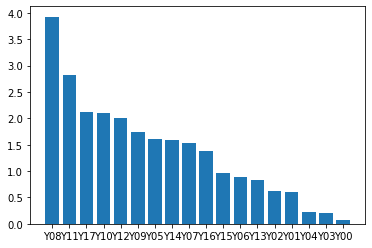

In [70]:
score_train_temp = score_train_nocv.mean().sort_values(ascending=False)
plt.bar(score_train_temp.index, score_train_temp)

what_we_use = score_train_nocv.mean()[score_train_nocv.mean() < 2].index

In [71]:
def my_combination(X_val, y_val, test, submission_val, submission,index,interval, give_index, cutoff, score):
    submission_val.index= X_val.index
    submission.index = test.index
    

    value = int(144/interval)
    a = np.array([[i]*value for i in range(0, interval)]).reshape(-1)

    test['day'] = np.array([a for i in np.arange(0,80)]).reshape(-1)
    X_val['day'] = np.array([a for i in np.arange(0,3)]).reshape(-1)
    
    if give_index == True:
        submission_val = submission_val.loc[:,index]
        submission = submission.loc[:,index]
    
    elif give_index == False:
        index = score.mean()[score.mean() < cutoff].index
        submission_val = submission_val.loc[:,index]
        submission = submission.loc[:,index]
        
        
        
    val_interval = pd.DataFrame({'Y18':[]})
    val_interval.index.name = 'id'
    
    test_interval = pd.DataFrame({'Y18':[]})
    test_interval.index.name = 'id'
    
    for k in range(0, interval):
        index = X_val[X_val['day'] == k].index
        index_test = test[test['day'] == k].index
        score = []
        for i in submission.columns:
            score.append(((submission_val.loc[index,i].copy() - y_val[index].copy())**2).sum()/(432/interval))
    
        score_interval = []
        for j in range(0, 50):
            col = np.array(score) < (j+1)
            length = len(np.where(col == True)[0])
            temp_score = ((submission_val.loc[index, col].sum(axis=1)/length - y_val[index])**2).sum()/(432/interval)
            if temp_score == 0:
                score_interval.append(9999)
            else:
                score_interval.append(temp_score)
    
        Min = np.argmin(score_interval)
        col = np.array(score) < Min + 1
        Min_length = len(np.where(col == True)[0])
    
        temp1_data = pd.DataFrame(submission_val.loc[index, col].sum(axis=1)/Min_length, columns=['Y18'])
        val_interval = val_interval.append(temp1_data)

        temp2_data = pd.DataFrame(submission.loc[index_test, col].sum(axis=1)/Min_length, columns=['Y18'])
        test_interval = test_interval.append(temp2_data)
    
    val_interval = val_interval.sort_index()
    test_interval = test_interval.sort_index()
    print(sum((np.array(val_interval).reshape(-1) - np.array(y_val))**2)/432)
    
    return val_interval, test_interval
    

#### 처음에 말씀드린 것 처럼, 성능이 좋은 Y들로 구성된 조합은 잘게잘게 나누어보고, 모든 Y를 사용한 경우는 크게크게 구간을 나눠 조합을 구성합니다. 
아무래도 시계열적으로 예측을 하는 데이터는 아니지만, 예측을 할때에는 중요한 부분인 것 같아, 앞 27일 뒤 3일로 train, valid를 해서 해당 valid에서의 성능이 2이하인 Y들을 뽑았습니다. 해당 Y들을 what_we_use라고 지칭하겠습니다.

cross validation을 통해 예측한 Y들은 what_we_use Y들과 모든 Y들을 이용해서 조합을 짜보고,
단순히 모든 Y를 train해서 얻은 Y들은 what_we_use Y들로만 조합을 짜보았습니다.

In [72]:
val_preds1 = np.zeros((X_val.shape[0],))
final_preds1 = np.zeros((test.shape[0],))
for i in [144]:
    val_interval1, test_interval1 = my_combination(X_val,y_val,test, val_answer_nocv, test_answer_nocv,
                                             what_we_use,i,True, 2, score_train_nocv)
    val_preds1 +=  np.array(val_interval1).reshape(-1)/1
    final_preds1 += np.array(test_interval1).reshape(-1)/1

####
val_preds2 = np.zeros((X_val.shape[0],))
final_preds2 = np.zeros((test.shape[0],))

for i in [144]:
    val_interval2, test_interval2 = my_combination(X_val,y_val,test, val_answer_cv, test_answer_cv,
                                             what_we_use,i,True, 2, score_train_cv)
    val_preds2 += np.array(val_interval2).reshape(-1)/1
    final_preds2 += np.array(test_interval2).reshape(-1)/1
    
####
val_preds3 = np.zeros((X_val.shape[0],))
final_preds3 = np.zeros((test.shape[0],))

for i in [8,12]:
    val_interval3, test_interval3 = my_combination(X_val,y_val,test, val_answer_cv, test_answer_cv,
                                             what_we_use,i,False, 1, score_train_cv)
    val_preds3 += np.array(val_interval3).reshape(-1)/2
    final_preds3 += np.array(test_interval3).reshape(-1)/2

2.425658404854326
1.8698231281141668
2.27233778792629
1.7042390492699797


In [73]:
print(((np.array(y_val) - val_preds1)**2).sum()/432)
print(((np.array(y_val) - val_preds2)**2).sum()/432)
print(((np.array(y_val) - val_preds3)**2).sum()/432)

2.425658404854326
1.8698231281141664
1.7454778153637636


### 3일치 Y 18과, 조합을 통해 만들어낸 Y18을 비교해보았습니다.

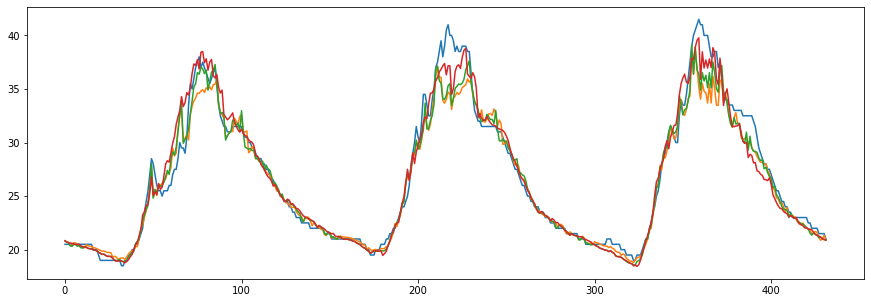

In [74]:
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(np.array(y_val))
plt.plot(val_preds1)
plt.plot(val_preds2)
plt.plot(val_preds3)

### 지수 평활법을 이용하여, Y예측값을 조금 부드럽게 해줍니다. (지수 평활법은 Data Leakage가 아닙니다!)
#### 일반적인 smoothing 방법들은 Yt를 보정할때, Yt-n...Yt+n을 사용하게 되어 제일 무난한 지수평활법을 사용하였습니다.
지수 평활법으로 조금 부드럽게 하고, 기존의 보정되지 않는 Y를 앙상블 합니다

In [75]:
Y_val = ((val_preds1 + val_preds2 + val_preds3)/3).copy()
Y_test = ((final_preds1 + final_preds2 + final_preds3)/3).copy()

In [76]:
model3 = ExponentialSmoothing(np.asarray(Y_val), trend='mul', seasonal=None)
model4 = ExponentialSmoothing(np.asarray(Y_test), trend='mul', seasonal=None)
fit3 = model3.fit(smoothing_level=.3, smoothing_slope=.1)
sub = model4.fit(smoothing_level=.3, smoothing_slope=.1)

1.4866893721685999
1.6390257985581225


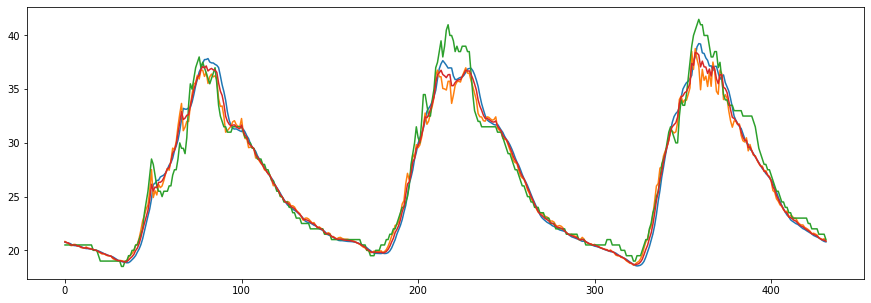

In [77]:
plt.plot(fit3.fittedvalues)
plt.plot(Y_val)
plt.plot(np.array(y_val))
plt.plot((fit3.fittedvalues+Y_val)/2)
print(((np.array(y_val) - (fit3.fittedvalues + Y_val)/2)**2).sum()/432)
print(((np.array(y_val) - fit3.fittedvalues )**2).sum()/432)

In [78]:
df = (np.array(sub.fittedvalues) + Y_test)/2
df = pd.DataFrame(df)
df.index = test.index
df.columns = ['Y18']

## 잔차보정
제일 단순한 모델을 사용하고 싶었습니다만, regression은 사용할 수 없었습니다. 그래서 depth가 1,2인 randomforest를 이용해서 최대한 단순하게 잔차를 보정해보았습니다. LB상으로는 성능이 거의 똑같아서 논리상 잔차보정을 넣어주면 좋을 것 같아 넣었는데 이게 패착이였던 것 같아 아쉽습니다..이 또한 다양하게 앙상블을 해서 보정하였습니다.

In [79]:
Y_val_sm = (fit3.fittedvalues+Y_val)/2
Y_test_sm = ((sub.fittedvalues + Y_test)/2)

diff = (y_val - Y_val_sm)
diff[abs(diff) < 1] = 0

X_val_temp = X_val.copy()
X_val_temp['Y'] = Y_val_sm

test_temp = test.copy()
test_temp['Y'] = Y_test_sm

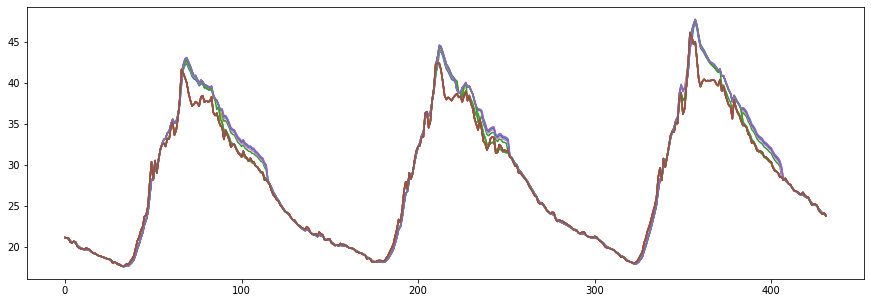

In [80]:
real_final = np.zeros((test.shape[0],))
 # create regressor object

for i in [0.2,0.3,0.4,0.5]:
    for j in [1,2]:
        regressor = RandomForestRegressor(n_estimators = 2000, random_state = 0, max_depth=j,
                                 max_features=i) 


        reg = regressor.fit(X_val_temp,diff)
    
        diff_pred = reg.predict(test_temp)
        diff_pred[abs(diff_pred) < 1] = 0

        plt.plot((diff_pred + Y_test_sm)[0:432])
        plt.plot(Y_test[0:432])
    
        final = pd.DataFrame(Y_test_sm)
        final.index=test.index
        final.columns = ['Y18']
        
        
        final_resi = pd.DataFrame(Y_test_sm + diff_pred)
        final_resi.index=test.index
        final_resi.columns = ['Y18']
    
        real_final += final_resi['Y18']/8

### 마지막으로 잔차보정하기 전과 잔차보정한 것을 앙상블 합니다

In [83]:
submission = pd.DataFrame((real_final + Y_test_sm)/2)
submission.to_csv("unifrom_seed_ensemble_exp_sml_0.3_sms_0.1_resi_제출용.csv")

## 6. 결과 및 결언
## Conclusion & Discussion

In [ ]:
submission = pd.DataFrame((real_final + Y_test_sm)/2)
submission.to_csv("unifrom_seed_ensemble_exp_sml_0.3_sms_0.1_resi_제출용.csv")

### 감사합니다. 이상한 점이 있으시면 연락주시면 감사하겠습니다. 결과물 복원 및 Data Leakage에는 신경을 많이 썼기 때문에 문제 웬만하면 문제가 없을 것이라고 생각합니다.